# Jupyter notebook implementation of EgoPlan challenge with video LLaMA

<img src="./Images/overview.png" width="1240px"/></br>

[EgoPlan Challenge Overview]

- All implementations are based on Python
- Check the requirement.txt for the related package
- Check the path of .pth and .yaml

---

## <h2><span id="contents" style="background-color: none; color: White; display: inline;">Contents</span></h2>

## [I. Egoplan Modelling Process Overview](#overview)
#### - [1. Visual Encoder (from Blip2) & Audio Encoder](#visual-encoder-from-blip2)
#### - [2. Positional Embedding](#positional-embedding)
#### - [3. Video Q-Former](#video-qformer)
#### - [4. Linear Layer](#linear-layer)
#### - [5. LLM](#llm)
#### - [6. Video-LLaMA](#video-llama)

## [II. Egoplan Dataset Preprocess and Load](#preprocess-and-load)
#### - [7. Preprocess](#preprocess)
#### - [8. Loader](#loader)

## [III. Egoplan Train & Evaluate](#egoplan-train-evaluate)
#### - [9. Train](#train)
#### - [10. Evaluate](#evaluate)

---

<img src="./Images/ego-plain notation.png" width="1400px"/></br>

# <h1><span id="overview" style="background-color: none; color: White; display: inline;">I. Egoplan Modelling Process Overview</span></h1>

### [[Back to contents](#contents)]

#### Import Package

In [1]:
import argparse
import sys
import torch
import re
import shutil
import string
import urllib
import warnings
import dataclasses
import webdataset as wds
import functools

import math
import time
import datetime
import random
import numpy as np
import contextlib
import logging
import json
import transformers
import cv2

import einops
import copy

from PIL import Image

import pandas as pd
import torch
from torchvision import transforms
from torchvision.utils import _log_api_usage_once
from torchvision.transforms.functional import InterpolationMode
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.utils.checkpoint as checkpoint
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets.utils import (
    check_integrity,
    download_file_from_google_drive,
    extract_archive,
)
from torchvision.transforms import (
    RandomCrop,
    RandomResizedCrop,
)

from omegaconf import OmegaConf
from collections import defaultdict, deque
from tqdm import tqdm
from decord import VideoReader
import decord

import timm.models.hub as timm_hub
from timm.models.layers import drop_path, to_2tuple, trunc_normal_

from torch import Tensor, device, dtype
from torch.cuda.amp import autocast as autocast

from torch.multiprocessing import reductions
from torch.nn import CrossEntropyLoss
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, Dataset, DistributedSampler
from torch.utils.data.dataloader import default_collate

from iopath.common.download import download
from iopath.common.file_io import file_lock, g_pathmgr

from functools import partial
from multiprocessing.reduction import ForkingPickler
from transformers.activations import ACT2FN
from transformers import LlamaTokenizer, BertConfig, BertTokenizer
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    BaseModelOutputWithPast,
    CausalLMOutputWithPast
)
from transformers.modeling_utils import (
    apply_chunking_to_forward,
    PreTrainedModel,
    find_pruneable_heads_and_indices,
    prune_linear_layer
)
from transformers.models.llama.configuration_llama import LlamaConfig
from transformers.utils import add_start_docstrings, add_start_docstrings_to_model_forward, replace_return_docstrings

from peft import LoraConfig, get_peft_model, PeftModelForCausalLM, PeftModel
from typing import Optional, Tuple, Dict, Any, Union, List, Callable, Sequence
from urllib.parse import urlparse
from enum import auto, Enum
from pathlib import Path

#### Check Cuda

In [2]:
import os

'''
cuda device 설정
'''

import torch

USE_CUDA = torch.cuda.is_available()
CUDA_NUMBER = 3
device = torch.device(f"cuda:{CUDA_NUMBER}" if USE_CUDA else 'cpu')

print(f'{device}')

'''
cuda 사용 여부 확인
'''

cuda:0


'\ncuda 사용 여부 확인\n'

<h1><span id="utils" style="background-color: White; color: Black; display: inline;">0. Utils</span></h1>

### [[Back to contents](#contents)]

#### Registry

  - EgoPlan 코드는 Registry를 전역 변수로 생성하고, Registry 내에 학습 및 평가 과정에 필요한 모든 객체를 전부 저장합니다.
  <br/><br/>
  - 개발자는 Registry 객체만을 통해서 데이터셋, 전처리, 모델, 학습, 평가 과정에 필요한 모든 것들을 얻을 수 있습니다.
  <br/><br/>
  - Registry 객체는 데이터셋, 전처리, 모델 등을 저장하는 변수 mapping(Dict)와, Getter, Setter로 구성됩니다.
  <br/><br/>
  - 이때, Registry 내에서 필요 객체를 직접 호출하여 저장하는 방식이 아닌, <br/>
  @registry.register_...와 같은 Decorator를 통해 "필요한 객체들이 자동적으로 Registry 내에 Setter를 호출하여 저장되는 방식"을 사용합니다.
  <br/><br/>
  - mapping 변수 내의 저장되는 클래스들은 아래 그림과 같습니다.
<br/><br/><br/>

<img src="./Images/Registry Overview.jpg" width="900px" height="600px" title="Registry Overview"/>

<br/>

  - mapping
    - builder : Dataset 생성 및 관리 객체
    - task : 모델의 학습 및 평가
    - processor : DatasetBuilder 내에서 전처리 담당 객체
    - model : Model 객체
    - lr_scheduler : Learning-Rate 스케쥴러 관리 객체
    - runner : task, dataset, model 등을 바탕으로 학습을 진행하고 결과를 저장하는 객체
    - paths : root 경로, Evaluation 결과 저장 경로들이 저장되어 있음

In [3]:
class Registry:
    mapping = {
        "builder_name_mapping": {},
        "task_name_mapping": {},
        "processor_name_mapping": {},
        "model_name_mapping": {},
        "lr_scheduler_name_mapping": {},
        "runner_name_mapping": {},
        "state": {},
        "paths": {},
    }

    @classmethod
    def register_builder(cls, name):
        r"""Register a dataset builder to registry with key 'name'

        Input:
            name: Key with which the builder will be registered.

        Usage:

            from src.video_llama.video_llama.common.registry import registry
            from src.video_llama.video_llama.datasets.base_dataset_builder import BaseDatasetBuilder
        """

        def wrap(builder_cls):
            # from src.video_llama.video_llama.datasets.builders.base_dataset_builder import BaseDatasetBuilder

            assert issubclass(
                builder_cls, BaseDatasetBuilder
            ), "All builders must inherit BaseDatasetBuilder class, found {}".format(
                builder_cls
            )
            if name in cls.mapping["builder_name_mapping"]:
                raise KeyError(
                    "Name '{}' already registered for {}.".format(
                        name, cls.mapping["builder_name_mapping"][name]
                    )
                )
            cls.mapping["builder_name_mapping"][name] = builder_cls
            return builder_cls

        return wrap

    @classmethod
    def register_task(cls, name):
        r"""Register a task to registry with key 'name'

        Input:
            name: Key with which the task will be registered.

        Usage:

            from src.video_llama.video_llama.common.registry import registry
        """

        def wrap(task_cls):
            # from src.video_llama.video_llama.tasks.base_task import BaseTask

            assert issubclass(
                task_cls, BaseTask
            ), "All tasks must inherit BaseTask class"
            if name in cls.mapping["task_name_mapping"]:
                raise KeyError(
                    "Name '{}' already registered for {}.".format(
                        name, cls.mapping["task_name_mapping"][name]
                    )
                )
            cls.mapping["task_name_mapping"][name] = task_cls
            return task_cls

        return wrap

    @classmethod
    def register_model(cls, name):
        r"""Register a task to registry with key 'name'

        Input:
            name: Key with which the task will be registered.

        Usage:

            from src.video_llama.video_llama.common.registry import registry
        """

        def wrap(model_cls):
            # from src.video_llama.video_llama.models import BaseModel

            assert issubclass(
                model_cls, BaseModel
            ), "All models must inherit BaseModel class"
            if name in cls.mapping["model_name_mapping"]:
                raise KeyError(
                    "Name '{}' already registered for {}.".format(
                        name, cls.mapping["model_name_mapping"][name]
                    )
                )
            cls.mapping["model_name_mapping"][name] = model_cls
            return model_cls

        return wrap

    @classmethod
    def register_processor(cls, name):
        r"""Register a processor to registry with key 'name'

        Input:
            name: Key with which the task will be registered.

        Usage:

            from src.video_llama.video_llama.common.registry import registry
        """

        def wrap(processor_cls):
            # from src.video_llama.video_llama.processors import BaseProcessor

            assert issubclass(
                processor_cls, BaseProcessor
            ), "All processors must inherit BaseProcessor class"
            if name in cls.mapping["processor_name_mapping"]:
                raise KeyError(
                    "Name '{}' already registered for {}.".format(
                        name, cls.mapping["processor_name_mapping"][name]
                    )
                )
            cls.mapping["processor_name_mapping"][name] = processor_cls
            return processor_cls

        return wrap

    @classmethod
    def register_lr_scheduler(cls, name):
        r"""Register a model to registry with key 'name'

        Input:
            name: Key with which the task will be registered.

        Usage:

            from src.video_llama.video_llama.common.registry import registry
        """

        def wrap(lr_sched_cls):
            if name in cls.mapping["lr_scheduler_name_mapping"]:
                raise KeyError(
                    "Name '{}' already registered for {}.".format(
                        name, cls.mapping["lr_scheduler_name_mapping"][name]
                    )
                )
            cls.mapping["lr_scheduler_name_mapping"][name] = lr_sched_cls
            return lr_sched_cls

        return wrap

    @classmethod
    def register_runner(cls, name):
        r"""Register a model to registry with key 'name'

        Input:
            name: Key with which the task will be registered.

        Usage:

            from src.video_llama.video_llama.common.registry import registry
        """

        def wrap(runner_cls):
            if name in cls.mapping["runner_name_mapping"]:
                raise KeyError(
                    "Name '{}' already registered for {}.".format(
                        name, cls.mapping["runner_name_mapping"][name]
                    )
                )
            cls.mapping["runner_name_mapping"][name] = runner_cls
            return runner_cls

        return wrap

    @classmethod
    def register_path(cls, name, path):
        r"""Register a path to registry with key 'name'

        Input:
            name: Key with which the path will be registered.

        Usage:

            from src.video_llama.video_llama.common.registry import registry
        """
        assert isinstance(path, str), "All path must be str."
        if name in cls.mapping["paths"]:
            raise KeyError("Name '{}' already registered.".format(name))
        cls.mapping["paths"][name] = path

    @classmethod
    def register(cls, name, obj):
        r"""Register an item to registry with key 'name'

        Input:
            name: Key with which the item will be registered.

        Usage:

            from src.video_llama.video_llama.common.registry import registry

            registry.register("config", {})
        """
        path = name.split(".")
        current = cls.mapping["state"]

        for part in path[:-1]:
            if part not in current:
                current[part] = {}
            current = current[part]

        current[path[-1]] = obj

    # @classmethod
    # def get_trainer_class(cls, name):
    #     return cls.mapping["trainer_name_mapping"].get(name, None)

    @classmethod
    def get_builder_class(cls, name):
        return cls.mapping["builder_name_mapping"].get(name, None)

    @classmethod
    def get_model_class(cls, name):
        return cls.mapping["model_name_mapping"].get(name, None)

    @classmethod
    def get_task_class(cls, name):
        return cls.mapping["task_name_mapping"].get(name, None)

    @classmethod
    def get_processor_class(cls, name):
        return cls.mapping["processor_name_mapping"].get(name, None)

    @classmethod
    def get_lr_scheduler_class(cls, name):
        return cls.mapping["lr_scheduler_name_mapping"].get(name, None)

    @classmethod
    def get_runner_class(cls, name):
        return cls.mapping["runner_name_mapping"].get(name, None)

    @classmethod
    def list_runners(cls):
        return sorted(cls.mapping["runner_name_mapping"].keys())

    @classmethod
    def list_models(cls):
        return sorted(cls.mapping["model_name_mapping"].keys())

    @classmethod
    def list_tasks(cls):
        return sorted(cls.mapping["task_name_mapping"].keys())

    @classmethod
    def list_processors(cls):
        return sorted(cls.mapping["processor_name_mapping"].keys())

    @classmethod
    def list_lr_schedulers(cls):
        return sorted(cls.mapping["lr_scheduler_name_mapping"].keys())

    @classmethod
    def list_datasets(cls):
        return sorted(cls.mapping["builder_name_mapping"].keys())

    @classmethod
    def get_path(cls, name):
        return cls.mapping["paths"].get(name, None)

    @classmethod
    def get(cls, name, default=None, no_warning=False):
        r"""Get an item from registry with key 'name'

        Input:
            name (string): Key whose value needs to be retrieved.
            default: If passed and key is not in registry, default value will
                     be returned with a warning. Default: None
            no_warning (bool): If passed as True, warning when key doesn't exist
                               will not be generated. Useful for MMF's
                               internal operations. Default: False
        """
        original_name = name
        name = name.split(".")
        value = cls.mapping["state"]
        for subname in name:
            value = value.get(subname, default)
            if value is default:
                break

        if (
            "writer" in cls.mapping["state"]
            and value == default
            and no_warning is False
        ):
            cls.mapping["state"]["writer"].warning(
                "Key {} is not present in registry, returning default value "
                "of {}".format(original_name, default)
            )
        return value

    @classmethod
    def unregister(cls, name):
        r"""Remove an item from registry with key 'name'

        Input:
            name: Key which needs to be removed.
        Usage:

            from mmf.common.registry import registry

            config = registry.unregister("config")
        """
        return cls.mapping["state"].pop(name, None)

registry = Registry()

root_dir = os.path.abspath("./src/video_llama/video_llama")
default_cfg = OmegaConf.load(os.path.join(root_dir, "./configs/default.yaml"))

registry.register_path("library_root", root_dir)
repo_root = os.path.join(root_dir, "..")
registry.register_path("repo_root", repo_root)
cache_root = os.path.join(repo_root, default_cfg.env.cache_root)
registry.register_path("cache_root", cache_root)

registry.register("MAX_INT", sys.maxsize)
registry.register("SPLIT_NAMES", ["train", "val", "test"])

#### dist_utils

##### - 분산 학습을 위한 코드. 여러 GPU를 병렬화 계산하는 목적으로 활용되며, 다음의 목적을 위한 함수가 내장되어있습니다.

- 분산 패키지의 사용 가능 여부와 초기화 여부를 확인.
- 분산 환경에서 파일 다운로드 및 캐싱을 처리.
- 데이터를 CUDA 장치로 이동.
- 분산 모드 설정 및 프로세스 구성.
- 분산 학습 관련 정보 및 유틸리티 관리.

In [4]:
def is_dist_avail_and_initialized():
    """
    분산 패키지가 사용 가능하고 초기화되었는지 확인
    """
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_rank():
    """
    현재 프로세스의 상태를 파악하고 분산 패키지가 사용 가능하거나 초기화되지 않은 경우 0을 반환
    """
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()

def is_main_process():
    """
    현재 프로세스가 메인 프로세스인지 (랭크 0) 확인
    """
    return get_rank() == 0

def download_cached_file(url, check_hash=True, progress=False):
    # """
    # Download a file from a URL and cache it locally. If the file already exists, it is not downloaded again.
    # If distributed, only the main process downloads the file, and the other processes wait for the file to be downloaded.
    # """
    """
    URL에서 파일을 다운로드하고 로컬에 캐싱
    분산 환경에서는 메인 프로세스만 파일을 다운로드하고 다른 프로세스는 다운로드가 완료될 때까지 확인
    """

    def get_cached_file_path():
        # a hack to sync the file path across processes
        parts = torch.hub.urlparse(url)
        filename = os.path.basename(parts.path)
        cached_file = os.path.join(timm_hub.get_cache_dir(), filename)

        return cached_file

    if is_main_process():
        timm_hub.download_cached_file(url, check_hash, progress)

    if is_dist_avail_and_initialized():
        dist.barrier()

    return get_cached_file_path()

def apply_to_sample(f, sample):
    """
    샘플에 함수를 적용하며, 샘플이 텐서, 딕셔너리 또는 리스트 형태로 적용함
    """
    if len(sample) == 0:
        return {}

    def _apply(x):
        if torch.is_tensor(x):
            return f(x)
        elif isinstance(x, dict):
            return {key: _apply(value) for key, value in x.items()}
        elif isinstance(x, list):
            return [_apply(x) for x in x]
        else:
            return x

    return _apply(sample)

def move_to_cuda(sample):
    """
    CUDA로 이동시킴
    """
    def _move_to_cuda(tensor):
        return tensor.cuda()

    return apply_to_sample(_move_to_cuda, sample)

def prepare_sample(samples, cuda_enabled=True):
    """
    준비된 샘플을 CUDA로 이동시킴
    """
    if cuda_enabled:
        samples = move_to_cuda(samples)

    # TODO fp16 support

    return samples

def get_world_size():
    """
    분산 패키지가 사용가능하거나 초기화되지 않은 경우 1을 반환
    """
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def setup_for_distributed(is_master):
    # """
    # This function disables printing when not in master process
    # """
    """
    마스터 프로세스가 아닌 경우 출력을 비활성화
    """
    import builtins as __builtin__

    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop("force", False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print

def init_distributed_mode(args):
    """
    분산 모드 초기화. 환경 변수에 따라 랭크, 월드 사이즈(분산 패키지 사용 여부) 및 GPU를 설정
    """
    if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ["WORLD_SIZE"])
        args.gpu = int(os.environ["LOCAL_RANK"])
    elif "SLURM_PROCID" in os.environ:
        args.rank = int(os.environ["SLURM_PROCID"])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print("Not using distributed mode")
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = "nccl"
    print(
        "| distributed init (rank {}, world {}): {}".format(
            args.rank, args.world_size, args.dist_url
        ),
        flush=True,
    )
    torch.distributed.init_process_group(
        backend=args.dist_backend,
        init_method=args.dist_url,
        world_size=args.world_size,
        rank=args.rank,
        timeout=datetime.timedelta(
            days=365
        ),  # allow auto-downloading and de-compressing
    )
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

def get_dist_info():
    """
    분산 정보 (랭크 및 월드 사이즈)를 반환
    """
    if torch.__version__ < "1.0":
        initialized = dist._initialized
    else:
        initialized = dist.is_initialized()
    if initialized:
        rank = dist.get_rank()
        world_size = dist.get_world_size()
    else:  # non-distributed training
        rank = 0
        world_size = 1
    return rank, world_size

def main_process(func):
    """
    메인 프로세스에서만 주어진 함수를 실행하도록 래핑 -> decorator 활용
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        rank, _ = get_dist_info()
        if rank == 0:
            return func(*args, **kwargs)

    return wrapper

#### utils

##### - 유틸리티 함수들을 제공하여 파일 다운로드, 경로 처리, URL 처리 등의 다양한 작업을 돕기 위해 작성된 함수입니다.
##### - EgoPlan challenge를 수행함에 있어 직접적인 역할을 하는 것이 아닌 각종 부가적인 기능을 도와주는 역할을 합니다.

In [5]:
def now():
    """
    현재 날짜와 시간을 "YYYYMMDDHHMM" 형식으로 반환
    """
    from datetime import datetime
    return datetime.now().strftime("%Y%m%d%H%M")[:-1]

def is_url(input_url):
    # """
    # Check if an input string is a url. look for http(s):// and ignoring the case
    # """
    """
    입력 문자열이 URL인지 정규식을 통해 확인함
    [http(s):// 패턴을 검사]
    """
    is_url = re.match(r"^(?:http)s?://", input_url, re.IGNORECASE) is not None
    return is_url

def get_abs_path(rel_path):
    """
    주어진 상대 경로를 절대 경로로 변환
    """
    return os.path.join(registry.get_path("library_root"), rel_path)

def get_cache_path(rel_path):
    """
    주어진 상대 경로를 캐시 경로로 변환
    [캐시 경로 : 데이터 임시 저장 디렉토리 경로]
    """
    return os.path.expanduser(os.path.join(registry.get_path("cache_root"), rel_path))

def makedir(dir_path):
    # """
    # Create the directory if it does not exist.
    # """
    """
    디렉토리가 이미 존재하지 않는 경우에만 주어진 경로에 디렉토리를 생성
    """
    is_success = False
    try:
        if not g_pathmgr.exists(dir_path):
            g_pathmgr.mkdirs(dir_path)
        is_success = True
    except BaseException:
        print(f"Error creating directory: {dir_path}")
    return is_success

def get_redirected_url(url: str):
    # """
    # Given a URL, returns the URL it redirects to or the
    # original URL in case of no indirection
    # """
    """
    주어진 URL이 redirection되는 URL을 반환하거나, redirection이 없는 경우 원래 URL을 반환
    """
    import requests

    with requests.Session() as session:
        with session.get(url, stream=True, allow_redirects=True) as response:
            if response.history:
                return response.url
            else:
                return url

def _get_google_drive_file_id(url: str) -> Optional[str]:
    """
    주어진 URL에서 Google Drive 파일 ID를 추출
    """
    parts = urlparse(url)

    if re.match(r"(drive|docs)[.]google[.]com", parts.netloc) is None:
        return None

    match = re.match(r"/file/d/(?P<id>[^/]*)", parts.path)
    if match is None:
        return None

    return match.group("id")

def _urlretrieve(url: str, filename: str, chunk_size: int = 1024) -> None:
    """
    주어진 URL에서 파일을 다운로드하여 지정된 파일명으로 저장
    """
    with open(filename, "wb") as fh:
        with urllib.request.urlopen(
            urllib.request.Request(url, headers={"User-Agent": "vissl"})
        ) as response:
            with tqdm(total=response.length) as pbar:
                for chunk in iter(lambda: response.read(chunk_size), ""):
                    if not chunk:
                        break
                    pbar.update(chunk_size)
                    fh.write(chunk)

def download_url(
    url: str,
    root: str,
    filename: Optional[str] = None,
    md5: Optional[str] = None,
) -> None:
    # """Download a file from a url and place it in root.
    # Args:
    #     url (str): URL to download file from
    #     root (str): Directory to place downloaded file in
    #     filename (str, optional): Name to save the file under.
    #                               If None, use the basename of the URL.
    #     md5 (str, optional): MD5 checksum of the download. If None, do not check
    # """
    """
    주어진 URL에서 파일을 다운로드하여 지정된 디렉토리에 저장하며 다운로드한 파일의 무결성을 확인.
    무결성은 md5 무결성을 진행
    """
    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    makedir(root)

    # check if file is already present locally
    if check_integrity(fpath, md5):
        print("Using downloaded and verified file: " + fpath)
        return

    # expand redirect chain if needed
    url = get_redirected_url(url)

    # check if file is located on Google Drive
    file_id = _get_google_drive_file_id(url)
    if file_id is not None:
        return download_file_from_google_drive(file_id, root, filename, md5)

    # download the file
    try:
        print("Downloading " + url + " to " + fpath)
        _urlretrieve(url, fpath)
    except (urllib.error.URLError, IOError) as e:  # type: ignore[attr-defined]
        if url[:5] == "https":
            url = url.replace("https:", "http:")
            print(
                "Failed download. Trying https -> http instead."
                " Downloading " + url + " to " + fpath
            )
            _urlretrieve(url, fpath)
        else:
            raise e

    # check integrity of downloaded file
    if not check_integrity(fpath, md5):
        raise RuntimeError("File not found or corrupted.")

#### logger

#### - 각종 metrics를 로깅하고 동기화하며, 학습 진행 시 상황을 출력하기 위해 사용됩니다.

- SmoothedValue 클래스는 값들을 트래킹하고 value에 대해 평준화된 값을 제공합니다.
- MetricLogger 클래스는 여러 metrics를 트래킹하고 업데이트 및 출력하는 기능을 제공합니다

In [6]:
class SmoothedValue(object):
    # """Track a series of values and provide access to smoothed values over a
    # window or the global series average.
    # """
    """
    값의 시리즈를 추적하고 윈도우 또는 전체 시리즈 평균에 대한 평준화된 값에 접근할 수 있게 하는 클래스
    """

    def __init__(self, window_size=20, fmt=None):
        """
        기본 윈도우 크기는 20으로 하여금 SmoothedValue 객체를 초기화
        """
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        # """
        # Warning: does not synchronize the deque!
        # """
        """
        여러 프로세스 간에 count와 total을 동기화, 큐와 스택을 합친 deque를 활용함.
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        """
        현재 deque에 있는 값들의 중앙값을 반환
        """
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        """
        현재 deque에 있는 값들의 평균을 반환합니다
        """
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        """
        전체 값들의 평균을 반환
        """
        return self.total / self.count

    @property
    def max(self):
        """
        현재 deque에 있는 값들 중 최대값을 반환
        """
        return max(self.deque)

    @property
    def value(self):
        """
        가장 최근에 추가된 값을 반환
        """
        return self.deque[-1]

    def __str__(self):
        """
        객체를 문자열로 변환하여 출력 형식에 맞게 반환
        """
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value,
        )

class MetricLogger(object):
    """
    여러 메트릭을 트래킹하고 업데이트하며 출력하는 역할의 클래스
    """
    def __init__(self, delimiter="\t"):
        """
        기본 구분자는 탭(\t)으로 하여금 객체 초기화
        """
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        """
        키워드 인자들을 업데이트하여 메트릭들을 갱신
        """
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(
            "'{}' object has no attribute '{}'".format(type(self).__name__, attr)
        )

    def __str__(self):
        """
        객체를 문자열로 변환하여 각 메트릭을 출력 형식에 맞게 반환
        """
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append("{}: {}".format(name, str(meter)))
        return self.delimiter.join(loss_str)

    def global_avg(self):
        """
        각 메트릭의 전체 평균을 구해 문자열로 반환
        """
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append("{}: {:.4f}".format(name, meter.global_avg))
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        """
        각 메트릭을 여러 프로세스 간에 동기화
        """
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        """
        새로운 메트릭을 추가
        """
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        """
        로그 출력 함수
        반복 객체(iterative한) 지정된 빈도(iterable)에 따라 지속적으로 학습 진행 상황, ETA, 메모리 사용량 등 출력
        """
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        log_msg = [
            header,
            "[{0" + space_fmt + "}/{1}]",
            "eta: {eta}",
            "{meters}",
            "time: {time}",
            "data: {data}",
        ]
        if torch.cuda.is_available():
            log_msg.append("max mem: {memory:.0f}")
        log_msg = self.delimiter.join(log_msg)
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(
            "{} Total time: {} ({:.4f} s / it)".format(
                header, total_time_str, total_time / len(iterable)
            )
        )

#### helpers

#### - pytorch의 nn.module에서 확장하거나 support할 수 있는 기능을 모아둔 helper 클래스와 함수들을 제공합니다.
#### - 모델의가독성, 텐서 조작, 정규화 및 기타 유용한 기능을 제공합니다.

In [7]:
class VerboseNNModule(nn.Module):
    """
    Wrapper around nn.Module that prints registered buffers and parameter names
    """

    @staticmethod
    def get_readable_tensor_repr(name: str, tensor: torch.Tensor) -> str:
        """
        torch tensor를 가독성있는 문자열 표현으로 반환
        """
        st = (
            "("
            + name
            + "): "
            + "tensor("
            + str(tuple(tensor[1].shape))
            + ", requires_grad="
            + str(tensor[1].requires_grad)
            + ")\n"
        )
        return st

    def extra_repr(self) -> str:
        """
        모듈의 등록된 버퍼와 파라미터 이름을 출력
        """
        named_modules = set()
        for p in self.named_modules():
            named_modules.update([p[0]])
        named_modules = list(named_modules)

        string_repr = ""
        for p in self.named_parameters():
            name = p[0].split(".")[0]
            if name not in named_modules:
                string_repr += self.get_readable_tensor_repr(name, p)

        for p in self.named_buffers():
            name = p[0].split(".")[0]
            string_repr += self.get_readable_tensor_repr(name, p)

        return string_repr

class EinOpsRearrange(nn.Module):
    def __init__(self, rearrange_expr: str, **kwargs) -> None:
        """
        주어진 표현식과 추가 인자를 사용하여 EinOpsRearrange 객체를 초기화
        """
        super().__init__()
        self.rearrange_expr = rearrange_expr
        self.kwargs = kwargs

    def forward(self, x):
        """
        주어진 torch tensor를 재배열하여 반환
        """
        assert isinstance(x, torch.Tensor)
        return einops.rearrange(x, self.rearrange_expr, **self.kwargs)

class SelectElement(nn.Module):
    def __init__(self, index) -> None:
        """
        SelectElement 객체를 초기화하며 선택할 인덱스를 설정
        """
        super().__init__()
        self.index = index

    def forward(self, x):
        """
        주어진 tensor에서 지정된 인덱스의 요소를 선택하여 반환
        """
        assert x.ndim >= 3
        return x[:, self.index, ...]

class SelectEOSAndProject(nn.Module):
    """
    Text Pooling used in OpenCLIP
    """

    def __init__(self, proj: nn.Module) -> None:
        """
        SelectEOSAndProject 객체를 초기화하며 프로젝션 모듈을 설정
        """
        super().__init__()
        self.proj = proj

    def forward(self, x, seq_len):
        """
        주어진 tensor에서 시퀀스 길이에 따라 EOS 토큰의 특징을 선택하고 프로젝션을 수행 (OpenCLIP에서 사용되는 텍스트 풀링)
        """
        assert x.ndim == 3
        # x is of shape B x L x D
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), seq_len]
        x = self.proj(x)
        return x

class Normalize(nn.Module):
    def __init__(self, dim: int) -> None:
        """
        normalize 객체를 초기화하며 정규화할 차원을 설정
        """
        super().__init__()
        self.dim = dim

    def forward(self, x):
        """
        주어진 tensor를 L2 정규화하여 반환
        """
        return torch.nn.functional.normalize(x, dim=self.dim, p=2)

class LearnableLogitScaling(nn.Module):
    def __init__(
        self,
        logit_scale_init: float = 1 / 0.07,
        learnable: bool = True,
        max_logit_scale: float = 100,
    ) -> None:
        """
        LearnableLogitScaling 객체를 초기화하며 초기 로짓 스케일, 학습 가능 여부, 최대 로짓 스케일을 설정
        """
        super().__init__()
        self.max_logit_scale = max_logit_scale
        self.logit_scale_init = logit_scale_init
        self.learnable = learnable
        log_logit_scale = torch.ones([]) * np.log(self.logit_scale_init)
        if learnable:
            self.log_logit_scale = nn.Parameter(log_logit_scale)
        else:
            self.register_buffer("log_logit_scale", log_logit_scale)

    def forward(self, x):
        """
        주어진 tensor에 대해 로짓 스케일링을 수행하여 반환
        """
        return torch.clip(self.log_logit_scale.exp(), max=self.max_logit_scale) * x

    def extra_repr(self):
        """
        모듈의 추가 표현을 반환
        """
        st = f"logit_scale_init={self.logit_scale_init},learnable={self.learnable}," \
             f" max_logit_scale={self.max_logit_scale}"
        return st

def cast_if_src_dtype(
    tensor: torch.Tensor, src_dtype: torch.dtype, tgt_dtype: torch.dtype
):
    """
    주어진 tensor를 src 데이터 타입에서 tgt 데이터 타입으로 변환 및 updated=True를 추가 반환
    """
    updated = False
    if tensor.dtype == src_dtype:
        tensor = tensor.to(dtype=tgt_dtype)
        updated = True
    return tensor, updated

#### base_model

#### - Egoplan challenge에 기반이되는 Q-Former, ViT, LLaMA 등의 pre-train 모델을 정의하는 클래스입니다. 
#### - 각 pre-train 모델의 ckpt를 로드하고 모델의 생성, 모델의 파라미터를 shown하는 기능을 제공합니다. 여러 pre-train 모델을 로드할 수 있도록 구성되어 있어서 어떤 모델이든 사용가능하도록 재사용과 확장성이 높도록 구성되어있습니다.

In [8]:
class BaseModel(nn.Module):
    # """Base class for models."""

    def __init__(self):
        super().__init__()

    @property
    def device(self):
        """
        모델의 파라미터가 위치한 장치(CPU 또는 GPU)를 반환하는 속성 함수
        """
        return list(self.parameters())[0].device

    def load_checkpoint(self, url_or_filename):
        # """
        # Load from a finetuned checkpoint.

        # This should expect no mismatch in the model keys and the checkpoint keys.
        # """
        """
        URL 또는 파일 경로에서 모델의 체크포인트 파일을 로드하고, 모델의 상태를 복원함
        """

        if is_url(url_or_filename):
            cached_file = download_cached_file(
                url_or_filename, check_hash=False, progress=True
            )
            checkpoint = torch.load(cached_file, map_location="cpu")
        elif os.path.isfile(url_or_filename):
            checkpoint = torch.load(url_or_filename, map_location="cpu")
        else:
            raise RuntimeError("checkpoint url or path is invalid")

        if "model" in checkpoint.keys():
            state_dict = checkpoint["model"]
        else:
            state_dict = checkpoint

        msg = self.load_state_dict(state_dict, strict=False)

        logging.info("Missing keys {}".format(msg.missing_keys))
        logging.info("load checkpoint from %s" % url_or_filename)

        return msg

    @classmethod
    def from_pretrained(cls, model_type):
        # """
        # Build a pretrained model from default configuration file, specified by model_type.

        # Args:
        #     - model_type (str): model type, specifying architecture and checkpoints.

        # Returns:
        #     - model (nn.Module): pretrained or finetuned model, depending on the configuration.
        # """
        
        """
        모델 유형을 지정하여 pre-train 모델을 생성함. config의 모델 구성을 바탕으로 로드하고 모델을 생성하는 과정을 거침
        """
        
        model_cfg = OmegaConf.load(cls.default_config_path(model_type)).model
        model = cls.from_config(model_cfg)

        return model

    @classmethod
    def default_config_path(cls, model_type):
        """
        지정된 모델 유형의 config 경로를 반환하되, 모델 유형이 config 딕셔너리에 존재하지 않으면 AssertError 발생
        """
        assert (
            model_type in cls.PRETRAINED_MODEL_CONFIG_DICT
        ), "Unknown model type {}".format(model_type)
        return get_abs_path(cls.PRETRAINED_MODEL_CONFIG_DICT[model_type])

    def load_checkpoint_from_config(self, cfg, **kwargs):
        # """
        # Load checkpoint as specified in the config file.

        # If load_finetuned is True, load the finetuned model; otherwise, load the pretrained model.
        # When loading the pretrained model, each task-specific architecture may define their
        # own load_from_pretrained() method.
        # """
        """
        config에 지정된 대로 체크포인트를 로드함
        load_finetuned가 True인 경우 fine-tuned된 모델을 로드하고, 그렇지 않으면 pre-train 모델을 로드
        """
        
        load_finetuned = cfg.get("load_finetuned", True)
        if load_finetuned:
            finetune_path = cfg.get("finetuned", None)
            assert (
                finetune_path is not None
            ), "Found load_finetuned is True, but finetune_path is None."
            self.load_checkpoint(url_or_filename=finetune_path)
        else:
            # load pre-trained weights
            pretrain_path = cfg.get("pretrained", None)
            assert "Found load_finetuned is False, but pretrain_path is None."
            self.load_from_pretrained(url_or_filename=pretrain_path, **kwargs)

    def before_evaluation(self, **kwargs):
        """
        평가 과정 이전에 단순 호출되는 함수
        """
        pass

    def show_n_params(self, return_str=True):
        """
        모델의 파라미터 수를 반환. 파라미터 수가 100만 이상이면 "M" 단위로, 그렇지 않으면 "K" 단위로 반환
        """
        tot = 0
        for p in self.parameters():
            w = 1
            for x in p.shape:
                w *= x
            tot += w
        if return_str:
            if tot >= 1e6:
                return "{:.1f}M".format(tot / 1e6)
            else:
                return "{:.1f}K".format(tot / 1e3)
        else:
            return tot

#### Base_task

#### - BaseTask 클래스는 모델의 구축, 데이터셋의 준비, 학습 및 평가 단계를 관리하는 기능을 제공합니다.
#### - BaseModel 클래스와 유사하게 다양한 데이터셋(Webvid, LLava, Ego4D, Kitchen 등)을 로드하고 다양한 모델을 구축하기 위해 재사용과 확장성이 높도록 구성되어있습니다.

In [9]:
class BaseTask:
    def __init__(self, **kwargs):
        """
        BaseTask 객체를 초기화. inst_id_key는 인스턴스 ID 키를 지정하는 역할을 함
        """
        super().__init__()

        self.inst_id_key = "instance_id"

    @classmethod
    def setup_task(cls, **kwargs):
        """
        클래스 메서드인 새로운 BaseTask 객체를 생성하여 반환
        [클래스 메서드 : 해당 클래스(여기서는 BaseTask)를 인스턴스화 하지 않고 호출하는 메소드
        클래스 객체내에서 변동을 주지 않으면서 각 개체값을 활용하기 위해 사용]
        """
        return cls()

    def build_model(self, cfg):
        """
        config에서 모델을 구축함
        모델의 아키텍처를 지정하고, 해당 클래스에서 모델을 생성하여 반환
        """
        model_config = cfg.model_cfg

        model_cls = registry.get_model_class(model_config.arch)
        return model_cls.from_config(model_config)

    def build_datasets(self, cfg):
        # """
        # Build a dictionary of datasets, keyed by split 'train', 'valid', 'test'.
        # Download dataset and annotations automatically if not exist.

        # Args:
        #     cfg (common.config.Config): _description_

        # Returns:
        #     dict: Dictionary of torch.utils.data.Dataset objects by split.
        # """
        """
        config를 바탕으로 데이터셋을 구축
        각 데이터셋 빌더 클래스를 사용하여 데이터셋을 생성하고, 'train', 'valid', 'test'로 구분된 데이터셋 딕셔너리를 반환
        """

        datasets = dict()

        datasets_config = cfg.datasets_cfg

        assert len(datasets_config) > 0, "At least one dataset has to be specified."

        for name in datasets_config:
            dataset_config = datasets_config[name]

            builder = registry.get_builder_class(name)(dataset_config)
            # print(name)
            # print(builder)
            # print(dataset_config)
            dataset = builder.build_datasets()

            dataset['train'].name = name
            if 'sample_ratio' in dataset_config:
                dataset['train'].sample_ratio = dataset_config.sample_ratio

            datasets[name] = dataset

        return datasets

    def train_step(self, model, samples):
        """
        모델과 샘플 데이터(여기서는 train set)를 사용하여 학습 단계를 수행하고 loss 값을 반환
        """
        loss = model(samples)["loss"]
        return loss

    def valid_step(self, model, samples):
        """
        validation step을 진행하는 함수 
        서브 클래스에서 직접 구현하는 과정이 필요
        """
        raise NotImplementedError

    def before_evaluation(self, model, dataset, **kwargs):
        """
        모델의 평가 전 호출되어 평가 설정을 진행
        """
        model.before_evaluation(dataset=dataset, task_type=type(self))

    def after_evaluation(self, **kwargs):
        """
        평가 과정 이후에 단순 호출되는 함수
        """
        pass

    def inference_step(self):
        """
        inference step을 진행하는 함수 
        서브 클래스에서 직접 구현하는 과정이 필요
        """
        raise NotImplementedError

    def evaluation(self, model, data_loader, cuda_enabled=True):
        """
        데이터 로더로 test set을 로드하여 평가를 수행하고, 평가 결과를 반환
        """
        metric_logger = MetricLogger(delimiter="  ")
        header = "Evaluation"
        # TODO make it configurable
        print_freq = 10

        results = []

        for samples in metric_logger.log_every(data_loader, print_freq, header):
            samples = prepare_sample(samples, cuda_enabled=cuda_enabled)

            eval_output = self.valid_step(model=model, samples=samples)
            results.extend(eval_output)

        if is_dist_avail_and_initialized():
            dist.barrier()

        return results

    def train_epoch(
        self,
        epoch,
        model,
        data_loader,
        optimizer,
        lr_scheduler,
        scaler=None,
        cuda_enabled=False,
        log_freq=50,
        accum_grad_iters=1,
    ):
        """
        주어진 에포크 동안 모델 학습 루프를 호출함
        """
        return self._train_inner_loop(
            epoch=epoch,
            iters_per_epoch=lr_scheduler.iters_per_epoch,
            # iters_per_epoch=min(lr_scheduler.iters_per_epoch, len(data_loader)),
            model=model,
            data_loader=data_loader,
            optimizer=optimizer,
            scaler=scaler,
            lr_scheduler=lr_scheduler,
            log_freq=log_freq,
            cuda_enabled=cuda_enabled,
            accum_grad_iters=accum_grad_iters,
        )

    def train_iters(
        self,
        epoch,
        start_iters,
        iters_per_inner_epoch,
        model,
        data_loader,
        optimizer,
        lr_scheduler,
        scaler=None,
        cuda_enabled=False,
        log_freq=50,
        accum_grad_iters=1,
    ):
        """
        주어진 횟수(iters) 동안 모델 학습 루프를 호출함
        """
        return self._train_inner_loop(
            epoch=epoch,
            start_iters=start_iters,
            iters_per_epoch=iters_per_inner_epoch,
            model=model,
            data_loader=data_loader,
            optimizer=optimizer,
            scaler=scaler,
            lr_scheduler=lr_scheduler,
            log_freq=log_freq,
            cuda_enabled=cuda_enabled,
            accum_grad_iters=accum_grad_iters,
        )

    def _train_inner_loop(
        self,
        epoch,
        iters_per_epoch,
        model,
        data_loader,
        optimizer,
        lr_scheduler,
        scaler=None,
        start_iters=None,
        log_freq=50,
        cuda_enabled=False,
        accum_grad_iters=1,
    ):
        # """
        # An inner training loop compatible with both epoch-based and iter-based training.

        # When using epoch-based, training stops after one epoch; when using iter-based,
        # training stops after #iters_per_epoch iterations.
        # """
        """
        내부 학습 루프. 세팅된 optimizer, epoch, data, scaler, 등과 모델에 따라 적절한 학습 과정 수행
        """
        use_amp = scaler is not None

        if not hasattr(data_loader, "__next__"):
            # convert to iterator if not already
            data_loader = iter(data_loader)

        metric_logger = MetricLogger(delimiter="  ")
        metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
        metric_logger.add_meter("loss", SmoothedValue(window_size=1, fmt="{value:.4f}"))

        # if iter-based runner, schedule lr based on inner epoch.
        logging.info(
            "Start training epoch {}, {} iters per inner epoch.".format(
                epoch, iters_per_epoch
            )
        )
        header = "Train: data epoch: [{}]".format(epoch)
        if start_iters is None:
            # epoch-based runner
            inner_epoch = epoch
        else:
            # In iter-based runner, we schedule the learning rate based on iterations.
            inner_epoch = start_iters // iters_per_epoch
            header = header + "; inner epoch [{}]".format(inner_epoch)

        for i in metric_logger.log_every(range(iters_per_epoch), log_freq, header):
            # if using iter-based runner, we stop after iters_per_epoch iterations.
            if i >= iters_per_epoch:
                break

            samples = next(data_loader)

            samples = prepare_sample(samples, cuda_enabled=cuda_enabled)
            samples.update(
                {
                    "epoch": inner_epoch,
                    "num_iters_per_epoch": iters_per_epoch,
                    "iters": i,
                }
            )

            lr_scheduler.step(cur_epoch=inner_epoch, cur_step=i)

            with torch.cuda.amp.autocast(enabled=use_amp):
                loss = self.train_step(model=model, samples=samples)

            # after_train_step()
            if use_amp:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            # update gradients every accum_grad_iters iterations
            if (i + 1) % accum_grad_iters == 0:
                if use_amp:
                    scaler.step(optimizer)
                    scaler.update()                     
                else:    
                    optimizer.step()
                optimizer.zero_grad()

            metric_logger.update(loss=loss.item())
            metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        # after train_epoch()
        # gather the stats from all processes
        metric_logger.synchronize_between_processes()
        logging.info("Averaged stats: " + str(metric_logger.global_avg()))
        return {
            k: "{:.3f}".format(meter.global_avg)
            for k, meter in metric_logger.meters.items()
        }

    @staticmethod
    def save_result(result, result_dir, filename, remove_duplicate=""):
        """
        주어진 결과를 저장함
        특히, 분산 학습 환경에서 각 프로세스의 결과를 병합하여 최종 결과 파일을 생성
        파일의 형태는 json형태로 저장됨
        """
        import json

        result_file = os.path.join(
            result_dir, "%s_rank%d.json" % (filename, get_rank())
        )
        final_result_file = os.path.join(result_dir, "%s.json" % filename)

        json.dump(result, open(result_file, "w"))

        if is_dist_avail_and_initialized():
            dist.barrier()

        if is_main_process():
            logging.warning("rank %d starts merging results." % get_rank())
            # combine results from all processes
            result = []

            for rank in range(get_world_size()):
                result_file = os.path.join(
                    result_dir, "%s_rank%d.json" % (filename, rank)
                )
                res = json.load(open(result_file, "r"))
                result += res

            if remove_duplicate:
                result_new = []
                id_list = []
                for res in result:
                    if res[remove_duplicate] not in id_list:
                        id_list.append(res[remove_duplicate])
                        result_new.append(res)
                result = result_new

            json.dump(result, open(final_result_file, "w"))
            print("result file saved to %s" % final_result_file)

        return final_result_file

#### BaseDatasetBuilder

#### - DatasetBuilder의 기본 클래스를 정의하여 데이터셋의 다운로드, 전처리, 구축 및 학습과 평가를 위한 데이터셋을 준비하는 과정 등의 기능을 제공합니다.
#### - 특히, 다양한 데이터셋(Webvid, LLava, Ego4D, Kitchen 등)을 손쉽게 구축할 수 있도록하는 데이터셋 유틸리티 함수를 제공합니다.

In [10]:
class BaseDatasetBuilder:
    train_dataset_cls, eval_dataset_cls = None, None

    def __init__(self, cfg=None):
        """
        Config를 바탕으로 BaseDatasetBuilder 객체를 초기화
        """
        super().__init__()

        if cfg is None:
            # help to create datasets from default config.
            self.config = load_dataset_config(self.default_config_path())
        elif isinstance(cfg, str):
            self.config = load_dataset_config(cfg)
        else:
            # when called from task.build_dataset()
            self.config = cfg

        self.data_type = self.config.data_type

        self.vis_processors = {"train": BaseProcessor(), "eval": BaseProcessor()}
        self.text_processors = {"train": BaseProcessor(), "eval": BaseProcessor()}

    def build_datasets(self):
        # download, split, etc...
        # only called on 1 GPU/TPU in distributed
        """
        필요한 경우 데이터를 다운로드하고, 데이터셋을 분할한 후에 데이터셋 객체를 반환하는 과정을 수행하는 데이터셋 구축 과정을 진행
        """

        if is_main_process():
            self._download_data()

        if is_dist_avail_and_initialized():
            dist.barrier()

        # at this point, all the annotations and image/videos should be all downloaded to the specified locations.
        logging.info("Building datasets...")
        datasets = self.build()  # dataset['train'/'val'/'test']

        return datasets

    def build_processors(self):
        """
        vision/text의 형태에 따라 각각의 train/eval dataset을 구분하도록 구축하는 과정
        """
        vis_proc_cfg = self.config.get("vis_processor")
        txt_proc_cfg = self.config.get("text_processor")

        if vis_proc_cfg is not None:
            vis_train_cfg = vis_proc_cfg.get("train")
            vis_eval_cfg = vis_proc_cfg.get("eval")

            self.vis_processors["train"] = self._build_proc_from_cfg(vis_train_cfg)
            self.vis_processors["eval"] = self._build_proc_from_cfg(vis_eval_cfg)

        if txt_proc_cfg is not None:
            txt_train_cfg = txt_proc_cfg.get("train")
            txt_eval_cfg = txt_proc_cfg.get("eval")

            self.text_processors["train"] = self._build_proc_from_cfg(txt_train_cfg)
            self.text_processors["eval"] = self._build_proc_from_cfg(txt_eval_cfg)

    @staticmethod
    def _build_proc_from_cfg(cfg):
        """
        registry에 따라 dataset_processor 객체를 생성하되, registry에 없는 경우 None을 반환
        """
        return (
            registry.get_processor_class(cfg.name).from_config(cfg)
            if cfg is not None
            else None
        )

    @classmethod
    def default_config_path(cls, type="default"):
        """
        config 파일 경로를 반환
        """
        return get_abs_path(cls.DATASET_CONFIG_DICT[type])

    def _download_data(self):
        """
        _download_ann과 _download_vis를 할당
        """
        self._download_ann()
        self._download_vis()

    def _download_ann(self):
        # """
        # Download annotation files if necessary.
        # All the vision-language datasets should have annotations of unified format.

        # storage_path can be:
        #   (1) relative/absolute: will be prefixed with env.cache_root to make full path if relative.
        #   (2) basename/dirname: will be suffixed with base name of URL if dirname is provided.

        # Local annotation paths should be relative.
        # """
        """
        필요한 경우 주석 파일을 다운로드함
        주석 파일의 URL과 저장 경로를 받아 해당 파일을 다운로드하거나 기존 파일을 사용
        다만, Egoplan에서는 활용하지 않음
        """
        anns = self.config.build_info.annotations

        splits = anns.keys()

        cache_root = registry.get_path("cache_root")

        for split in splits:
            info = anns[split]

            urls, storage_paths = info.get("url", None), info.storage

            if isinstance(urls, str):
                urls = [urls]
            if isinstance(storage_paths, str):
                storage_paths = [storage_paths]

            assert len(urls) == len(storage_paths)

            for url_or_filename, storage_path in zip(urls, storage_paths):
                # if storage_path is relative, make it full by prefixing with cache_root.
                if not os.path.isabs(storage_path):
                    storage_path = os.path.join(cache_root, storage_path)

                dirname = os.path.dirname(storage_path)
                if not os.path.exists(dirname):
                    os.makedirs(dirname)

                if os.path.isfile(url_or_filename):
                    src, dst = url_or_filename, storage_path
                    if not os.path.exists(dst):
                        shutil.copyfile(src=src, dst=dst)
                    else:
                        logging.info("Using existing file {}.".format(dst))
                else:
                    if os.path.isdir(storage_path):
                        # if only dirname is provided, suffix with basename of URL.
                        raise ValueError(
                            "Expecting storage_path to be a file path, got directory {}".format(
                                storage_path
                            )
                        )
                    else:
                        filename = os.path.basename(storage_path)

                    download_url(url=url_or_filename, root=dirname, filename=filename)

    def _download_vis(self):
        """
        필요한 경우 시각 데이터를 다운로드함 
        시각 데이터의 URL과 저장 경로를 받아 해당 파일을 다운로드하거나 기존 파일을 사용
        다만, Egoplan에서는 활용하지 않음
        """
        storage_path = self.config.build_info.get(self.data_type).storage
        storage_path = get_cache_path(storage_path)

        if not os.path.exists(storage_path):
            warnings.warn(
                f"""
                The specified path {storage_path} for visual inputs does not exist.
                Please provide a correct path to the visual inputs or
                refer to datasets/download_scripts/README.md for downloading instructions.
                """
            )

    def build(self):
        # """
        # Create by split datasets inheriting torch.utils.data.Datasets.

        # # build() can be dataset-specific. Overwrite to customize.
        # """
        """
        주석 및 시각 데이터를 기반으로 데이터셋을 생성
        각 데이터셋 분할('train', 'val', 'test')에 대해 데이터셋 객체를 생성하여 반환
        """
        self.build_processors()

        build_info = self.config.build_info

        ann_info = build_info.annotations
        vis_info = build_info.get(self.data_type)

        datasets = dict()
        for split in ann_info.keys():
            if split not in ["train", "val", "test"]:
                continue

            is_train = split == "train"

            # processors
            vis_processor = (
                self.vis_processors["train"]
                if is_train
                else self.vis_processors["eval"]
            )
            text_processor = (
                self.text_processors["train"]
                if is_train
                else self.text_processors["eval"]
            )

            # annotation path
            ann_paths = ann_info.get(split).storage
            if isinstance(ann_paths, str):
                ann_paths = [ann_paths]

            abs_ann_paths = []
            for ann_path in ann_paths:
                if not os.path.isabs(ann_path):
                    ann_path = get_cache_path(ann_path)
                abs_ann_paths.append(ann_path)
            ann_paths = abs_ann_paths

            # visual data storage path
            vis_path = os.path.join(vis_info.storage, split)

            if not os.path.isabs(vis_path):
                # vis_path = os.path.join(utils.get_cache_path(), vis_path)
                vis_path = get_cache_path(vis_path)

            if not os.path.exists(vis_path):
                warnings.warn("storage path {} does not exist.".format(vis_path))

            # create datasets
            dataset_cls = self.train_dataset_cls if is_train else self.eval_dataset_cls
            datasets[split] = dataset_cls(
                vis_processor=vis_processor,
                text_processor=text_processor,
                ann_paths=ann_paths,
                vis_root=vis_path,
            )

        return datasets

def load_dataset_config(cfg_path):
    """
    주어진 경로에서 데이터셋 cfg를 로드하여 반환
    """
    cfg = OmegaConf.load(cfg_path).datasets
    cfg = cfg[list(cfg.keys())[0]]

    return cfg

class BaseProcessor:
    def __init__(self):
        """
        BaseProcessor 객체를 초기화하고, 기본 transform 함수를 설정
        """
        self.transform = lambda x: x
        return

    def __call__(self, item):
        """
        주어진 아이템에 대해 transform을 수행
        """
        return self.transform(item)

    @classmethod
    def from_config(cls, cfg=None):
        """
        클래스 메서드인 새로운 BaseProcessor 객체를 생성하여 반환
        """
        return cls()

    def build(self, **kwargs):
        """
        주어진 인자를 기반으로 설정을 생성하고, BaseProcessor 객체를 반환
        """
        cfg = OmegaConf.create(kwargs)

        return self.from_config(cfg)

#### init_task

#### - 특정 task(학습, 평가 등)을 설정하는 함수로, 정된 작업을 초기화하고 올바르게 등록되었는지 확인하는 기능을 제공합니다.

In [11]:
def setup_task(cfg):
    """
    config에서 run_cfg 속성에 task 존재 여부를 확인 후 해당 task에 맞는 이름을 추출하고 그에 맞는 클래스를 오버라이딩함
    """
    assert "task" in cfg.run_cfg, "Task name must be provided."

    task_name = cfg.run_cfg.task
    task = registry.get_task_class(task_name).setup_task(cfg=cfg)
    assert task is not None, "Task {} not properly registered.".format(task_name)

    return task

# <h1><span id="visual-encoder-from-blip2" style="background-color: White; color: Black; display: inline;">1. Visual Encoder (from [Blip2](https://proceedings.mlr.press/v202/li23q/li23q.pdf)) & Audio Encoder</span></h1>

[1] Li, J., Li, D., Savarese, S., & Hoi, S. (2023, July). Blip-2: Bootstrapping language-image pre-training with frozen image encoders and large language models. In International conference on machine learning (pp. 19730-19742). PMLR. ([paper](https://proceedings.mlr.press/v202/li23q/li23q.pdf))


### [[Back to contents](#contents)]

<img src="./Images/blip2.png" width="1300px"/></br>

#### 개요

* Blip2 = ViT + Q-former

* BLIP-2는 사전 훈련된 이미지 인코더와 대형 언어 모델을 활용하여 비전-언어 사전 학습을 부트스트랩하는 generic하고 효율적인 사전 학습 전략입니다. 이 모델은 오프-더-쉘프(pre-trained) 이미지 인코더와 대형 언어 모델을 활용하여 사전 학습을 수행합니다.

* BLIP-2는 쿼리 트랜스포머(Querying Transformer)를 통해 모달리티 간의 격차를 줄입니다. 이 쿼리 트랜스포머는 두 단계로 사전 학습됩니다. 첫 번째 단계에서는 사전 훈련된 이미지 인코더를 사용하여 비전-언어 표현 학습을 부트스트랩하고, 두 번째 단계에서는 사전 훈련된 언어 모델을 사용하여 비전-언어 생성 학습을 부트스트랩합니다.

* 논문에서 제안한 쿼리 트랜스포머, 즉 Q-Former의 구조는 2개의 transformer submodule로 이루어져 있습니다. 이 두개의 트랜스포머는 동일한 셀프 어텐션 레이어를 공유합니다. 이미지 트랜스포머는 동결된 이미지 인코더와 상호작용하여 시각적 특징을 추출합니다. 텍스트 트랜스포머는 텍스트 인코더 및 텍스트 디코더로서 기능합니다. 

* Q-Former는 동결된 이미지 인코더와 동결된 대형 언어 모델(LLM) 간의 격차를 메우기 위한 학습 가능한 모듈입니다. 입력 이미지 해상도에 독립적인 고정된 수의 출력 특징을 이미지 인코더로부터 추출합니다. BERTbase의 사전 훈련된 가중치로 초기화되며, 크로스 어텐션 레이어는 무작위로 초기화됩니다.

#### 주요 구성 요소

##### - init_tokenizer: Model architecture에서 Q-Former를 BERTbase의 pretrained weights로 초기화합니다.

##### - init_Qformer: BERT구조에 기반한 Q-Former model을 초기화하는 함수입니다.

##### - init_vision_encoder: Vision encoder model을 초기화하는 함수입니다.

---

## <h2><span style="background-color: lightGray; color: Black; display: inline;">Blip2 내부 구조 코드</span></h2>

#### 1.1 Qformer
  <img src="./Images/q-former.png" width="1440px"/></br>
  <img src="./Images/q-former notation.png" width="1440px"/></br>

  #### 개요
  
  - Q-Former는 MultiModal Model을 구현하는 과정에서 기존에 pretrain된 Image Encoder와 LLM 모델을 Freeze한 상태로 </br>
  두 모델을 연결하기 위한 모델입니다. </br>

  - Q-Former는 총 3개의 Objective를 가지고 학습을 진행합니다. </br>
    (1) Image-Text Maching : 이미지와 Text 둘다 주어졌을 때, 해당 이미지가 Text와 관련이 있는가? ( True or False )</br>
    (2) Image-Text Contrastive : Target Text가 Transformer 기반 Encoder를 통해 가공된 Query들이 Image만을 보고 생성한 Query들과 유사한가? ( Contrastive Learning )</br>
    (3) Image-Grounded Text Generation : 이미지에 대한 정보를 바탕으로 이미지에 관한 문장을 생성할 수 있는가? ( Text Generation / LM Loss )</br>
    - 위 3가지 Objective에 따라 Text Transformer와 Image Transformer간의 정보 공유 방식이 다르므로,</br>
    Self Attention Layer의 Mask 또한 Objective 별로 다릅니다.</br></br>
  
  - 아래의 코드는 3번째 Objective에 대한 Loss만 구현되어 있고, 나머지 Loss는 클래스 밖에 정의되어 있습니다.</br></br>

  - Loss in Image-Text Maching</br></br>
    $Q_{img}$ : Image-Text 쌍을 Q-Former에 입력하여 도출된 Query Vectors, $Q_{img} \in \R^{num\_q \times h\_dim}$</br>
    $Q_{img, k}$ : $Q_{img}$의 k-th Query Vector </br>
    $y$ : Image-Text Positive Pair 여부 ( Pos=1, Neg=0 ) </br></br>
    Bi-directional Self Attention Mask를 사용. 따라서 출력 쿼리 임베딩 $Q_{img}$는 Multi-Model 정보를 포함하고 있음.</br>
    각 출력 쿼리 $Q_{img,k}$를 이진 분류기로 입력하여 확률값 $\hat{y}_{k}$ 도출</br>
    모든 쿼리의 확률값을 평균 내어 최종 Matching Score $\hat{y}$ 로 사용함.</br>
    Binary Cross Entropy를 통해 Loss 연산</br>

    $Binary Cross Entropy = -y\log{\hat{y}} + (1-y)\log(1-\hat{y})$

    </br>

  - Loss in Image-Text Contrastive</br>

    $Q^{i}_{img}$ : i번째 Sample인 Image-Text 쌍을 Q-Former에 입력하여 도출된 Query Vectors, $Q^{i}_{img} \in \R^{num\_q \times h\_dim}$</br>
    $Q^{i}_{text}$ : i번째 Sample인 Image-Text 쌍을 Q-Former에 입력하여 도출된 Query Vectors, $Q^{i}_{text} \in \R^{num\_q \times h\_dim}$</br>
    $Q^{i}_{cls}$ : $Q^{i}_{text}$ Query Vector 중 CLS Token에 해당하는 첫번째 Query Vector, $Q^{i}_{cls} \in \R^{h\_dim}$</br></br>
    Uni-Modal Self Attention Mask를 사용. 따라서 $Q^{i}_{img}$는 Image 정보만을, $Q^{i}_{cls}$는 Text 정보만을 포함하고 있음.</br>
    모든 쿼리 벡터에 대해 Normalize를 적용한 뒤, Batch 단위로 Contrastive Learning을 수행</br></br>

    #### $Contrastive Loss = [\Sigma_{i}{\frac{\exp{(sim_{IT}(Q^{i}_{img}, Q^{i}_{cls})/\tau)}}{\Sigma_{j}\exp{(sim_{IT}(Q^{i}_{img}, Q^{j}_{cls})/\tau)}}}+\Sigma_{i}{\frac{\exp{(sim_{IT}(Q^{i}_{img}, Q^{i}_{cls})/\tau)}}{\Sigma_{j}\exp{(sim_{IT}(Q^{j}_{img}, Q^{i}_{cls})/\tau)}}}] / 2$</br></br>

    #### $sim_{IT}(Q^{i}_{img}, Q^{i}_{cls}) = max(sim(Q^{i}_{img,1}, Q^{i}_{cls}), sim(Q^{i}_{img,2}, Q^{i}_{cls}), ...)$

  </br>

  - Loss in Image-Grounded Text Generation</br></br>
  $Cross Entropy = -\Sigma^{C}_{i=1}{P(x_{i})\log{Q(x_{i})}}$</br>
  $x_i$ : i-th word</br>
  $C$ : vocab_size</br>
  $P(x)$: 정답 단어가 1, 나머지는 0을 가지는 Target 분포</br>
  $Q(x)$: 각 vocab_size 만큼의 단어들이 나타날 확률에 대해 모델이 예측한 분포</br>

 - VideoLLaMa 내에서 적용되는 Q-Former의 Input Output은 다음과 같습니다.
  - Input :
    - encoder_hidden_state = `{batch, num_patches + 1, embed_dim}`
    - encoder_attention_mask = `{batch, num_paches + 1}`
  - Output :
    - last_hidden_state = `{batch, query_num, hidden_size}`

In [12]:
from transformers.utils import logging

logger = logging.get_logger(__name__)

class BertPreTrainedModel(PreTrainedModel):
    config_class = BertConfig
    base_model_prefix = "bert"
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

class BertLMHeadModel(BertPreTrainedModel):
    """
    BERT model을 기반으로 하는 language model로, language modeling(특히 masked laguage modeling)을 수행하기 위해 설계되었음
    이 클래스는 BertPreTrainedModel을 상속받아 BERT model의 기능을 확장함
    """

    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids", r"predictions.decoder.bias"]

    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)

        self.init_weights()

    def get_output_embeddings(self):
        return self.cls.predictions.decoder

    def set_output_embeddings(self, new_embeddings):
        self.cls.predictions.decoder = new_embeddings

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        head_mask=None,
        query_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        past_key_values=None,
        use_cache=True,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        return_logits=False,
        is_decoder=True,
        reduction="mean",
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the left-to-right language modeling loss (next word prediction). Indices should be in
            ``[-100, 0, ..., config.vocab_size]`` (see ``input_ids`` docstring) Tokens with indices set to ``-100`` are
            ignored (masked), the loss is only computed for the tokens with labels n ``[0, ..., config.vocab_size]``
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        Returns:
        Example::
            >>> from transformers import BertTokenizer, BertLMHeadModel, BertConfig
            >>> import torch
            >>> tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
            >>> config = BertConfig.from_pretrained("bert-base-cased")
            >>> model = BertLMHeadModel.from_pretrained('bert-base-cased', config=config)
            >>> inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
            >>> outputs = model(**inputs)
            >>> prediction_logits = outputs.logits
        """
        """
        input:
            input_ids, attention_mask, position_ids, head_mask, query_embeds, encoder_hidden_states, 
            encoder_attention_mask, labels, past_key_values, use_cache, output_attentions, output_hidden_states, 
            return_dict, return_logits, is_decoder, reduction 

        BERT model을 통해 input을 처리하고, MLM head 를 통해 prediction score를 계산함
        label이 주어진 경우, language model의 loss를 cross entropy를 이용해 계산함
        loss, prediction score, past key values, attentions, cross_attentions을 return함
        """

        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )
        if labels is not None:
            use_cache = False
        if past_key_values is not None:
            query_embeds = None

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            query_embeds=query_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            is_decoder=is_decoder,
        )

        sequence_output = outputs[0]
        if query_embeds is not None:
            sequence_output = outputs[0][:, query_embeds.shape[1] :, :]

        prediction_scores = self.cls(sequence_output)

        if return_logits:
            return prediction_scores[:, :-1, :].contiguous()

        lm_loss = None
        if labels is not None:
            # we are doing next-token prediction; shift prediction scores and input ids by one
            shifted_prediction_scores = prediction_scores[:, :-1, :].contiguous()
            labels = labels[:, 1:].contiguous()
            loss_fct = CrossEntropyLoss(reduction=reduction, label_smoothing=0.1)
            lm_loss = loss_fct(
                shifted_prediction_scores.view(-1, self.config.vocab_size),
                labels.view(-1),
            )
            if reduction == "none":
                lm_loss = lm_loss.view(prediction_scores.size(0), -1).sum(1)

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((lm_loss,) + output) if lm_loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=lm_loss,
            logits=prediction_scores,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    def prepare_inputs_for_generation(
        self, input_ids, query_embeds, past=None, attention_mask=None, **model_kwargs
    ):
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_ids.shape)
        query_mask = input_ids.new_ones(query_embeds.shape[:-1])
        attention_mask = torch.cat([query_mask, attention_mask], dim=-1)

        # cut decoder_input_ids if past is used
        if past is not None:
            input_ids = input_ids[:, -1:]

        return {
            "input_ids": input_ids,
            "query_embeds": query_embeds,
            "attention_mask": attention_mask,
            "past_key_values": past,
            "encoder_hidden_states": model_kwargs.get("encoder_hidden_states", None),
            "encoder_attention_mask": model_kwargs.get("encoder_attention_mask", None),
            "is_decoder": True,
        }

    def _reorder_cache(self, past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            reordered_past += (
                tuple(
                    past_state.index_select(0, beam_idx) for past_state in layer_past
                ),
            )
        return reordered_past
    
class BertModel(BertPreTrainedModel):
    """
    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in `Attention is
    all you need <https://arxiv.org/abs/1706.03762>`__ by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit,
    Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.
    argument and :obj:`add_cross_attention` set to :obj:`True`; an :obj:`encoder_hidden_states` is then expected as an
    input to the forward pass.
    """
    """
    이 클래스는 BERT model의 encoder 및 decoder 역할을 수행할 수 있는 model을 정의함
    BertPreTrainedModel을 상속받아 BERT model의 구조를 확장하고, 다양한 설정에 따라 model을 encoder, decoder 또는 둘 다로 사용할 수 있음
    """

    def __init__(self, config, add_pooling_layer=False):
        super().__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)

        self.encoder = BertEncoder(config)

        self.pooler = BertPooler(config) if add_pooling_layer else None

        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def get_extended_attention_mask(
        self,
        attention_mask: Tensor,
        input_shape: Tuple[int],
        device: device,
        is_decoder: bool,
        has_query: bool = False,
    ) -> Tensor:
        """
        Makes broadcastable attention and causal masks so that future and masked tokens are ignored.

        Input:
            attention_mask (:obj:`torch.Tensor`):
                Mask with ones indicating tokens to attend to, zeros for tokens to ignore.
            input_shape (:obj:`Tuple[int]`):
                The shape of the input to the model.
            device: (:obj:`torch.device`):
                The device of the input to the model.

        Output:
            :obj:`torch.Tensor` The extended attention mask, with a the same dtype as :obj:`attention_mask.dtype`.
        """
        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        if attention_mask.dim() == 3:
            extended_attention_mask = attention_mask[:, None, :, :]
        elif attention_mask.dim() == 2:
            # Provided a padding mask of dimensions [batch_size, seq_length]
            # - if the model is a decoder, apply a causal mask in addition to the padding mask
            # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
            if is_decoder:
                batch_size, seq_length = input_shape

                seq_ids = torch.arange(seq_length, device=device)
                causal_mask = (
                    seq_ids[None, None, :].repeat(batch_size, seq_length, 1)
                    <= seq_ids[None, :, None]
                )

                # add a prefix ones mask to the causal mask
                # causal and attention masks must have same type with pytorch version < 1.3
                causal_mask = causal_mask.to(attention_mask.dtype)

                if causal_mask.shape[1] < attention_mask.shape[1]:
                    prefix_seq_len = attention_mask.shape[1] - causal_mask.shape[1]
                    if has_query:  # UniLM style attention mask
                        causal_mask = torch.cat(
                            [
                                torch.zeros(
                                    (batch_size, prefix_seq_len, seq_length),
                                    device=device,
                                    dtype=causal_mask.dtype,
                                ),
                                causal_mask,
                            ],
                            axis=1,
                        )
                    causal_mask = torch.cat(
                        [
                            torch.ones(
                                (batch_size, causal_mask.shape[1], prefix_seq_len),
                                device=device,
                                dtype=causal_mask.dtype,
                            ),
                            causal_mask,
                        ],
                        axis=-1,
                    )
                extended_attention_mask = (
                    causal_mask[:, None, :, :] * attention_mask[:, None, None, :]
                )
            else:
                extended_attention_mask = attention_mask[:, None, None, :]
        else:
            raise ValueError(
                "Wrong shape for input_ids (shape {}) or attention_mask (shape {})".format(
                    input_shape, attention_mask.shape
                )
            )

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(
            dtype=self.dtype
        )  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        return extended_attention_mask

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        head_mask=None,
        query_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        is_decoder=False,
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        """

        """
        input:
            input_ids, attention_mask, position_ids, head_mask, query_embeds, 
            encoder_hidden_states, encoder_attention_mask, past_key_values, use_cache, 
            output_attentions, output_hidden_states, return_dict, is_decoder

        embedding을 계산하고 확장된 attention mask를 생성한 후 encoder를 통해 input을 처리함
        이후 sequence output 과 pooled_output을 return함
        """

        output_attentions = (
            output_attentions
            if output_attentions is not None
            else self.config.output_attentions
        )
        output_hidden_states = (
            output_hidden_states
            if output_hidden_states is not None
            else self.config.output_hidden_states
        )
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        # use_cache = use_cache if use_cache is not None else self.config.use_cache

        if input_ids is None:
            assert (
                query_embeds is not None
            ), "You have to specify query_embeds when input_ids is None"

        # past_key_values_length
        past_key_values_length = (
            past_key_values[0][0].shape[2] - self.config.query_length
            if past_key_values is not None
            else 0
        )

        query_length = query_embeds.shape[1] if query_embeds is not None else 0

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            query_embeds=query_embeds,
            past_key_values_length=past_key_values_length,
        )

        input_shape = embedding_output.size()[:-1]
        batch_size, seq_length = input_shape
        device = embedding_output.device

        if attention_mask is None:
            attention_mask = torch.ones(
                ((batch_size, seq_length + past_key_values_length)), device=device
            )

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        if is_decoder:
            extended_attention_mask = self.get_extended_attention_mask(
                attention_mask,
                input_ids.shape,
                device,
                is_decoder,
                has_query=(query_embeds is not None),
            )
        else:
            extended_attention_mask = self.get_extended_attention_mask(
                attention_mask, input_shape, device, is_decoder
            )

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if encoder_hidden_states is not None:
            if type(encoder_hidden_states) == list:
                encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states[
                    0
                ].size()
            else:
                (
                    encoder_batch_size,
                    encoder_sequence_length,
                    _,
                ) = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)

            if type(encoder_attention_mask) == list:
                encoder_extended_attention_mask = [
                    self.invert_attention_mask(mask) for mask in encoder_attention_mask
                ]
            elif encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
                encoder_extended_attention_mask = self.invert_attention_mask(
                    encoder_attention_mask
                )
            else:
                encoder_extended_attention_mask = self.invert_attention_mask(
                    encoder_attention_mask
                )
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            query_length=query_length,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = (
            self.pooler(sequence_output) if self.pooler is not None else None
        )

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )

class BertOnlyMLMHead(nn.Module):
    """
    이 클래스는 BERT model의 Masked Language Modeling(MLM)을 위한 head를 정의함
    주어진 sequence output에서 다음 token을 예측하는 데 사용됨
    """

    def __init__(self, config):
        super().__init__()
        self.predictions = BertLMPredictionHead(config)

    def forward(self, sequence_output):
        """
        sequence outpput을 input으로 받아, self.predictions를 통해 prediction score를 계산함
        """
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores
    
class BertEmbeddings(nn.Module):
    """
    이 클래스는 word 와 position embeddings 을 구성하는 역할을 담당함
    BERT model의 input token에 대해 word 와 position embeddings을 계산하고, 이를 결합하여 최종 embedding을 생성함
    """

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id
        )
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size
        )

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer(
            "position_ids", torch.arange(config.max_position_embeddings).expand((1, -1))
        )
        self.position_embedding_type = getattr(
            config, "position_embedding_type", "absolute"
        )

        self.config = config

    def forward(
        self,
        input_ids=None,
        position_ids=None,
        query_embeds=None,
        past_key_values_length=0,
    ):
        """
        input:
            input_ids, position_ids, query_embeds, past_key_values_length
    
        input_ids가 주어지면 해당 token 대한 word embedding을 계산함
        position_ids가 주어지지지 않으면 자동으로 position_ids를 생성함
        query_embed가 주어지면 이를 word embedding 과 결합
        return embedding에 layer regularization과 dropout을 적용함
        """
        if input_ids is not None:
            seq_length = input_ids.size()[1]
        else:
            seq_length = 0

        if position_ids is None:
            position_ids = self.position_ids[
                :, past_key_values_length : seq_length + past_key_values_length
            ].clone()

        if input_ids is not None:
            embeddings = self.word_embeddings(input_ids)
            if self.position_embedding_type == "absolute":
                position_embeddings = self.position_embeddings(position_ids)
                embeddings = embeddings + position_embeddings

            if query_embeds is not None:
                embeddings = torch.cat((query_embeds, embeddings), dim=1)
        else:
            embeddings = query_embeds

        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class BertEncoder(nn.Module):
    """
    이 클래스는 BERT 모델의 인코더를 정의함
    여러 개의 BertLayer로 구성된 module list를 사용함 
    given input을 여러 layer를 통해 계산을 수행하여 final hidden state 를 생성함
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList(
            [BertLayer(config, i) for i in range(config.num_hidden_layers)]
        )

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
        query_length=0,
    ):
        """
        Initial hidden states와 다양한 masks 및 설정을 입력으로 받음
        각 layer에 대해 순차적으로 입력을 처리하며 hidden states를 갱신함
        gradient_checkpointing이 활성화된 경우, 메모리 절약을 위해 checkpointing 기능을 사용함
        각 layer의 출력인 hidden states와 attention weights를 저장함
        최종 hidden states와 attention weights를 반환함
        """
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = (
            () if output_attentions and self.config.add_cross_attention else None
        )

        next_decoder_cache = () if use_cache else None

        for i in range(self.config.num_hidden_layers):
            layer_module = self.layer[i]
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if getattr(self.config, "gradient_checkpointing", False) and self.training:

                if use_cache:
                    logger.warn(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(
                            *inputs, past_key_value, output_attentions, query_length
                        )

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                    query_length,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )

class BertPooler(nn.Module):
    """
    이 클래스는 BERT 모델의 풀링(pooling) 레이어를 정의함
    입력된 숨겨진 상태(hidden states)에서 첫 번째 토큰의 숨겨진 상태를 사용하여 풀링된 출력을 생성함
    """

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        """
        hidden_states의 첫 번째 token에 해당하는 hidden state를 추출함
        dense layer를 통해 이 hidden state를 변환함
        Tanh activation function을 적용하여 pooled_output을 생성함
        """
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output
    
class BertLMPredictionHead(nn.Module):
    """
    이 클래스는 BERT 모델의 언어 모델링(MLM) 예측 헤드를 정의함
    숨겨진 상태(hidden states)를 입력으로 받아 예측 점수(logits)를 생성함
    """

    def __init__(self, config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        """
        hidden_states를 transform을 통해 변환함
        변환된 hidden_states를 decoder를 통해 예측 점수(logits)로 변환함
        최종 예측 점수(logits)를 반환함
        """
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states

class BertLayer(nn.Module):
    """
    이 클래스는 BERT 모델의 한 레이어를 정의함
    self-attention, cross-attention, 그리고 feed-forward 네트워크를 포함하고 있음
    """

    def __init__(self, config, layer_num):
        super().__init__()
        self.config = config
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = BertAttention(config)
        self.layer_num = layer_num
        if (
            self.config.add_cross_attention
            and layer_num % self.config.cross_attention_freq == 0
        ):
            self.crossattention = BertAttention(
                config, is_cross_attention=self.config.add_cross_attention
            )
            self.has_cross_attention = True
        else:
            self.has_cross_attention = False
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

        self.intermediate_query = BertIntermediate(config)
        self.output_query = BertOutput(config)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
        query_length=0,
    ):
        """
        input:
            hidden_states, attention_mask, head_mask, encoder_hidden_states,
            encoder_attention_mask, past_key_value, output_attentions, query_length
        
        hidden_states와 attention_mask를 사용하여 self-attention 수행함
        query_length가 0보다 큰 경우 query에 대해 추가 처리함
        feed_forward_chunk와 feed_forward_chunk_query를 사용하여 출력 계산함
        outputs에 layer_output과 present_key_value를 추가함
        최종 outputs를 반환함
        """
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = (
            past_key_value[:2] if past_key_value is not None else None
        )
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:-1]

        present_key_value = self_attention_outputs[-1]

        if query_length > 0:
            query_attention_output = attention_output[:, :query_length, :]

            if self.has_cross_attention:
                assert (
                    encoder_hidden_states is not None
                ), "encoder_hidden_states must be given for cross-attention layers"
                cross_attention_outputs = self.crossattention(
                    query_attention_output,
                    attention_mask,
                    head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    output_attentions=output_attentions,
                )
                query_attention_output = cross_attention_outputs[0]
                outputs = (
                    outputs + cross_attention_outputs[1:-1]
                )  # add cross attentions if we output attention weights

            layer_output = apply_chunking_to_forward(
                self.feed_forward_chunk_query,
                self.chunk_size_feed_forward,
                self.seq_len_dim,
                query_attention_output,
            )
            if attention_output.shape[1] > query_length:
                layer_output_text = apply_chunking_to_forward(
                    self.feed_forward_chunk,
                    self.chunk_size_feed_forward,
                    self.seq_len_dim,
                    attention_output[:, query_length:, :],
                )
                layer_output = torch.cat([layer_output, layer_output_text], dim=1)
        else:
            layer_output = apply_chunking_to_forward(
                self.feed_forward_chunk,
                self.chunk_size_feed_forward,
                self.seq_len_dim,
                attention_output,
            )
        outputs = (layer_output,) + outputs

        outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

    def feed_forward_chunk_query(self, attention_output):
        intermediate_output = self.intermediate_query(attention_output)
        layer_output = self.output_query(intermediate_output, attention_output)
        return layer_output
    
class BertPredictionHeadTransform(nn.Module):
    """
    이 클래스는 BERT 모델의 예측 head에서 사용되는 transform layer를 정의함 
    주어진 hidden states를 linear transform하고, activate function를 적용하며, layer normalize를 수행함
    """

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        """
        hidden_states를 dense layer를 통해 선형 변환함
        변환된 hidden_states에 transform_act_fn을 적용함
        LayerNorm을 사용하여 hidden_states를 정규화함
        최종 변환된 hidden_states를 반환함
        """
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

class BertAttention(nn.Module):
    """
    이 클래스는 BERT 모델의 Attention 메커니즘을 구현함 
    Self-Attention과 Output 레이어를 포함하고 있으며, 선택적으로 Cross-Attention을 지원함
    """

    def __init__(self, config, is_cross_attention=False):
        super().__init__()
        self.self = BertSelfAttention(config, is_cross_attention)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads,
            self.self.num_attention_heads,
            self.self.attention_head_size,
            self.pruned_heads,
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = (
            self.self.attention_head_size * self.self.num_attention_heads
        )
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        """
        input:
            hidden_states, attention_mask, head_mask, encoder_hidden_states, 
            encoder_attention_mask, past_key_value, output_attentions

        hidden_states와 attention_mask를 사용하여 Self-Attention 수행함
        self_outputs는 Self-Attention의 출력함
        attention_output은 self.output을 통해 처리된 Self-Attention의 출력함
        outputs는 attention_output과 self_outputs의 나머지 출력 값을 포함
        최종 outputs를 반환함
        """
        self_outputs = self.self(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)

        outputs = (attention_output,) + self_outputs[
            1:
        ]  # add attentions if we output them
        return outputs
    
class BertIntermediate(nn.Module):
    """
    이 클래스는 BERT 모델의 Intermediate 레이어를 정의함
    주어진 hidden states를 선형 변환하고, activate function를 적용하여 변환된 값을 반환함
    """

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        """
        hidden states를 dense 레이어를 통해 linear transformation함
        변환된 hidden states에 activation function 적용함
        최종 변환된 hidden states 반환함
        """
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

class BertOutput(nn.Module):
    """
    이 클래스는 BERT 모델의 출력 레이어를 정의함
    Intermediate 레이어의 출력을 최종 hidden size로 변환하고, dropout과 layer regularization를 적용함
    """

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        """
        hidden states를 dense 레이어를 통해 linear transformation함 
        변환된 hidden states에 dropout 적용함
        변환된 hidden states와 input tensor를 더한 후 LayerNorm을 적용함
        최종 변환된 hidden states 반환함
        """
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

class BertSelfAttention(nn.Module):
    """
    이 클래스는 BERT 모델에서 Self-Attention 메커니즘을 구현함
    Self-Attention 또는 Cross-Attention을 수행하여 Query, Key, Value 간의 
    dot product을 통해 Attention Score를 계산하고, 이를 기반으로 입력 시퀀스를 변환함
    """

    def __init__(self, config, is_cross_attention):
        super().__init__()
        self.config = config
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(
            config, "embedding_size"
        ):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        if is_cross_attention:
            self.key = nn.Linear(config.encoder_width, self.all_head_size)
            self.value = nn.Linear(config.encoder_width, self.all_head_size)
        else:
            self.key = nn.Linear(config.hidden_size, self.all_head_size)
            self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(
            config, "position_embedding_type", "absolute"
        )
        if (
            self.position_embedding_type == "relative_key"
            or self.position_embedding_type == "relative_key_query"
        ):
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(
                2 * config.max_position_embeddings - 1, self.attention_head_size
            )
        self.save_attention = False

    def save_attn_gradients(self, attn_gradients):
        self.attn_gradients = attn_gradients

    def get_attn_gradients(self):
        return self.attn_gradients

    def save_attention_map(self, attention_map):
        self.attention_map = attention_map

    def get_attention_map(self):
        return self.attention_map

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (
            self.num_attention_heads,
            self.attention_head_size,
        )
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        """
        input:
            is_cross_attention, key_layer, value_layer, query_layer, attention_scores, 
            relative_position_scores, attention_probs, attention_probs_dropped, context_layer

        hidden_states에서 key, value 레이어를 생성하고 is_cross_attention 여부에 따라 다르게 처리함
        query 레이어를 생성하고 key와 query의 dot product를 통해 raw attention scores를 계산함
        attention_scores를 position_embedding_type에 따라 relative position scores를 더해 업데이트함
        attention_scores를 소프트맥스를 통해 확률로 변환하고, dropout을 적용하여 attention probabilities를 얻음
        attention_probs와 value_layer의 행렬곱을 통해 최종 context_layer를 생성하고 반환함
        """

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        mixed_query_layer = self.query(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)

        past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if (
            self.position_embedding_type == "relative_key"
            or self.position_embedding_type == "relative_key_query"
        ):
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(
                seq_length, dtype=torch.long, device=hidden_states.device
            ).view(-1, 1)
            position_ids_r = torch.arange(
                seq_length, dtype=torch.long, device=hidden_states.device
            ).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(
                distance + self.max_position_embeddings - 1
            )
            positional_embedding = positional_embedding.to(
                dtype=query_layer.dtype
            )  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum(
                    "bhld,lrd->bhlr", query_layer, positional_embedding
                )
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum(
                    "bhld,lrd->bhlr", query_layer, positional_embedding
                )
                relative_position_scores_key = torch.einsum(
                    "bhrd,lrd->bhlr", key_layer, positional_embedding
                )
                attention_scores = (
                    attention_scores
                    + relative_position_scores_query
                    + relative_position_scores_key
                )

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        if is_cross_attention and self.save_attention:
            self.save_attention_map(attention_probs)
            attention_probs.register_hook(self.save_attn_gradients)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs_dropped = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs_dropped = attention_probs_dropped * head_mask

        context_layer = torch.matmul(attention_probs_dropped, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (
            (context_layer, attention_probs) if output_attentions else (context_layer,)
        )

        outputs = outputs + (past_key_value,)
        return outputs

class BertSelfOutput(nn.Module):
    """
    이 클래스는 hidden_states를 linear transformation하고 dropout과 LayerNorm을 적용하여 최종 출력을 반환하는 역할을 함
    """
    
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        """
        hidden_states를 linear transformation한 후 dropout을 적용하고 input_tensor와 더함
        합쳐진 결과에 LayerNorm을 적용하여 최종 hidden_states를 반환함
        """
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

#### 1.2 transformer

이 코드는 Transformer 블록과 SimpleTransformer 클래스를 설명합니다. BlockWithMasking 클래스는 마스킹 기능이 있는 Transformer 블록을 정의하며, SimpleTransformer 클래스는 여러 Transformer 블록을 쌓아 간단한 Transformer 모델을 만듭니다. 이 문서에서는 각 클래스의 주요 구성 요소와 초기화 및 순전파 과정을 다룹니다.

##### 주요 구성 요소 및 각 Layer의 입출력 차원
(1) BlockWithMasking: 마스킹 기능이 있는 Transformer 블록을 정의하는 클래스. </br>
(2) SimpleTransformer: 여러 Transformer 블록을 쌓아 간단한 Transformer 모델을 정의하는 클래스. </br>
(3) MultiheadAttention: 간단한 MultiheadAttention 래퍼 클래스.

##### - Input Embedding
- **차원 변화**
  - 입력 차원: `{ batch_size, seq_len }`
  - 출력 차원: `{ batch_size, seq_len, embed_dim }`

##### - Positional Encoding
- 입력 차원: `{ batch_size, seq_len, embed_dim }`
- 출력 차원: `{ batch_size, seq_len, embed_dim }`

##### - Transformer Encoder 블록 (BlockWithMasking 클래스)
- **Multi-Head Attention**
  - 입력 차원: `{ batch_size, seq_len, embed_dim }`
  - qkv 변환 후 차원: `{ batch_size, num_heads, seq_len, head_dim }`
  - 어텐션 적용 후 차원: `{ batch_size, seq_len, embed_dim }`

- **Residual Connection**
  - 입력 차원: `{ batch_size, seq_len, embed_dim }`
  - 출력 차원: `{ batch_size, seq_len, embed_dim }`

- **MLP**
  - 입력 차원: `{ batch_size, seq_len, embed_dim }`
  - 첫 번째 선형 계층 통과 후 차원: `{ batch_size, seq_len, mlp_hidden_dim }`
    - 여기서 `mlp_hidden_dim = embed_dim * mlp_ratio`
  - 활성화 함수 및 두 번째 선형 계층 통과 후 차원: `{ batch_size, seq_len, embed_dim }`

- **최종 Residual Connection**
  - 입력 차원: `{ batch_size, seq_len, embed_dim }`
  - 출력 차원: `{ batch_size, seq_len, embed_dim }`

##### - Output Embedding
- 입력 차원: `{ batch_size, seq_len, embed_dim }`
- 출력 차원: `{ batch_size, seq_len, embed_dim }`

##### - Linear + Softmax
- 입력 차원: `{ batch_size, seq_len, embed_dim }`
- 출력 차원: `{ batch_size, seq_len, vocab_size }`

In [13]:
_LAYER_NORM = partial(nn.LayerNorm, eps=1e-6)

class BlockWithMasking(nn.Module):
    """
    마스킹 기능이 있는 Transformer 블록 클래스
    """
    def __init__(
        self,
        dim: int,
        attn_target: Callable,
        mlp_ratio: int = 4,
        act_layer: Callable = nn.GELU,
        norm_layer: Callable = nn.LayerNorm,
        ffn_dropout_rate: float = 0.0,
        drop_path: float = 0.0,
        layer_scale_type: Optional[str] = None,
        layer_scale_init_value: float = 1e-4,
    ):
        """
        BlockWithMasking 초기화 함수:
        Input:
            dim: 임베딩 차원
            attn_target: 어텐션 타겟 함수 (Callable)
            mlp_ratio: MLP 비율 (기본값: 4)
            act_layer: 활성화 함수 (기본값: nn.GELU)
            norm_layer: 정규화 레이어 (기본값: nn.LayerNorm)
            ffn_dropout_rate: FFN 드롭아웃 비율 (기본값: 0.0)
            drop_path: 드롭 패스 비율 (기본값: 0.0)
            layer_scale_type: 레이어 스케일 유형 (기본값: None)
            layer_scale_init_value: 레이어 스케일 초기 값 (기본값: 1e-4)

        이 클래스는 다음을 초기화:
            - 어텐션 타겟 함수(attn_target)
            - 드롭 패스(drop_path)
            - 첫 번째 정규화 레이어(norm_1)
            - MLP 레이어(mlp)
            - 두 번째 정규화 레이어(norm_2)
            - 레이어 스케일링 파라미터(layer_scale_gamma1, layer_scale_gamma2) (옵션)
        """
        super().__init__()

        # 어텐션 타겟 함수가 nn.Module이 아닌 Callable인지 확인
        assert not isinstance(
            attn_target, nn.Module
        ), "attn_target should be a Callable. Otherwise attn_target is shared across blocks!"
        # 어텐션 타겟 함수 초기화
        self.attn = attn_target()
        # 드롭 패스 초기화
        if drop_path > 0.0:
            self.drop_path = DropPath(drop_path)
        else:
            self.drop_path = nn.Identity()
        # 첫 번째 정규화 레이어 초기화
        self.norm_1 = norm_layer(dim)
        # MLP 레이어 초기화
        mlp_hidden_dim = int(mlp_ratio * dim)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=ffn_dropout_rate,
        )
        # 두 번째 정규화 레이어 초기화
        self.norm_2 = norm_layer(dim)
        # 레이어 스케일 유형 및 스케일 파라미터 초기화
        self.layer_scale_type = layer_scale_type
        if self.layer_scale_type is not None:
            assert self.layer_scale_type in [
                "per_channel",
                "scalar",
            ], f"Found Layer scale type {self.layer_scale_type}"
            if self.layer_scale_type == "per_channel":
                # 각 채널마다 하나의 감마 값
                gamma_shape = [1, 1, dim]
            elif self.layer_scale_type == "scalar":
                # 모든 채널에 단일 감마 값
                gamma_shape = [1, 1, 1]
            # 인코더의 각 부분에 대한 두 개의 감마
            self.layer_scale_gamma1 = nn.Parameter(
                torch.ones(size=gamma_shape) * layer_scale_init_value,
                requires_grad=True,
            )
            self.layer_scale_gamma2 = nn.Parameter(
                torch.ones(size=gamma_shape) * layer_scale_init_value,
                requires_grad=True,
            )

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor):
        """
        Forward 함수:
        Input:
            x: 입력 텐서
            attn_mask: 어텐션 마스크 텐서

        이 함수는 다음 단계를 수행:
            1. 입력 텐서를 정규화하고(norm_1), 어텐션(attn) 레이어를 통과시킴
            - 어텐션 타겟 함수(attn_target)는 마스크(attn_mask)를 사용하여 어텐션을 계산
            2. 어텐션 결과에 드롭 패스를 적용하고(drop_path), 입력 텐서에 더함
            3. 입력 텐서를 다시 정규화하고(norm_2), MLP 레이어를 통과시킴
            4. MLP 결과에 드롭 패스를 적용하고(drop_path), 입력 텐서에 더함
            5. 레이어 스케일링이 적용된 경우, 각 단계에서 스케일링을 수행함
        """
        if self.layer_scale_type is None:
            # 레이어 스케일링이 없는 경우
            x = x + self.drop_path(self.attn(self.norm_1(x), attn_mask))
            x = x + self.drop_path(self.mlp(self.norm_2(x)))
        else:
            # 레이어 스케일링이 있는 경우
            x = (
                x
                + self.drop_path(self.attn(self.norm_1(x), attn_mask))
                * self.layer_scale_gamma1
            )
            x = x + self.drop_path(self.mlp(self.norm_2(x))) * self.layer_scale_gamma2
        return x

class SimpleTransformer(nn.Module):
    """
    간단한 Transformer 모델 클래스
    이 클래스는 다음과 같은 기능을 지원함
        1. 마스킹된 어텐션
        2. DropPath
        3. LayerScale
        4. 어텐션과 FFN에서의 드롭아웃
        5. 입력이 텐서라는 점을 제외하고는 몇 가지 가정만 함
    """
    def __init__(
        self,
        attn_target: Callable,
        embed_dim: int,
        num_blocks: int,
        block: Callable = BlockWithMasking,
        pre_transformer_layer: Optional[Callable] = None,
        post_transformer_layer: Optional[Callable] = None,
        drop_path_rate: float = 0.0,
        drop_path_type: str = "progressive",
        norm_layer: Callable = _LAYER_NORM,
        mlp_ratio: int = 4,
        ffn_dropout_rate: float = 0.0,
        layer_scale_type: Optional[str] = None,  # from cait; possible values are None, "per_channel", "scalar"
        layer_scale_init_value: float = 1e-4,  # from cait; float
        weight_init_style: str = "jax",  # possible values jax or pytorch
    ):
        """
        SimpleTransformer 초기화 함수:
        Input:
            attn_target: 어텐션 타겟 함수 (Callable)
            embed_dim: 임베딩 차원
            num_blocks: Transformer 블록 수
            block: 블록 함수 (기본값: BlockWithMasking)
            pre_transformer_layer: Transformer 이전에 적용할 레이어 (Optional)
            post_transformer_layer: Transformer 이후에 적용할 레이어 (Optional)
            drop_path_rate: DropPath 비율 (기본값: 0.0)
            drop_path_type: DropPath 유형 ("progressive" 또는 "uniform")
            norm_layer: 정규화 레이어 (기본값: _LAYER_NORM)
            mlp_ratio: MLP 비율 (기본값: 4)
            ffn_dropout_rate: FFN 드롭아웃 비율 (기본값: 0.0)
            layer_scale_type: 레이어 스케일 유형 (Optional)
            layer_scale_init_value: 레이어 스케일 초기 값 (기본값: 1e-4)
            weight_init_style: 가중치 초기화 스타일 ("jax" 또는 "pytorch")

        이 클래스는:
            - 드롭 패스 비율에 따라 각 블록의 드롭 패스 비율 리스트(dpr)를 초기화함
            - 주어진 블록 함수를 사용하여 Transformer 블록을 초기화하고, nn.Sequential을 사용하여 블록들을 순차적으로 쌓음
            - 가중치 초기화 스타일에 따라 가중치를 초기화 함
        """
        super().__init__()
        self.pre_transformer_layer = pre_transformer_layer
        if drop_path_type == "progressive":
            dpr = [x.item() for x in torch.linspace(0, drop_path_rate, num_blocks)]
        elif drop_path_type == "uniform":
            dpr = [drop_path_rate for i in range(num_blocks)]
        else:
            raise ValueError(f"Unknown drop_path_type: {drop_path_type}")

        self.blocks = nn.Sequential(
            *[
                block(
                    dim=embed_dim,
                    attn_target=attn_target,
                    mlp_ratio=mlp_ratio,
                    ffn_dropout_rate=ffn_dropout_rate,
                    drop_path=dpr[i],
                    norm_layer=norm_layer,
                    layer_scale_type=layer_scale_type,
                    layer_scale_init_value=layer_scale_init_value,
                )
                for i in range(num_blocks)
            ]
        )
        self.post_transformer_layer = post_transformer_layer
        self.weight_init_style = weight_init_style
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """
        가중치 초기화 함수:
        Input:
            m: 모듈
        
        가중치를 "jax" 스타일 또는 "pytorch" 스타일로 초기화
        """
        if isinstance(m, nn.Linear):
            if self.weight_init_style == "jax":
                # MAE와 Jax ViT 구현 기반
                torch.nn.init.xavier_uniform_(m.weight)
            elif self.weight_init_style == "pytorch":
                # PyTorch ViT는 trunc_normal_ 사용
                trunc_normal_(m.weight, std=0.02)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(
        self,
        tokens: torch.Tensor,
        attn_mask: torch.Tensor = None,
        use_checkpoint: bool = False,
        checkpoint_every_n: int = 1,
        checkpoint_blk_ids: Optional[List[int]] = None,
    ):
        """
        Forward 함수:
        Input:
            tokens: N x L x D (또는 어텐션 구현에 따라 L x N x D) 형태의 입력 데이터
            attn_mask: L x L 형태의 어텐션 마스크
            use_checkpoint: 체크포인트 사용 여부
            checkpoint_every_n: 몇 번째 블록마다 체크포인트를 사용할지 지정
            checkpoint_blk_ids: 체크포인트를 사용할 블록의 ID 리스트 (Optional)

        Output:
        - tokens: N x L x D (또는 어텐션 구현에 따라 L x N x D) 형태의 데이터

        함수의 기능:
            1. Transformer 이전 레이어 적용:
                - pre_transformer_layer가 정의된 경우, 입력 텐서에 이를 적용
            2. 체크포인트 블록 ID 설정:
                - 체크포인트를 사용할 블록의 ID를 설정
            3. Transformer 블록 통과:
                - 각 블록을 순차적으로 통과
                - use_checkpoint가 True인 경우, 설정된 블록 ID에서 체크포인트를 사용
                - 그렇지 않은 경우, 블록을 직접 통과
            4. Transformer 이후 레이어 적용:
                - post_transformer_layer가 정의된 경우, 이를 입력 텐서에 적용
        """
        if self.pre_transformer_layer:
            tokens = self.pre_transformer_layer(tokens)
        if use_checkpoint and checkpoint_blk_ids is None:
            checkpoint_blk_ids = [
                blk_id
                for blk_id in range(len(self.blocks))
                if blk_id % checkpoint_every_n == 0
            ]
        if checkpoint_blk_ids:
            checkpoint_blk_ids = set(checkpoint_blk_ids)
        for blk_id, blk in enumerate(self.blocks):
            if use_checkpoint and blk_id in checkpoint_blk_ids:
                tokens = checkpoint.checkpoint(
                    blk, tokens, attn_mask, use_reentrant=False
                )
            else:
                tokens = blk(tokens, attn_mask=attn_mask)
        if self.post_transformer_layer:
            tokens = self.post_transformer_layer(tokens)
        return tokens

class MultiheadAttention(nn.MultiheadAttention):
    """
    간단한 MultiheadAttention 래퍼(Wrapper) 클래스
    래퍼 클래스란 기본 클래스의 기능을 확장하거나 변경할 때 사용하는 클래스
    여기서는 nn.MultiheadAttention의 기능을 래핑하여 특정 동작을 간소화
    """

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor):
        """
        forward 함수:
        Input:
            x: 입력 텐서 (배치 크기, 시퀀스 길이, 임베딩 차원)
            attn_mask: 어텐션 마스크 텐서 (시퀀스 길이, 시퀀스 길이)
        
        Output:
            어텐션 결과 텐서 (배치 크기, 시퀀스 길이, 임베딩 차원)
        """
        # MultiheadAttention의 기본 forward 메서드를 호출하여 어텐션을 계산합니다.
        # 여기서 Q, K, V 모두 x로 동일하게 설정하며, 어텐션 가중치는 필요하지 않습니다.
        return super().forward(x, x, x, need_weights=False, attn_mask=attn_mask)[0]

#### 1.3 ViT

<img src="./Images/vit notation.png" width="1800px" title="Q-Former Paper"/></br>

- class VisionTransformer => 전체 ViT structure을 만든거임 위 사진의 전체 structure을 정의한거고 이 안에 class는 PatchEmbed, RelativePositionBias, Block 이 정의되어있음
VisionTransformer class에서는 이미지 input이 들어왔을때 patch+position embedding을 진행한 embedded patches을 transformer encoder(transformer block 여러개로 이루어진)에다 태워서 최종 출력값을 내뱉는 전체적인 클래스임

- VisionTransformer을 이루는 image -> embeded patchs 로 만드는거, plus transformeer encoder(transformer block 정의) 가 필요하고
그래서 이를 위해 PatchEmbed Class(이미지를 패치로 잘르고) 각 패치를 embedding vector로 바꾸고 나서 이게 patchembed class임, 그리고 class visiiontransformer에서  abs pos embed (절대 위치 임베딩)을 할지, 아니면 relative position bias을 할지 argument로 주어져있음.

- 그래서 relativepositionbias 클래스로 넘어가서 relativepositionbias을 정의해주는 클래스임. relativepositionbias는 나중에 transformer block에서 multiheadattention을 할때 거기다가 추가로 쓰는거임. 
다음으로 그 화살표 residual connection하는 부분은 Block 함수에 적혀져있는데, class Drop_path로 residual connection을 해주는 것이 define 되어있음

그래서 해당 밑의 코드블럭은 </br>
(1) Class VisionTransformer 정의를 하고, 해당 클래스 안의 재료들을 그 밑에 정의함 </br>
(2) Class PatchEmbed 이미지를 패치로 자르고 임베딩시키는 클래스 </br>
(3) Class RelativePositionBias 통해서 attention시 상대적위치를 더욱 반영하게 해줄 수 있는 클래스를 만들어줌 </br>
 --------------------------------------------------------------------------------------------------------(transformer encoder 에 들어가기 전의 embedded patchs 정의하는 코드) </br>
(4) Class Block 정의를 해서 Transformer Encoder 의 한 블럭을 정의함 </br>
(5) 위 그림의 오른쪽 block 내에 쓰이는 layer인 Class Attention 과 Class MLP, residual connectiond을 정의해줄 Class Drop_path을 정의하여 transformer 한 block을 만듬 </br>
(6) pretrained된 모델을 가지고 오기 위해 몇가지 함수들을 정의함, interpolate_pos_embed convert_to_fp16 (부수적임) </br>
(7) 최종적으로 우리의 목적인 create_eva_vit 을 해서 pretrained된 모델을 불러오고 Video LLaMa 에 쓸 ViT를 정의함

VisionTransformer 클래스는 ViT의 전체 구조를 정의합니다. 이 클래스는 PatchEmbed, RelativePositionBias, Block 등의 클래스를 포함하여 이미지를 입력받아 패치와 임베딩을 진행한 후, Transformer 블록을 통해 최종 출력값을 생성하는 역할을 합니다. VisionTransformer 클래스는 이미지 -> 임베디드 패치로 변환한 후, Transformer Encoder에 태워 최종 출력값을 얻습니다.

##### 주요 구성 요소 및 각 Layer의 입출력 차원
- PatchEmbed: 이미지를 패치로 자르고 각 패치를 임베딩 벡터로 변환하는 클래스.
- RelativePositionBias: Attention 시 상대적 위치를 반영하는 바이어스를 정의하는 클래스.
- Block: Transformer Encoder의 한 블록을 정의하는 클래스.
- Attention: Multi-Head Attention을 구현한 클래스.
- MLP: Multi-Layer Perceptron을 구현한 클래스.
- DropPath: Residual Connection을 위한 클래스.

##### - Image Input
- 차원: `{ batch_size, in_chans, height, width }`
- 예시: `{ 32, 3, 224, 224 }`

##### - Patch Embedding (PatchEmbed 클래스 통과 후)
- 차원: `{ batch_size, num_patches, embed_dim }`
  - 여기서 `num_patches = (height // patch_size) * (width // patch_size)`
- 예시: `{ 32, 196, 768 }`
  - 패치 크기 `patch_size = 16`
  - 패치 수: `14 * 14 = 196` (224 / 16 = 14)
  - 임베딩 차원 `embed_dim = 768`

##### - 클래스 토큰 및 위치 임베딩 추가
- 클래스 토큰 추가 후 차원: `{ batch_size, num_patches + 1, embed_dim }`
- 위치 임베딩 추가 후 차원 변화는 없음: `{ batch_size, num_patches + 1, embed_dim }`
- 예시: `{ 32, 197, 768 }`

##### - Transformer Encoder: Multi-Head Attention 통과 시
- 입력 차원: `{ batch_size, num_patches + 1, embed_dim }`
- qkv 변환 후 차원: `{ batch_size, num_heads, num_patches + 1, head_dim }`
  - 여기서 `head_dim = embed_dim // num_heads`
- 어텐션 적용 후 차원: `{ batch_size, num_patches + 1, embed_dim }`

##### - Transformer Encoder: Residual Connection
- Multi-Head Attention 통과 후의 출력에 입력을 더해 Residual Connection을 만듦
- 차원: `{ batch_size, num_patches + 1, embed_dim }`

##### - Transformer Encoder: MLP 통과 시
- 입력 차원: `{ batch_size, num_patches + 1, embed_dim }`
- 첫 번째 선형 계층 통과 후 차원: `{ batch_size, num_patches + 1, mlp_hidden_dim }`
  - 여기서 `mlp_hidden_dim = embed_dim * mlp_ratio`
- 활성화 함수 및 두 번째 선형 계층 통과 후 차원: `{ batch_size, num_patches + 1, embed_dim }`

##### - Transformer Encoder: 최종 Residual Connection
- MLP 통과 후의 출력에 입력을 더해 최종 Residual Connection을 만듦
- 차원: `{ batch_size, num_patches + 1, embed_dim }`

##### - 최종 출력
- 차원: `{ batch_size, num_patches + 1, embed_dim }`
- 예시: `{ 32, 197, 768 }`

In [14]:
class VisionTransformer(nn.Module):
    """ 
    Vision Transformer with support for patch or hybrid CNN input stage
    아래는 vistion Transformer(ViT) class 정의하는 코드임
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, init_values=None,
                 use_abs_pos_emb=True, use_rel_pos_bias=False, use_shared_rel_pos_bias=False,
                 use_mean_pooling=True, init_scale=0.001, use_checkpoint=False):
        """
        Input(__init__):
            img_size, patch_size, in_chans: 입력 이미지의 크기, 각 패치의 크기, 입력 채널 수를 정의
            num_classes: 분류 작업을 위한 클래스 수
            embed_dim: 임베딩 벡터의 차원
            depth: Transformer 블록의 수
            num_heads: 어텐션 헤드의 수
            mlp_ratio: MLP(hidden layer)의 크기와 임베딩 크기의 비율
            drop_rate, attn_drop_rate, drop_path_rate: 각기 다른 부분의 드롭아웃 비율
            norm_layer: 사용할 정규화 레이어입니다. 기본값은 nn.LayerNorm
            init_values: 레이어 정규화를 위한 초기값
            use_abs_pos_emb, use_rel_pos_bias, use_shared_rel_pos_bias: 절대 위치 임베딩, 상대 위치 바이어스, 공유된 상대 위치 바이어스를 사용할지 여부를 나타내는 플래그
            use_mean_pooling: average pooling을 사용할지 여부를 나타내는 플래그
            init_scale: 스케일 초기화
            use_checkpoint: 메모리를 절약하기 위해 그라디언트 체크포인팅을 사용할지 여부를 나타내는 플래그
        """

        super().__init__()
        self.image_size = img_size
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        """ 
        PatchEmbed 모듈을 사용하여 이미지를 패치로 분할하고 각 패치를 임베딩 벡터로 변환 후에 패치의 총 개수 저장
        """
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        
        """
        - 클래스 토큰(cls_token): Transformer 모델에서 각 입력 시퀀스의 맨 앞에 추가되는 특별한 토큰으로, 최종 분류 결과를 위한 토큰
        - 절대 위치 임베딩(pos_embed): 입력 패치의 순서 정보를 인코딩하여 Transformer 모델이 위치 정보를 이해할 수 있도록 함. 절대 위치 임베딩을 사용하는 경우 이를 초기화
        - 드롭아웃(pos_drop): 위치 임베딩에 드롭아웃을 적용하여 모델의 과적합을 방지
        - 상대 위치 바이어스(rel_pos_bias): 패치 간의 상대적인 위치 정보를 인코딩하여 Transformer 모델이 위치 관계를 이해할 수 있도록 함. 공유된 상대 위치 바이어스를 사용하는 경우 이를 초기화
        - 그라디언트 체크포인팅(use_checkpoint): 메모리 사용량을 줄이기 위해 그라디언트를 체크포인팅할지 여부를 설정
        """
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if use_abs_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        else:
            self.pos_embed = None
        self.pos_drop = nn.Dropout(p=drop_rate)

        if use_shared_rel_pos_bias:
            self.rel_pos_bias = RelativePositionBias(window_size=self.patch_embed.patch_shape, num_heads=num_heads)
        else:
            self.rel_pos_bias = None
        self.use_checkpoint = use_checkpoint
        
        """
        ViT block initialization:
        - dpr: 깊이에 따른 드롭아웃 경로 비율을 정의함. 이는 스토캐스틱 깊이 감소 규칙에 따라 설정
        - use_rel_pos_bias: 상대 위치 바이어스를 사용할지 여부를 설정
        - blocks: Transformer 블록의 리스트를 정의. 각 블록은 여러 하이퍼파라미터를 사용하여 초기화
            Input: 
                dim: 임베딩 차원
                num_heads: 어텐션 헤드 수
                mlp_ratio: MLP 비율
                qkv_bias: QKV 바이어스
                qk_scale: QK 스케일
                drop: 드롭아웃 비율
                attn_drop: 어텐션 드롭아웃 비율
                drop_path: 스토캐스틱 깊이 드롭 경로 비율
                norm_layer: 정규화 레이어
                init_values: 초기값
                window_size: 상대 위치 바이어스를 사용할 경우 패치의 윈도우 크기
        """
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.use_rel_pos_bias = use_rel_pos_bias
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values, window_size=self.patch_embed.patch_shape if use_rel_pos_bias else None)
            for i in range(depth)])

        """
        위치 임베딩 및 클래스 토큰 초기화:
            - pos_embed가 None이 아닌 경우, 정규분포를 사용하여 위치 임베딩을 초기화
            - cls_token을 정규분포를 사용하여 초기화
        - apply(self._init_weights): 모델의 모든 서브 모듈에 대해 _init_weights 함수를 적용하여 가중치를 초기화
        - fix_init_weight(): 블록별로 가중치를 재조정하여 안정적인 학습을 보장
        """
        if self.pos_embed is not None:
            trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)

        self.apply(self._init_weights)
        self.fix_init_weight()


    def fix_init_weight(self):
        """
        Transformer 블록의 가중치를 재조정하여 초기화하는 함수:
        - rescale 함수: 주어진 레이어의 파라미터를 레이어 ID에 따라 재조정
        - 각 블록의 attention과 MLP 레이어의 가중치를 재조정
        """

        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)


    def _init_weights(self, m):
        """
        모델의 가중치를 초기화하는 함수:
            - nn.Linear인 경우, 가중치를 정규분포로 초기화하고, 바이어스가 있는 경우 0으로 초기화
            - nn.LayerNorm인 경우, 바이어스를 0으로, 가중치를 1.0으로 초기화
        """

        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        """
        분류 헤드를 새로운 클래스 수로 재설정하는 함수:
            Input:
                num_classes: 새로운 클래스 수
                global_pool: 글로벌 풀링 방식 (여기서는 사용되지 않음)
        """

        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        """
        입력을 패치 임베딩, 위치 임베딩, Transformer 블록을 통해 처리하는 함수:
            - 입력 이미지를 패치로 분할하고 임베딩 벡터로 변환
            - 클래스 토큰을 추가하고, 위치 임베딩을 더한 후 드롭아웃을 적용
            - 각 Transformer 블록을 통과하며 상대 위치 bias를 적용할 수 있음
            - 체크포인팅을 사용할 경우, 각 블록에서 체크포인팅을 적용
        """

        x = self.patch_embed(x)
        batch_size, seq_len, _ = x.size()

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        x = self.pos_drop(x)

        rel_pos_bias = self.rel_pos_bias() if self.rel_pos_bias is not None else None
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, rel_pos_bias)
            else:
                x = blk(x, rel_pos_bias)
        return x

    def forward(self, x):
        """
        모델의 Forward 함수:
            - 입력 이미지를 패치 임베딩과 Transformer 블록을 통해 특징 벡터로 변환
            - 최종 특징 벡터(last output vector)를 반환
        """

        x = self.forward_features(x)
        return x
    
    def get_intermediate_layers(self, x):
        """
        Intermediate Layers for ViT
        입력 이미지를 통해 각 Transformer 블록의 중간 특징을 추출하는 함수:
            - 입력 이미지를 패치로 분할하고 임베딩 벡터로 변환
            - 클래스 토큰을 추가하고, 위치 임베딩을 더한 후 드롭아웃을 적용
            - 각 Transformer 블록을 통과하며 중간 특징을 저장
            - 각 블록에서 상대 위치 바이어스를 적용할 수 있음
            - 중간 특징 벡터들의 리스트를 반환
        즉 앞의 forward은 input x 가 모든 transformer block을 거치고 나서 나오는 최종 output이었다면 get_intermediate_layer은 한 block을 나온 결과들을 저장한 것임
        """

        x = self.patch_embed(x)
        batch_size, seq_len, _ = x.size()

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        x = self.pos_drop(x)

        features = []
        rel_pos_bias = self.rel_pos_bias() if self.rel_pos_bias is not None else None
        for blk in self.blocks:
            x = blk(x, rel_pos_bias)
            features.append(x)

        return features

class PatchEmbed(nn.Module):
    """ 
    Image to Patch Embedding
    이미지를 패치로 나누고 각 패치를 임베딩 벡터로 변환

    Class PatchEmbed에 대한 추가 설명:
        image patch embedding을 수행하는 class
        입력 이미지를 패치로 나누고, 각 패치를 임베딩 벡터로 변환하여 Transformer 모델에 입력으로 사용할 수 있게 함
        forward 함수에서는 입력 이미지의 크기가 모델에 정의된 이미지 크기와 일치하는지 확인하고, 
        Conv2d 레이어를 사용하여 패치를 임베딩 벡터로 변환한 후 반환
    """
    
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        """
        PatchEmbed 클래스의 초기화 함수:
            Input:
                img_size: 입력 이미지의 크기
                patch_size: 패치의 크기
                in_chans: 입력 채널 수 (예: RGB 이미지의 경우 3)
                embed_dim: 임베딩 벡터의 차원
        """

        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.patch_shape = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        # 입력 채널 수에서 임베딩 차원으로 변환하는 Conv2d 레이어를 정의합니다.
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, **kwargs):
        """
        Forward 함수:
            - 입력 이미지를 패치로 나누고 각 패치를 임베딩 벡터로 변환
            - 입력 이미지의 크기가 모델의 이미지 크기와 일치하는지 확인
            - Conv2d 레이어를 통해 패치 임베딩을 수행하고, 결과를 변환하여 반환
        """

        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class RelativePositionBias(nn.Module):
    """
    상대 위치 bias를 계산하는 클래스
    Transformer 모델에서 각 패치의 상대적인 위치 정보를 바탕으로 어텐션 점수를 조정할 때 사용
    상대 위치 바이어스를 통해 모델이 입력 이미지의 구조적 정보를 더 잘 이해할 수 있게 됨
    """

    def __init__(self, window_size, num_heads):
        """
        RelativePositionBias 클래스의 초기화 함수:
            Input: 
                window_size: 윈도우의 크기 (높이, 너비)
                num_heads: 어텐션 헤드의 수
        """

        super().__init__()
        self.window_size = window_size
        self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        # cls to token & token to cls & cls to cls

        # 각 토큰의 윈도우 내에서의 상대적인 위치 인덱스를 계산합니다.
        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += window_size[0] - 1  # 0부터 시작하도록 이동
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        relative_position_index = \
            torch.zeros(size=(window_size[0] * window_size[1] + 1,) * 2, dtype=relative_coords.dtype)
        relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        relative_position_index[0, 0:] = self.num_relative_distance - 3
        relative_position_index[0:, 0] = self.num_relative_distance - 2
        relative_position_index[0, 0] = self.num_relative_distance - 1

        self.register_buffer("relative_position_index", relative_position_index)

        # 가중치 초기화
        # trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self):
        """
        Forward 함수:
            상대 위치 바이어스를 계산하여 반환
            어텐션 헤드 차원을 첫 번째로 배치
        """

        relative_position_bias = \
            self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1] + 1,
                self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww, Wh*Ww, nH
        return relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww

class Block(nn.Module):
    """
    Transformer 블록 클래스
    """

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 window_size=None, attn_head_dim=None):
        """
        Block 클래스의 초기화 함수:
            Input:
                dim: 임베딩 차원
                num_heads: 어텐션 헤드의 수
                mlp_ratio: MLP 비율
                qkv_bias: QKV 바이어스 사용 여부
                qk_scale: QK 스케일
                drop: 드롭아웃 비율
                attn_drop: 어텐션 드롭아웃 비율
                drop_path: 드롭 패스 비율
                init_values: 초기값
                act_layer: 활성화 함수
                norm_layer: 정규화 레이어
                window_size: 윈도우 크기
                attn_head_dim: 어텐션 헤드 차원
        """

        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, window_size=window_size, attn_head_dim=attn_head_dim)
        """
        Attn Input : (32, 14, 1408) = (B, N, C)
        """

        # NOTE: 스토캐스틱 깊이의 드롭 패스, 드롭아웃보다 나은지 확인 필요
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values is not None and init_values > 0:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x, rel_pos_bias=None):
        """
        forward 함수:
            - 입력 x와 상대 위치 바이어스(rel_pos_bias)를 통해 Transformer 블록을 통과시켜 출력
            - 스토캐스틱 깊이 드롭 패스 또는 정규 드롭 패스를 적용
        """

        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

        ''' 참고: fp16 = floating point 16-bit, fp32보다 작은 메모리 공가 사용 및 연산속도 향상'''

def convert_weights_to_fp16(model: nn.Module):
    """
    모델의 가중치를 fp16으로 변환하는 함수
    """

    def _convert_weights_to_fp16(l):
        """
        레이어의 가중치를 fp16으로 변환하는 내부 함수:
            - nn.Conv1d, nn.Conv2d, nn.Linear 레이어의 가중치를 fp16으로 변환
            - bias가 존재할 경우, bias도 fp16으로 변환
        """

        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

    model.apply(_convert_weights_to_fp16)

def create_eva_vit_g(img_size=224, drop_path_rate=0.4, use_checkpoint=False, precision="fp16", model_path=None):
    """
    EVA ViT-G 모델을 생성하는 함수:
        Input:
            img_size: 입력 이미지 크기
            drop_path_rate: 드롭 경로 비율
            use_checkpoint: 체크포인트 사용 여부
            precision: 가중치의 정밀도 (기본값: "fp16")
            model_path: 모델 가중치 파일의 경로 (기본값: None)
    
    EVA ViT-G 모델을 불러오는 이유:
        - 사전 학습된 가중치를 사용하여 모델을 초기화함으로써 높은 성능을 기대
        - 모델의 다양한 하이퍼파라미터 설정을 통해 실험 및 최적화를 쉽게 수행
        - FP16 정밀도를 사용하여 메모리 사용량을 줄이고 연산 속도를 높일 수 있음
        - 체크포인트 기능을 사용하여 메모리 효율성을 극대화할 수 있음
    """

    model = VisionTransformer(
        img_size=img_size,
        patch_size=14,
        use_mean_pooling=False,
        embed_dim=1408,
        depth=39,
        num_heads=1408 // 88,
        mlp_ratio=4.3637,
        qkv_bias=True,
        drop_path_rate=drop_path_rate,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        use_checkpoint=use_checkpoint,
    )
    if model_path is None:
        url = "https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP2/eva_vit_g.pth"
        cached_file = download_cached_file(
            url, check_hash=False, progress=True
        )
    else:
        cached_file = model_path

    state_dict = torch.load(cached_file, map_location="cpu")
    interpolate_pos_embed(model, state_dict)

    incompatible_keys = model.load_state_dict(state_dict, strict=False)
#     print(incompatible_keys)

    if precision == "fp16":
#         model.to("cuda") 
        convert_weights_to_fp16(model)
        
    return model

def interpolate_pos_embed(model, checkpoint_model):
    """
    위치 임베딩을 보간(interpolate)하는 함수
    Input:
        model: 현재 모델 인스턴스
        checkpoint_model: 체크포인트에서 로드한 모델 가중치 딕셔너리

    이 함수는 체크포인트에서 로드한 위치 임베딩(pos_embed)을
    현재 모델의 패치 크기에 맞게 보간하여 맞춰줌
    클래스 토큰 및 추가 토큰은 그대로 유지하고, 위치 토큰만 보간
    """

    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed'].float()
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches

        # 체크포인트 위치 임베딩의 높이와 너비 (== 높이)
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # 새로운 위치 임베딩의 높이와 너비 (== 높이)
        new_size = int(num_patches ** 0.5)

        # 클래스 토큰 및 dist 토큰은 변경되지 않습니다.
        if orig_size != new_size:
            print("Position interpolate from %dx%d to %dx%d" % (orig_size, orig_size, new_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # 위치 토큰만 보간합니다.
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed

class Attention(nn.Module):
    """
    Attention 모듈 클래스
    """

    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., window_size=None, attn_head_dim=None):
        """
        Attention 모듈 초기화 함수:
        Input:
            dim: 임베딩 차원
            num_heads: 어텐션 헤드 수 (기본값: 8)
            qkv_bias: QKV 바이어스 사용 여부
            qk_scale: QK 스케일
            attn_drop: 어텐션 드롭아웃 비율
            proj_drop: 프로젝션 드롭아웃 비율
            window_size: 윈도우 크기 (상대적 위치 바이어스에 사용)
            attn_head_dim: 어텐션 헤드 차원
        """
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        if window_size:
            self.window_size = window_size
            self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH
            # cls to token & token to cls & cls to cls

            # 각 토큰의 윈도우 내 상대적 위치 인덱스 계산
            coords_h = torch.arange(window_size[0])
            coords_w = torch.arange(window_size[1])
            coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
            coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
            relative_coords[:, :, 0] += window_size[0] - 1  # 0부터 시작하도록 이동
            relative_coords[:, :, 1] += window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * window_size[1] - 1
            relative_position_index = \
                torch.zeros(size=(window_size[0] * window_size[1] + 1, ) * 2, dtype=relative_coords.dtype)
            relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
            relative_position_index[0, 0:] = self.num_relative_distance - 3
            relative_position_index[0:, 0] = self.num_relative_distance - 2
            relative_position_index[0, 0] = self.num_relative_distance - 1

            self.register_buffer("relative_position_index", relative_position_index)
        else:
            self.window_size = None
            self.relative_position_bias_table = None
            self.relative_position_index = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, rel_pos_bias=None):
        """
        Forward 함수:
        Input:
            x: 입력 텐서 (batch_size, num_patches, embed_dim)
            rel_pos_bias: 상대적 위치 바이어스 (옵션)

        이 함수는 입력 텐서를 Q, K, V 벡터로 변환
        이후 attention score를 계산하고, 필요시 rel_pos_bias를 추가
        마지막으로 attention score를 V 벡터에 곱해 최종 출력을 계산한 후,
        이를 projection layer, dropout layer에 통과시켜 반환
        
        Input : 
            (B, N, C) = (Batch, Number of patches, Channels)
        """
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        if self.relative_position_bias_table is not None:
            relative_position_bias = \
                self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                    self.window_size[0] * self.window_size[1] + 1,
                    self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww,Wh*Ww,nH
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
            attn = attn + relative_position_bias.unsqueeze(0)

        if rel_pos_bias is not None:
            attn = attn + rel_pos_bias
        
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class DropPath(nn.Module):
    """
    DropPath (Stochastic Depth) 모듈 클래스
    Residual blocks의 메인 경로에서 샘플별로 경로를 드롭하는 기능을 제공

    DropPath 설명:
    DropPath는 ResNet과 같은 모델에서 Residual Block의 경로를 무작위로 드롭하여 모델의 성능을 향상시키는 기법
    이는 훈련 중 일부 경로를 무작위로 비활성화하여 모델이 다양한 경로를 통해 학습하게 함으로써 일반화 성능을 높이는 역할
    """

    def __init__(self, drop_prob=None):
        """
        DropPath 모듈 초기화 함수:
        Input:
            drop_prob: 경로를 드롭할 확률
        """
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        """
        Forward 함수:
        Input:
            x: 입력 텐서
            드롭 경로(drop path)를 적용하여 출력 텐서를 반환
        """
        return drop_path(x, self.drop_prob, self.training)
    
    def extra_repr(self) -> str:
        """
        모듈의 추가 설명을 반환하는 함수:
        - 드롭 확률(drop probability)을 문자열로 반환
        """
        return 'p={}'.format(self.drop_prob)
    
class Mlp(nn.Module):
    """
    MLP (Multi-Layer Perceptron) 모듈 클래스
    이 클래스는 입력 특징을 받아 두 개의 선형 계층과 활성화 함수를 통해 변환
    """

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        """
        Mlp 모듈 초기화 함수:
        Input:
            in_features: 입력 특징 차원
            hidden_features: 은닉층 특징 차원 (기본값: in_features와 동일)
            out_features: 출력 특징 차원 (기본값: in_features와 동일)
            act_layer: 활성화 함수 (기본값: nn.GELU)
            drop: 드롭아웃 비율 (기본값: 0.)
        """
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        """
        Forward 함수:
        Input:
            x: 입력 텐서
            두 개의 선형 계층과 활성화 함수를 통해 입력을 변환한 후 드롭아웃을 적용하여 출력함
        """
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # 원래 BERT 구현을 위해 주석 처리되었습니다.
        x = self.fc2(x)
        x = self.drop(x)
        return x


##

---

In [15]:
class Blip2Base(BaseModel):
    @classmethod
    def init_tokenizer(cls, q_former_encoder_model="bert-base-uncased"):
        """
        논문에서의 3.1절 Model architecture에서 Q-Former를 BERTbase의 pretrained weights로 initialize하는 setting을 구현하는 함수
        또한, decoding task를 수행할 수 있도록 하는 첫번째 text token으로 기존의 [CLS] 토큰을 [DEC] 토큰으로 대체
        """
        tokenizer = BertTokenizer.from_pretrained(q_former_encoder_model, local_files_only=True)
        tokenizer.add_special_tokens({"bos_token": "[DEC]"})
        return tokenizer

    def maybe_autocast(self, dtype=torch.float16):
        """
        cpu 사용이라면 autocast를 사용하지 않고, gpu 사용이라면 autocast를 사용하도록 하는 함수
        """
        enable_autocast = self.device != torch.device("cpu")

        if enable_autocast:
            return torch.cuda.amp.autocast(dtype=dtype)
        else:
            return contextlib.nullcontext()

    @classmethod
    def init_Qformer(cls, num_query_token, vision_width, cross_attention_freq=2, q_former_encoder_model="bert-base-uncased"):
        """
        BERT구조에 기반한 Q-Former model을 생성하는 함수입니다. Vision feature들을 통합하기 위한 cross-attention layer들을 추가
        cross_attention_freq를 주기로, block에 cross-attention layer를 삽입
        이후, 쿼리 임베딩을 초기화하고, 이를 정규분포를 따르는 값으로 설정

        input:
            num_query_token (int): Number of query tokens.
            vision_width (int): Width of the vision model output.
            cross_attention_freq (int): Frequency of cross-attention layers.
            q_former_encoder_model (str): Pre-trained BERT model name.
        
        output:
            Qformer (BertLMHeadModel): Initialized Q-Former model.
            query_tokens (nn.Parameter): Initialized query tokens.
        """

        encoder_config = BertConfig.from_pretrained(q_former_encoder_model)
        encoder_config.encoder_width = vision_width
        encoder_config.add_cross_attention = True
        encoder_config.cross_attention_freq = cross_attention_freq
        encoder_config.query_length = num_query_token
        Qformer = BertLMHeadModel.from_pretrained(
            q_former_encoder_model, config=encoder_config
        )
        query_tokens = nn.Parameter(
            torch.zeros(1, num_query_token, encoder_config.hidden_size)
        )
        query_tokens.data.normal_(mean=0.0, std=encoder_config.initializer_range)
        return Qformer, query_tokens

    @classmethod
    def init_vision_encoder(
        cls, model_name, img_size, drop_path_rate, use_grad_checkpoint, precision, model_path=None
    ):
        """
        이미지를 인코딩할 때 사용되는 vision transformer(ViT) 모델을 설정하는 함수입니다.
        이때 ViT는 training 과정에서 frozen된 상태입니다.

        Input:
            model_name (str): Name of the vision model.
            img_size (int): Size of the input image.
            drop_path_rate (float): Drop path rate for stochastic depth.
            use_grad_checkpoint (bool): Whether to use gradient checkpointing.
            precision (str): Desired precision for the model ('fp16' or 'fp32').
            model_path (str, optional): Path to the pre-trained model weights.
        
        Output:
            nn.Module: Initialized vision encoder model.
            LayerNorm: Layer normalization for vision encoder.
        """

        assert model_name == "eva_clip_g", "vit model must be eva_clip_g for current version of VideoLlaMA"
        visual_encoder = create_eva_vit_g(
            img_size, drop_path_rate, use_grad_checkpoint, precision, model_path
        )

        ln_vision = LayerNorm(visual_encoder.num_features)
        return visual_encoder, ln_vision

    def load_from_pretrained(self, url_or_filename):
        """
        모델 가중치를 로드하고, 필요한 경우에는 로드를 기록하며, 로드 결과를 반환하는 함수
        """
        if is_url(url_or_filename):
            cached_file = download_cached_file(
                url_or_filename, check_hash=False, progress=True
            )
            checkpoint = torch.load(cached_file, map_location="cpu")
        elif os.path.isfile(url_or_filename):
            checkpoint = torch.load(url_or_filename, map_location="cpu")
        else:
            raise RuntimeError("checkpoint url or path is invalid")

        state_dict = checkpoint["model"]

        msg = self.load_state_dict(state_dict, strict=False)

        # logging.info("Missing keys {}".format(msg.missing_keys))
        logging.info("load checkpoint from %s" % url_or_filename)

        return msg
    
class LayerNorm(nn.LayerNorm):
    """
    Subclass torch's LayerNorm to handle fp16.
    """

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)

def disabled_train(self, mode=True):
    """
    Overwrite model.train with this function to make sure train/eval mode
    does not change anymore.
    """
    return self

#### 1.4 Audio Encoder [imagebind_model] -> EgoPlan에서 사용되지 않음.

[2] Girdhar, R., El-Nouby, A., Liu, Z., Singh, M., Alwala, K. V., Joulin, A., & Misra, I. (2023). Imagebind: One embedding space to bind them all. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 15180-15190). ([paper](https://openaccess.thecvf.com/content/CVPR2023/papers/Girdhar_ImageBind_One_Embedding_Space_To_Bind_Them_All_CVPR_2023_paper.pdf))

* EgoPlan 모델에서는 쓰이지 않지만, Video LLaMA 모델에서는 Audio-Language Branch에서 AudioEncoder로 ImageBind 모델을 사용합니다. 
* ImageBind 모델은 비전(Vision), 텍스트(Text), 오디오(Audio), 열화상(Thermal), 깊이(Depth), IMU 센서(IMU)의 6가지 입력 데이터를 받아 처리하는 Multimodal 모델로, 상대적으로 풍부한 Image - 다른 modality data들을 이용해 6가지 Modality들을 single joint space로 embedding했다는 특징이 있습니다. 
* 코드에서는 각 modality마다 preprocessor, base network, head 및 postprocessor를 정의해 데이터의 특징을 추출하고 통합된 Embedding을 생성합니다.

<img src="./Images/image_bind.png" width="1800px"/></br>

#### 개요

- Input(Data) : Text 데이터
- Output : Transformer (Multi-head attention) 구조를 거쳐 변환된 최종 hidden state (Decoder의 입력으로 사용될 예정)

#### 주요 구성 요소

##### - Preprocessors : 각 모달리티별 입력 데이터를 전처리하여 Transformer 네트워크에 적합한 형식으로 변환합니다.

##### - Base Network : Transformer 블록을 사용하여 입력 데이터의 특징을 추출합니다.

##### - Preprocessors : 기본 네트워크에서 추출된 특징을 최종 출력 임베딩으로 변환합니다.

##### - Preprocessors : 최종 임베딩에 대해 정규화 등의 후처리 작업을 수행합니다.

In [16]:
from types import SimpleNamespace

ModalityType = SimpleNamespace(
    VISION="vision",
    TEXT="text",
    AUDIO="audio",
    THERMAL="thermal",
    DEPTH="depth",
    IMU="imu",
)

class ImageBindModel(nn.Module):
    
    def __init__(
        self,
        video_frames=2,
        kernel_size=(2, 14, 14),
        audio_kernel_size=16,
        audio_stride=10,
        out_embed_dim=768,
        vision_embed_dim=1024,
        vision_num_blocks=24,
        vision_num_heads=16,
        audio_embed_dim=768,
        audio_num_blocks=12,
        audio_num_heads=12,
        audio_num_mel_bins=128,
        audio_target_len=204,
        audio_drop_path=0.1,
        text_embed_dim=768,
        text_num_blocks=12,
        text_num_heads=12,
        depth_embed_dim=384,
        depth_kernel_size=16,
        depth_num_blocks=12,
        depth_num_heads=8,
        depth_drop_path=0.0,
        thermal_embed_dim=768,
        thermal_kernel_size=16,
        thermal_num_blocks=12,
        thermal_num_heads=12,
        thermal_drop_path=0.0,
        imu_embed_dim=512,
        imu_kernel_size=8,
        imu_num_blocks=6,
        imu_num_heads=8,
        imu_drop_path=0.7,
    ):
        super().__init__()

        self.modality_preprocessors = self._create_modality_preprocessors(
            video_frames,
            vision_embed_dim,
            kernel_size,
            text_embed_dim,
            audio_embed_dim,
            audio_kernel_size,
            audio_stride,
            audio_num_mel_bins,
            audio_target_len,
            depth_embed_dim,
            depth_kernel_size,
            thermal_embed_dim,
            thermal_kernel_size,
            imu_embed_dim,
        )

        self.modality_trunks = self._create_modality_trunks(
            vision_embed_dim,
            vision_num_blocks,
            vision_num_heads,
            text_embed_dim,
            text_num_blocks,
            text_num_heads,
            audio_embed_dim,
            audio_num_blocks,
            audio_num_heads,
            audio_drop_path,
            depth_embed_dim,
            depth_num_blocks,
            depth_num_heads,
            depth_drop_path,
            thermal_embed_dim,
            thermal_num_blocks,
            thermal_num_heads,
            thermal_drop_path,
            imu_embed_dim,
            imu_num_blocks,
            imu_num_heads,
            imu_drop_path,
        )

        self.modality_heads = self._create_modality_heads(
            out_embed_dim,
            vision_embed_dim,
            text_embed_dim,
            audio_embed_dim,
            depth_embed_dim,
            thermal_embed_dim,
            imu_embed_dim,
        )

        self.modality_postprocessors = self._create_modality_postprocessors(
            out_embed_dim
        )

    def _create_modality_preprocessors(
        self,
        video_frames=2,
        vision_embed_dim=1024,
        kernel_size=(2, 14, 14),
        text_embed_dim=768,
        audio_embed_dim=768,
        audio_kernel_size=16,
        audio_stride=10,
        audio_num_mel_bins=128,
        audio_target_len=204,
        depth_embed_dim=768,
        depth_kernel_size=16,
        thermal_embed_dim=768,
        thermal_kernel_size=16,
        imu_embed_dim=512,
    ):
        """
        Video Processor
        video frame을 입력으로 받아 tranformer에서 처리할 수 있는 embedding으로 변환        
        """

        rgbt_stem = PatchEmbedGeneric(
            proj_stem=[
                PadIm2Video(pad_type="repeat", ntimes=2),
                # 이미지를 비디오 형식으로 패딩
                nn.Conv3d(
                    in_channels=3,
                    kernel_size=kernel_size,
                    out_channels=vision_embed_dim,
                    stride=kernel_size,
                    bias=False,
                ),
                # Conv3d Layer로 공간 및 시간 정보를 동시에 처리함.
            ]
        )
        
        rgbt_preprocessor = RGBDTPreprocessor(
            img_size=[3, video_frames, 224, 224],
            num_cls_tokens=1,
            # positional embedding이 학습 가능하도록 설정하는 함수
            pos_embed_fn=partial(SpatioTemporalPosEmbeddingHelper, learnable=True),
            rgbt_stem=rgbt_stem,
            depth_stem=None,
        )

        text_preprocessor = TextPreprocessor(
            context_length=77, # 입력 텍스트 최대 길이
            vocab_size=49408, # 모델이 인식할 수 있는 어휘의 크기
            embed_dim=text_embed_dim, 
            causal_masking=True,
        )

        audio_stem = PatchEmbedGeneric(
            # Audio data를 처리 -> mel spectrogram이 한 채널로 구성되므로, 채널수는 1
            proj_stem=[
                nn.Conv2d(
                    in_channels=1,
                    kernel_size=audio_kernel_size,
                    stride=audio_stride,
                    out_channels=audio_embed_dim,
                    bias=False,
                ),
            ],
            # Normalize Layer
            norm_layer=nn.LayerNorm(normalized_shape=audio_embed_dim),
        )
        # Transformer에서 처리할 수 있는 형식으로 Audio data를 변환해주는 클래스
        audio_preprocessor = AudioPreprocessor(
            img_size=[1, audio_num_mel_bins, audio_target_len],
            num_cls_tokens=1,
            pos_embed_fn=partial(SpatioTemporalPosEmbeddingHelper, learnable=True), # 위치 임베딩 학습 가능
            audio_stem=audio_stem,
        )
        
        
        depth_stem = PatchEmbedGeneric(
            [
                nn.Conv2d(
                    kernel_size=depth_kernel_size,
                    in_channels=1,
                    out_channels=depth_embed_dim,
                    stride=depth_kernel_size,
                    bias=False,
                ),
            ],
            norm_layer=nn.LayerNorm(normalized_shape=depth_embed_dim),
        )

        depth_preprocessor = RGBDTPreprocessor(
            img_size=[1, 224, 224],
            num_cls_tokens=1,
            pos_embed_fn=partial(SpatioTemporalPosEmbeddingHelper, learnable=True),
            rgbt_stem=None,
            depth_stem=depth_stem,
        )
        """
        depth data processing하는 클래스. 동일
        """
        

        thermal_stem = PatchEmbedGeneric(
            [
                nn.Conv2d(
                    kernel_size=thermal_kernel_size,
                    in_channels=1,
                    out_channels=thermal_embed_dim,
                    stride=thermal_kernel_size,
                    bias=False,
                ),
            ],
            norm_layer=nn.LayerNorm(normalized_shape=thermal_embed_dim),
        )
        thermal_preprocessor = ThermalPreprocessor(
            img_size=[1, 224, 224],
            num_cls_tokens=1,
            pos_embed_fn=partial(SpatioTemporalPosEmbeddingHelper, learnable=True),
            thermal_stem=thermal_stem,
        )
        """
        thermal data processing하는 클래스. 동일
        """

        
        imu_stem = PatchEmbedGeneric(
            [
                nn.Linear(
                    in_features=48,
                    out_features=imu_embed_dim,
                    bias=False,
                ),
            ],
            norm_layer=nn.LayerNorm(normalized_shape=imu_embed_dim),
        )

        imu_preprocessor = IMUPreprocessor(
            img_size=[6, 2000],
            num_cls_tokens=1,
            kernel_size=8,
            embed_dim=imu_embed_dim,
            pos_embed_fn=partial(SpatioTemporalPosEmbeddingHelper, learnable=True),
            imu_stem=imu_stem,
        )
        """
        imu data processing하는 클래스. 동일
        """

        modality_preprocessors = {
            ModalityType.VISION: rgbt_preprocessor,
            ModalityType.TEXT: text_preprocessor,
            ModalityType.AUDIO: audio_preprocessor,
            ModalityType.DEPTH: depth_preprocessor,
            ModalityType.THERMAL: thermal_preprocessor,
            ModalityType.IMU: imu_preprocessor,
        }

        return nn.ModuleDict(modality_preprocessors)

    def _create_modality_trunks(
        self,
        vision_embed_dim=1024,
        vision_num_blocks=24,
        vision_num_heads=16,
        text_embed_dim=768,
        text_num_blocks=12,
        text_num_heads=12,
        audio_embed_dim=768,
        audio_num_blocks=12,
        audio_num_heads=12,
        audio_drop_path=0.0,
        depth_embed_dim=768,
        depth_num_blocks=12,
        depth_num_heads=12,
        depth_drop_path=0.0,
        thermal_embed_dim=768,
        thermal_num_blocks=12,
        thermal_num_heads=12,
        thermal_drop_path=0.0,
        imu_embed_dim=512,
        imu_num_blocks=6,
        imu_num_heads=8,
        imu_drop_path=0.7,
    ):
        """
        각 Modality에 대해 transformer Network를 생성함
        각 모달리티 마다 다른 embedding 차원, transformer block 수, head 수, drop path 비율 등을 설정하고 저장
        """
        
        def instantiate_trunk(
            embed_dim, num_blocks, num_heads, pre_transformer_ln, add_bias_kv, drop_path
        ):
            """
            각 Modality에 대해 서로 다른 embedding 차원, block 수, head 수, drop out 비율 설정
            Multihead attention 및 feed-forward network를 포함한 transformer block 구성
            """
            return SimpleTransformer(
                embed_dim=embed_dim,
                num_blocks=num_blocks,
                ffn_dropout_rate=0.0,
                drop_path_rate=drop_path,
                attn_target=partial(
                    MultiheadAttention,
                    embed_dim=embed_dim,
                    num_heads=num_heads,
                    bias=True,
                    add_bias_kv=add_bias_kv,
                ),
                pre_transformer_layer=nn.Sequential(
                    nn.LayerNorm(embed_dim, eps=1e-6)
                    if pre_transformer_ln
                    else nn.Identity(),
                    EinOpsRearrange("b l d -> l b d"),
                ),
                post_transformer_layer=EinOpsRearrange("l b d -> b l d"),
            )
        
        modality_trunks = {}
        modality_trunks[ModalityType.VISION] = instantiate_trunk(
            vision_embed_dim,
            vision_num_blocks,
            vision_num_heads,
            pre_transformer_ln=True,
            add_bias_kv=False,
            drop_path=0.0,
        )
        modality_trunks[ModalityType.TEXT] = instantiate_trunk(
            text_embed_dim,
            text_num_blocks,
            text_num_heads,
            pre_transformer_ln=False,
            add_bias_kv=False,
            drop_path=0.0,
        )
        modality_trunks[ModalityType.AUDIO] = instantiate_trunk(
            audio_embed_dim,
            audio_num_blocks,
            audio_num_heads,
            pre_transformer_ln=False,
            add_bias_kv=True,
            drop_path=audio_drop_path,
        )
        modality_trunks[ModalityType.DEPTH] = instantiate_trunk(
            depth_embed_dim,
            depth_num_blocks,
            depth_num_heads,
            pre_transformer_ln=False,
            add_bias_kv=True,
            drop_path=depth_drop_path,
        )
        modality_trunks[ModalityType.THERMAL] = instantiate_trunk(
            thermal_embed_dim,
            thermal_num_blocks,
            thermal_num_heads,
            pre_transformer_ln=False,
            add_bias_kv=True,
            drop_path=thermal_drop_path,
        )
        modality_trunks[ModalityType.IMU] = instantiate_trunk(
            imu_embed_dim,
            imu_num_blocks,
            imu_num_heads,
            pre_transformer_ln=False,
            add_bias_kv=True,
            drop_path=imu_drop_path,
        )

        return nn.ModuleDict(modality_trunks)
    
    def _create_modality_heads(
        self,
        out_embed_dim,
        vision_embed_dim,
        text_embed_dim,
        audio_embed_dim,
        depth_embed_dim,
        thermal_embed_dim,
        imu_embed_dim,
    ):
        """
        각 Modality에 대한 head network를 생성. 
        이 네트워크는 transformer 네트워크에서 추출된 feature를 최종 출력 embedding으로 변환하는 역활을 함.
        """
        
        modality_heads = {}
        modality_heads[ModalityType.VISION] = nn.Sequential(
            nn.LayerNorm(normalized_shape=vision_embed_dim, eps=1e-6),
            SelectElement(index=0),
            nn.Linear(vision_embed_dim, out_embed_dim, bias=False),
        )
        """
        각 Modaltiy head마다 normalization layer를 적용하고, 첫 번째 요소를 linear layer의 통과를 통해 최종 embedding으로 변환.
        첫 번째 토큰의 임베딩은 입력 시퀸스 전체의 정보를 요약하는 embedding으로 간주되기 때문에 사용.
        """

        modality_heads[ModalityType.TEXT] = SelectEOSAndProject(
            proj=nn.Sequential(
                nn.LayerNorm(normalized_shape=text_embed_dim, eps=1e-6),
                nn.Linear(text_embed_dim, out_embed_dim, bias=False),
            )
        )

        modality_heads[ModalityType.AUDIO] = nn.Sequential(
            nn.LayerNorm(normalized_shape=audio_embed_dim, eps=1e-6),
            SelectElement(index=0),
            nn.Linear(audio_embed_dim, out_embed_dim, bias=False),
        )

        modality_heads[ModalityType.DEPTH] = nn.Sequential(
            nn.LayerNorm(normalized_shape=depth_embed_dim, eps=1e-6),
            SelectElement(index=0),
            nn.Linear(depth_embed_dim, out_embed_dim, bias=False),
        )

        modality_heads[ModalityType.THERMAL] = nn.Sequential(
            nn.LayerNorm(normalized_shape=thermal_embed_dim, eps=1e-6),
            SelectElement(index=0),
            nn.Linear(thermal_embed_dim, out_embed_dim, bias=False),
        )

        modality_heads[ModalityType.IMU] = nn.Sequential(
            nn.LayerNorm(normalized_shape=imu_embed_dim, eps=1e-6),
            SelectElement(index=0),
            nn.Dropout(p=0.5),
            nn.Linear(imu_embed_dim, out_embed_dim, bias=False),
        )

        return nn.ModuleDict(modality_heads)
    
    def _create_modality_postprocessors(self, out_embed_dim):
        """
        각 Modality에 대해 후처리기(postprocessor)를 생성하고 dictionary에 저장
        일반적으로 마지막 차원을 따라 Normalize 하는 과정, 학습 가능한 로그 스케일링을 적용 
        """
        modality_postprocessors = {}

        modality_postprocessors[ModalityType.VISION] = Normalize(dim=-1)
        modality_postprocessors[ModalityType.TEXT] = nn.Sequential(
            Normalize(dim=-1), LearnableLogitScaling(learnable=True)
        )
        modality_postprocessors[ModalityType.AUDIO] = nn.Sequential(
            Normalize(dim=-1),
            LearnableLogitScaling(logit_scale_init=20.0, learnable=False),
        )
        modality_postprocessors[ModalityType.DEPTH] = nn.Sequential(
            Normalize(dim=-1),
            LearnableLogitScaling(logit_scale_init=5.0, learnable=False),
        )
        modality_postprocessors[ModalityType.THERMAL] = nn.Sequential(
            Normalize(dim=-1),
            LearnableLogitScaling(logit_scale_init=10.0, learnable=False),
        )
        modality_postprocessors[ModalityType.IMU] = nn.Sequential(
            Normalize(dim=-1),
            LearnableLogitScaling(logit_scale_init=5.0, learnable=False),
        )
        return nn.ModuleDict(modality_postprocessors)
    
    def forward(self, inputs):
        outputs = {}
        for modality_key, modality_value in inputs.items():
            # 오디오와 비디오 입력이 다중 클립으로 구성되었을 경우, 단일 텐서로 변환
            reduce_list = (
                modality_value.ndim >= 5
            )  # 오디오와 비디오 입력이 다중 클립으로 구성되어 있는 경우
            if reduce_list:
                B, S = modality_value.shape[:2]
                modality_value = modality_value.reshape(
                    B * S, *modality_value.shape[2:]
                )

            # 입력 tensor를 전처리해서 transformer 입력으로 변환하고, transformer로 feature로 추출하고, head를 이용해 최종 임베딩으로 변환하고, 정규화 등 후처리
            if modality_value is not None:
                modality_value = self.modality_preprocessors[modality_key](
                    **{modality_key: modality_value}
                )
                trunk_inputs = modality_value["trunk"]
                head_inputs = modality_value["head"]
                modality_value = self.modality_trunks[modality_key](**trunk_inputs)
                modality_value = self.modality_heads[modality_key](
                    modality_value, **head_inputs
                )
                modality_value = self.modality_postprocessors[modality_key](
                    modality_value
                )

                if reduce_list:
                    modality_value = modality_value.reshape(B, S, -1)
                    modality_value = modality_value.mean(dim=1)

                outputs[modality_key] = modality_value
                #  modality_heads normalize 后768->linear 1024 ->
        return outputs
    
    def get_audio_feature(self, inputs, modality_type):
        modality_value = inputs
        modality_key = modality_type
        reduce_list = (
            modality_value.ndim >= 5
        )  # 오디오와 비디오 입력이 다중 클립으로 구성되어 있는 경우
        if reduce_list:
            B, S = modality_value.shape[:2]
            modality_value = modality_value.reshape(
                B * S, *modality_value.shape[2:]
            )

        if modality_value is not None:
            modality_value = self.modality_preprocessors[modality_key](
                **{modality_key: modality_value}
            )
            trunk_inputs = modality_value["trunk"]
            head_inputs = modality_value["head"]
            modality_value = self.modality_trunks[modality_key](**trunk_inputs)

            audio_feature = self.modality_heads[modality_key][:-1](
                modality_value, **head_inputs
            )
            modality_value = self.modality_heads[modality_key][-1:](
                audio_feature, **head_inputs
            )
            modality_value = self.modality_postprocessors[modality_key](
                modality_value
            )

            if reduce_list:
                audio_feature = audio_feature.reshape(B, S, -1)
                modality_value = modality_value.reshape(B, S, -1)
                #  modality_heads
        return audio_feature, modality_value

# Imagebind 모델 생성
def imagebind_huge(pretrained=False):
    model = ImageBindModel(
        vision_embed_dim=1280,
        vision_num_blocks=32,
        vision_num_heads=16,
        text_embed_dim=1024,
        text_num_blocks=24,
        text_num_heads=16,
        out_embed_dim=1024,
        audio_drop_path=0.1,
        imu_drop_path=0.7,
    )

    # pretrained된 가중치 load
    if pretrained:
        if not os.path.exists(".checkpoints/imagebind_huge.pth"):
            print(
                "Downloading imagebind weights to .checkpoints/imagebind_huge.pth ..."
            )
            os.makedirs(".checkpoints", exist_ok=True)
            torch.hub.download_url_to_file(
                "https://dl.fbaipublicfiles.com/imagebind/imagebind_huge.pth",
                ".checkpoints/imagebind_huge.pth",
                progress=True,
            )

        model.load_state_dict(torch.load(".checkpoints/imagebind_huge.pth"))

    return model,1024

---

<h1><span id="positional-embedding" style="background-color: White; color: Black; display: inline;">2. Positional Embedding : (Visual Encoder ~ Video Q-Former)</span></h1>

### [[Back to contents](#contents)]

<img src="./Images/positional embedding.png" width="1200px"/></br>

#### 개요

- Transformer 모델과 같은 비순환 신경망(non-recurrent neural networks)에서 자연어나 시퀀스 모델링을 처리할 경우 순서와 같은 위치 정보를 전달하기 위해 사용됩니다.
- Transformer 모델은 Self-Attention 메커니즘에 의해 시퀀스를 병렬적으로 처리하므로, 순서 정보를 명시적으로 제공하지 않으면 단어의 순서가 모델에 반영되지 않기에 활용되어집니다. (모든 요소들이 순서와 무관하게 동일하게 처리됨)
- Positional Embedding은 시간적 순서 정보를 명시적으로 추가해서 Self-Attention 메커니즘이 시간적, 공간적 관계를 학습할 수 있게 합니다. (공간적 정보는 image 데이터의 각 픽셀과 같은 정보)   
# 
- 기존에 고정된 함수(주로 사인과 코사인 함수)를 활용하는 Positional Encoding과 달리 learnable한 embedding 벡터를 통해 순서, 위치 정보를 파악하고 전달합니다.
- EgoPlan Video-LLaMA 모델에서도 Visual Encoder 파트에서 Vit와 Q-Former가 결합된 Transformer 모델을 활용하므로 입력데이터인 비디오 데이터의 시간적 정보를 효율적으로 전달할 필요가 있습니다.
- 특히 전통적인 Positional Encoding과 달리 Positional Embedding은 learnable하기에 비디오 데이터의 복잡한 패턴을 학습 과정에서 최적화하기 적합합니다.



#### 주요 구성 요소 (In ```EgoplanVideoLLAMA``` class)([move to class](#video-llama-code))

##### - ```encode_videoQformer_visual``` function : Visual Encoder에서 추출된 고차원 비디오 데이터의 feature에 positional embedding을 적용합니다. --- [6. Video-LLaMA](#video-llama-code)의 418-430줄

##### - ```encode_videoQformer_audiovideo``` function : Visual Encoder에서 추출된 고차원 비디오+오디오 데이터의 feature에 positional embedding을 적용합니다. (eogplan에서는 사용되지 않습니다.) --- [6. Video-LLaMA](#video-llama-code)의 533-551줄

---

<h1><span id="video-qformer" style="background-color: White; color: Black; display: inline;">3. Video Q-Former</span></h1>

### [[Back to contents](#contents)]

<img src="./Images/video q-former.png" width="1200px"/></br>

#### 개요

- 입력된 비디오 데이터는 Visual Encoder에서 고차원 feature로 추출된 뒤, 앞선 Positional Embedding을 통해 순서(여기서는 시간) 정보와 함께 Video Q-Former로 전달됩니다.
- 이렇게 데이터를 전달받은 Video Q-Former는 각 비디오 데이터에 대해 시퀀스 모델링을 통해 시간적 연속성과 문맥을 학습합니다. 즉, 비디오 프레임 간의 시간적 순서 정보를 같이 학습하게됩니다.
- Video Q-Former에서 시간적 정보와 함께 학습된 비디오 특징 맵은 선형 레이어를 거쳐 LLM에 전달하게 됩니다.
- Video Q-Former도 앞서 정의된 Q-Former를 활용합니다.

#### 주요 구성 요소 (In ```EgoplanVideoLLAMA``` class)([move to class](#video-llama-code))

##### - ```init_video_Qformer``` function : 앞서 정의된 Q-Former 클래스를 활용해 Video Q-Former를 정의합니다. --- [6. Video-LLaMA](#video-llama-code)의 18-42줄
##### - ```encode_videoQformer_visual``` function : 정의된 Video Q-Former를 통해 시퀀스 모델링을 진행합니다. --- [6. Video-LLaMA](#video-llama-code)의 437-443줄

---

<h1><span id="linear-layer" style="background-color: White; color: Black; display: inline;">4. Linear Layer</span></h1>

### [[Back to contents](#contents)]

<img src="./Images/linear layer.png" width="1200px"/></br>

#### 개요

- Video Q-Former에서 시간적 정보와 함께 학습된 비디오 특징 맵을 LLM에 전달하기 위한 선형 변환 레이어입니다.
- Video Q-Former도 앞서 Preliminaries에서 정의된 Q-Former를 활용합니다.

#### 주요 구성 요소

##### - ```self.llama_proj = nn.Linear(self.Qformer.config.hidden_size, self.llama_model.config.hidden_size)``` --- [6. Video-LLaMA](#video-llama-code)의 225-227줄 <br>

##### - ```self.Qformer.config.hidden_size``` : Video Q-Former의 출력값 <br>
##### - ```self.llama_model.config.hidden_size``` : LLM의 텍스트 임베딩 차원

---

<h1><span id="llm" style="background-color: White; color: Black; display: inline;">5. LLM</span></h1>

[3] Gao, P., Han, J., Zhang, R., Lin, Z., Geng, S., Zhou, A., ... & Qiao, Y. (2023). Llama-adapter v2: Parameter-efficient visual instruction model. arXiv preprint arXiv:2304.15010. ([paper](https://arxiv.org/pdf/2304.15010))

### [[Back to contents](#contents)]

<img src="./Images/llm notation.png" width="1400px"/></br>

#### 개요

- LLM 모델, 즉 LLaMA transformer 모델의 구조 및 전체 기능과 관련된 class와 함수들(Method)을 정의하고 있습니다.

#### 주요 구성 요소

##### - LlamaPreTrainedModel : LLaMA 모델의 초기 가중치 및 gradient_checkpoint 등의 설정 작업을 수행합니다.

##### - LlamaModel : LlamaPreTrainedModel class를 상속받아 Decoder Layer를 추가로 정의해주는 클래스입니다. 입력 token을 nn.Embedding Layer로 임베딩하고, ‘config.num_hidden_layers’ 만큼의 LlamaDecoderLayer를 통과한 후 최종 hidden state를 반환합니다. 

##### - LlamaRMSNorm : Hidden_states를 정규화 하여 tensor의 값이 항상 일정 범위 내에 있도록 유지합니다.

##### - LlamaRotaryEmbedding : Rotary Positional Encoding을 적용하는 Layer입니다. apply_rotary_pos_emb, rotate_half 함수를 통해 position infomation을 encoding하고 있습니다.

##### - LlamaAttention : 입력의 각 토큰이 다른 토큰들과 어떻게연관되어 있는지 학습할 수 있도록 도와주는 Multi-headed-Attention 모듈입니다.

##### - LlamaMLP : Transformer 모델의 FFN Layer에 해당합니다. 3개의 Linear layer와 하나의 activation function으로 구현되었습니다.

##### - _make_causal_mask, _expand_mask : 현재 토큰 위치 이후의 값만 어텐션에 사용하도록 제한하는 causal mask를 생성하고, 차원을 확장합니다.

##### - Preprocessors : 최종 임베딩에 대해 정규화 등의 후처리 작업을 수행합니다.

In [17]:
LLAMA_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)

            Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            If `past_key_values` is used, optionally only the last `decoder_input_ids` have to be input (see
            `past_key_values`).

            If you want to change padding behavior, you should read [`modeling_opt._prepare_decoder_attention_mask`]
            and modify to your needs. See diagram 1 in [the paper](https://arxiv.org/abs/1910.13461) for more
            information on the default strategy.

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.
        position_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.n_positions - 1]`.

            [What are position IDs?](../glossary#position-ids)
        past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
            Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of shape
            `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of shape
            `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.

            Contains pre-computed hidden-states (key and values in the self-attention blocks and in the cross-attention
            blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation. This
            is useful if you want more control over how to convert `input_ids` indices into associated vectors than the
            model's internal embedding lookup matrix.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

_CONFIG_FOR_DOC = "LlamaConfig"

class LlamaPreTrainedModel(PreTrainedModel):
    """
    LLaMA 모델의 기본 기능 및 가중치 초기호, gradient_checkpointing 설정 등의 작업을 수행하는 class
    """

    config_class = LlamaConfig # 모델의 구성 정보
    base_model_prefix = "model"
    supports_gradient_checkpointing = True
    _no_split_modules = ["LlamaDecoderLayer"]
    _keys_to_ignore_on_load_unexpected = [r"decoder\.version"]

    def _init_weights(self, module):
        std = self.config.initializer_range # 가중치 초기화 시 사용할 표준 편차를 설정
        # 모델의 Layer 타입에 따라 다르게 초기화함.
        # Linear 모듈일 경우, 가중치를 평균이 0이고 표준편차가 std인 정규 분포로 초기화
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        # Embedding 모듈일 경우, 가중치를 평균이 0이고 표준편차가 std인 정규 분포로 초기화
        # padding_idx가 있을 경우 해당 인덱스의 가중치를 0으로 설정
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, LlamaModel):
            module.gradient_checkpointing = value

    """
    현재 토큰 위치 이후의 값만 어텐션에 사용하도록 제한하는 causal mask를 생성함

    mask_cond는 [0, 1, 2, ... , tgt_len-1] 형태의 tensor임. 이 조건에 따라 masked_fill_을 이용해서 마스크를 채움
    Lower triangular matrix를 형성하고 조건에 맞는 위치는 0으로 설정, 현재 위치 이후의 값만 어텐션에 사용함
    """
    
def _make_causal_mask(input_ids_shape: torch.Size, dtype: torch.dtype, device: torch.device, past_key_values_length: int = 0):
    """
    Make causal mask used for bi-directional self-attention.
    dtype : 마스크 텐서의 데이터 타입
    device : 마스크 텐서가 생성될 디바이스 (CPU or GPU)
    past_key_values_length: 과거 키 값의 길이. 디코딩 시퀀스에서 이전에 생성된 토큰의 길이를 나타냄
    """
    bsz, tgt_len = input_ids_shape
    mask = torch.full((tgt_len, tgt_len), torch.tensor(torch.finfo(dtype).min, device=device), device=device)
    mask_cond = torch.arange(mask.size(-1), device=device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)
    return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)

    """
    주어진 attention mask를 확장
    [batch_size, sequence_length] -> [batch_size, 1, target_sequence_length, source_sequence_lenght]
    """

def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask # 확장된 마스크를 반전

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min) # bool 타입 텐서로 변환, 그리고 True(1)인 위치를 데이터 타입 최소값으로 변경해서 무시되도록 함.

    """
    Transformer Decoder를 정의. 주어진 입력 시퀀스에 대해 여러 층의 Decoder Layer를 통해 hidden state 정의
    """

class LlamaModel(LlamaPreTrainedModel):
    """
    Transformer decoder consisting of *config.num_hidden_layers* layers. Each layer is a [`LlamaDecoderLayer`]
    Input:
        config: LlamaConfig
    """

    def __init__(self, config: LlamaConfig):
        super().__init__(config)
        self.padding_idx = config.pad_token_id
        self.vocab_size = config.vocab_size

        # 입력 토큰을 임베딩하는 레이어
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, self.padding_idx)
        # config의 num_hidden_layers 만큼의 디코더 레이어를 포함하는 모듈 리스트
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        # 마지막 hidden 상태에 적용되는 Normalization layer
        self.norm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value

    # Copied from transformers.models.bart.modeling_bart.BartDecoder._prepare_decoder_attention_mask
    # Attention mask를 준비하는 함수(메소드)
    def _prepare_decoder_attention_mask(self, attention_mask, input_shape, inputs_embeds, past_key_values_length):
        # create causal mask
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        combined_attention_mask = None
        if input_shape[-1] > 1:
            combined_attention_mask = _make_causal_mask(
                input_shape,
                inputs_embeds.dtype,
                device=inputs_embeds.device,
                past_key_values_length=past_key_values_length,
            )

        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            expanded_attn_mask = _expand_mask(attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]).to(
                inputs_embeds.device
            )
            combined_attention_mask = (
                expanded_attn_mask if combined_attention_mask is None else expanded_attn_mask + combined_attention_mask
            )

        return combined_attention_mask

    @add_start_docstrings_to_model_forward(LLAMA_INPUTS_DOCSTRING)
    
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None, # 이전 키 값의 리스트
        inputs_embeds: Optional[torch.FloatTensor] = None,
        query_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPast]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        """
        입력 시퀀스를 받아 Decoder layer들을 통과시켜 최종 은닉 상태를 생성함
        """

        # retrieve input_ids and inputs_embeds
        # input_ids와 inputs_embeds 중 하나만 사용 가능.
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time")
        elif input_ids is not None:
            batch_size, seq_length = input_ids.shape
        elif inputs_embeds is not None:
            batch_size, seq_length, _ = inputs_embeds.shape
        else:
            raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids)
        if query_embeds is not None:
            inputs_embeds = torch.cat([query_embeds, inputs_embeds], dim=1)
            batch_size, seq_length, _ = inputs_embeds.shape

        seq_length_with_past = seq_length
        past_key_values_length = 0

        # past_key_values가 주어진 경우 그 길이를 확인.
        if past_key_values is not None:
            past_key_values_length = past_key_values[0][0].shape[2]
            seq_length_with_past = seq_length_with_past + past_key_values_length

        # position_ids가 주어지지 않은 경우 이를 생성해서 입력 길이에 맞게 설정
        if position_ids is None:
            device = input_ids.device if input_ids is not None else inputs_embeds.device
            position_ids = torch.arange(
                past_key_values_length, seq_length + past_key_values_length, dtype=torch.long, device=device
            )
            position_ids = position_ids.unsqueeze(0).view(-1, seq_length)
        else:
            position_ids = position_ids.view(-1, seq_length).long()

        # embed positions
        # attention mask가 주어지지 않으면 모든 토크에 대해 어텐션을 적용하도록 설정
        if attention_mask is None:
            attention_mask = torch.ones(
                (batch_size, seq_length_with_past), dtype=torch.bool, device=inputs_embeds.device
            )
        attention_mask = self._prepare_decoder_attention_mask(
            attention_mask, (batch_size, seq_length), inputs_embeds, past_key_values_length
        )

        hidden_states = inputs_embeds

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        next_decoder_cache = () if use_cache else None

        # 각 Decoder layer들을 순차적으로 호출해서 Forward 실행.
        for idx, decoder_layer in enumerate(self.layers):
            if output_hidden_states:
                all_hidden_states += (hidden_states,)

            past_key_value = past_key_values[idx] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        # None for past_key_value
                        return module(*inputs, output_attentions, None)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(decoder_layer),
                    hidden_states,
                    attention_mask,
                    position_ids,
                    None,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    position_ids=position_ids,
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )

            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[2 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

        hidden_states = self.norm(hidden_states)

        # add hidden states from the last decoder layer
        # 마지막 hidden states에 Normalization을 적용함
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(v for v in [hidden_states, next_cache, all_hidden_states, all_self_attns] if v is not None)
        return BaseModelOutputWithPast(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
        )

class LlamaForCausalLM(LlamaPreTrainedModel):
    """
    각각 초기화 작업, 입출력 임베딩 레이어를 가져오거나 설정하는 메소드들
    """

    def __init__(self, config):
        super().__init__(config)
        self.model = LlamaModel(config)

        # 마지막 hidden state를 vocab size로 변환하는 linear layer
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def set_input_embeddings(self, value):
        self.model.embed_tokens = value

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def set_decoder(self, decoder):
        self.model = decoder

    def get_decoder(self):
        return self.model

    @add_start_docstrings_to_model_forward(LLAMA_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=CausalLMOutputWithPast, config_class=_CONFIG_FOR_DOC)
    # 모델의 forward 프로세스를 수행. 
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        query_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        reduction: Optional[str] = "mean",
    ) -> Union[Tuple, CausalLMOutputWithPast]:
        r"""
        Input:
            labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
                config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
                (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

        Returns:

        Example:

        ```python
        >>> from transformers import AutoTokenizer, LlamaForCausalLM

        >>> model = LlamaForCausalLM.from_pretrained(PATH_TO_CONVERTED_WEIGHTS)
        >>> tokenizer = AutoTokenizer.from_pretrained(PATH_TO_CONVERTED_TOKENIZER)

        >>> prompt = "Hey, are you consciours? Can you talk to me?"
        >>> inputs = tokenizer(prompt, return_tensors="pt")

        >>> # Generate
        >>> generate_ids = model.generate(inputs.input_ids, max_length=30)
        >>> tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        "Hey, are you consciours? Can you talk to me?\nI'm not consciours, but I can talk to you."
        ```"""

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            query_embeds=query_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        # hidden state를 lm_head에 통과시켜서 최종 logit을 생성해 반환
        logits = self.lm_head(hidden_states)

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            
            # print(f'logits : {logits.shape}')
            # print(f'labels : {labels.shape}')
            
            # print(f'shift_logits : {shift_logits.shape}')
            # print(f'shift_labels : {shift_labels.shape}')
            
            # Flatten the tokens
            loss_fct = CrossEntropyLoss(reduction=reduction)
            shift_logits = shift_logits.view(-1, self.config.vocab_size)
            shift_labels = shift_labels.view(-1)
            
            # print(f'shift_logits (flatten) : {shift_logits.shape}')
            # print(f'shift_labels (flatten) : {shift_labels.shape}')
            
            # Enable model parallelism
            shift_labels = shift_labels.to(shift_logits.device)
            loss = loss_fct(shift_logits, shift_labels) # shift_logits : output, shift_labels : target
            if reduction == "none":
                loss = loss.view(logits.size(0), -1)
                loss_mask = loss != 0
                loss = loss.sum(1)/loss_mask.sum(1)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return CausalLMOutputWithPast(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    def prepare_inputs_for_generation(
        self, input_ids, query_embeds=None, past_key_values=None, attention_mask=None, inputs_embeds=None, **kwargs
    ):
        # past_key_values가 있을 경우 입력 시퀸스에서 마지막 토큰만 사용함
        if past_key_values:
            input_ids = input_ids[:, -1:]

        # position_ids와 attention_mask를 생성하거나 조정함.
        position_ids = kwargs.get("position_ids", None)
        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past_key_values:
                position_ids = position_ids[:, -1].unsqueeze(-1)
                query_embeds = None

        # if `inputs_embeds` are passed, we only want to use them in the 1st generation step
        if inputs_embeds is not None and past_key_values is None:
            model_inputs = {"inputs_embeds": inputs_embeds}
        else:
            model_inputs = {"input_ids": input_ids}

        model_inputs.update(
            {
                "position_ids": position_ids,
                "query_embeds": query_embeds,
                "past_key_values": past_key_values,
                "use_cache": kwargs.get("use_cache"),
                "attention_mask": attention_mask,
            }
        )
        # 모델 입력 dictionary를 반환함
        return model_inputs
    
    # 과거 캐시 값을 재정렬하는 메소드
    @staticmethod
    def _reorder_cache(past_key_values, beam_idx):
        reordered_past = ()
        for layer_past in past_key_values:
            reordered_past += (tuple(past_state.index_select(0, beam_idx) for past_state in layer_past),)
        return reordered_past

class LlamaDecoderLayer(nn.Module):
    """
    Transformer Decoder의 한 블록을 정의
    입력된 hidden_states tensor를 self attention과 FFN 네트워크를 통해 변환 및 정규화
    """

    def __init__(self, config: LlamaConfig):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.self_attn = LlamaAttention(config=config)
        self.mlp = LlamaMLP(
            hidden_size=self.hidden_size,
            intermediate_size=config.intermediate_size,
            hidden_act=config.hidden_act,
        )
        self.input_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        """
        Input:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`, *optional*): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            use_cache (`bool`, *optional*):
                If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding
                (see `past_key_values`).
            past_key_value (`Tuple(torch.FloatTensor)`, *optional*): cached past key and value projection states
        """
        # clamp inf values to enable fp16 training
        if hidden_states.dtype == torch.float16:
            max_dtype = torch.finfo(hidden_states.dtype).max
            clamp_value = torch.where(torch.isinf(hidden_states).any(), max_dtype - 1000, max_dtype)
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        residual = hidden_states

        hidden_states = self.input_layernorm(hidden_states)

        # Self Attention
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            output_attentions=output_attentions,
            use_cache=use_cache,
        )
        hidden_states = residual + hidden_states

        # Fully Connected
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights,)

        if use_cache:
            outputs += (present_key_value,)

        return outputs

class LlamaRMSNorm(nn.Module):
    """
    hidden state의 tensor를 normalization하여 모델의 학습을 안정화
    """

    def __init__(self, hidden_size, eps=1e-6):
        """
        LlamaRMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        variance = hidden_states.to(torch.float32).pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)

        # convert into half-precision if necessary
        if self.weight.dtype in [torch.float16, torch.bfloat16]:
            hidden_states = hidden_states.to(self.weight.dtype)

        return self.weight * hidden_states
    
class LlamaAttention(nn.Module):
    """
    Multi-headed attention from 'Attention Is All You Need' paper
    """

    def __init__(self, config: LlamaConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.max_position_embeddings = config.max_position_embeddings

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )
        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=False)
        self.rotary_emb = LlamaRotaryEmbedding(self.head_dim, max_position_embeddings=self.max_position_embeddings)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        """
        입력 텐서의 형식을 변환
        """
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: bool = False,
        use_cache: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        bsz, q_len, _ = hidden_states.size()

        query_states = self.q_proj(hidden_states).view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)

        """
        쿼리와 키에 Rotary position embedding을 적용
        """
        kv_seq_len = key_states.shape[-2]
        if past_key_value is not None:
            kv_seq_len += past_key_value[0].shape[-2]
        cos, sin = self.rotary_emb(value_states, seq_len=kv_seq_len)
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)
        # [bsz, nh, t, hd]

        """
        과거 key, value가 존재할 경우 현재 key, value와 연결
        """
        if past_key_value is not None:
            # reuse k, v, self_attention
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)

        past_key_value = (key_states, value_states) if use_cache else None

        attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        if attn_weights.size() != (bsz, self.num_heads, q_len, kv_seq_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, q_len, kv_seq_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, q_len, kv_seq_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, q_len, kv_seq_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights + attention_mask
            # attn_weights = torch.max(attn_weights, torch.tensor(torch.finfo(attn_weights.dtype).min))
            dtype_min = torch.tensor(
                torch.finfo(attn_weights.dtype).min, device=attn_weights.device, dtype=attn_weights.dtype
            )
            attn_weights = torch.max(attn_weights, dtype_min)

        # upcast attention to fp32
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(bsz, q_len, self.hidden_size)

        attn_output = self.o_proj(attn_output)

        if not output_attentions:
            attn_weights = None

        return attn_output, attn_weights, past_key_value

class LlamaMLP(nn.Module):
    """
    Transformer 모델의 FFN 아키텍쳐를 구현
    3개의 linear layer와 하나의 activation function으로 구현됨
    """

    def __init__(
        self,
        hidden_size: int,
        intermediate_size: int,
        hidden_act: str,
    ):
        super().__init__()
        self.gate_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
        self.up_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.act_fn = ACT2FN[hidden_act]

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

class LlamaRotaryEmbedding(torch.nn.Module):
    """
    inv_freq : 주파수의 역수를 계산. 이는 position info를 인코딩할 때 사용하는 sin 및 cos 함수의 주파수임
    dim : 임베딩 벡터의 차원
    base : 주파수의 기본값
    """

    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float().to(device) / dim))
        self.register_buffer("inv_freq", inv_freq)

        # Build here to make `torch.jit.trace` work.
        self.max_seq_len_cached = max_position_embeddings
        t = torch.arange(self.max_seq_len_cached, device=self.inv_freq.device, dtype=self.inv_freq.dtype)
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos()[None, None, :, :], persistent=False)
        self.register_buffer("sin_cached", emb.sin()[None, None, :, :], persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        # This `if` block is unlikely to be run after we build sin/cos in `__init__`. Keep the logic here just in case.
        if seq_len > self.max_seq_len_cached:
            self.max_seq_len_cached = seq_len
            t = torch.arange(self.max_seq_len_cached, device=x.device, dtype=self.inv_freq.dtype)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            # Different from paper, but it uses a different permutation in order to obtain the same calculation
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.register_buffer("cos_cached", emb.cos()[None, None, :, :], persistent=False)
            self.register_buffer("sin_cached", emb.sin()[None, None, :, :], persistent=False)
        return (
            self.cos_cached[:, :, :seq_len, ...].to(dtype=x.dtype),
            self.sin_cached[:, :, :seq_len, ...].to(dtype=x.dtype),
        )

def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    """
    Rotary Position Embedding (상대적인 위치 정보를 직접적으로 활용할 수 있음.)
    position_ids : [batch_size, seq_len]
    gather_indices(position_ids 확장) : [batch_size, 1, seq_len, 1]

    gather_indices를 두 번째 차원, 네 번째 차원에서 cos.shape[1], cos.shape[3]만큼 반복함

    최종 cos 텐서의 shape : [batch_size, num_heads, seq_len, head_dim]
    최종 sin 텐서의 shape : [batch_size, num_heads, seq_len, head_dim]
    
    rotary position embedding을 적용한 q_embed와 k_embed 값을 return함
    """
    gather_indices = position_ids[:, None, :, None]  # [bs, 1, seq_len, 1]
    gather_indices = gather_indices.repeat(1, cos.shape[1], 1, cos.shape[3])

    cos = torch.gather(cos.repeat(gather_indices.shape[0], 1, 1, 1), 2, gather_indices)
    sin = torch.gather(sin.repeat(gather_indices.shape[0], 1, 1, 1), 2, gather_indices)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

def rotate_half(x):
    """
    input tensor x의 마지막 차원의 앞 절반은 뒤 절반의 음수, 뒤 절반은 앞 절반으로 대체됨
    예를 들어, torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]])가
    tensor([[-4.0, -5.0, -6.0,  1.0,  2.0,  3.0]]) 로 변함
    """
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

---

# <h1><span id = "video-llama" style="background-color: White; color: Black; display: inline;">6. Video-LLaMA</span></h1>

[4] Zhang, H., Li, X., & Bing, L. (2023). Video-llama: An instruction-tuned audio-visual language model for video understanding. arXiv preprint arXiv:2306.02858. ([paper](https://arxiv.org/pdf/2306.02858))

### [[Back to contents](#contents)]

<img src="./Images/video llama.png" width="1200px"/></br>

#### 개요

- EgoPlan challenge의 비디오 데이터를 처리하고 Video-LLaMA 모델에 활용하기 위한 클래스입니다. 
- Blip2Base 클래스를 상속받아 ViT와 Q-Former를 visual encoder로 활용하고, Video-LLaMA를 활용하기 위해 텍스트-비디오 데이터를 통합하는 과정을 수행합니다.
- 즉, 전체적인 EgoPlan의 Video-LLaMA 구조를 정의합니다.

#### 주요 구성 요소

##### - ```__init__``` : EgoPlan의 Video-LLaMA 구성요소인 Visual Encoder(ViT, Q-Former), Video Q-Former, LLM의 freeze 여부, 토크나이저 설정, 모델 초기화 및 로드 등의 기능 수행 <br>
##### - ```encode_videoQformer_visual``` : [Visual Encoder]-[Positional Embedding]-[Video Q-Former]-[Linear Layer]를 연결하여 Vision-Language Branch 모듈 구성 <br>
##### - ```encode_audioQformer``` : [Audio Encoder]-[Positional Embedding]-[Audio Q-Former]-[Linear Layer]를 연결하여 Audio-Language Branch 모듈 구성(EgoPlan에서는 사용하지 않음) <br>
##### - ```reorganize_llm_inputs``` : Vision-Language Branch의 출력을 재구성하고 LLM에 input되도록 변환하는 과정 수행 <br>
##### - ```forward``` : 전체 구조의 forward 연산. 다양한 유형의 입력 데이터(비디오, 오디오)를 처리하고 LLM에 입력하여 결과 및 손실 값을 반환

# <h1><span id = "video-llama-code" style="background-color: White; color: Black; display: inline;"></span></h1>

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne_for_video_query_output(video_query_output, perplexity=30, n_iter=1000, random_state=42):
    """
    ================================================
    video_query_output에 대해 t-SNE 시각화를 수행합니다.
    
    Args:
        video_query_output: 비디오 Q-Former 모델의 출력.
        perplexity: t-SNE의 perplexity 파라미터.
        n_iter: t-SNE의 반복 횟수.
        random_state: 랜덤 상태 시드.
    ================================================
    """
    # video_query_output에서 마지막 히든 상태 추출
    video_hidden_state = video_query_output.last_hidden_state

    # 히든 상태를 2D 배열로 변환 (batch와 sequence 차원을 평탄화)
    flattened_hidden_state = video_hidden_state.view(-1, video_hidden_state.size(-1)).cpu().detach().numpy()

    # t-SNE 적용
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
    tsne_result = tsne.fit_transform(flattened_hidden_state)

    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=2, alpha=0.6)
    plt.title('t-SNE Visualization of video_query_output')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

@registry.register_model("egoplan_video_llama")
class EgoplanVideoLLAMA(Blip2Base):
    """
    BLIP2 GPT-LLAMA model.
    """

    PRETRAINED_MODEL_CONFIG_DICT = {
        "pretrain_vicuna": "configs/models/video_llama.yaml",
        "pretrain_llama_v2": "configs/models/video_llama.yaml",
    }

    @classmethod
    def init_video_Qformer(cls, num_query_token, vision_width, num_hidden_layers=2, q_former_encoder_model="bert-base-uncased"):
        encoder_config = BertConfig.from_pretrained(q_former_encoder_model)
        encoder_config.num_hidden_layers = num_hidden_layers
        encoder_config.encoder_width = vision_width
        # insert cross-attention layer every other block
        encoder_config.add_cross_attention = True
        encoder_config.cross_attention_freq = 1
        encoder_config.query_length = num_query_token
        Qformer = BertLMHeadModel(config=encoder_config)
        query_tokens = nn.Parameter(
            torch.zeros(1, num_query_token, encoder_config.hidden_size)
        )
        query_tokens.data.normal_(mean=0.0, std=encoder_config.initializer_range)
        return Qformer, query_tokens

    def __init__(
        self,
        vit_model="eva_clip_g",
        vit_model_path=None,
        q_former_model="/home/aailab/data2/kasong13/EgoPlan-challenge/src/video_llama/video_llama/models/blip2_pretrained_flant5xxl.pth",
        q_former_encoder_model="bert-base-uncased",

        img_size=224,
        drop_path_rate=0,
        use_grad_checkpoint=False,
        vit_precision="fp16",
        freeze_vit=True,
        freeze_qformer=True,
        num_query_token=32,
        llama_model="/home/aailab/data2/kasong13/EgoPlan-challenge/Llama-2-7b-chat-hf",
        prompt_path="",
        prompt_template="",
        max_txt_len=32,
        end_sym='\n',
        low_resource=False,  # use 8 bit and put vit in cpu
        device_8bit=0,  # the device of 8bit model should be set when loading and cannot be changed anymore.

        frozen_llama_proj=True,
        frozen_video_Qformer=True,
        frozen_audio_Qformer=True,

        llama_proj_model='',
        fusion_header_type= "seqTransf",
        max_frame_pos= 32,
        fusion_head_layers = 2,
        num_video_query_token = 32,
        num_audio_query_token = 8,
        imagebind_ckpt_path = '/mnt/workspace/ckpt',
        equip_audio_branch = True,
        llm_lora_config = None,
        
        # ====================
        use_DPO = False,
        use_DPO_action = False,
        beta_DPO = 0.1,
        DPO_loss_only = True,
        # ====================
    ):
        super().__init__()
        self.tokenizer = self.init_tokenizer(q_former_encoder_model=q_former_encoder_model)
        self.low_resource = low_resource
        """
        ====================================
        """
        self.use_DPO = use_DPO
        self.use_DPO_action = use_DPO_action
        self.beta_DPO = beta_DPO
        self.DPO_loss_only = DPO_loss_only
        """
        ====================================
        """
        
        print('Loading VIT')
        self.visual_encoder, self.ln_vision = self.init_vision_encoder(
            vit_model, img_size, drop_path_rate, use_grad_checkpoint, vit_precision, vit_model_path
        )
        if freeze_vit:
            for name, param in self.visual_encoder.named_parameters():
                param.requires_grad = False
            self.visual_encoder = self.visual_encoder.eval()
            self.visual_encoder.train = disabled_train
            for name, param in self.ln_vision.named_parameters():
                param.requires_grad = False
            self.ln_vision = self.ln_vision.eval()
            self.ln_vision.train = disabled_train
            logging.info("freeze vision encoder")

        print(f'VIT params:{sum(p.numel() for p in self.visual_encoder.parameters())}+{sum(p.numel() for p in self.ln_vision.parameters())}')
        print(f'VIT params:{sum(p.numel() for p in self.visual_encoder.parameters() if p.requires_grad)}+{sum(p.numel() for p in self.ln_vision.parameters() if p.requires_grad)}')
        print('Loading VIT Done')

        print('Loading Q-Former')
        self.Qformer, self.query_tokens = self.init_Qformer(
            num_query_token, self.visual_encoder.num_features, q_former_encoder_model=q_former_encoder_model
        )
        self.Qformer.cls = None
        self.Qformer.bert.embeddings.word_embeddings = None
        self.Qformer.bert.embeddings.position_embeddings = None
        for layer in self.Qformer.bert.encoder.layer:
            layer.output = None
            layer.intermediate = None
        self.load_from_pretrained(url_or_filename=q_former_model)
        # self.load_from_pretrained(url_or_filename='/home/aailab/data2/kasong13/EgoPlan-challenge/src/video_llama/video_llama/models/blip2_pretrained_flant5xxl.pth')


        if freeze_qformer:
            for name, param in self.Qformer.named_parameters():
                param.requires_grad = False
            self.Qformer = self.Qformer.eval()
            self.Qformer.train = disabled_train
            self.query_tokens.requires_grad = False
            logging.info("freeze Qformer")
        logging.info('Loading Q-Former Done')

        print(f'Q-Former params:{sum(p.numel() for p in self.Qformer.parameters())}')
        print(f'Q-Former params:{sum(p.numel() for p in self.Qformer.parameters() if p.requires_grad)}')
        print('Loading Q-Former Done')

        print('Loading LLAMA Tokenizer')
        logging.info('Loading LLAMA Tokenizer')
        # self.llama_tokenizer = LlamaTokenizer.from_pretrained('/home/aailab/data2/kasong13/EgoPlan-challenge/Llama-2-7b-chat-hf', use_fast=False)
        # print(llama_model) # ckpt/llama-2-7b-chat-hf
        self.llama_tokenizer = LlamaTokenizer.from_pretrained(llama_model, use_fast=False)
        
        # if self.A.pad_token is None:
        #     self.llama_tokenizer.pad_token = self.llama_tokenizer.unk_token 
        # if self.A.pad_token is None:
        self.llama_tokenizer.pad_token = self.llama_tokenizer.unk_token 
        DEFAULT_IMAGE_PATCH_TOKEN = '<ImageHere>'
        DEFAULT_AUDIO_PATCH_TOKEN = '<AudioHere>'
        self.llama_tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
        self.llama_tokenizer.add_tokens([DEFAULT_AUDIO_PATCH_TOKEN], special_tokens=True)
        
        self.IMAGE_PATCH_TOKEN_ID = self.llama_tokenizer.get_vocab()[DEFAULT_IMAGE_PATCH_TOKEN]
        self.AUDIO_PATCH_TOKEN_ID = self.llama_tokenizer.get_vocab()[DEFAULT_AUDIO_PATCH_TOKEN]

        logging.info('Loading LLAMA Model')
        if self.low_resource:
            self.llama_model = LlamaForCausalLM.from_pretrained(
                llama_model,
                # torch_dtype=torch.bfloat16,
                torch_dtype=torch.float16,
                load_in_8bit=True,
                device_map={'': device_8bit}
            )
            """
            ====================================
            Reference Model pi_ref 정의.
            pretrain model을 갖고오되, gradient false를 통해 freeze시킴.
            즉, SFT된 LLM을 reference model로 정의
            ====================================
            """
            if use_DPO:            
                self.ref_llama_model = LlamaForCausalLM.from_pretrained(
                    llama_model,
                    # torch_dtype=torch.bfloat16,
                    torch_dtype=torch.float16,
                    load_in_8bit=True,
                    device_map={'': device_8bit}
                )
                for name, param in self.ref_llama_model.named_parameters():
                    param.requires_grad = False
                self.ref_llama_model.eval()
            """
            ====================================
            """
        else:
            self.llama_model = LlamaForCausalLM.from_pretrained(
                llama_model,
                # torch_dtype=torch.bfloat16,
                torch_dtype=torch.float16,
            )
            """
            ====================================
            Reference Model pi_ref 정의.
            pretrain model을 갖고오되, gradient false를 통해 freeze시킴.
            즉, SFT된 LLM을 reference model로 정의 (위에와 동일. low_resource에 따라 적용여부 결정)
            ====================================
            """
            if use_DPO:
                self.ref_llama_model = LlamaForCausalLM.from_pretrained(
                    llama_model,
                    # torch_dtype=torch.bfloat16,
                    torch_dtype=torch.float16,
                )
                for name, param in self.ref_llama_model.named_parameters():
                    param.requires_grad = False
                self.ref_llama_model.eval()
            """
            ====================================
            """

        if llm_lora_config is not None:
            use_lora = llm_lora_config.get("use_lora", False)
            lora_ckpt = llm_lora_config.get("lora_ckpt", None)
        else:
            use_lora = False
            lora_ckpt = None

        for name, param in self.llama_model.named_parameters():
            param.requires_grad = False

        if use_lora:
            logging.info("use lora!!")
            if lora_ckpt is not None:
                logging.info(f"loading lora checkpoint from {lora_ckpt} ...")
                is_trainable = llm_lora_config.get("is_trainable", False)
                self.llama_model = PeftModelForCausalLM.from_pretrained(self.llama_model, lora_ckpt,
                                                                        is_trainable=is_trainable,
                                                                        torch_dtype=torch.float16)
            else:
                lora_r = int(llm_lora_config.lora_r)
                lora_alpha = int(llm_lora_config.lora_alpha)
                lora_target_modules = list(llm_lora_config.lora_target_modules)
                lora_dropout = float(llm_lora_config.lora_dropout)

                logging.info(f"initializing lora config... "
                             f"lora_r: {lora_r} || lora_alpha: {lora_alpha} || "
                             f"lora_target_modules: {lora_target_modules} || lora_dropout: {lora_dropout}")

                lora_config = LoraConfig(
                    r=lora_r,
                    lora_alpha=lora_alpha,
                    target_modules=lora_target_modules,
                    lora_dropout=lora_dropout,
                    bias="none",
                    task_type="CAUSAL_LM",
                )
                self.llama_model = get_peft_model(self.llama_model, lora_config)
            self.llama_model.print_trainable_parameters()

        print(f'LLAMA params:{sum(p.numel() for p in self.llama_model.parameters())}')
        print(f'LLAMA params:{sum(p.numel() for p in self.llama_model.parameters() if p.requires_grad)}')

        logging.info('Loading LLAMA Done')

        logging.info('Loading LLAMA proj')
        self.llama_proj = nn.Linear(
            self.Qformer.config.hidden_size, self.llama_model.config.hidden_size
        )
        if llama_proj_model:
            print("load llama proj weight: {}".format(llama_proj_model))
            llama_proj_weight = torch.load(llama_proj_model, map_location="cpu")
            msg = self.load_state_dict(llama_proj_weight['model'], strict=False)

        if frozen_llama_proj:
            #  todo frozen  llama_proj
            for name, param in self.llama_proj.named_parameters():
                param.requires_grad = False
            logging.info('LLAMA proj is frozen')
        else:
            for name, param in self.llama_proj.named_parameters():
                param.requires_grad = True
            logging.info('LLAMA proj is not frozen')

        print(f'LLAMA proj params:{sum(p.numel() for p in self.llama_proj.parameters())}')
        print(f'LLAMA proj params:{sum(p.numel() for p in self.llama_proj.parameters() if p.requires_grad)}')
        logging.info('Loading llama_proj Done')

        self.max_txt_len = max_txt_len
        self.end_sym = end_sym

        if prompt_path:
            with open(prompt_path, 'r') as f:
                raw_prompts = f.read().splitlines()
            filted_prompts = [raw_prompt for raw_prompt in raw_prompts if "<ImageHere>" in raw_prompt]
            self.prompt_list = [prompt_template.format(p) for p in filted_prompts]
            print('Load {} training prompts'.format(len(self.prompt_list)))
            print('Prompt Example \n{}'.format(random.choice(self.prompt_list)))
        else:
            self.prompt_list = []

        self.video_frame_position_embedding = nn.Embedding(max_frame_pos, self.Qformer.config.hidden_size)

        self.num_video_query_token = num_video_query_token
        self.video_Qformer,self.video_query_tokens = self.init_video_Qformer(num_query_token = num_video_query_token,
                                                                             vision_width=self.Qformer.config.hidden_size,
                                                                             num_hidden_layers=2,
                                                                             q_former_encoder_model=q_former_encoder_model)

        self.video_Qformer.cls = None
        self.video_Qformer.bert.embeddings.word_embeddings = None
        self.video_Qformer.bert.embeddings.position_embeddings = None
        for layer in self.video_Qformer.bert.encoder.layer:
            layer.output = None
            layer.intermediate = None


        if frozen_video_Qformer:
            #  todo frozen  llama_proj
            for name, param in self.video_Qformer.named_parameters():
                param.requires_grad = False
            for name, param in self.video_frame_position_embedding.named_parameters():
                param.requires_grad = False
            self.video_query_tokens.requires_grad = False
            
            logging.info('video_Qformer is frozen')
        else:
            for name, param in self.video_Qformer.named_parameters():
                param.requires_grad = True
            for name, param in self.video_frame_position_embedding.named_parameters():
                param.requires_grad = True
            self.video_query_tokens.requires_grad = True
            logging.info('video_Qformer is not frozen')

        if frozen_video_Qformer and (not frozen_audio_Qformer):
            self.train_flag = 1 # 只训练audio_Qformer
        elif not(frozen_video_Qformer) and frozen_audio_Qformer:
            self.train_flag = 0 # 训练video_Qformer
        elif not(frozen_video_Qformer) and not(frozen_audio_Qformer):
            self.train_flag = 2 # video_Qformer and AL trained
        else:
            self.train_flag = 3


        if equip_audio_branch:
            print (f'Initializing audio encoder from {imagebind_ckpt_path} ...')
            self.audio_encoder,self.audio_hidden_size = \
                imagebind_model.imagebind_huge()
            self.audio_encoder.load_state_dict(torch.load("{}/imagebind_huge.pth".format(imagebind_ckpt_path)))
            # free vision encoder
            for name, param in self.audio_encoder.named_parameters():
                param.requires_grad = False
            self.audio_encoder.eval()
            print ('audio encoder initialized.')
            
            self.num_audio_query_token = num_audio_query_token
            self.audio_Qformer,self.audio_query_tokens = self.init_video_Qformer(num_query_token = self.num_audio_query_token,\
                vision_width=self.audio_hidden_size, num_hidden_layers =2)
            self.audio_Qformer.cls = None
            self.audio_Qformer.bert.embeddings.word_embeddings = None
            self.audio_Qformer.bert.embeddings.position_embeddings = None
            for layer in self.audio_Qformer.bert.encoder.layer:
                layer.output = None
                layer.intermediate = None
            self.audio_llama_proj = nn.Linear(
                self.audio_Qformer.config.hidden_size, self.llama_model.config.hidden_size
            )
            self.audio_position_embedding = nn.Embedding(8, self.audio_hidden_size)

            if frozen_audio_Qformer:
                #  todo frozen  llama_proj
                for name, param in self.audio_Qformer.named_parameters():
                    param.requires_grad = False
                self.audio_query_tokens.requires_grad = False
                for name, param in self.audio_llama_proj.named_parameters():
                    param.requires_grad = False
                for name, param in self.audio_position_embedding.named_parameters():
                    param.requires_grad = False
                logging.info('audio_Qformer and audio-LLAMA proj is frozen')
            else:
                for name, param in self.audio_Qformer.named_parameters():
                    param.requires_grad = True
                self.audio_query_tokens.requires_grad = True
                for name, param in self.audio_llama_proj.named_parameters():
                    param.requires_grad = True
                for name, param in self.audio_position_embedding.named_parameters():
                    param.requires_grad = True
                logging.info('audio_Qformer is not frozen')


        #  self.audio_hidden_size
    def vit_to_cpu(self):
        self.ln_vision.to("cpu")
        self.ln_vision.float()
        self.visual_encoder.to("cpu")
        self.visual_encoder.float()

    def encode_videoQformer_visual(self, image):
        device = image.device
        
        # input shape b,c,t,h,w
        batch_size,_,time_length,_,_ = image.size()
        image = einops.rearrange(image, 'b c t h w -> (b t) c h w')
        with self.maybe_autocast():
            # embed image features with blip2, out: (b t) q h
            image_embeds = self.ln_vision(self.visual_encoder(image)).to(device)
            image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(device)

            query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)
            query_output = self.Qformer.bert(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_atts,
                return_dict=True,
            )

            # add frame_pos embedding
            position_ids = torch.arange(time_length, dtype=torch.long, device=query_tokens.device)
            position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)
            frame_position_embeddings = self.video_frame_position_embedding(position_ids)
            q_hidden_state = query_output.last_hidden_state

            frame_position_embeddings = frame_position_embeddings.unsqueeze(-2)
            frame_hidden_state = einops.rearrange(q_hidden_state, '(b t) q h -> b t q h',b=batch_size,t=time_length)
            frame_hidden_state = frame_position_embeddings + frame_hidden_state

            # frame attention
            frame_hidden_state =  einops.rearrange(frame_hidden_state, 'b t q h -> b (t q) h',b=batch_size,t=time_length)
            frame_atts = torch.ones(frame_hidden_state.size()[:-1], dtype=torch.long).to(device)
            video_query_tokens = self.video_query_tokens.expand(frame_hidden_state.shape[0], -1, -1)

            video_query_output = self.video_Qformer.bert(
                query_embeds=video_query_tokens,
                encoder_hidden_states=frame_hidden_state,
                encoder_attention_mask=frame_atts,
                return_dict=True,
                )
            video_hidden = video_query_output.last_hidden_state

            inputs_llama = self.llama_proj(video_hidden)
            atts_llama = torch.ones(inputs_llama.size()[:-1], dtype=torch.long).to(image_embeds.device)
        return inputs_llama, atts_llama
    
    
    def prompt_wrap(self, img_embeds, atts_img, prompt):
        if prompt:
            batch_size = img_embeds.shape[0]
            # print(prompt)
            p_before, p_after = prompt.split('<ImageHere>')
            p_before_tokens = self.llama_tokenizer(
                p_before, return_tensors="pt", add_special_tokens=False).to(img_embeds.device)
            p_after_tokens = self.llama_tokenizer(
                p_after, return_tensors="pt", add_special_tokens=False).to(img_embeds.device)
            p_before_embeds = self.llama_model.get_input_embeddings()(p_before_tokens.input_ids).expand(batch_size, -1, -1)
            p_after_embeds = self.llama_model.get_input_embeddings()(p_after_tokens.input_ids).expand(batch_size, -1, -1)
            wrapped_img_embeds = torch.cat([p_before_embeds, img_embeds, p_after_embeds], dim=1)
            wrapped_atts_img = atts_img[:, :1].expand(-1, wrapped_img_embeds.shape[1])
            
            return wrapped_img_embeds, wrapped_atts_img
        else:
            return img_embeds, atts_img
    #  input audio shape [b t c h w] 
    def encode_audioQformer(self, audio,modality_type=ModalityType.AUDIO):
        device = audio.device
        with self.maybe_autocast():
            audio_feature, audio_imagebind_finalout = self.audio_encoder.get_audio_feature(audio,modality_type=modality_type)
            batch_size,time_length = audio.size()[:2]


            position_ids = torch.arange(time_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)

            audio_position_embeddings = self.audio_position_embedding(position_ids)
            audio_imagebind_finalout = audio_imagebind_finalout + audio_position_embeddings

            audio_query_tokens = self.audio_query_tokens.expand(audio_imagebind_finalout.shape[0], -1, -1)
            frame_atts = torch.ones(audio_imagebind_finalout.size()[:-1], dtype=torch.long).to(device)

            audio_query_output = self.audio_Qformer.bert(
                query_embeds=audio_query_tokens, #[32,768]
                encoder_hidden_states=audio_imagebind_finalout,
                encoder_attention_mask=frame_atts,
                return_dict=True,
                )
            audio_hidden = audio_query_output.last_hidden_state

            inputs_llama = self.audio_llama_proj(audio_hidden)
            atts_llama = torch.ones(inputs_llama.size()[:-1], dtype=torch.long).to(device)
    
        return inputs_llama, atts_llama

    def encode_videoQformer_audiovideo(self, image, audio):
        device = image.device
        
        # input shape b,c,t,h,w
        batch_size,_,time_length,_,_ = image.size()
        image = einops.rearrange(image, 'b c t h w -> (b t) c h w')
        with self.maybe_autocast():
            # embed image features with blip2, out: (b t) q h
            image_embeds = self.ln_vision(self.visual_encoder(image)).to(device)
            image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(device)

            query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)
            query_output = self.Qformer.bert(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_atts,
                return_dict=True,
            )
            
            # add frame_pos embedding
            position_ids = torch.arange(time_length, dtype=torch.long, device=query_tokens.device)
            position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)
            frame_position_embeddings = self.video_frame_position_embedding(position_ids)
            q_hidden_state = query_output.last_hidden_state

            frame_position_embeddings = frame_position_embeddings.unsqueeze(-2)
            frame_hidden_state = einops.rearrange(q_hidden_state, '(b t) q h -> b t q h',b=batch_size,t=time_length)
            frame_hidden_state = frame_position_embeddings + frame_hidden_state

            # encode audio 
            audio_feature, audio_imagebind_finalout = self.audio_encoder.get_audio_feature(audio,modality_type=ModalityType.AUDIO) # [batch,8*1,768]    8*32, 768
            audio_frame_position_embeddings = frame_position_embeddings.squeeze(-2)
            audio_feature = audio_feature + audio_frame_position_embeddings

            # frame attention a
            frame_hidden_state =  einops.rearrange(frame_hidden_state, 'b t q h -> b (t q) h',b=batch_size,t=time_length)
            frame_hidden_state = torch.cat([frame_hidden_state,audio_feature],dim = 1)
            video_query_tokens = self.video_query_tokens.expand(frame_hidden_state.shape[0], -1, -1)
            frame_atts = torch.ones(frame_hidden_state.size()[:-1], dtype=torch.long).to(device)

            video_query_output = self.video_Qformer.bert(
                query_embeds=video_query_tokens, #[32,768]
                encoder_hidden_states=frame_hidden_state,
                encoder_attention_mask=frame_atts,
                return_dict=True,
                )
            video_hidden = video_query_output.last_hidden_state

            inputs_llama = self.llama_proj(video_hidden)
            atts_llama = torch.ones(inputs_llama.size()[:-1], dtype=torch.long).to(image_embeds.device)
    
        return inputs_llama, atts_llama

    def reorganize_llm_inputs(self, input_ids, attention_mask, targets, video_embeds, atts_video, img_embeds):
        image_patch_token_id = self.IMAGE_PATCH_TOKEN_ID
        video_patch_token_id = self.AUDIO_PATCH_TOKEN_ID
        num_patch_tokens = self.num_video_query_token
        num_video_patch_tokens = atts_video.shape[-1]
        # print(f"num_video_patch_tokens: {num_video_patch_tokens}")
        # print(f"num_image_patch_tokens: {num_patch_tokens}")

        temp_input_ids = copy.deepcopy(input_ids)
        temp_input_ids[temp_input_ids == image_patch_token_id] = 0
        temp_input_ids[temp_input_ids == video_patch_token_id] = 0
        temp_input_embedding = self.llama_model.get_input_embeddings()(temp_input_ids)

        # print(f"pad_token_id: {self.llama_tokenizer.pad_token_id}")
        pad_token_embed = self.llama_model.get_input_embeddings()(
        torch.tensor([self.llama_tokenizer.pad_token_id], device=temp_input_ids.device))
        new_input_embeds = []
        new_attention_mask = []
        new_targets = []
        cur_image_idx = 0
        for cur_input_ids, cur_input_embeds, cur_attention_mask, cur_targets in zip(input_ids, temp_input_embedding,
                                                                                    attention_mask, targets):
            cur_video_features = video_embeds[cur_image_idx]  # num_patch_tokens*n_actions * hidden_size
            cur_atts_video = atts_video[cur_image_idx]
            cur_image_features = img_embeds[cur_image_idx]

            if (cur_input_ids == video_patch_token_id).sum() != num_video_patch_tokens:
                raise ValueError(
                    "The number of video patch tokens should be the same as the number of video patches.")

            if (cur_input_ids == image_patch_token_id).sum() != num_patch_tokens:
                raise ValueError(
                    "The number of image patch tokens should be the same as the number of image patches.")

            masked_indices_video = torch.where(cur_input_ids == video_patch_token_id)[0]
            masked_indices_image = torch.where(cur_input_ids == image_patch_token_id)[0]

            video_mask_start = masked_indices_video[0]
            image_mask_start = masked_indices_image[0]

            # reorganize input_embeds
            cur_embeds_before_video = cur_input_embeds[:video_mask_start]
            cur_embeds_after_video_before_image = cur_input_embeds[
                                                  video_mask_start + num_video_patch_tokens: image_mask_start]
            cur_embeds_after_image = cur_input_embeds[image_mask_start + num_patch_tokens:]

            hidden_size = cur_video_features.shape[-1]
            cur_video_features_valid = cur_video_features[cur_atts_video != 0].reshape(-1, hidden_size)
            cur_video_features_invalid = cur_video_features[cur_atts_video == 0].reshape(-1, hidden_size)

            cur_video_features_padding = pad_token_embed.expand_as(cur_video_features_invalid)

            cur_new_input_embeds = torch.cat((
                cur_embeds_before_video, cur_video_features_valid,
                cur_embeds_after_video_before_image, cur_image_features,
                cur_embeds_after_image,
                cur_video_features_padding
            ), dim=0)
            new_input_embeds.append(cur_new_input_embeds)

            # reorganize attention_mask
            cur_attention_mask_before_video = cur_attention_mask[:video_mask_start]
            cur_attention_mask_video = cur_attention_mask[
                                       video_mask_start: video_mask_start + num_video_patch_tokens]  # num_patch_tokens*n_actions
            cur_attention_mask_after_video = cur_attention_mask[video_mask_start + num_video_patch_tokens:]
            cur_attention_mask_video[cur_atts_video == 0] = 0
            cur_attention_mask_video_valid = cur_attention_mask_video[cur_atts_video != 0]
            cur_attention_mask_video_padding = cur_attention_mask_video[cur_atts_video == 0]

            cur_new_attention_mask = torch.cat(
                (cur_attention_mask_before_video, cur_attention_mask_video_valid,
                 cur_attention_mask_after_video,
                 cur_attention_mask_video_padding), dim=0)
            new_attention_mask.append(cur_new_attention_mask)

            # reorganize targets
            cur_targets_before_video = cur_targets[:video_mask_start]
            cur_targets_video = cur_targets[
                                video_mask_start: video_mask_start + num_video_patch_tokens]  # num_patch_tokens*n_actions
            cur_targets_after_video = cur_targets[video_mask_start + num_video_patch_tokens:]
            cur_targets_video_valid = cur_targets_video[cur_atts_video != 0]
            cur_targets_video_padding = cur_targets_video[cur_atts_video == 0]

            cur_new_targets = torch.cat((
                cur_targets_before_video, cur_targets_video_valid,
                cur_targets_after_video,
                cur_targets_video_padding
            ), dim=0)
            new_targets.append(cur_new_targets)

            cur_image_idx += 1

        inputs_embeds = torch.stack(new_input_embeds, dim=0)
        attention_mask = torch.stack(new_attention_mask, dim=0)
        targets = torch.stack(new_targets, dim=0)

        return inputs_embeds, attention_mask, targets

    def forward(self, samples, reduction="mean"):
        if 'conv_type' in samples.keys() and samples['conv_type'] == 'egoplan':
            image = samples["image"]
            clips = samples["clips"] # B, N, C, T, H, W
            clip_mask = samples["clip_mask"] # B, N
            n_actions = clip_mask.shape[-1]
            # encode image
            time = 1
            image = einops.repeat(image, 'b c h w -> b c t h w', t=time) # B, C, T, H, W
            img_embeds, atts_img = self.encode_videoQformer_visual(image)

            # encode clips
            video_embeds, atts_video = [], []
            for clip_idx in range(clips.shape[1]):
                this_clip = clips[:, clip_idx, :, :, :, :] # B, C, T, H, W
                this_clip_mask = clip_mask[:, clip_idx] # B

                this_clip_embeds, this_atts_clip = self.encode_videoQformer_visual(this_clip)
                this_atts_clip[~this_clip_mask] = 0

                video_embeds.append(this_clip_embeds) # B, num_query_tokens, hidden_size
                atts_video.append(this_atts_clip) # B, num_query_tokens

            video_embeds = torch.cat(video_embeds, dim=1) # B, N_ACTIONS * num_query_tokens, hidden_size
            atts_video = torch.cat(atts_video, dim=1) # B, N_ACTIONS * num_query_tokens

            if self.use_DPO_action:
                # encode positive llm inputs
                positive_input_ids = samples['input_ids']
                positive_targets = samples['labels']
                positive_attention_mask = samples['attention_mask']  # B, seq_len
                positive_inputs_embeds, positive_attention_mask, positive_targets = self.reorganize_llm_inputs(
                    positive_input_ids, positive_attention_mask, positive_targets, video_embeds, atts_video, img_embeds)

                # encode negative llm inputs
                negative_input_ids = samples['negative_input_ids']
                negative_targets = samples['negative_labels']
                negative_attention_mask = samples['negative_attention_mask']  # B, seq_len
                negative_inputs_embeds, negative_attention_mask, negative_targets = self.reorganize_llm_inputs(
                    negative_input_ids, negative_attention_mask, negative_targets, video_embeds, atts_video, img_embeds)

                with self.maybe_autocast():
                    outputs = self.llama_model(
                        inputs_embeds=torch.cat([positive_inputs_embeds, negative_inputs_embeds]),
                        attention_mask=torch.cat([positive_attention_mask, negative_attention_mask]),
                        return_dict=True,
                        labels=torch.cat([positive_targets, negative_targets]),
                        reduction="none"
                    )
                with self.maybe_autocast():
                    ref_outputs = self.ref_llama_model(
                        inputs_embeds=torch.cat([positive_inputs_embeds, negative_inputs_embeds]),
                        attention_mask=torch.cat([positive_attention_mask, negative_attention_mask]),
                        return_dict=True,
                        labels=torch.cat([positive_targets, negative_targets]),
                        reduction="none"
                    )
                """
                =========================================================================================
                DPO loss 계산 파트
                
                reference model의 positive와 negative, pi_ref(y_win | x)와 pi_ref(y_loss | x) 데이터를 정의함.
                ref_policy_log_ration는 loss에서 win의 차를 통해 reference model의 log_ratio를 구함.
                =========================================================================================
                """
                ref_loss = ref_outputs.loss.detach()
                batch_size = positive_inputs_embeds.shape[0]
                ref_positive_loss = ref_loss[:batch_size]
                ref_negative_loss = ref_loss[batch_size:]

                ref_policy_log_ratio = ref_negative_loss - ref_positive_loss
                """
                =========================================================================================
                """
                
                
                """
                =========================================================================================
                DPO loss 계산 파트
                
                학습 model의 positive와 negative, pi_theta(y_win | x)와 pi_theta(y_loss | x) 데이터를 정의함.
                policy_log_ration는 loss에서 win의 차를 통해 학습 model의 log_ratio를 구함.
                =========================================================================================
                """
                loss = outputs.loss
                # batch_size = positive_inputs_embeds.shape[0]
                positive_loss = loss[:batch_size]  # equal to "-logP"
                negative_loss = loss[batch_size:]

                policy_log_ratio = negative_loss - positive_loss
                loss_DPO = -F.logsigmoid(self.beta_DPO * (policy_log_ratio - ref_policy_log_ratio)).mean()
                """
                ====================================
                DPO_loss 정의
                ====================================
                """
                if self.DPO_loss_only:
                    loss = loss_DPO
                else:
                    sft_loss = positive_loss.mean()
                    loss = loss_DPO + sft_loss
                return {"loss": loss}
            else:
                input_ids = samples['input_ids']
                targets = samples['labels']
                attention_mask = samples['attention_mask'] # B, seq_len


                inputs_embeds, attention_mask, targets = self.reorganize_llm_inputs(
                    input_ids, attention_mask, targets, video_embeds, atts_video, img_embeds)

                with self.maybe_autocast():
                    outputs = self.llama_model(
                        inputs_embeds=inputs_embeds,
                        attention_mask=attention_mask,
                        return_dict=True,
                        labels=targets,
                        reduction=reduction
                    )
                loss = outputs.loss
                return {"loss": loss}

        if 'conv_type' in samples.keys() and samples['conv_type'] == 'egoplan_contrastive':
            image = samples["image"]
            clips = samples["clips"] # B, N, C, T, H, W
            clip_mask = samples["clip_mask"] # B, N
            n_actions = clip_mask.shape[-1]

            # encode image
            time = 1
            image = einops.repeat(image, 'b c h w -> b c t h w', t=time) # B, C, T, H, W
            img_embeds, atts_img = self.encode_videoQformer_visual(image)

            # encode clips
            video_embeds, atts_video = [], []
            for clip_idx in range(clips.shape[1]):
                this_clip = clips[:, clip_idx, :, :, :, :] # B, C, T, H, W
                this_clip_mask = clip_mask[:, clip_idx] # B

                this_clip_embeds, this_atts_clip = self.encode_videoQformer_visual(this_clip)
                this_atts_clip[~this_clip_mask] = 0

                video_embeds.append(this_clip_embeds) # B, num_query_tokens, hidden_size
                atts_video.append(this_atts_clip) # B, num_query_tokens

            video_embeds = torch.cat(video_embeds, dim=1) # B, N_ACTIONS * num_query_tokens, hidden_size
            atts_video = torch.cat(atts_video, dim=1) # B, N_ACTIONS * num_query_tokens

            # encode positive llm inputs
            positive_input_ids = samples['input_ids']
            positive_targets = samples['labels']
            positive_attention_mask = samples['attention_mask']  # B, seq_len
            positive_inputs_embeds, positive_attention_mask, positive_targets = self.reorganize_llm_inputs(
                positive_input_ids, positive_attention_mask, positive_targets, video_embeds, atts_video, img_embeds)

            # encode negative llm inputs
            negative_input_ids = samples['negative_input_ids']
            negative_targets = samples['negative_labels']
            negative_attention_mask = samples['negative_attention_mask']  # B, seq_len
            negative_inputs_embeds, negative_attention_mask, negative_targets = self.reorganize_llm_inputs(
                negative_input_ids, negative_attention_mask, negative_targets, video_embeds, atts_video, img_embeds)

            with self.maybe_autocast():
                outputs = self.llama_model(
                    inputs_embeds=torch.cat([positive_inputs_embeds, negative_inputs_embeds]),
                    attention_mask=torch.cat([positive_attention_mask, negative_attention_mask]),
                    return_dict=True,
                    labels=torch.cat([positive_targets, negative_targets]),
                    reduction="none"
                )

            if self.use_DPO:
                with self.maybe_autocast():
                    ref_outputs = self.ref_llama_model(
                        inputs_embeds=torch.cat([positive_inputs_embeds, negative_inputs_embeds]),
                        attention_mask=torch.cat([positive_attention_mask, negative_attention_mask]),
                        return_dict=True,
                        labels=torch.cat([positive_targets, negative_targets]),
                        reduction="none"
                    )

                ref_loss = ref_outputs.loss.detach()
                batch_size = positive_inputs_embeds.shape[0]
                ref_positive_loss = ref_loss[:batch_size]                    
                ref_negative_loss = ref_loss[batch_size:]
                    
                ref_policy_log_ratio = ref_negative_loss - ref_positive_loss

                loss = outputs.loss
                #batch_size = positive_inputs_embeds.shape[0]
                positive_loss = loss[:batch_size] # equal to "-logP"
                negative_loss = loss[batch_size:]
                                 
                policy_log_ratio     = negative_loss - positive_loss                    
                loss_DPO = -F.logsigmoid(self.beta_DPO * (policy_log_ratio - ref_policy_log_ratio)).mean()
                if self.DPO_loss_only:                
                    loss = loss_DPO
                else:
                    sft_loss = positive_loss.mean()   
                    loss = loss_DPO + sft_loss

                return {"loss": loss}           
            else:
                loss = outputs.loss
                batch_size = positive_inputs_embeds.shape[0]
                positive_loss = loss[:batch_size]
                sft_loss = positive_loss.mean()

                negative_loss = loss[batch_size:]
                loss_diff = positive_loss - negative_loss
                loss_diff = loss_diff[loss_diff>0]
                if loss_diff.shape[0] > 0:
                    rank_loss = loss_diff.mean()
                    loss = sft_loss + rank_loss
                else:
                    loss = sft_loss
                return {"loss": loss}

        elif 'conv_type' in samples.keys() and samples['conv_type']=='multi':
            
            im_patch_token_id = self.IMAGE_PATCH_TOKEN_ID
            image = samples["images"]
            input_ids = samples['input_ids']
            if len(image.size())==4:
                time = 1
                image = einops.repeat(image, 'b c h w -> b c t h w',t = time)

            if self.train_flag == 0:
                num_patch_tokens = self.num_video_query_token
                img_embeds, atts_img = self.encode_videoQformer_visual(image)
            elif self.train_flag == 1:
                num_patch_tokens = self.num_audio_query_token
                image = einops.rearrange(image, 'b c t h w -> b t c h w')
                img_embeds, atts_img = self.encode_audioQformer(image, modality_type=ModalityType.VISION)
            else:
                num_patch_tokens = self.num_video_query_token
                img_embeds, atts_img = self.encode_videoQformer_visual(image)
                
            temp_input_ids = copy.deepcopy(input_ids)
            temp_input_ids[temp_input_ids == im_patch_token_id] = 0
            temp_input_embedding = self.llama_model.get_input_embeddings()(temp_input_ids)

            new_input_embeds=[]
            cur_image_idx = 0
            for cur_input_ids, cur_input_embeds in zip(input_ids, temp_input_embedding):
                cur_image_features = img_embeds[cur_image_idx]

                if (cur_input_ids == im_patch_token_id).sum() != num_patch_tokens:
                        raise ValueError("The number of image patch tokens should be the same as the number of image patches.")
                masked_indices = torch.where(cur_input_ids == im_patch_token_id)[0]
                mask_index_start = masked_indices[0]
                if (masked_indices != torch.arange(mask_index_start, mask_index_start+num_patch_tokens, device=masked_indices.device, dtype=masked_indices.dtype)).any():
                    raise ValueError("The image patch tokens should be consecutive.")
                
                cur_new_input_embeds = torch.cat((cur_input_embeds[:mask_index_start], cur_image_features, cur_input_embeds[mask_index_start+num_patch_tokens:]), dim=0)
                new_input_embeds.append(cur_new_input_embeds)
                
                cur_image_idx+=1
            inputs_embeds = torch.stack(new_input_embeds, dim=0)
            targets = samples['labels']
            attention_mask = samples['attention_mask']
            with self.maybe_autocast():
                outputs = self.llama_model(
                    inputs_embeds=inputs_embeds,
                    attention_mask=attention_mask,
                    return_dict=True,
                    labels=targets,
                    reduction=reduction
                )
            loss = outputs.loss
            return {"loss": loss}
        elif 'conv_type' in samples.keys() and samples['conv_type'] == 'egoplan_action_recog':
            image = samples["image"]
            clips = samples["clips"] # B, N, C, T, H, W
            clip_mask = samples["clip_mask"] # B, N
            n_actions = clip_mask.shape[-1]

            input_ids = samples['input_ids']
            targets = samples['labels']
            attention_mask = samples['attention_mask'] # B, seq_len

            # encode image
            time = 1
            image = einops.repeat(image, 'b c h w -> b c t h w', t=time) # B, C, T, H, W
            img_embeds, atts_img = self.encode_videoQformer_visual(image)

            # encode clips
            video_embeds, atts_video = [], []
            for clip_idx in range(clips.shape[1]):
                this_clip = clips[:, clip_idx, :, :, :, :] # B, C, T, H, W
                this_clip_mask = clip_mask[:, clip_idx] # B

                this_clip_embeds, this_atts_clip = self.encode_videoQformer_visual(this_clip)
                this_atts_clip[~this_clip_mask] = 0

                video_embeds.append(this_clip_embeds) # B, num_query_tokens, hidden_size
                atts_video.append(this_atts_clip) # B, num_query_tokens

            video_embeds = torch.cat(video_embeds, dim=1) # B, N_ACTIONS * num_query_tokens, hidden_size
            atts_video = torch.cat(atts_video, dim=1) # B, N_ACTIONS * num_query_tokens

            inputs_embeds, attention_mask, targets = self.reorganize_llm_inputs(
                input_ids, attention_mask, targets, video_embeds, atts_video, img_embeds)

            with self.maybe_autocast():
                outputs = self.llama_model.generate(
                    inputs_embeds=inputs_embeds,
                    attention_mask=attention_mask,
                )

            ###########################################
            # copy and modify from https://github.com/DAMO-NLP-SG/Video-LLaMA/blob/64888c0a77e8e66af606c37629fbbf79c4582959/video_llama/conversation/conversation_video.py#L206
            output_token = outputs[0]
            if output_token[0] == 0:  # the model might output a unknown token <unk> at the beginning. remove it
                output_token = output_token[1:]
            if output_token[0] == 1:  # some users find that there is a start token <s> at the beginning. remove it
                output_token = output_token[1:]
            output_text = self.llama_tokenizer.decode(output_token, add_special_tokens=False)
            ###########################################
            return {"output_text": output_text}

        elif 'conv_type' in samples.keys() and samples['conv_type'] == 'egoplan_current_action_recog_dpo':
            image = samples["image"]
            clips = samples["clips"] # B, N, C, T, H, W
            clip_mask = samples["clip_mask"] # B, N
            n_actions = clip_mask.shape[-1]
            # encode image
            time = 1
            image = einops.repeat(image, 'b c h w -> b c t h w', t=time) # B, C, T, H, W
            img_embeds, atts_img = self.encode_videoQformer_visual(image)

            # encode clips
            video_embeds, atts_video = [], []
            for clip_idx in range(clips.shape[1]):
                this_clip = clips[:, clip_idx, :, :, :, :] # B, C, T, H, W
                this_clip_mask = clip_mask[:, clip_idx] # B

                this_clip_embeds, this_atts_clip = self.encode_videoQformer_visual(this_clip)
                this_atts_clip[~this_clip_mask] = 0

                video_embeds.append(this_clip_embeds) # B, num_query_tokens, hidden_size
                atts_video.append(this_atts_clip) # B, num_query_tokens

            video_embeds = torch.cat(video_embeds, dim=1) # B, N_ACTIONS * num_query_tokens, hidden_size
            atts_video = torch.cat(atts_video, dim=1) # B, N_ACTIONS * num_query_tokens
            # encode positive llm inputs
            positive_input_ids = samples['input_ids']
            positive_targets = samples['labels']
            positive_attention_mask = samples['attention_mask']  # B, seq_len
            positive_inputs_embeds, positive_attention_mask, positive_targets = self.reorganize_llm_inputs(
                positive_input_ids, positive_attention_mask, positive_targets, video_embeds, atts_video, img_embeds)

            # encode negative llm inputs
            negative_input_ids = samples['negative_input_ids']
            negative_targets = samples['negative_labels']
            negative_attention_mask = samples['negative_attention_mask']  # B, seq_len
            negative_inputs_embeds, negative_attention_mask, negative_targets = self.reorganize_llm_inputs(
                negative_input_ids, negative_attention_mask, negative_targets, video_embeds, atts_video, img_embeds)

            with self.maybe_autocast():
                outputs = self.llama_model(
                    inputs_embeds=torch.cat([positive_inputs_embeds, negative_inputs_embeds]),
                    attention_mask=torch.cat([positive_attention_mask, negative_attention_mask]),
                    return_dict=True,
                    labels=torch.cat([positive_targets, negative_targets]),
                    reduction="none"
                )
            with self.maybe_autocast():
                ref_outputs = self.ref_llama_model(
                    inputs_embeds=torch.cat([positive_inputs_embeds, negative_inputs_embeds]),
                    attention_mask=torch.cat([positive_attention_mask, negative_attention_mask]),
                    return_dict=True,
                    labels=torch.cat([positive_targets, negative_targets]),
                    reduction="none"
                )
            ref_loss = ref_outputs.loss.detach()
            batch_size = positive_inputs_embeds.shape[0]
            ref_positive_loss = ref_loss[:batch_size]
            ref_negative_loss = ref_loss[batch_size:]

            ref_policy_log_ratio = ref_negative_loss - ref_positive_loss

            loss = outputs.loss
            # batch_size = positive_inputs_embeds.shape[0]
            positive_loss = loss[:batch_size]  # equal to "-logP"
            negative_loss = loss[batch_size:]

            policy_log_ratio = negative_loss - positive_loss
            loss_DPO = -F.logsigmoid(self.beta_DPO * (policy_log_ratio - ref_policy_log_ratio)).mean()
            if self.DPO_loss_only:
                loss = loss_DPO
            else:
                sft_loss = positive_loss.mean()
                loss = loss_DPO + sft_loss
            return {"loss": loss}

        else:
            image = samples["image"]

            if len(image.size()) != 5:
                time = 1
                image = einops.repeat(image, 'b c h w -> b c t h w',t = time)
            
            if self.train_flag == 1:
                image = einops.rearrange(image, 'b c t h w -> b t c h w')
                img_embeds, atts_img = self.encode_audioQformer(image, modality_type=ModalityType.VISION)
            else:
                img_embeds, atts_img = self.encode_videoQformer_visual(image)

            if self.prompt_list:
                prompt = random.choice(self.prompt_list)
                img_embeds, atts_img = self.prompt_wrap(img_embeds, atts_img, prompt)
                

            self.llama_tokenizer.padding_side = "right"

            text = [t + self.end_sym for t in samples["text_input"]]

            to_regress_tokens = self.llama_tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                truncation=True,
                max_length=self.max_txt_len,
                add_special_tokens=False
            ).to(image.device)

            targets = to_regress_tokens.input_ids.masked_fill(
                to_regress_tokens.input_ids == self.llama_tokenizer.pad_token_id, -100
            )

            empty_targets = (
                torch.ones([atts_img.shape[0], atts_img.shape[1]+1],
                        dtype=torch.long).to(image.device).fill_(-100)  # plus one for bos
            )
            targets = torch.cat([empty_targets, targets], dim=1)

            batch_size = img_embeds.shape[0]
            bos = torch.ones([batch_size, 1],
                            dtype=to_regress_tokens.input_ids.dtype,
                            device=to_regress_tokens.input_ids.device) * self.llama_tokenizer.bos_token_id
            bos_embeds = self.llama_model.get_input_embeddings()(bos)
            atts_bos = atts_img[:, :1]

            to_regress_embeds = self.llama_model.get_input_embeddings()(to_regress_tokens.input_ids)
            inputs_embeds = torch.cat([bos_embeds, img_embeds, to_regress_embeds], dim=1)
            attention_mask = torch.cat([atts_bos, atts_img, to_regress_tokens.attention_mask], dim=1)

            with self.maybe_autocast():
                outputs = self.llama_model(
                    inputs_embeds=inputs_embeds,
                    attention_mask=attention_mask,
                    return_dict=True,
                    labels=targets,
                    reduction=reduction
                )
            loss = outputs.loss

        return {"loss": loss}

    @classmethod
    def from_config(cls, cfg):
        print(cfg)
        vit_model = cfg.get("vit_model", "eva_clip_g")
        vit_model_path = cfg.get("vit_model_path", None)
        q_former_model = cfg.get("q_former_model", "/home/aailab/data2/kasong13/EgoPlan-challenge/src/video_llama/video_llama/models/blip2_pretrained_flant5xxl.pth")
        q_former_encoder_model = cfg.get("q_former_encoder_model", "q_former_encoder_model")

        img_size = cfg.get("image_size")
        num_query_token = cfg.get("num_query_token")
        llama_model = cfg.get("llama_model")

        drop_path_rate = cfg.get("drop_path_rate", 0)
        use_grad_checkpoint = cfg.get("use_grad_checkpoint", False)
        vit_precision = cfg.get("vit_precision", "fp16")
        freeze_vit = cfg.get("freeze_vit", True)
        freeze_qformer = cfg.get("freeze_qformer", True)
        low_resource = cfg.get("low_resource", False)
        device_8bit = cfg.get("device_8bit", 0)

        prompt_path = cfg.get("prompt_path", "")
        prompt_template = cfg.get("prompt_template", "")
        max_txt_len = cfg.get("max_txt_len", 32)
        end_sym = cfg.get("end_sym", '\n')
        
        frozen_llama_proj = cfg.get("frozen_llama_proj", True)
        frozen_video_Qformer = cfg.get("frozen_video_Qformer", True)
        frozen_audio_Qformer = cfg.get("frozen_audio_Qformer", True)

        llama_proj_model = cfg.get("llama_proj_model", '')
        
        fusion_header_type = cfg.get("fusion_header_type", 'seqTransf')
        max_frame_pos = cfg.get("max_frame_pos", 32)
        fusion_head_layers = cfg.get("fusion_head_layers", 2)
        num_video_query_token =  cfg.get("num_video_query_token", 32)

        equip_audio_branch= cfg.get("equip_audio_branch", True)
        num_audio_query_token =  cfg.get("num_audio_query_token", 8)
        imagebind_ckpt_path = cfg.get("imagebind_ckpt_path", '/mnt/workspace/ckpt')

        llm_lora_config = cfg.get("llm_lora_config", None)
        use_DPO = cfg.get("use_DPO", False)
        use_DPO_action = cfg.get("use_DPO_action", False)
        beta_DPO = cfg.get("beta_DPO", 0.1)
        DPO_loss_only = cfg.get("DPO_loss_only", True)

        model = cls(
            vit_model=vit_model,
            vit_model_path=vit_model_path,
            q_former_model=q_former_model,
            q_former_encoder_model=q_former_encoder_model,
            img_size=img_size,
            drop_path_rate=drop_path_rate,
            use_grad_checkpoint=use_grad_checkpoint,
            vit_precision=vit_precision,
            freeze_vit=freeze_vit,
            freeze_qformer=freeze_qformer,
            num_query_token=num_query_token,
            llama_model=llama_model,
            prompt_path=prompt_path,
            prompt_template=prompt_template,
            max_txt_len=max_txt_len,
            end_sym=end_sym,
            low_resource=low_resource,
            device_8bit=device_8bit,
            fusion_header_type=fusion_header_type,
            max_frame_pos=max_frame_pos,
            fusion_head_layers=fusion_head_layers,
            frozen_llama_proj=frozen_llama_proj,
            frozen_video_Qformer=frozen_video_Qformer,
            frozen_audio_Qformer=frozen_audio_Qformer,
            num_video_query_token=num_video_query_token,
            num_audio_query_token = num_audio_query_token,
            imagebind_ckpt_path = imagebind_ckpt_path,
            equip_audio_branch = equip_audio_branch,
            llama_proj_model = llama_proj_model,
            llm_lora_config = llm_lora_config,
            use_DPO = use_DPO,
            use_DPO_action = use_DPO_action,
            beta_DPO = beta_DPO,
            DPO_loss_only = DPO_loss_only,
        )

        ckpt_path = cfg.get("ckpt", "")  # load weights of VideoLlaMA
        # print(ckpt_path) # /home/aailab/data2/kasong13/EgoPlan-challenge/Video-LLaMA-2-7B-Finetuned/VL_LLaMA_2_7B_Finetuned.pth
        # assert 0
        if ckpt_path:
            print("Load first Checkpoint: {}".format(ckpt_path))
            ckpt = torch.load(ckpt_path, map_location="cpu")
            msg = model.load_state_dict(ckpt['model'], strict=False)
        ckpt_path_2 = cfg.get("ckpt_2", "")  
        if ckpt_path_2:
            print("Load second Checkpoint: {}".format(ckpt_path_2))
            ckpt = torch.load(ckpt_path_2, map_location="cpu")
            msg = model.load_state_dict(ckpt['model'], strict=False)
        return model

#### DPO

<img src="./Images/dpo.png" width="1420px"/></br>

- 다음과 같이 Reward Model에 대해 reparameterization 시행 ($\pi_{\text{ref}}$ : reference policy, $\pi_{\text{r}}$ : corresponding optimal policy, $Z(x)$ :Partition function)
- 해당 수식을 reward model 기반의 Bradley-Terry model 수식에 대입함으로써, reward model을 inplicit 하게 포함시킬 수 있음.
- 결과적으로 Human feedback을 반영하기 위해 기존의 RLHF에서 진행하던 latent reward model의 추가적인 학습 및 LM policy 학습이 아닌, Human preferences를 반영하도록 policy를 직접적으로 optimize할 수 있음.  

$$
r(x, y) = \beta \log \frac{\pi_r(y \mid x)}{\pi_{\text{ref}}(y \mid x)} + \beta \log Z(x)
$$
$$
p^*(y_1 \succ y_2 \mid x) = \sigma \left( r^*(x, y_1) - r^*(x, y_2) \right)
$$
$$
p^*(y_1 \succ y_2 \mid x) = \frac{1}{1 + \exp \left( \beta \log \frac{\pi_r(y_2 \mid x)}{\pi_{\text{ref}}(y_2 \mid x)} - \beta \log \frac{\pi_r(y_1 \mid x)}{\pi_{\text{ref}}(y_1 \mid x)} \right)}
$$
$$
\mathcal{L}_{\text{DPO}}(\pi_r; \pi_{\text{ref}}) = -\mathbb{E}_{(x, y_w, y_l) \sim \mathcal{D}} \left[ \log \sigma \left( \beta \log \frac{\pi_r(y_w \mid x)}{\pi_{\text{ref}}(y_w \mid x)} - \beta \log \frac{\pi_r(y_l \mid x)}{\pi_{\text{ref}}(y_l \mid x)} \right) \right]
$$

#### 주요 구성 요소
- policy_log_retio : $\log \frac{-\pi_r(y_l \mid x)}{-\pi_r(y_w \mid x)} = \log \frac{\pi_r(y_w \mid x)}{\pi_r(y_l \mid x)} $
- ref_policy_log_retio : $\log \frac{-\pi_{\text{ref}}(y_l \mid x)}{-\pi_{\text{ref}}(y_w \mid x)} = \log \frac{\pi_{\text{ref}}(y_w \mid x)}{\pi_{\text{ref}}(y_l \mid x)}$

- loss_DPO : $\log \sigma \left( \beta \log \frac{\pi_r(y_w \mid x)}{\pi_r(y_l \mid x)} - \beta \log \frac{\pi_{\text{ref}}(y_l \mid x)}{\pi_{\text{ref}}(y_l \mid x)} \right) = \log \sigma \left( \beta \log \frac{\pi_r(y_w \mid x)}{\pi_{\text{ref}}(y_w \mid x)} - \beta \log \frac{\pi_r(y_l \mid x)}{\pi_{\text{ref}}(y_l \mid x)} \right)$

---

<h1><span id="preprocess-and-load" style="background-color: none; color: White; display: inline;">II. Egoplan Dataset Preprocess and Load</span></h1>

### [[Back to contents](#contents)]

# <h1><span id="preprocess" style="background-color: White; color: Black; display: inline;">7. Preprocess</span></h1>

### [[Back to contents](#contents)]

#### 7.1 multimodal_preprocess

##### - 특정 유형의 data를 preprocess 하거나 변환하여 model이 처리할 수 있는 형태로 만들어주는 클래스들 입니다.

In [19]:
class PatchEmbedGeneric(nn.Module):
    #"""
    #PatchEmbed from Hydra
    #"""
    """
    Hydra에서 사용되는 PatchEmbed 클래스
    image data를 patch 형태로 변환하고, 이를 embedding vectors로 변환하는 역할

    Input:
        img (torch.tensor): 변환할 이미지 데이터. 크기: (B, C, H, W)
            - B: 배치 크기 (batch size)
            - C: 채널 수 (number of channels)
            - H: 이미지의 높이 (height)
            - W: 이미지의 너비 (width)

    Output:
        torch.tensor: 변환된 patch embedding. 크기: (B, (T)HW, C)
            - B: 배치 크기 (batch size)
            - (T)HW: 패치의 개수 (number of patches)
            - C: embedding 차원 (embedding dimension)
    """

    def __init__(self, proj_stem, norm_layer: Optional[nn.Module] = None):
        super().__init__()

        if len(proj_stem) > 1:
            self.proj = nn.Sequential(*proj_stem)
        else:
            # Special case to be able to load pre-trained models that were
            # trained with a standard stem
            self.proj = proj_stem[0]
        self.norm_layer = norm_layer

    def get_patch_layout(self, img_size):
        """
        image size에 따라 patch layout, number of patches, embedding dimension을 반환
        """
        with torch.no_grad():
            dummy_img = torch.zeros(
                [
                    1,
                ]
                + img_size
            )
            dummy_out = self.proj(dummy_img)
        embed_dim = dummy_out.shape[1]
        patches_layout = tuple(dummy_out.shape[2:])
        num_patches = np.prod(patches_layout)
        return patches_layout, num_patches, embed_dim

    def forward(self, x):
        """
        input image를 patch embedding으로 변환
        """
        x = self.proj(x)
        # B C (T) H W -> B (T)HW C
        x = x.flatten(2).transpose(1, 2)
        if self.norm_layer is not None:
            x = self.norm_layer(x)
        return x

class Im2Video(nn.Module):
    #"""Convert an image into a trivial video."""
    """
    image를 video로 변환하는 클래스

    Input:
        x (torch.tensor): 변환할 이미지 데이터. 크기: (B, C, H, W) 또는 (B, C, T, H, W)
            - B: 배치 크기 (batch size)
            - C: 채널 수 (number of channels)
            - H: 이미지의 높이 (height)
            - W: 이미지의 너비 (width)
            - T: 시간 프레임 (time frames)

    Output:
        torch.tensor: 변환된 비디오 데이터. 크기: (B, C, T, H, W)
            - B: 배치 크기 (batch size)
            - C: 채널 수 (number of channels)
            - T: 시간 프레임 (time frames)
            - H: 이미지의 높이 (height)
            - W: 이미지의 너비 (width)
    """

    def __init__(self, time_dim=2):
        super().__init__()
        self.time_dim = time_dim

    def forward(self, x):
        """
        image를 시간 축으로 확장하여 video로 변환
        """
        if x.ndim == 4:
            # B, C, H, W -> B, C, T, H, W
            return x.unsqueeze(self.time_dim)
        elif x.ndim == 5:
            return x
        else:
            raise ValueError(f"Dimension incorrect {x.shape}")

class PadIm2Video(Im2Video):
    """
    image를 video로 변환하고, padding을 추가하는 클래스
    """

    def __init__(self, ntimes, pad_type, time_dim=2):
        super().__init__(time_dim=time_dim)
        assert ntimes > 0
        assert pad_type in ["zero", "repeat"]
        self.ntimes = ntimes
        self.pad_type = pad_type

    def forward(self, x):
        """
        padding 유형에 따라 image를 video로 변환하고 padding 추가
        """
        x = super().forward(x)
        if x.shape[self.time_dim] == 1:
            if self.pad_type == "repeat":
                new_shape = [1] * len(x.shape)
                new_shape[self.time_dim] = self.ntimes
                x = x.repeat(new_shape)
            elif self.pad_type == "zero":
                padarg = [0, 0] * len(x.shape)
                padarg[2 * self.time_dim + 1] = self.ntimes - x.shape[self.time_dim]
                x = nn.functional.pad(x, padarg)
        return x
    
class RGBDTPreprocessor(VerboseNNModule):
    """
    RGBD와 T data를 전처리하는 클래스
    image와 depth data를 patch embedding으로 변환하고, position embeddings 등을 추가

    Input:
        vision (torch.tensor): RGB image data. 크기: (B, C, H, W)
            - B: 배치 크기 (batch size)
            - C: 채널 수 (number of channels)
            - H: 이미지의 높이 (height)
            - W: 이미지의 너비 (width)
        depth (torch.tensor): Depth data. 크기: (B, 1, H, W)
            - B: 배치 크기 (batch size)
            - 1: 단일 채널 (single channel)
            - H: 이미지의 높이 (height)
            - W: 이미지의 너비 (width)

    Output:
        dict: 전처리된 token을 포함한 dictionary. 크기: (B, L, D)
            - B: 배치 크기 (batch size)
            - L: Token 수 (number of tokens)
            - D: Embedding 차원 (embedding dimension)
    """

    def __init__(
        self,
        rgbt_stem: PatchEmbedGeneric,
        depth_stem: Optional[PatchEmbedGeneric],
        img_size: Tuple = (3, 224, 224),
        num_cls_tokens: int = 1,
        pos_embed_fn: Optional[Callable] = None,
        use_type_embed: bool = False,
        init_param_style: str = "openclip",
    ) -> None:
        super().__init__()
        stem = rgbt_stem if rgbt_stem is not None else depth_stem
        (
            self.patches_layout,
            self.num_patches,
            self.embed_dim,
        ) = stem.get_patch_layout(img_size)
        self.rgbt_stem = rgbt_stem
        self.depth_stem = depth_stem
        self.use_pos_embed = pos_embed_fn is not None
        self.use_type_embed = use_type_embed
        self.num_cls_tokens = num_cls_tokens

        if self.use_pos_embed:
            self.pos_embedding_helper = pos_embed_fn(
                patches_layout=self.patches_layout,
                num_cls_tokens=num_cls_tokens,
                num_patches=self.num_patches,
                embed_dim=self.embed_dim,
            )
        if self.num_cls_tokens > 0:
            self.cls_token = nn.Parameter(
                torch.zeros(1, self.num_cls_tokens, self.embed_dim)
            )
        if self.use_type_embed:
            self.type_embed = nn.Parameter(torch.zeros(1, 1, self.embed_dim))

        self.init_parameters(init_param_style)

    @torch.no_grad()
    def init_parameters(self, init_param_style):
        """
        parameter 초기화
        """
        if init_param_style == "openclip":
            # OpenCLIP style initialization
            scale = self.embed_dim**-0.5
            if self.use_pos_embed:
                nn.init.normal_(self.pos_embedding_helper.pos_embed)
                self.pos_embedding_helper.pos_embed *= scale

            if self.num_cls_tokens > 0:
                nn.init.normal_(self.cls_token)
                self.cls_token *= scale
        elif init_param_style == "vit":
            self.cls_token.data.fill_(0)
        else:
            raise ValueError(f"Unknown init {init_param_style}")

        if self.use_type_embed:
            nn.init.normal_(self.type_embed)

    def tokenize_input_and_cls_pos(self, input, stem, mask):
        """
        input을 tokenize하고 클래스 및 position embedding을 추가
        """
        # tokens is of shape B x L x D
        tokens = stem(input)
        assert tokens.ndim == 3
        assert tokens.shape[2] == self.embed_dim
        B = tokens.shape[0]
        if self.num_cls_tokens > 0:
            class_tokens = self.cls_token.expand(
                B, -1, -1
            )  # stole class_tokens impl from Phil Wang, thanks
            tokens = torch.cat((class_tokens, tokens), dim=1)
        if self.use_pos_embed:
            pos_embed = self.pos_embedding_helper.get_pos_embedding(input, tokens)
            tokens = tokens + pos_embed
        if self.use_type_embed:
            tokens = tokens + self.type_embed.expand(B, -1, -1)
        return tokens

    def forward(self, vision=None, depth=None, patch_mask=None):
        """
        vision 및 depth data를 preprocess하여 최종 token을 반환
        """
        if patch_mask is not None:
            raise NotImplementedError()

        if vision is not None:
            vision_tokens = self.tokenize_input_and_cls_pos(
                vision, self.rgbt_stem, patch_mask
            )

        if depth is not None:
            depth_tokens = self.tokenize_input_and_cls_pos(
                depth, self.depth_stem, patch_mask
            )

        # aggregate tokens
        if vision is not None and depth is not None:
            final_tokens = vision_tokens + depth_tokens
        else:
            final_tokens = vision_tokens if vision is not None else depth_tokens
        return_dict = {
            "trunk": {
                "tokens": final_tokens,
            },
            "head": {},
        }
        return return_dict

def get_sinusoid_encoding_table(n_position, d_hid):
    #"""Sinusoid position encoding table"""
    """
    sinusoidal positional encoding 테이블 생성

    Input:
        n_position (int): position의 수 (number of positions)
        d_hid (int): hidden dimension의 크기 (size of hidden dimension)

    Output:
        torch.FloatTensor: sinusoidal positional encoding 테이블. 크기: (1, n_position, d_hid)
            - 1: 단일 배치 크기 (single batch size)
            - n_position: position의 수 (number of positions)
            - d_hid: hidden dimension의 크기 (size of hidden dimension)
    """

    # TODO: make it with torch instead of numpy
    def get_position_angle_vec(position):
        return [
            position / np.power(10000, 2 * (hid_j // 2) / d_hid)
            for hid_j in range(d_hid)
        ]

    sinusoid_table = np.array(
        [get_position_angle_vec(pos_i) for pos_i in range(n_position)]
    )
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

def interpolate_pos_encoding_2d(target_spatial_size, pos_embed):
    """
    2D positional embedding을 타겟 spatial size로 interpolate

    Input:
        target_spatial_size (int): 목표하는 spatial size (target spatial size)
        pos_embed (torch.FloatTensor): 현재 positional embedding. 크기: (1, N, D)
            - 1: 단일 배치 크기 (single batch size)
            - N: 현재 positional embedding의 크기 (current positional embedding size)
            - D: embedding dimension의 크기 (size of embedding dimension)

    Output:
        torch.FloatTensor: Interpolated positional embedding. 크기: (1, target_spatial_size, D)
            - 1: 단일 배치 크기 (single batch size)
            - target_spatial_size: 목표하는 spatial size (target spatial size)
            - D: embedding dimension의 크기 (size of embedding dimension)
    """
    N = pos_embed.shape[1]
    if N == target_spatial_size:
        return pos_embed
    dim = pos_embed.shape[-1]
    # nn.functional.interpolate doesn't work with bfloat16 so we cast to float32
    pos_embed, updated = cast_if_src_dtype(pos_embed, torch.bfloat16, torch.float32)
    pos_embed = nn.functional.interpolate(
        pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(
            0, 3, 1, 2
        ),
        scale_factor=math.sqrt(target_spatial_size / N),
        mode="bicubic",
    )
    if updated:
        pos_embed, _ = cast_if_src_dtype(pos_embed, torch.float32, torch.bfloat16)
    pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return pos_embed

def interpolate_pos_encoding(npatch_per_img, pos_embed, patches_layout, input_shape=None, first_patch_idx=1,):
    """
    positional embedding을 interpolate하여 image patch 수에 맞춤

    Input:
        npatch_per_img (int): 이미지 당 patch 수
        pos_embed (torch.FloatTensor): 현재 positional embedding. 크기: (1, N, D)
            - 1: 단일 배치 크기 (single batch size)
            - N: 현재 positional embedding의 크기 (current positional embedding size)
            - D: embedding dimension의 크기 (size of embedding dimension)
        patches_layout (tuple): patch의 레이아웃
        input_shape (tuple, optional): 입력 이미지의 크기
        first_patch_idx (int): 첫 번째 patch의 인덱스, 기본값은 1

    Output:
        torch.FloatTensor: Interpolated positional embedding. 크기: (1, npatch_per_img, D)
            - 1: 단일 배치 크기 (single batch size)
            - npatch_per_img: 이미지 당 patch 수
            - D: embedding dimension의 크기 (size of embedding dimension)
    """
    assert first_patch_idx == 0 or first_patch_idx == 1, "there is 1 CLS token or none"
    N = pos_embed.shape[1] - first_patch_idx  # since it's 1 if cls_token exists
    if npatch_per_img == N:
        return pos_embed

    assert (
        patches_layout[-1] == patches_layout[-2]
    ), "Interpolation of pos embed not supported for non-square layouts"

    class_emb = pos_embed[:, :first_patch_idx]
    pos_embed = pos_embed[:, first_patch_idx:]

    if input_shape is None or patches_layout[0] == 1:
        # simple 2D pos embedding, no temporal component
        pos_embed = interpolate_pos_encoding_2d(npatch_per_img, pos_embed)
    elif patches_layout[0] > 1:
        # pos embed has a temporal component
        assert len(input_shape) == 4, "temporal interpolation not supported"
        # we only support 2D interpolation in this case
        num_frames = patches_layout[0]
        num_spatial_tokens = patches_layout[1] * patches_layout[2]
        pos_embed = pos_embed.view(1, num_frames, num_spatial_tokens, -1)
        # interpolate embedding for zeroth frame
        pos_embed = interpolate_pos_encoding_2d(
            npatch_per_img, pos_embed[0, 0, ...].unsqueeze(0)
        )
    else:
        raise ValueError("This type of interpolation isn't implemented")

    return torch.cat((class_emb, pos_embed), dim=1)

def _get_pos_embedding(npatch_per_img, pos_embed, patches_layout, input_shape, first_patch_idx=1,):
    """
    postional embedding을 interpolate하여 반환

    Input:
        npatch_per_img (int): 이미지 당 patch 수
        pos_embed (torch.FloatTensor): 현재 positional embedding. 크기: (1, N, D)
            - 1: 단일 배치 크기 (single batch size)
            - N: 현재 positional embedding의 크기 (current positional embedding size)
            - D: embedding dimension의 크기 (size of embedding dimension)
        patches_layout (tuple): patch의 레이아웃
        input_shape (tuple): 입력 이미지의 크기
        first_patch_idx (int): 첫 번째 patch의 인덱스, 기본값은 1

    Output:
        torch.FloatTensor: Interpolated positional embedding. 크기: (1, npatch_per_img, D)
            - 1: 단일 배치 크기 (single batch size)
            - npatch_per_img: 이미지 당 patch 수
            - D: embedding dimension의 크기 (size of embedding dimension)
    """
    pos_embed = interpolate_pos_encoding(
        npatch_per_img,
        pos_embed,
        patches_layout,
        input_shape=input_shape,
        first_patch_idx=first_patch_idx,
    )
    return pos_embed

def build_causal_attention_mask(context_length):
    # lazily create causal attention mask, with full attention between the vision tokens
    # pytorch uses additive attention mask; fill with -inf
    """
    causal attention mask 생성
    vision token 사이에 full attention를 생성

    Input:
        context_length (int): context의 길이

    Output:
        torch.Tensor: causal attention mask. 크기: (context_length, context_length)
            - context_length: context의 길이
    """
    mask = torch.empty(context_length, context_length, requires_grad=False)
    mask.fill_(float("-inf"))
    mask.triu_(1)  # zero out the lower diagonal
    return mask

class SpatioTemporalPosEmbeddingHelper(VerboseNNModule):
    """
    Spatio-temporal positional embedding을 도와주는 클래스
    patch layout, patches의 수, 클래스 token 수 및 embedding dimension을 입력받아 spatio-temporal positional embeddings을 생성

    Input:
        patches_layout (List): patches의 layout
        num_patches (int): patches의 수
        num_cls_tokens (int): 클래스 token의 수
        embed_dim (int): embedding dimension
        learnable (bool): 학습 가능한 embedding 여부

    Output:
        torch.Tensor: spatio-temporal positional embeddings
    """

    def __init__(
        self,
        patches_layout: List,
        num_patches: int,
        num_cls_tokens: int,
        embed_dim: int,
        learnable: bool,
    ) -> None:
        super().__init__()
        self.num_cls_tokens = num_cls_tokens
        self.patches_layout = patches_layout
        self.num_patches = num_patches
        self.num_tokens = num_cls_tokens + num_patches
        self.learnable = learnable
        if self.learnable:
            self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, embed_dim))
            trunc_normal_(self.pos_embed, std=0.02)
        else:
            self.register_buffer(
                "pos_embed", get_sinusoid_encoding_table(self.num_tokens, embed_dim)
            )

    def get_pos_embedding(self, vision_input, all_vision_tokens):
        """
        vision input과 모든 vision token에 대한 positional embedding을 반환
        """
        input_shape = vision_input.shape
        pos_embed = _get_pos_embedding(
            all_vision_tokens.size(1) - self.num_cls_tokens,
            pos_embed=self.pos_embed,
            patches_layout=self.patches_layout,
            input_shape=input_shape,
            first_patch_idx=self.num_cls_tokens,
        )
        return pos_embed

class TextPreprocessor(VerboseNNModule):
    """
    text data를 preprocess하는 클래스

    Input:
        vocab_size (int): vocabulary 크기
        context_length (int): context 길이
        embed_dim (int): embedding dimension
        causal_masking (bool): causal masking 여부
        supply_seq_len_to_head (bool): head에 sequence 길이 제공 여부, 기본값: True
        num_cls_tokens (int): 클래스 token 수, 기본값: 0
        init_param_style (str): 파라미터 초기화 스타일, 기본값: "openclip"

    Output:
        dict: embedding vector와 관련 정보들을 포함한 딕셔너리
    """

    def __init__(
        self,
        vocab_size: int,
        context_length: int,
        embed_dim: int,
        causal_masking: bool,
        supply_seq_len_to_head: bool = True,
        num_cls_tokens: int = 0,
        init_param_style: str = "openclip",
    ) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(
            torch.empty(1, self.context_length + num_cls_tokens, embed_dim)
        )
        self.causal_masking = causal_masking
        if self.causal_masking:
            mask = build_causal_attention_mask(self.context_length)
            # register the mask as a buffer so it can be moved to the right device
            self.register_buffer("mask", mask)

        self.supply_seq_len_to_head = supply_seq_len_to_head
        self.num_cls_tokens = num_cls_tokens
        self.embed_dim = embed_dim
        if num_cls_tokens > 0:
            assert self.causal_masking is False, "Masking + CLS token isn't implemented"
            self.cls_token = nn.Parameter(
                torch.zeros(1, self.num_cls_tokens, embed_dim)
            )

        self.init_parameters(init_param_style)

    @torch.no_grad()
    def init_parameters(self, init_param_style="openclip"):
        """
        parameter 초기화
        """
        # OpenCLIP style initialization
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.pos_embed, std=0.01)

        if init_param_style == "openclip":
            # OpenCLIP style initialization
            scale = self.embed_dim**-0.5
            if self.num_cls_tokens > 0:
                nn.init.normal_(self.cls_token)
                self.cls_token *= scale
        elif init_param_style == "vit":
            self.cls_token.data.fill_(0)
        else:
            raise ValueError(f"Unknown init {init_param_style}")

    def forward(self, text):
        """
        text data를 preprocess하여 embedding vector를 반환
        """
        # text tokens are of shape B x L x D
        text_tokens = self.token_embedding(text)
        # concat CLS tokens if any
        if self.num_cls_tokens > 0:
            B = text_tokens.shape[0]
            class_tokens = self.cls_token.expand(
                B, -1, -1
            )  # stole class_tokens impl from Phil Wang, thanks
            text_tokens = torch.cat((class_tokens, text_tokens), dim=1)
        text_tokens = text_tokens + self.pos_embed
        return_dict = {
            "trunk": {
                "tokens": text_tokens,
            },
            "head": {},
        }
        # Compute sequence length after adding CLS tokens
        if self.supply_seq_len_to_head:
            text_lengths = text.argmax(dim=-1)
            return_dict["head"] = {
                "seq_len": text_lengths,
            }
        if self.causal_masking:
            return_dict["trunk"].update({"attn_mask": self.mask})
        return return_dict
    
class AudioPreprocessor(RGBDTPreprocessor):
    """
    audio data를 preprocess하는 클래스

    Input:
        audio (torch.Tensor): 입력 audio 데이터. 크기: (B, C, T, F) 여기서 B는 배치 크기, C는 채널 수, T는 시간 차원, F는 주파수 차원

    Output:
        dict: embedding vector와 관련 정보들을 포함한 딕셔너리
    """

    def __init__(self, audio_stem: PatchEmbedGeneric, **kwargs) -> None:
        super().__init__(rgbt_stem=audio_stem, depth_stem=None, **kwargs)

    def forward(self, audio=None):
        """
        audio data를 preprocess하여 embedding vector를 반환
        """
        return super().forward(vision=audio)

class ThermalPreprocessor(RGBDTPreprocessor):
    """
    thermal image data를 preprocess하는 클래스

    Input:
        thermal (torch.Tensor): 입력 thermal image 데이터. 크기: (B, C, H, W) 여기서 B는 배치 크기, C는 채널 수, H는 높이, W는 너비

    Output:
        dict: embedding vector와 관련 정보들을 포함한 딕셔너리
    """

    def __init__(self, thermal_stem: PatchEmbedGeneric, **kwargs) -> None:
        super().__init__(rgbt_stem=thermal_stem, depth_stem=None, **kwargs)

    def forward(self, thermal=None):
        """
        thermal image data를 preprocess하여 embedding vector를 반환
        """
        return super().forward(vision=thermal)
    
class IMUPreprocessor(VerboseNNModule):
    """
    Inertial Measurement Unit(IMU) data를 preprocess하는 클래스

    Input:
        imu (torch.Tensor): 입력 IMU 데이터. 크기: (B, C, L) 여기서 B는 배치 크기, C는 채널 수, L은 길이

    Output:
        dict: embedding vector와 관련 정보들을 포함한 딕셔너리
    """

    def __init__(
        self,
        kernel_size: int,
        imu_stem: PatchEmbedGeneric,
        embed_dim: int,
        img_size: Tuple = (6, 2000),
        num_cls_tokens: int = 1,
        pos_embed_fn: Optional[Callable] = None,
        init_param_style: str = "openclip",
    ) -> None:
        super().__init__()
        self.imu_stem = imu_stem
        self.embed_dim = embed_dim
        self.use_pos_embed = pos_embed_fn is not None
        self.num_cls_tokens = num_cls_tokens
        self.kernel_size = kernel_size
        self.pos_embed = nn.Parameter(
            torch.empty(1, (img_size[1] // kernel_size) + num_cls_tokens, embed_dim)
        )

        if self.num_cls_tokens > 0:
            self.cls_token = nn.Parameter(
                torch.zeros(1, self.num_cls_tokens, self.embed_dim)
            )

        self.init_parameters(init_param_style)

    @torch.no_grad()
    def init_parameters(self, init_param_style):
        """
        parameter 초기화
        """
        nn.init.normal_(self.pos_embed, std=0.01)

        if init_param_style == "openclip":
            # OpenCLIP style initialization
            scale = self.embed_dim**-0.5

            if self.num_cls_tokens > 0:
                nn.init.normal_(self.cls_token)
                self.cls_token *= scale
        elif init_param_style == "vit":
            self.cls_token.data.fill_(0)
        else:
            raise ValueError(f"Unknown init {init_param_style}")

    def tokenize_input_and_cls_pos(self, input, stem):
        """
        input을 tokenize하고 클래스 및 positional embedding을 추가
        """
        # tokens is of shape B x L x D
        tokens = stem.norm_layer(stem.proj(input))
        assert tokens.ndim == 3
        assert tokens.shape[2] == self.embed_dim
        B = tokens.shape[0]
        if self.num_cls_tokens > 0:
            class_tokens = self.cls_token.expand(
                B, -1, -1
            )  # stole class_tokens impl from Phil Wang, thanks
            tokens = torch.cat((class_tokens, tokens), dim=1)
        if self.use_pos_embed:
            tokens = tokens + self.pos_embed
        return tokens

    def forward(self, imu):
        """
        IMU data를 preprocess하여 embedding vector를 반환
        """
        # Patchify
        imu = imu.unfold(
            -1,
            self.kernel_size,
            self.kernel_size,
        ).permute(0, 2, 1, 3)
        imu = imu.reshape(imu.size(0), imu.size(1), -1)

        imu_tokens = self.tokenize_input_and_cls_pos(
            imu,
            self.imu_stem,
        )

        return_dict = {
            "trunk": {
                "tokens": imu_tokens,
            },
            "head": {},
        }
        return return_dict

#### 7.2 functional video

##### PyTorch의 4차원 tensor로 표현된 비디오 클립을 다루는 여러 가지 기능을 제공하는 함수를 제공합니다.

- _is_tensor_video_clip(clip): 비디오 클립이 4차원 PyTorch 텐서인지 확인합니다.
- crop(clip, i, j, h, w): 비디오 클립의 특정 영역을 자릅니다.
- resize(clip, target_size, interpolation_mode): 비디오 클립의 크기를 조정합니다.
- resized_crop(clip, i, j, h, w, size, interpolation_mode="bilinear"): 비디오 클립을 자르고 크기를 조정합니다.
- center_crop(clip, crop_size): 비디오 클립의 중앙 부분을 자릅니다.
- to_tensor(clip): 비디오 클립의 데이터 타입을 uint8에서 float로 변환합니다. 각 픽셀 값을 255.0으로 나누고, 텐서의 차원을 변환합니다.
- normalize(clip, mean, std, inplace=False): 비디오 클립을 normalize합니다.
- hflip(clip): 비디오 클립을 수평으로 뒤집습니다.

In [20]:
def _is_tensor_video_clip(clip):
    """
    비디오 클립이 4차원 PyTorch tensor인지 확인
    """
    if not torch.is_tensor(clip):
        raise TypeError("clip should be Tensor. Got %s" % type(clip))

    if not clip.ndimension() == 4:
        raise ValueError("clip should be 4D. Got %dD" % clip.dim())

    return True

def crop(clip, i, j, h, w):
    """
    비디오 클립의 특정 영역을 지정된 시작 좌표 (i, j)와 높이 h, 너비 w를 이용하여 자름

    Args:
        clip (torch.tensor): 자를 비디오 클립. 크기: (C, T, H, W)
    """
    if len(clip.size()) != 4:
        raise ValueError("clip should be a 4D tensor")
    return clip[..., i : i + h, j : j + w]

def resize(clip, target_size, interpolation_mode):
    """
    비디오 클립의 크기 조정
    """
    if len(target_size) != 2:
        raise ValueError(
            f"target size should be tuple (height, width), instead got {target_size}"
        )
    return torch.nn.functional.interpolate(
        clip, size=target_size, mode=interpolation_mode, align_corners=False
    )

def resized_crop(clip, i, j, h, w, size, interpolation_mode="bilinear"):
    """
    비디오 클립을 시작 좌표 (i, j), 높이 h, 너비 w를 이용하여 자르고, 최종 크기 size로 조정

    Args:
        clip (torch.tensor): 자를 비디오 클립. 크기: (C, T, H, W)
        i (int): i in (i,j) i.e 자를 영역의 좌상단 x 좌표
        j (int): j in (i,j) i.e 자를 영역의 좌상단 y 좌표
        h (int): 자를 영역의 높이
        w (int): 자를 영역의 너비
        size (tuple(int, int)): 크기가 조정된 클립의 높이와 너비
    Returns:
        clip (torch.tensor): 크기가 조정된 비디오 클립. 크기: (C, T, H, W)
    """
    if not _is_tensor_video_clip(clip):
        raise ValueError("clip should be a 4D torch.tensor")
    clip = crop(clip, i, j, h, w)
    clip = resize(clip, size, interpolation_mode)
    return clip

def center_crop(clip, crop_size):
    """
    비디오 클립의 중앙 부분을 자름
    """
    if not _is_tensor_video_clip(clip):
        raise ValueError("clip should be a 4D torch.tensor")
    h, w = clip.size(-2), clip.size(-1)
    th, tw = crop_size
    if h < th or w < tw:
        raise ValueError("height and width must be no smaller than crop_size")

    i = int(round((h - th) / 2.0))
    j = int(round((w - tw) / 2.0))
    return crop(clip, i, j, th, tw)

def to_tensor(clip):
    """
    비디오 클립의 데이터 타입을 uint8에서 float로 변환
    각 픽셀 값을 255.0으로 나누고 텐서의 차원을 변경

    Args:
        clip (torch.tensor, dtype=torch.uint8): 변환할 비디오 클립. 크기: (T, H, W, C)
    Return:
        clip (torch.tensor, dtype=torch.float): 변환된 비디오 클립. 크기: (C, T, H, W)
    """
    _is_tensor_video_clip(clip)
    if not clip.dtype == torch.uint8:
        raise TypeError(
            "clip tensor should have data type uint8. Got %s" % str(clip.dtype)
        )
    return clip.float().permute(3, 0, 1, 2) / 255.0

def normalize(clip, mean, std, inplace=False):
    """
    비디오 클립 정규화

    Args:
        clip (torch.tensor): 정규화할 비디오 클립. 크기: (C, T, H, W)
        mean (tuple): RGB 픽셀의 평균. 크기: (3)
        std (tuple): 픽셀의 표준 편차. 크기: (3)
    Returns:
        normalized clip (torch.tensor): 정규화된 비디오 클립. 크기: (C, T, H, W)
    """
    if not _is_tensor_video_clip(clip):
        raise ValueError("clip should be a 4D torch.tensor")
    if not inplace:
        clip = clip.clone()
    mean = torch.as_tensor(mean, dtype=clip.dtype, device=clip.device)
    std = torch.as_tensor(std, dtype=clip.dtype, device=clip.device)
    clip.sub_(mean[:, None, None, None]).div_(std[:, None, None, None])
    return clip

def hflip(clip):
    """
    비디오 클립 수평 전환
    
    Args:
        clip (torch.tensor): 뒤집을 비디오 클립. 크기: (C, T, H, W)
    Returns:
        flipped clip (torch.tensor): 수평으로 뒤집힌 비디오 클립. 크기: (C, T, H, W)
    """
    if not _is_tensor_video_clip(clip):
        raise ValueError("clip should be a 4D torch.tensor")
    return clip.flip(-1)

#### 7.3 transforms_video

##### 비디오 클립 데이터에 대한 정규화, 크기 조정, 데이터 타입 변환 및 차원 변경과 같은 전처리 과정을 수행합니다.
- NormalizeVideo 클래스는 비디오 클립을 정규화하는 기능을 제공합니다.
- RandomResizedCropVideo 클래스는 비디오 클립을 무작위로 자르고 크기를 조정하는 기능을 제공합니다.
- ToTensorVideo 클래스는 비디오 클립의 데이터 타입을 변환하고 텐서의 차원을 변경하는 기능을 제공합니다.

In [21]:
class NormalizeVideo:
    """
    비디오 클립을 평균값을 빼거나 표준 편차로 나누어 정규화

    Args:
        mean (3-tuple): RGB 픽셀 평균
        std (3-tuple): RGB 픽셀 표준 편차
        inplace (boolean): 원본 데이터에 정규화를 수행할지에 대한 여부
    """

    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, clip):
        """
        정규화 수행

        Args:
            clip (torch.tensor): 정규화할 비디오 클립. 크기: (C, T, H, W)
        """
        return normalize(clip, self.mean, self.std, self.inplace)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std}, inplace={self.inplace})"
    
class RandomResizedCropVideo(RandomResizedCrop):
    """
    비디오 클립을 무작위로 자르고 크기 조정
    """

    def __init__(
        self,
        size,
        scale=(0.08, 1.0),
        ratio=(3.0 / 4.0, 4.0 / 3.0),
        interpolation_mode="bilinear",
    ):
        if isinstance(size, tuple):
            if len(size) != 2:
                raise ValueError(
                    f"size should be tuple (height, width), instead got {size}"
                )
            self.size = size
        else:
            self.size = (size, size)

        self.interpolation_mode = interpolation_mode
        self.scale = scale
        self.ratio = ratio

    def __call__(self, clip):
        """
        resized_crop: 무작위로 자르고 크기 조정

        Args:
            clip (torch.tensor): 자를 비디오 클립. 크기: (C, T, H, W)
        Returns:
            torch.tensor: 무작위로 자르고 크기 조정된 비디오 클립. 크기: (C, T, H, W)
        """
        i, j, h, w = self.get_params(clip, self.scale, self.ratio)
        return resized_crop(clip, i, j, h, w, self.size, self.interpolation_mode)

    def __repr__(self) -> str:
        """
        객체의 문자열 반환
        """
        return f"{self.__class__.__name__}(size={self.size}, interpolation_mode={self.interpolation_mode}, scale={self.scale}, ratio={self.ratio})"
    
class ToTensorVideo:
    """
    비디오 클립의 데이터 타입을 uint8에서 float로 변환
    각 픽셀 값을 255.0으로 나누고 clip 텐서의 차원을 변경
    """

    def __init__(self):
        pass

    def __call__(self, clip):
        """
        데이터 타입 변환 및 차원 변경
        
        Args:
            clip (torch.tensor, dtype=torch.uint8): 변환할 비디오 클립. 크기: (T, H, W, C)
        Return:
            clip (torch.tensor, dtype=torch.float): 변환된 비디오 클립. 크기: (C, T, H, W)
        """
        return to_tensor(clip)

    def __repr__(self) -> str:
        return self.__class__.__name__

#### 7.4 video_processor

- ToTHWC : input data의 dimension을 (C, T, H, W) -> (T, H, W, C) 로 변경
- ToUint8 : input data의 type을 uint8로 변경
<br/><br/>
나머지 코드들은 본 코드에서 사용하지 않습니다.

In [22]:
MAX_INT = registry.get("MAX_INT")

class ToTHWC(object):
    """
    아래와 같이 Dimension 순서를 변경
    (C, T, H, W) -> (T, H, W, C)
    """

    def __init__(self):
        pass

    def __call__(self, tensor):
        return tensor.permute(1, 2, 3, 0)

    def __repr__(self):
        return self.__class__.__name__

class ToUint8(object):
    """
    input tensor에 대해서 uint8 type으로 변경
    """
    def __init__(self):
        pass

    def __call__(self, tensor):
        return tensor.to(torch.uint8)

    def __repr__(self):
        return self.__class__.__name__

# videochat_instruct_11k Dataset Builder에만 사용( 사용하지 않는 코드 )
def load_video(video_path, n_frms=MAX_INT, height=-1, width=-1, sampling="uniform", return_msg = False):
    decord.bridge.set_bridge("torch")
    vr = VideoReader(uri=video_path, height=height, width=width)

    vlen = len(vr)
    start, end = 0, vlen

    n_frms = min(n_frms, vlen)

    if sampling == "uniform":
        indices = np.arange(start, end, vlen / n_frms).astype(int).tolist()
    elif sampling == "headtail":
        indices_h = sorted(random.sample(range(vlen // 2), n_frms // 2))
        indices_t = sorted(random.sample(range(vlen // 2, vlen), n_frms // 2))
        indices = indices_h + indices_t
    else:
        raise NotImplementedError

    # get_batch -> T, H, W, C
    temp_frms = vr.get_batch(indices)
    # print(type(temp_frms))
    tensor_frms = torch.from_numpy(temp_frms) if type(temp_frms) is not torch.Tensor else temp_frms
    frms = tensor_frms.permute(3, 0, 1, 2).float()  # (C, T, H, W)

    if not return_msg:
        return frms

    fps = float(vr.get_avg_fps())
    sec = ", ".join([str(round(f / fps, 1)) for f in indices])
    # " " should be added in the start and end
    msg = f"The video contains {len(indices)} frames sampled at {sec} seconds. "
    return frms, msg

# videochat_instruct_11k Dataset Builder에만 사용( 사용하지 않는 코드 )
class AlproVideoBaseProcessor(BaseProcessor):
    def __init__(self, mean=None, std=None, n_frms=MAX_INT):
        if mean is None:
            mean = (0.48145466, 0.4578275, 0.40821073)
        if std is None:
            std = (0.26862954, 0.26130258, 0.27577711)

        self.normalize = NormalizeVideo(mean, std)

        self.n_frms = n_frms

# videochat_instruct_11k Dataset Builder에만 사용( 사용하지 않는 코드 )
@registry.register_processor("alpro_video_train")
class AlproVideoTrainProcessor(AlproVideoBaseProcessor):
    def __init__(
        self,
        image_size=384,
        mean=None,
        std=None,
        min_scale=0.5,
        max_scale=1.0,
        n_frms=MAX_INT,
    ):
        super().__init__(mean=mean, std=std, n_frms=n_frms)

        self.image_size = image_size

        self.transform = transforms.Compose(
            [
                # Video size is (C, T, H, W)
                RandomResizedCropVideo(
                    image_size,
                    scale=(min_scale, max_scale),
                    interpolation_mode="bicubic",
                ),
                ToTHWC(),  # C, T, H, W -> T, H, W, C
                ToUint8(),
                ToTensorVideo(),  # T, H, W, C -> C, T, H, W
                self.normalize,
            ]
        )

    def __call__(self, vpath):
        """
        Input:
            clip (torch.tensor): Video clip to be cropped. Size is (C, T, H, W)
        Output:
            torch.tensor: video clip after transforms. Size is (C, T, size, size).
        """
        clip = load_video(
            video_path=vpath,
            n_frms=self.n_frms,
            height=self.image_size,
            width=self.image_size,
            sampling="headtail",
        )

        return self.transform(clip)

    @classmethod
    def from_config(cls, cfg=None):
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 256)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        min_scale = cfg.get("min_scale", 0.5)
        max_scale = cfg.get("max_scale", 1.0)

        n_frms = cfg.get("n_frms", MAX_INT)

        return cls(
            image_size=image_size,
            mean=mean,
            std=std,
            min_scale=min_scale,
            max_scale=max_scale,
            n_frms=n_frms,
        )

#### 7.5 conversation video

- Conversation Class는 대화 메시지를 추가, 복사, 다른 형식으로 변환하는 기능을 제공합니다.
- 대화 목록을 LLaMA v2 모델 형식으로 토큰화하고 전처리하여 dataset 구축에 기여합니다.

In [23]:
class SeparatorStyle(Enum):
    """
    다양한 Separator Style을 정의하는 열거형 클래스
    """
    SINGLE = auto()
    TWO = auto()
    LLAMA_2 = auto()

@dataclasses.dataclass
class Conversation:
    """
    모든 대화 기록을 유지하는 클래스
    """
    system: str
    roles: List[str]
    messages: List[List[str]]
    offset: int
    sep_style: SeparatorStyle = SeparatorStyle.SINGLE
    sep: str = "###"
    sep2: str = None

    skip_next: bool = False
    conv_id: Any = None

    def get_prompt(self):
        """
        대화 내용을 기반으로 프롬프트를 생성
        Seperator Style에 따라 다른 형식으로 프롬프트를 구성
        """
        if self.sep_style == SeparatorStyle.SINGLE:
            ret = self.system + self.sep
            for role, message in self.messages:
                if message:
                    ret += role + ": " + message + self.sep
                else:
                    ret += role + ":"
            return ret
        elif self.sep_style == SeparatorStyle.TWO:
            seps = [self.sep, self.sep2]
            ret = self.system + seps[0]
            for i, (role, message) in enumerate(self.messages):
                if message:
                    ret += role + ": " + message + seps[i % 2]
                else:
                    ret += role + ":"
            return ret
        elif self.sep_style == SeparatorStyle.LLAMA_2:
            wrap_sys = lambda msg: f"<<SYS>>\n{msg}\n<</SYS>>\n\n"
            wrap_inst = lambda msg: f"[INST] {msg} [/INST]"
            ret = ""

            for i, (role, message) in enumerate(self.messages):
                if i == 0:
                    assert message, "first message should not be none"
                    assert role == self.roles[0], "first message should come from user"
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    if i == 0: message = wrap_sys(self.system) + message
                    if i % 2 == 0:
                        message = wrap_inst(message)
                        ret += self.sep + message
                    else:
                        ret += " " + message + " " + self.sep2
                else:
                    ret += ""
            ret = ret.lstrip(self.sep)
            return ret
        else:
            raise ValueError(f"Invalid style: {self.sep_style}")

    def append_message(self, role, message):
        """
        새로운 메시지를 대화에 추가
        """
        self.messages.append([role, message])

    def to_gradio_chatbot(self):
        """
        Gradio 챗봇 형식에 맞게 대화 내용을 변환
        """
        ret = []
        for i, (role, msg) in enumerate(self.messages[self.offset:]):
            if i % 2 == 0:
                ret.append([msg, None])
            else:
                ret[-1][-1] = msg
        return ret

    def copy(self):
        """
        현재 대화 객체의 복사본을 생성
        """
        return Conversation(
            system=self.system,
            roles=self.roles,
            messages=[[x, y] for x, y in self.messages],
            offset=self.offset,
            sep_style=self.sep_style,
            sep=self.sep,
            sep2=self.sep2,
            conv_id=self.conv_id)

    def dict(self):
        """
        대화 객체를 딕셔너리 형태로 변환
        """
        return {
            "system": self.system,
            "roles": self.roles,
            "messages": self.messages,
            "offset": self.offset,
            "sep": self.sep,
            "sep2": self.sep2,
            "conv_id": self.conv_id,
        }

#### 7.6 blip processor

- 이 코드는 이미지와 캡션을 처리하는 Class들로 다양한 전처리 작업을 수행하고 설정 파일을 통해 구성할 수 있도록 합니다. 
- BlipImageBaseProcessor: 이미지 정규화
- BlipCaptionProcessor: 캡션 전처리
- Blip2ImageTrainProcessor: 훈련을 위한 이미지 변환
- Blip2ImageEvalProcessor: 평가를 위한 이미지 변환

In [24]:
class BlipImageBaseProcessor(BaseProcessor):
    """
    BlipImageBaseProcessor 클래스는 BaseProcessor 클래스를 상속
    초기화 메서드는 정규화를 위한 평균(mean)과 표준편차(std)를 설정
    """
    def __init__(self, mean=None, std=None):
        if mean is None:
            mean = (0.48145466, 0.4578275, 0.40821073)
        if std is None:
            std = (0.26862954, 0.26130258, 0.27577711)

        self.normalize = transforms.Normalize(mean, std)

@registry.register_processor("blip_caption")
class BlipCaptionProcessor(BaseProcessor):
    """
    BlipCaptionProcessor 클래스는 BaseProcessor 클래스를 상속
    주어진 캡션에 프롬프트를 추가하고 최대 단어 수를 제한
    """
    def __init__(self, prompt="", max_words=50):
        self.prompt = prompt
        self.max_words = max_words

    def __call__(self, caption):
        """
        주어진 캡션에 프롬프트를 추가하고 전처리한 캡션을 반환
        """
        caption = self.prompt + self.pre_caption(caption)
        return caption

    @classmethod
    def from_config(cls, cfg=None):
        """
        설정 파일(cfg)에서 프롬프트와 최대 단어 수를 가져와 클래스 인스턴스를 생성
        """
        if cfg is None:
            cfg = OmegaConf.create()

        prompt = cfg.get("prompt", "")
        max_words = cfg.get("max_words", 50)

        return cls(prompt=prompt, max_words=max_words)

    def pre_caption(self, caption):
        """
        캡션의 특수문자를 제거하고 공백을 정리하여 전처리
        최대 단어 수를 초과하는 경우 잘라냄
        """
        caption = re.sub(
            r"([.!\"()*#:;~])",
            " ",
            caption.lower(),
        )
        caption = re.sub(
            r"\s{2,}",
            " ",
            caption,
        )
        caption = caption.rstrip("\n")
        caption = caption.strip(" ")

        # truncate caption
        caption_words = caption.split(" ")
        if len(caption_words) > self.max_words:
            caption = " ".join(caption_words[: self.max_words])

        return caption


@registry.register_processor("blip2_image_train")
class Blip2ImageTrainProcessor(BlipImageBaseProcessor):
    """
    Blip2ImageTrainProcessor 클래스는 BlipImageBaseProcessor 클래스를 상속
    이미지 전처리를 위한 변환을 설정
    """
    def __init__(self, image_size=224, mean=None, std=None, min_scale=0.5, max_scale=1.0):
        super().__init__(mean=mean, std=std)

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(
                    image_size,
                    scale=(min_scale, max_scale),
                    interpolation=InterpolationMode.BICUBIC,
                ),
                transforms.ToTensor(),
                self.normalize,
            ]
        )

    def __call__(self, item):
        """
        주어진 아이템에 대해 설정된 변환을 적용
        """
        return self.transform(item)

    @classmethod
    def from_config(cls, cfg=None):
        """
        설정 파일(cfg)에서 이미지 크기, 평균, 표준편차, 스케일을 가져와 클래스 인스턴스를 생성
        """
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 224)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        min_scale = cfg.get("min_scale", 0.5)
        max_scale = cfg.get("max_scale", 1.0)

        return cls(
            image_size=image_size,
            mean=mean,
            std=std,
            min_scale=min_scale,
            max_scale=max_scale,
        )


@registry.register_processor("blip2_image_eval")
class Blip2ImageEvalProcessor(BlipImageBaseProcessor):
    """
    Blip2ImageEvalProcessor 클래스는 BlipImageBaseProcessor 클래스를 상속
    이미지 평가를 위한 변환을 설정
    """
    def __init__(self, image_size=224, mean=None, std=None):
        super().__init__(mean=mean, std=std)

        self.transform = transforms.Compose(
            [
                transforms.Resize(
                    (image_size, image_size), interpolation=InterpolationMode.BICUBIC
                ),
                transforms.ToTensor(),
                self.normalize,
            ]
        )

    def __call__(self, item):
        """
        주어진 아이템에 대해 설정된 변환을 적용
        """
        return self.transform(item)

    @classmethod
    def from_config(cls, cfg=None):
        """
        설정 파일(cfg)에서 이미지 크기, 평균, 표준편차를 가져와 클래스 인스턴스를 생성
        """
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 224)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        return cls(image_size=image_size, mean=mean, std=std)


#### 7.7 egoplan video processor

##### 비디오 클립을 모델 학습 및 평가에 필요한 형태로 변환하기 위한 과정을 수행합니다.

- load_video2 함수는 가장 최근 n_actions 개의 비디오 클립을 가져와 샘플링하여 RGB로 변환하여 imae, clips, clip_mask를 반환합니다. 이때, 샘플링 방식은 기본적으로 ‘uniform’으로 지정되어 vlen / n_frms 간격으로 균등하게 frame index를 추출합니다. 만약 frame 수가 부족할 경우, 마지막 frame으로 채웁니다.
- EgoplanVideoBaseProcessor 클래스는 load_video2 함수를 이용하여 주어진 sample을 로드하고 정규화하는 기능을 제공합니다.
- EgoplanVideoTrainProcessor 클래스는 비디오를 frame별 이미지에 대한 transform 과정을 수행하여 비디오 학습 데이터를 처리하고 configuration 객체를 사용하여 클래스 인스턴스를 생성하는 from_config 함수를 제공합니다.
- ResizeVideo 클래스는 resize 함수를 이용하여 비디오 클립의 크기를 조정하는 기능을 제공합니다.
- EgoplanVideoEvalProcessor 클래스는 비디오 학습 데이터를 처리하는 방식과 동일하게 비디오 평가 데이터를 처리하는 기능을 제공합니다.

In [25]:
MAX_INT = registry.get("MAX_INT")
N_ACTIONS = 4

def load_video2(sample, n_frms=MAX_INT, n_actions=N_ACTIONS, sampling="uniform"):
    # frame_idx starts with 1 in epic-kitchens dataset
    """
    비디오 클립을 로드 및 샘플링 후 RGB로 변환하여 image, clips, clip_mask 반환
    """
    
    task_progress_metadata = sample["task_progress_metadata"]
    current_observation_frame_idx = sample["current_observation_frame"]
    video_rgb_frame_dir = sample["video_rgb_frame_dir"]
    
    most_recent_actions_metadata = list(
        filter(lambda item: item['stop_frame'] <= current_observation_frame_idx,
               task_progress_metadata))[-n_actions:]

    """
    비디오 클립 추출

    start_frame_idx: 시작 프레임 인덱스
    stop_frame_idx: 종료 프레임 인덱스
    vlen: 비디오 클립의 길이
    """
    clips = []
    for i, action_metadata in enumerate(most_recent_actions_metadata):
        start_frame_idx, stop_frame_idx = action_metadata["start_frame"], action_metadata["stop_frame"]
        if i+1 < len(most_recent_actions_metadata):
            next_start_frame_idx = most_recent_actions_metadata[i+1]["start_frame"]
            stop_frame_idx = min(stop_frame_idx, next_start_frame_idx)
        else:
            stop_frame_idx = min(stop_frame_idx, current_observation_frame_idx)

        vlen = stop_frame_idx - start_frame_idx + 1


        """
        해당 비디오 클립의 길이(vlen)가 최소 프레임 수 이상인지 확인
        """
        try:
            assert vlen >= n_frms
        except Exception as e:
            # print(f"Failed to extract key frames: vlen(={vlen}) < n_frms !!!\n"
            #       f"sample_id: {sample['sample_id']}, video_id: {sample['video_id']}\n"
            #       f"start_frame_idx: {start_frame_idx}, stop_frame_idx: {stop_frame_idx}\n"
            #       f"current_observation_frame_idx: {current_observation_frame_idx}\n"
            #       f"action_metadata: {action_metadata}\n"
            #       f"most_recent_actions_metadata: {most_recent_actions_metadata}")
            raise e
        
        """
        샘플링 인덱스(sampling) 계산
        
        sampling == "uniform": 균일 간격으로 프레임 인덱스 추출
        sampling == "headtail": 앞부분과 뒷부분에서 각각 무작위로 프레임 추출
        """
        start, end = 0, vlen
        if sampling == "uniform":
            indices = np.arange(start, end, vlen / n_frms).astype(int).tolist()
        elif sampling == "headtail":
            indices_h = sorted(random.sample(range(vlen // 2), n_frms // 2))
            indices_t = sorted(random.sample(range(vlen // 2, vlen), n_frms // 2))
            indices = indices_h + indices_t
        else:
            raise NotImplementedError
        
        """
        샘플링한 프레임 인덱스에 해당하는 이미지 로드 및 RGB로 변환
        """
        images_group = []
        for offset in indices:
            frame_idx = start_frame_idx + offset
            if sample["video_source"] == "EpicKitchens":
                frame_path = os.path.join(video_rgb_frame_dir, f"frame_{str(frame_idx).zfill(10)}.jpg")
            else:
                frame_path = os.path.join(video_rgb_frame_dir, f"{str(frame_idx)}.jpg")
            
            if os.path.exists(frame_path):
                frame = Image.open(frame_path).convert('RGB')
                images_group.append(frame)
            else:
                print(f"image_path doesn't exist!! {frame_path}")
                raise FileNotFoundError
        
        """
        부족한 프레임 수를 마지막 프레임으로 채움
        """
        if len(images_group) < n_frms:
            images_group = images_group + [images_group[-1]]*(n_frms-len(images_group))
        images_group = images_group[:n_frms]
        clip = np.stack(images_group)  # T, H, W, C
        clip = torch.tensor(clip).float().permute(3, 0, 1, 2)  # C, T, H, W
        clips.append(clip)
        
    if sample["video_source"] == "EpicKitchens":
        image_path = os.path.join(video_rgb_frame_dir, f"frame_{str(current_observation_frame_idx).zfill(10)}.jpg")
    else:
        image_path = os.path.join(video_rgb_frame_dir, f"{str(current_observation_frame_idx)}.jpg")
        
    image = Image.open(image_path).convert('RGB')  # H, W, C
    
    """
    비디오 클립이 존재하는 경우, clip_mask 생성 및 부족한 클립 수를 마지막 클립으로 채움
    비디오 클립이 존재하지 않는 경우, padding_clip 생성 후 clip_mask 생성
    """
    if len(clips) > 0:
        clip_mask = [1] * len(clips) + [0] * (n_actions-len(clips))
        clip_mask = torch.tensor(clip_mask)
        clips = clips + [clips[-1].clone()] * (n_actions-len(clips))
    else:
        padding_clip = torch.stack([torch.tensor(np.array(image).copy())] * n_frms).float() # T, H, W, C
        padding_clip = padding_clip.permute(3, 0, 1, 2)  # C, T, H, W
        clips = [padding_clip] * n_actions # N, C, T, H, W
        clip_mask = [0] * n_actions
        clip_mask = torch.tensor(clip_mask)
    clip_mask = clip_mask.bool()

    return image, clips, clip_mask

class EgoplanVideoBaseProcessor(BaseProcessor):
    """
    비디오 클립과 이미지 로드 및 정규화 수행
    """

    def __init__(self, mean=None, std=None, n_frms=MAX_INT, n_actions=N_ACTIONS, sample_strategy="headtail"):
        """"
        기본 평균값 mean, 표준 편차 std 설정
        NormalizeVideo와 Normalize를 통해 정규화를 수행
        클래스 인스턴스 변수 n_frms, n_actions, sample_strategy 초기화
        """
        if mean is None:
            mean = (0.48145466, 0.4578275, 0.40821073)
        if std is None:
            std = (0.26862954, 0.26130258, 0.27577711)

        self.normalize_video = NormalizeVideo(mean, std)
        self.normalize_image = transforms.Normalize(mean, std)

        self.n_frms = n_frms
        self.n_actions = n_actions
        self.sample_strategy = sample_strategy

    def __call__(self, sample):
        """
        주어진 sample을 처리하여 정규화된 비디오 클립과 이미지 반환

        Args:
            clip (torch.tensor): 자를 비디오 클립. 크기: (C, T, H, W)
        Returns:
            torch.tensor: 변환 후 비디오 클립. 크기: (C, T, size, size).
        """

        image, clips, clip_mask = load_video2(
            sample=sample,
            n_frms=self.n_frms,
            n_actions=self.n_actions,
            sampling=self.sample_strategy
        )

        image = self.transform_image(image)
        # if clips is not None:
        transformed_clips = [self.transform_video(clip) for clip in clips]
        clips = torch.stack(transformed_clips) # (N, C, T, size, size)

        return image, clips, clip_mask

@registry.register_processor("egoplan_video_train")
class EgoplanVideoTrainProcessor(EgoplanVideoBaseProcessor):
    """
    EgoplanVideoBaseProcessor를 상속받아 비디오 학습 데이터를 처리
    """
    
    def __init__(
        self,
        image_size=384,
        mean=None,
        std=None,
        min_scale=0.5,
        max_scale=1.0,
        n_frms=MAX_INT,
        n_actions=N_ACTIONS
    ):
        """
        기본 설정 초기화
        """
        super().__init__(mean=mean, std=std, n_frms=n_frms, n_actions=n_actions, sample_strategy="headtail")

        self.image_size = image_size

        """
        비디오 프레임별 이미지 transform 과정 수행

        RadomResizedCropVide: image_size크기로 scale에 따라 bicubic하게 랜덤 크롭을 진행
        ToTHWC: 비디오 텐서의 차원을 (C, T, H, W)에서 (T, H, W, C)로 변환
        ToUint8: 비디오 텐서를 uint8 형식으로 변환
        ToTensorVideo: 비디오 텐서의 차원을 다시 (T, H, W, C)에서 (C, T, H, W)로 변환
        normalize_video: 이미지 텐서 정규화
        """
        self.transform_video = transforms.Compose(
            [
                # Video size is (C, T, H, W)
                # ResizeVideo(image_size, interpolation_mode="bicubic"),
                RandomResizedCropVideo(
                    image_size,
                    scale=(min_scale, max_scale),
                    interpolation_mode="bicubic",
                ),
                ToTHWC(),  # C, T, H, W -> T, H, W, C
                ToUint8(),
                ToTensorVideo(),  # T, H, W, C -> C, T, H, W
                self.normalize_video,
            ]
        )

        """
        이미지 변환

        RandomResizedCrop: 이미지를 랜덤으로 크롭하여 지정된 크기로 조정
        ToTensor: 이미지를 텐서 형식으로 변환
        normalize_image: 이미지 텐서 정규화
        """
        self.transform_image = transforms.Compose(
            [
                transforms.RandomResizedCrop(
                    image_size,
                    scale=(min_scale, max_scale),
                    interpolation=InterpolationMode.BICUBIC,
                ),
                transforms.ToTensor(),
                self.normalize_image,
            ]
        )

    @classmethod
    def from_config(cls, cfg=None):
        """
        configuration 객체를 사용하여 클래스 인스턴스 생성 및 반환
        configuration 객체가 주어지지 않은 경우 기본 설정 사용
        """
        
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 256)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        min_scale = cfg.get("min_scale", 0.5)
        max_scale = cfg.get("max_scale", 1.0)

        n_frms = cfg.get("n_frms", MAX_INT)
        n_actions = cfg.get("n_actions", N_ACTIONS)

        return cls(
            image_size=image_size,
            mean=mean,
            std=std,
            min_scale=min_scale,
            max_scale=max_scale,
            n_frms=n_frms,
            n_actions=n_actions
        )

class ResizeVideo(object):
    """
    비디오 클립의 크기 조정
    """

    def __init__(self, target_size, interpolation_mode="bilinear"):
        self.target_size = target_size
        self.interpolation_mode = interpolation_mode

    def __call__(self, clip):
        """
        resize: 주어진 비디오 클립 크기 조정
        """
        return resize(clip, self.target_size, self.interpolation_mode)

    def __repr__(self):
        """
        객체의 문자열 반환
        """
        return self.__class__.__name__ + "(resize_size={0})".format(self.target_size)

@registry.register_processor("egoplan_video_eval")
class EgoplanVideoEvalProcessor(EgoplanVideoBaseProcessor):
    """
    EgoplanVideoBaseProcessor를 상속받아 Video evaluation 데이터 처리
    """

    def __init__(self, image_size=256, mean=None, std=None, n_frms=MAX_INT, n_actions=N_ACTIONS):
        """
        클래스 초기화 메소드
        """
        super().__init__(mean=mean, std=std, n_frms=n_frms, n_actions=n_actions, sample_strategy="uniform")

        self.image_size = image_size

        # Input video size is (C, T, H, W)
        self.transform_video = transforms.Compose(
            [
                ResizeVideo(
                    (image_size, image_size), interpolation_mode="bicubic"
                ),
                ToUint8(),  # C, T, H, W
                ToTHWC(),  # T, H, W, C
                ToTensorVideo(),  # C, T, H, W
                self.normalize_video,  # C, T, H, W
            ]
        )

        self.transform_image = transforms.Compose(
            [
                transforms.Resize(
                    (image_size, image_size), interpolation=InterpolationMode.BICUBIC
                ),
                transforms.ToTensor(),
                self.normalize_image,
            ]
        )

    @classmethod
    def from_config(cls, cfg=None):
        """
        configuration 객체를 사용하여 클래스 인스턴스 생성
        configuration 객체가 주어지지 않으면 기본 설정 사용
        """
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 256)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        n_frms = cfg.get("n_frms", MAX_INT)
        n_actions = cfg.get("n_actions", N_ACTIONS)

        return cls(image_size=image_size, mean=mean, std=std, n_frms=n_frms, n_actions=n_actions)

---

# <h1><span id="loader" style="background-color: White; color: Black; display: inline;">8. Loader</span></h1>

### [[Back to contents](#contents)]

#### 8.1 datasets instruct

##### - 비디오와 이미지 데이터를 활용하여 Video-LLaMA의 구조에 입력을 처리하는 데이터셋과 관련된 다양한 유틸리티 기능을 제공합니다.
##### - 특히, Egoplan challenge를 위해 비디오와 이미지를 사용하여 텍스트 데이터를 생성하고 모델 학습에 필요한 데이터를 전처리합니다. 
##### - 주로 LLaMA, Vicuna 모델 등을 지원하며, 데이터셋의 로드, 전처리, 토큰화, 및 배치 처리 등을 기능합니다.

In [26]:
DEFAULT_IMAGE_PATCH_TOKEN = '<ImageHere>'
DEFAULT_IMAGE_TOKEN = "<image>"

image_conversation = Conversation(
    system="",
    roles=("Human", "Assistant"),
    messages=[],
    offset=0,
    sep_style=SeparatorStyle.SINGLE,
    sep="###",
)

llama_v2_image_conversation = Conversation(
    system=" ",
    roles=("USER", "ASSISTANT"),
    messages=(),
    offset=0,
    sep_style=SeparatorStyle.LLAMA_2,
    sep="<s>",
    sep2="</s>",
)

IGNORE_INDEX = -100

class BaseDataset(Dataset):
    def __init__(
        self, vis_processor=None, text_processor=None, vis_root=None, ann_paths=[]
    ):
        # """
        # vis_root (string): Root directory of images (e.g. coco/images/)
        # ann_root (string): directory to store the annotation file
        # """
        """
        데이터셋을 초기화하고, annotation 데이터를 로드
        """
        self.vis_root = vis_root

        self.annotation = []
        for ann_path in ann_paths:
            self.annotation.extend(json.load(open(ann_path, "r"))['annotations'])

        self.vis_processor = vis_processor
        self.text_processor = text_processor

        self._add_instance_ids()

    def __len__(self):
        """
        데이터셋의 크기를 반환
        """
        return len(self.annotation)

    def collater(self, samples):
        """
        데이터셋 샘플들을 배치 사이즈로 묶는 과정
        """
        return default_collate(samples)

    def set_processors(self, vis_processor, text_processor):
        """
        이미지 및 텍스트 프로세서 초기화
        """
        self.vis_processor = vis_processor
        self.text_processor = text_processor

    def _add_instance_ids(self, key="instance_id"):
        """
        주석 데이터에 인스턴스 ID를 추가
        """
        for idx, ann in enumerate(self.annotation):
            ann[key] = str(idx)

def preprocess_multimodal(
    conversation_list: Sequence[str],
    multimodal_cfg: dict,
    cur_token_len: int,
) -> Dict:
    """
    conversation_list: 대화 목록
    multimodal_cfg: 멀티모달 설정 딕셔너리
    cur_token_len: 현재 토큰 길이
    
    대화 목록에서 기본 이미지 토큰을 멀티모달 이미지 토큰으로 대체
    """
    # 将conversational list中
    is_multimodal = True
    # image_token_len = multimodal_cfg['image_token_len']
    image_token_len = cur_token_len

    for sentence in conversation_list:
        replace_token = '<Image>'+DEFAULT_IMAGE_PATCH_TOKEN * image_token_len+'</Image>'
        sentence["value"] = sentence["value"].replace(DEFAULT_IMAGE_TOKEN, replace_token)

    return [conversation_list]

def _add_speaker_and_signal(header, source, get_conversation=True):
    # """Add speaker and start/end signal on each round."""
    """
    header: 대화의 헤더
    source: 대화 소스
    get_conversation: 대화 생성 여부
    
    각 대화 문장에 스피커와 신호를 추가
    """
    BEGIN_SIGNAL = "###"
    END_SIGNAL = "\n"
    conversation = header
    for sentence in source:
        from_str = sentence["from"]
        if from_str.lower() == "human":
            from_str = image_conversation.roles[0]
        elif from_str.lower() == "gpt":
            from_str = image_conversation.roles[1]
        else:
            from_str = 'unknown'
        sentence["value"] = (BEGIN_SIGNAL + from_str + ": " +
                             sentence["value"] + END_SIGNAL)
        if get_conversation:
            conversation += sentence["value"]
    conversation += BEGIN_SIGNAL
    return conversation

def preprocess(
    sources: Sequence[str],
    tokenizer: transformers.PreTrainedTokenizer,
) -> Dict:
    # """
    # Given a list of sources, each is a conversation list. This transform:
    # 1. Add signal '### ' at the beginning each sentence, with end signal '\n';
    # 2. Concatenate conversations together;
    # 3. Tokenize the concatenated conversation;
    # 4. Make a deepcopy as the target. Mask human words with IGNORE_INDEX.
    # """
    # add end signal and concatenate together
    
    """
    sources: 대화 소스 목록
    tokenizer: 토크나이저
    대화 목록을 토큰화하고, 타겟을 마스킹
    """
    conversations = []
    for source in sources:
        header = f"{image_conversation.system}\n\n"
        conversation = _add_speaker_and_signal(header, source)
        conversations.append(conversation)
    # tokenize conversations
    conversations_tokenized = _tokenize_fn(conversations, tokenizer)
    input_ids = conversations_tokenized["input_ids"]
    targets = copy.deepcopy(input_ids)
    for target, source in zip(targets, sources):
        tokenized_lens = _tokenize_fn([header] + [s["value"] for s in source],
                                      tokenizer)["input_ids_lens"]
        speakers = [sentence["from"] for sentence in source]
        _mask_targets(target, tokenized_lens, speakers)

    return dict(input_ids=input_ids, labels=targets)

def _tokenize_fn(strings: Sequence[str],
                tokenizer: transformers.PreTrainedTokenizer) -> Dict:
    # """Tokenize a list of strings."""
    """
    strings: 문자열 목록
    tokenizer: 토크나이저
    문자열 목록을 토큰화하고, 입력 아이디와 길이를 반환
    """
    tokenized_list = [
        tokenizer(
            text,
            return_tensors="pt",
            padding="longest",
            max_length=512,
            truncation=True,
        ) for text in strings
    ]
    input_ids = labels = [
        tokenized.input_ids[0] for tokenized in tokenized_list
    ]
    input_ids_lens = labels_lens = [
        tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item()
        for tokenized in tokenized_list
    ]
    return dict(
        input_ids=input_ids,
        labels=labels,
        input_ids_lens=input_ids_lens,
        labels_lens=labels_lens,
    )

def _mask_targets(target, tokenized_lens, speakers):
    """
    target: 타겟 텍스트
    tokenized_lens: 토큰화된 텍스트의 길이
    speakers: 화자 목록
    타겟 텍스트에서 인간이 말한 부분을 마스킹
    """
    # cur_idx = 0
    cur_idx = tokenized_lens[0]
    tokenized_lens = tokenized_lens[1:]
    target[:cur_idx] = IGNORE_INDEX
    for tokenized_len, speaker in zip(tokenized_lens, speakers):
        if speaker == "human":
            target[cur_idx+2:cur_idx + tokenized_len] = IGNORE_INDEX
        cur_idx += tokenized_len

def preprocess_for_llama_v2(
    sources: Sequence[str],
    tokenizer: transformers.PreTrainedTokenizer,
) -> Dict:
    # """
    # Given a list of sources, each is a conversation list. This transform:
    # 1. Add signal '### ' at the beginning each sentence, with end signal '\n';
    # 2. Concatenate conversations together;
    # 3. Tokenize the concatenated conversation;
    # 4. Make a deepcopy as the target. Mask human words with IGNORE_INDEX.
    # """
    # add end signal and concatenate together
    """
    대화 목록을 LLaMA v2 모델 형식으로 토큰화하고 전처리
    Input:
        sources: 대화 소스 목록
        tokenizer: 토크나이저
    """

    conversations = []
    conv = copy.deepcopy(llama_v2_image_conversation.copy())
    roles = {"human": conv.roles[0], "gpt": conv.roles[1]}
    for source in sources:
        # <s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n
        header = f"<s>[INST] <<SYS>>\n{conv.system}\n</SYS>>\n\n"
        
        if roles[source[0]["from"]] != conv.roles[0]:
            # Skip the first one if it is not from human
            source = source[1:]
        conv.messages = []
        for j, sentence in enumerate(source):
            role = roles[sentence["from"]]
            assert role == conv.roles[j % 2]
            conv.append_message(role, sentence["value"])
        conversations.append(conv.get_prompt())

    input_ids = tokenizer(
            conversations,
            return_tensors="pt",
            padding="longest",
            max_length=512,
            truncation=True,
        ).input_ids
    
    targets = copy.deepcopy(input_ids)

    sep = "[/INST] "
    for conversation, target in zip(conversations, targets):
        # total_len = int(target.ne(tokenizer.pad_token_id).sum())
        rounds = conversation.split(conv.sep2)
        cur_len = 1
        target[:cur_len] = IGNORE_INDEX
        for i, rou in enumerate(rounds):
            if rou == "":
                break

            parts = rou.split(sep)
            if len(parts) != 2:
                break
            parts[0] += sep

            round_len = len(tokenizer(rou).input_ids)
            instruction_len = len(tokenizer(parts[0]).input_ids) - 2 # 为什么减去2,speical token 的数目

            target[cur_len : cur_len + instruction_len] = IGNORE_INDEX

            cur_len += round_len
        target[cur_len:] = IGNORE_INDEX

    return dict(input_ids=input_ids, labels=targets)

class Instruct_Dataset(BaseDataset):
    def __init__(self, vis_processor, text_processor, vis_root, ann_root,num_video_query_token=32,tokenizer_name = '/mnt/workspace/ckpt/vicuna-13b/',data_type = 'image', model_type='vicuna'):
        # """
        # vis_root (string): Root directory of Llava images (e.g. webvid_eval/video/)
        # ann_root (string): Root directory of video (e.g. webvid_eval/annotations/)
        # split (string): val or test
        # """
        """
        데이터셋을 초기화하고, annotation 데이터 및 이미지 데이터를 로드
        특히 각 데이터별 경로 설정에 따라 로드되는 이미지가 달라짐
        """
        super().__init__(vis_processor=vis_processor, text_processor=text_processor)

        data_path = Path(ann_root)
        with data_path.open(encoding='utf-8') as f:
            self.annotation = json.load(f)

        self.vis_root = vis_root
        self.resize_size = 224
        self.num_frm = 8
        self.tokenizer = LlamaTokenizer.from_pretrained(tokenizer_name, use_fast=False)
        self.tokenizer.pad_token = self.tokenizer.unk_token
        self.tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
        self.num_video_query_token = num_video_query_token
        self.IMAGE_PATCH_TOKEN_ID = self.tokenizer.get_vocab()[DEFAULT_IMAGE_PATCH_TOKEN]

        self.transform = AlproVideoTrainProcessor(
            image_size=self.resize_size, n_frms = self.num_frm
        ).transform
        self.data_type = data_type
        self.model_type = model_type

    def _get_image_path(self, sample):
        """
        이미지 경로를 반환
        """
        rel_video_fp ='COCO_train2014_' + sample['image']
        full_video_fp = os.path.join(self.vis_root,  rel_video_fp)
        return full_video_fp

    def __getitem__(self, index):
        """
        인덱스에 해당하는 샘플을 반환
        만약 샘플 반환 시 num_retries 횟수를 초과하게 되면 exception error 발생 시키도록 설계
        """
        num_retries = 10  # skip error videos
        for _ in range(num_retries):
            try:
                sample = self.annotation[index]

                image_path = self._get_image_path(sample)
                conversation_list = sample['conversations']
                image = Image.open(image_path).convert("RGB")

                image = self.vis_processor(image)
                # text = self.text_processor(text)
                sources = preprocess_multimodal(copy.deepcopy(conversation_list), None, cur_token_len=self.num_video_query_token)
                if self.model_type =='vicuna':
                    data_dict = preprocess(
                        sources,
                        self.tokenizer)
                elif  self.model_type =='llama_v2':
                    data_dict = preprocess_for_llama_v2(
                        sources,
                        self.tokenizer)
                else:
                    print('not support')
                    raise('not support')
                data_dict = dict(input_ids=data_dict["input_ids"][0],
                                labels=data_dict["labels"][0])

                # image exist in the data
                data_dict['image'] = image
            except:
                print(f"Failed to load examples with image: {image_path}. "
                            f"Will randomly sample an example as a replacement.")
                index = random.randint(0, len(self) - 1)
                continue
            break
        else:  
            raise RuntimeError(f"Failed to fetch image after {num_retries} retries.")
        # "image_id" is kept to stay compatible with the COCO evaluation format
        return {
            "image": image,
            "text_input": data_dict["input_ids"],
            "labels": data_dict["labels"],
            "type":'image',
        }

    def __len__(self):
        return len(self.annotation)

    def collater(self, instances):
        """
        샘플들을 배치로 묶는 함수
        """
        input_ids, labels = tuple([instance[key] for instance in instances]
                                  for key in ("text_input", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids,
            batch_first=True,
            padding_value=self.tokenizer.pad_token_id)
        labels = torch.nn.utils.rnn.pad_sequence(labels,
                                                 batch_first=True,
                                                 padding_value=IGNORE_INDEX)
        batch = dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

        if 'image' in instances[0]:
            images = [instance['image'] for instance in instances]
            if all(x is not None and x.shape == images[0].shape for x in images):
                batch['images'] = torch.stack(images)
            else:
                batch['images'] = images
        batch['conv_type'] = 'multi'
        return batch

@registry.register_builder("instruct")
class Instruct_Builder(BaseDatasetBuilder):
    train_dataset_cls = Instruct_Dataset

    DATASET_CONFIG_DICT = {"default": "configs/datasets/instruct/defaults.yaml"}

    def _download_ann(self):
        """
        메인 annotation 데이터 로드 함수. 사용되지 않으므로 pass형태로 미구현된 상태
        """
        pass

    def _download_vis(self):
        """
        메인 이미지 데이터 로드 함수. 사용되지 않으므로 pass형태로 미구현된 상태
        """
        pass

    def build(self):
        """
        설정된 processor와 config에 따라 데이터셋을 빌드
        """
        self.build_processors()
        datasets = dict()
        split = "train"

        build_info = self.config.build_info
        dataset_cls = self.train_dataset_cls
        if self.config.num_video_query_token:
            num_video_query_token = self.config.num_video_query_token 
        else:
            num_video_query_token = 32

        if self.config.tokenizer_name:
            tokenizer_name = self.config.tokenizer_name 
        else:
            tokenizer_name = '/mnt/workspace/ckpt/vicuna-13b/'


        datasets[split] = dataset_cls(
            vis_processor=self.vis_processors[split],
            text_processor=self.text_processors[split],
            vis_root=build_info.videos_dir,
            ann_root=build_info.anno_dir,
            num_video_query_token = num_video_query_token,
            tokenizer_name = tokenizer_name,
            data_type = self.config.data_type,
            model_type = self.config.model_type
        )

        return datasets

DEFAULT_IMAGE_PATCH_TOKEN = '<ImageHere>'
DEFAULT_AUDIO_PATCH_TOKEN = '<AudioHere>'

"""
실제 Video-LLaMA 모델 학습에 활용될 프롬프트 리스트
"""
prompt_list = [
    [
        "I am tasked with {}. "
        "The task's progress is demonstrated in the provided video. "
        "My current field of view is shown in the provided image. "
        "What should be my next action? "
        "Please output the most reasonable action you think, expressed in a short phrase.",

        "As I am responsible for {}, "
        "the video illustrates the task's progression, "
        "and the image represents my current viewpoint. "
        "What would be the most sensible action to take next? Please offer a concise suggestion.",

        "I am in charge of {}, "
        "and the video reveals the task's advancement, "
        "along with an image of my current view. "
        "What is the most rational next move? Please propose a short and reasonable action.",

        "As I am in the process of {}, "
        "with my progress visible in the video "
        "and my viewpoint displayed in the image, "
        "what do you suggest as my next move? Kindly offer a concise suggestion.",
    ],

    [
        "My current task is to {}. "
        "The task's progress is demonstrated in the provided video. "
        "My current field of view is shown in the provided image. "
        "What should be my next action? "
        "Please output the most reasonable action you think, expressed in a short phrase.",

        "Given my responsibility to {}, "
        "the video shows the progress, "
        "and the image displays my current view. "
        "What is the most logical next step? Please provide a brief response.",

        "My assignment is to {}, "
        "with the task's progress evident in the video "
        "and my current perspective shown in the image. "
        "What should I do next? Please provide a reasonable and succinct recommendation.",

        "I have been assigned to {}, "
        "and the video demonstrates my progress, "
        "while the image presents my current visual field. "
        "What is the most appropriate next action? Please share a brief and practical suggestion.",
    ],
]

def create_question_for_egoplan_task_planning(task_goal, mode='train'):
    """
    task 목표에 따라 질문을 생성하는 함수. 학습 모드와 평가 모드에서 다른 프롬프트를 사용
    task 목표에 따라 적절한 질문 프롬프트를 생성
    """
    task_goal = task_goal.strip(string.punctuation + " ").lower()
    if "goal" in task_goal:
        task_goal = task_goal.split("to", 1)[1].strip()
    words = task_goal.split()

    if mode == 'train':
        if words[0].endswith("ing"):
            question_pattern = random.choice(prompt_list[0])
        else:
            question_pattern = random.choice(prompt_list[1])
    else:
        if words[0].endswith("ing"):
            question_pattern = "I am tasked with {}. " \
                               "The task's progress is demonstrated in the provided video. " \
                               "My current field of view is shown in the provided image. " \
                               "What should be my next action? " \
                               "Please output the most reasonable action you think, expressed in a short phrase."
        else:
            question_pattern = "My current task is to {}. " \
                               "The task's progress is demonstrated in the provided video. " \
                               "My current field of view is shown in the provided image. " \
                               "What should be my next action? " \
                               "Please output the most reasonable action you think, expressed in a short phrase."

    question = question_pattern.format(task_goal)
    return question

def convert_source_vicuna_format(sources):
    """
    Vicuna 형식의 소스 데이터를 변환하는 함수. 소스 데이터를 Vicuna 형식으로 변환
    """
    new_sources = []
    for source in sources:
        new_source = []
        for i, sentence in enumerate(source):
            role_0_msg = sentence['q']
            role_1_msg = sentence['a']
            new_source.append({
                'from':'human',
                'value': role_0_msg,
            })
            new_source.append({
                'from':'gpt',
                'value': role_1_msg,
            })
        new_sources.append(new_source)
    return new_sources

def preprocess_multimodal2(
    conversation_list: Sequence[dict],
    image_token_len: int,
    n_actions: int,
    msg=''
) -> Dict:
    """
    Multi Modal 대화 데이터를 전처리하는 함수.
    Input:
        conversation_list: 대화 목록
        image_token_len: 이미지 토큰 길이
        n_actions: 행동 수
        msg: 추가 메시지
    
    ex)
    <Video><clip1><clip2> ... <clipN></Video>
    <Image><observed Img></Image>
    "Considering the progress ~~ ... ~~ to mix the meat with yogurt?"
    """
    conversation_list[0]["q"] = "<Video>" + DEFAULT_AUDIO_PATCH_TOKEN * image_token_len * n_actions + "</Video> " \
                                + "<Image>" + DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + "</Image> " \
                                + msg + conversation_list[0]["q"]
    
    return [conversation_list]

class Egoplan_Video_Instruct_Dataset(BaseDataset):
    def __init__(self, vis_processor, text_processor, vis_root,
                 ann_root, num_video_query_token=32,
                 tokenizer_name = '/mnt/workspace/ckpt/vicuna-13b/', data_type = 'video',
                 model_type='vicuna', n_actions=4, answer_type='egoplan_qa'):
        # """
        # vis_root (string): Root directory of Llava images (e.g. webvid_eval/video/)
        # ann_root (string): Root directory of video (e.g. webvid_eval/annotations/)
        # split (string): val or test
        # """
        """
        Input:
            vis_processor, text_processor: 비전 및 텍스트 처리기를 받아서 설정
            vis_root, ann_root: 비디오 프레임과 주석 파일의 루트 디렉토리 경로를 설정
            num_video_query_token: 비디오 쿼리 토큰의 수를 설정
            tokenizer_name: 토크나이저 모델 경로를 설정
            data_type, model_type, n_actions, answer_type: 데이터 유형, 모델 유형, 동작 수, 답변 유형을 설정
        """

        """
        self.tokenizer: 토크나이저를 초기화하고 필요한 토큰을 추가
        self.IMAGE_PATCH_TOKEN_ID, self.AUDIO_PATCH_TOKEN_ID: 이미지와 오디오 패치 토큰 ID를 설정
        """
        super().__init__(vis_processor=vis_processor, text_processor=text_processor)

        data_path = Path(ann_root)
        with data_path.open(encoding='utf-8') as f:
            self.annotation = json.load(f)

        # self.annotation = self.annotation[:100]
        # print(self.annotation[:5])
        # print(f"annotation_len: {len(self.annotation)}")
        self.num_video_query_token = num_video_query_token
        self.vis_root = vis_root
        self.resize_size = 224
        self.num_frm = 8
        self.tokenizer = LlamaTokenizer.from_pretrained(tokenizer_name, use_fast=False, local_files_only=True)
        self.tokenizer.pad_token = self.tokenizer.unk_token
        self.tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
        self.tokenizer.add_tokens([DEFAULT_AUDIO_PATCH_TOKEN], special_tokens=True)

        self.IMAGE_PATCH_TOKEN_ID = self.tokenizer.get_vocab()[DEFAULT_IMAGE_PATCH_TOKEN]
        self.AUDIO_PATCH_TOKEN_ID = self.tokenizer.get_vocab()[DEFAULT_AUDIO_PATCH_TOKEN]

        self.data_type = data_type
        self.model_type = model_type
        self.n_actions = n_actions
        self.answer_type = answer_type

        # print(f"model_type: {self.model_type}")
        # print(f"n_actions: {self.n_actions}")
        # print(f"answer_type: {self.answer_type}")

    def _get_video_rgb_frame_dir(self, sample):
        """
        샘플의 비디오 ID를 기준으로 디렉토리 경로를 생성
        json 디렉토리 형태의 키값인 "video_id"를 기준으로 함
        """
        video_id = sample["video_id"]
        participant_id = video_id.split("_")[0]
        # video_rgb_frame_dir = os.path.join(self.vis_root, participant_id, "rgb_frames", video_id)
        video_rgb_frame_dir = os.path.join(self.vis_root, video_id)
        return video_rgb_frame_dir

    def __getitem__(self, index):
        """
        인덱스에 해당하는 샘플을 반환
        만약 샘플 반환 시 num_retries 횟수를 초과하게 되면 exception error 발생 시키도록 설계
        """
        # print(index)
        num_retries = 10  # skip error videos
        for _ in range(num_retries):
            try:
                sample = self.annotation[index]
                video_rgb_frame_dir = self._get_video_rgb_frame_dir(sample)
                sample["video_rgb_frame_dir"] = video_rgb_frame_dir

                # print(sample)

                if self.answer_type == "egoplan_qa":
                    task_goal = sample['task_goal']
                    question = create_question_for_egoplan_task_planning(task_goal=task_goal,
                                                                          mode='train')
                    answer = sample['answer']
                else:
                    candidate_questions = ["What exact actions were depicted in the video? Please list them in order, describing each action with a brief verb-noun phrase.",
                                           "Can you enumerate the actions in the video, describing each with a short verb-noun combination?",
                                           "Could you break down the individual actions from the video? Use succinct verb-noun pairs to describe each one in sequence.",
                                           "Can you dissect the video's content into distinct actions? Please use verb-noun pairs to outline them in sequence.",
                                           "Can you detail the specific actions shown in the video? List them sequentially using a short verb-noun description."]
                    question = random.choice(candidate_questions)

                    current_observation_frame_idx = sample["current_observation_frame"]
                    task_progress_metadata = sample["task_progress_metadata"]
                    most_recent_actions_metadata = list(
                        filter(lambda item: item['stop_frame'] <= current_observation_frame_idx,
                               task_progress_metadata))[-self.n_actions:]
                    # most_recent_actions_metadata = task_progress_metadata[-self.n_actions:]
                    observed_actions = []
                    for action_metadata in most_recent_actions_metadata:
                        observed_actions.append(action_metadata["narration_text"])
                    if len(observed_actions) > 0:
                        answer = f"{', '.join(observed_actions)}."
                    else:
                        answer = "No meaningful action occurred in the video."

                # print("q: "+question+"\n")
                # print("a: "+answer+"\n\n")

                conversation_list = [{'q': question,
                                      'a': answer}]

                image, clips, clip_mask = self.vis_processor(sample)

                sources = preprocess_multimodal2(conversation_list=copy.deepcopy(conversation_list),
                                                image_token_len=self.num_video_query_token,
                                                n_actions=self.n_actions,
                                                msg='')
                new_sources = convert_source_vicuna_format(sources)
                
                
                if self.model_type =='vicuna':
                    data_dict = preprocess(
                        new_sources,
                        self.tokenizer)
                elif self.model_type =='llama_v2':
                    data_dict = preprocess_for_llama_v2(
                        new_sources,
                        self.tokenizer)
                else:
                    print('not support')
                    raise('not support')
                
                data_dict = dict(input_ids=data_dict["input_ids"][0],
                                labels=data_dict["labels"][0])
                # image exist in the data
                data_dict['image'] = image
                data_dict['clips'] = clips
                data_dict['clip_mask'] = clip_mask
            except Exception as e:
                # print(e)
                # print(f"Failed to load examples with video: {sample['video_id']}. "
                    #   f"Will randomly sample an example as a replacement.")
                index = random.randint(0, len(self) - 1)
                continue
            break
        else:
            raise RuntimeError(f"Failed to fetch video after {num_retries} retries.")

        return {
            'image': data_dict['image'],
            'clips': data_dict['clips'],
            'clip_mask': data_dict['clip_mask'],
            "text_input": data_dict["input_ids"],
            "labels": data_dict["labels"],
            "type":'video',
        }

    def __len__(self):
        return len(self.annotation)

    def collater(self, instances):
        """
        샘플들을 배치로 묶는 함수
        """
        input_ids, labels = tuple([instance[key] for instance in instances]
                                  for key in ("text_input", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids,
            batch_first=True,
            padding_value=self.tokenizer.pad_token_id)
        labels = torch.nn.utils.rnn.pad_sequence(labels,
                                                 batch_first=True,
                                                 padding_value=IGNORE_INDEX)
        batch = dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

        for k in ['image', 'clips', 'clip_mask']:
            values = [instance[k] for instance in instances]
            batch[k] = torch.stack(values)
            # print(f"{k}: {batch[k].shape}")

        batch['conv_type'] = 'egoplan'
        return batch

@registry.register_builder("egoplan_instruct")
class EgoplanInstruct_Builder(Instruct_Builder):
    train_dataset_cls = Egoplan_Video_Instruct_Dataset
    # print(train_dataset_cls)

    DATASET_CONFIG_DICT = {
        "default": "configs/datasets/instruct/egoplan_instruct.yaml",
    }

    def build(self):
        """
        DATASET_CONFIG_DICT의 "default" 키값의 yaml파일을 바탕으로 데이터셋을 빌드하고 processor를 설정
        """
        self.build_processors()
        datasets = dict()
        split = "train"

        build_info = self.config.build_info
        dataset_cls = self.train_dataset_cls
        if self.config.num_video_query_token:
            num_video_query_token = self.config.num_video_query_token
        else:
            num_video_query_token = 32

        if self.config.tokenizer_name:
            tokenizer_name = self.config.tokenizer_name
        else:
            tokenizer_name = '/mnt/workspace/ckpt/vicuna-13b/'

        # print(self.config)

        datasets[split] = dataset_cls(
            vis_processor=self.vis_processors[split],
            text_processor=self.text_processors[split],
            vis_root=build_info.rgb_frame_dir,
            ann_root=build_info.anno_dir,
            num_video_query_token=num_video_query_token,
            tokenizer_name=tokenizer_name,
            data_type=self.config.data_type,
            model_type=self.config.model_type,
            n_actions=self.config.get("n_actions", 4),
            answer_type = self.config.get("answer_type", 'egoplan_qa'),
        )

        return datasets

class Egoplan_Video_Contrastive_Dataset(Egoplan_Video_Instruct_Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get_llm_input_ids_and_labels(self, question, answer):
        """
        question, answer: 입력 질문과 답변을 받아 전처리하고 주어진 질문과 답변을 모델 입력 ID 및 레이블로 변환
        """
        conversation_list = [{'q': question,
                              'a': answer}]
        sources = preprocess_multimodal2(conversation_list=copy.deepcopy(conversation_list),
                                        image_token_len=self.num_video_query_token,
                                        n_actions=self.n_actions,
                                        msg='')
        new_sources = convert_source_vicuna_format(sources)

        if self.model_type == 'vicuna':
            data_dict = preprocess(
                new_sources,
                self.tokenizer)
        elif self.model_type == 'llama_v2':
            data_dict = preprocess_for_llama_v2(
                new_sources,
                self.tokenizer)
        else:
            print('not support')
            raise ('not support')
        data_dict = dict(input_ids=data_dict["input_ids"][0],
                         labels=data_dict["labels"][0])
        return data_dict

    def __getitem__(self, index):
        """
        주어진 인덱스에 해당하는 샘플을 로드하고 전처리한 뒤, 부정 답변을 랜덤으로 선택하고 긍정 및 부정 답변을 포함한 데이터를 반환
        즉, contrastive learning을 활용하여 positive 및 negative 샘플을 별도로 처리하는 과정
        """
        # print(index)
        num_retries = 10  # skip error videos
        for _ in range(num_retries):
            try:
                sample = self.annotation[index]
                video_rgb_frame_dir = self._get_video_rgb_frame_dir(sample)
                sample["video_rgb_frame_dir"] = video_rgb_frame_dir

                # print(sample)

                task_goal = sample['task_goal']
                question = create_question_for_egoplan_task_planning(task_goal=task_goal,
                                                                      mode='train')
                answer = sample['answer']
                image, clips, clip_mask = self.vis_processor(sample)
                data_dict = self.get_llm_input_ids_and_labels(question, answer)

                # sample negative_answer
                negative_answers = sample["negative_answers"]
                negative_answer = random.choice(negative_answers)
                negative_data_dict = self.get_llm_input_ids_and_labels(question, negative_answer)
                # print(f"question: {question}\n"
                #       f"positive_answer: {answer}\n"
                #       f"negative_answer: {negative_answer}")

                # image exist in the data
                data_dict['image'] = image
                data_dict['clips'] = clips
                data_dict['clip_mask'] = clip_mask
                data_dict['negative_input_ids'] = negative_data_dict["input_ids"]
                data_dict['negative_labels'] = negative_data_dict["labels"]


            except Exception as e:
                # print(e)
                # print(f"Failed to load examples with video: {sample['video_id']}. "
                #       f"Will randomly sample an example as a replacement.")
                index = random.randint(0, len(self) - 1)
                continue
            break
        else:
            raise RuntimeError(f"Failed to fetch video after {num_retries} retries.")
        # "image_id" is kept to stay compatible with the COCO evaluation format
        return {
            'image': data_dict['image'],
            'clips': data_dict['clips'],
            'clip_mask': data_dict['clip_mask'],
            "text_input": data_dict["input_ids"],
            "labels": data_dict["labels"],
            "negative_text_input": data_dict["negative_input_ids"],
            "negative_labels": data_dict["negative_labels"],
            "type":'video',
        }

    def collater(self, instances):
        """
        여러 샘플을 배치 형태로 결합하여 패딩하고 모델에 적합한 형식으로 변환
        """
        positive_input_ids, positive_labels = tuple([instance[key] for instance in instances]
                                  for key in ("text_input", "labels"))
        negative_input_ids, negative_labels = tuple([instance[key] for instance in instances]
                                                    for key in ("negative_text_input", "negative_labels"))
        batch_size = len(positive_input_ids)
        all_input_ids = torch.nn.utils.rnn.pad_sequence(
            positive_input_ids + negative_input_ids,
            batch_first=True,
            padding_value=self.tokenizer.pad_token_id)
        all_labels = torch.nn.utils.rnn.pad_sequence(positive_labels + negative_labels,
                                                     batch_first=True,
                                                     padding_value=IGNORE_INDEX)

        input_ids = all_input_ids[:batch_size]
        labels = all_labels[:batch_size]
        negative_input_ids = all_input_ids[batch_size:]
        negative_labels = all_labels[batch_size:]

        batch = dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
            negative_input_ids=negative_input_ids,
            negative_labels=negative_labels,
            negative_attention_mask=negative_input_ids.ne(self.tokenizer.pad_token_id),
        )

        for k in ['image', 'clips', 'clip_mask']:
            values = [instance[k] for instance in instances]
            batch[k] = torch.stack(values)

        batch['conv_type'] = 'egoplan_contrastive'
        return batch
    
@registry.register_builder("egoplan_contrastive")
class EgoplanContrastive_Builder(EgoplanInstruct_Builder):
    """
    registry의 데코레이터 클래스 메소드를 활용한 EgoLlanContrastive_Builder class 정의
    """
    train_dataset_cls = Egoplan_Video_Contrastive_Dataset
    # print(train_dataset_cls)

    DATASET_CONFIG_DICT = {
        "default": "configs/datasets/instruct/egoplan_contrastive.yaml",
    }

@registry.register_builder("egoplan_action_recognition")
class EgoplanActionRecognition_Builder(Instruct_Builder):
    """
    registry의 데코레이터 클래스 메소드를 활용한 EgoplanActionRecognition_Builder class 정의
    """
    train_dataset_cls = Egoplan_Video_Instruct_Dataset
    # print(train_dataset_cls)

    DATASET_CONFIG_DICT = {
        "default": "configs/datasets/instruct/egoplan_action_recognition.yaml",
    }

    def build(self):
        """
        DATASET_CONFIG_DICT의 "default" 키값의 yaml파일을 바탕으로 데이터셋을 빌드하고 processor를 설정
        """
        self.build_processors()
        datasets = dict()
        split = "train"

        build_info = self.config.build_info
        dataset_cls = self.train_dataset_cls
        if self.config.num_video_query_token:
            num_video_query_token = self.config.num_video_query_token
        else:
            num_video_query_token = 32

        if self.config.tokenizer_name:
            tokenizer_name = self.config.tokenizer_name
        else:
            tokenizer_name = '/mnt/workspace/ckpt/vicuna-13b/'

        datasets[split] = dataset_cls(
            vis_processor=self.vis_processors[split],
            text_processor=self.text_processors[split],
            vis_root=build_info.rgb_frame_dir,
            ann_root=build_info.anno_dir,
            num_video_query_token=num_video_query_token,
            tokenizer_name=tokenizer_name,
            data_type=self.config.data_type,
            model_type=self.config.model_type,
            n_actions=self.config.get("n_actions", 4),
            answer_type = self.config.get("answer_type", 'action_recognition'),
        )

        return datasets

#### 8.2 dataloaders_utils

##### - 데이터 로더를 다루는 유틸리티 함수와 클래스를 정의하여, 데이터 로딩 및 처리를 효율적으로 관리하고 최적화하는 기능을 제공합니다

In [27]:
class MultiIterLoader:
    """
    여러 데이터 로더를 비율에 따라 샘플링하여 데이터를 로드하는 클래스
    """

    def __init__(self, loaders, ratios=None):
        """
        loaders: 데이터 로더 목록
        ratios: 각 데이터 로더에서 샘플링할 비율. 비율이 주어지지 않으면 모든 로더가 균등하게 샘플링됨
        
        각 로더가 __next__ 함수를 가지고 있는지 확인하고, 비율을 정규화하여 지정
        """
        # assert all loaders has __next__ method
        for loader in loaders:
            assert hasattr(
                loader, "__next__"
            ), "Loader {} has no __next__ method.".format(loader)

        if ratios is None:
            ratios = [1.0] * len(loaders)
        else:
            assert len(ratios) == len(loaders)
            ratios = [float(ratio) / sum(ratios) for ratio in ratios]

        self.loaders = loaders
        self.ratios = ratios
        print(f"sample_ratios: {self.ratios}")

    def __next__(self):
        """
        random.choices를 사용하여 비율에 따라 로더를 선택하고, 해당 로더에서 다음 배치를 가져옴
        """
        # random sample from each loader by ratio
        loader_idx = random.choices(range(len(self.loaders)), self.ratios, k=1)[0]
        return next(self.loaders[loader_idx])

class PrefetchLoader(object):
    # """
    # Modified from https://github.com/ChenRocks/UNITER.

    # overlap compute and cuda data transfer
    # (copied and then modified from nvidia apex)
    # """
    """
    PrefetchLoader는 CUDA 스트림을 사용하여 데이터 로딩과 처리를 겹쳐 수행하여 효율성을 높이는 클래스
    """

    def __init__(self, loader):
        """
        원본 데이터 로더를 loader에 입력받고, CUDA 스트림을 초기화
        """
        self.loader = loader
        self.stream = torch.cuda.Stream()

    def __iter__(self):
        """
        원본 데이터 로더의 이터레이터를 생성하고, 데이터를 preload
        다음 배치를 가져와 CUDA 스트림에서 처리하고, 이를 반복 진행
        """
        loader_it = iter(self.loader)
        self.preload(loader_it)
        batch = self.next(loader_it)
        while batch is not None:
            is_tuple = isinstance(batch, tuple)
            if is_tuple:
                task, batch = batch

            if is_tuple:
                yield task, batch
            else:
                yield batch
            batch = self.next(loader_it)

    def __len__(self):
        return len(self.loader)

    def preload(self, it):
        """
        CUDA 스트림에 따라 preload하는 함수
        """
        try:
            self.batch = next(it)
        except StopIteration:
            self.batch = None
            return
        # if record_stream() doesn't work, another option is to make sure
        # device inputs are created on the main stream.
        # self.next_input_gpu = torch.empty_like(self.next_input,
        #                                        device='cuda')
        # self.next_target_gpu = torch.empty_like(self.next_target,
        #                                         device='cuda')
        # Need to make sure the memory allocated for next_* is not still in use
        # by the main stream at the time we start copying to next_*:
        # self.stream.wait_stream(torch.cuda.current_stream())
        with torch.cuda.stream(self.stream):
            self.batch = move_to_cuda(self.batch)
            # more code for the alternative if record_stream() doesn't work:
            # copy_ will record the use of the pinned source tensor in this
            # side stream.
            # self.next_input_gpu.copy_(self.next_input, non_blocking=True)
            # self.next_target_gpu.copy_(self.next_target, non_blocking=True)
            # self.next_input = self.next_input_gpu
            # self.next_target = self.next_target_gpu

    def next(self, it):
        """
        현재 CUDA 스트림에서 대기하고, 다음 배치를 가져옴.
        """
        torch.cuda.current_stream().wait_stream(self.stream)
        batch = self.batch
        if batch is not None:
            record_cuda_stream(batch)
        self.preload(it)
        return batch

    def __getattr__(self, name):
        method = self.loader.__getattribute__(name)
        return method

def record_cuda_stream(batch):
    """
    배치 데이터를 CUDA 스트림에 기록
    """
    if isinstance(batch, torch.Tensor):
        batch.record_stream(torch.cuda.current_stream())
    elif isinstance(batch, list) or isinstance(batch, tuple):
        for t in batch:
            record_cuda_stream(t)
    elif isinstance(batch, dict):
        for t in batch.values():
            record_cuda_stream(t)
    else:
        pass

class IterLoader:
    # """
    # A wrapper to convert DataLoader as an infinite iterator.

    # Modified from:
    #     https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/iter_based_runner.py
    # """
    """
    IterLoader는 데이터 로더를 무한 반복 iterator로 변환하는 wrapper 클래스
    """

    def __init__(self, dataloader: DataLoader, use_distributed: bool = False):
        """
        데이터 로더의 iterator를 초기화하고, epoch을 0으로 설정
        Input:
            dataloader: 원본 데이터 로더를 입력
            use_distributed: 분산 학습을 사용하는지 여부를 설정
        """
        self._dataloader = dataloader
        self.iter_loader = iter(self._dataloader)
        self._use_distributed = use_distributed
        self._epoch = 0

    @property
    def epoch(self) -> int:
        return self._epoch

    def __next__(self):
        """
        StopIteration 예외가 발생하면 epoch을 증가시키고, 새로운 epoch에 대해 데이터 로더의 iterator를 다시 초기화
        그 이후 다음 배치를 반환
        """
        try:
            data = next(self.iter_loader)
        except StopIteration:
            self._epoch += 1
            if hasattr(self._dataloader.sampler, "set_epoch") and self._use_distributed:
                self._dataloader.sampler.set_epoch(self._epoch)
            time.sleep(2)  # Prevent possible deadlock during epoch transition
            self.iter_loader = iter(self._dataloader)
            data = next(self.iter_loader)

        return data

    def __iter__(self):
        return self

    def __len__(self):
        return len(self._dataloader)

#### 8.3 data_utils

##### - 데이터셋을 처리하고 결합하는 기능을 제공합니다.
##### - 코드 내 두 클래스를 통해 데이터셋을 스플릿별로 재구성하고 여러 데이터셋을 결합하여 하나의 데이터셋처럼 사용할 수 있도록 합니다.

In [28]:
def reorg_datasets_by_split(datasets):
    """
    split에 따라서 데이터셋을 정리하는 함수
    Input:
        datasets: dict of torch.utils.data.Dataset objects by name
    Output:
        Dict of datasets by split {split_name: List[Datasets]}.
    """
    # if len(datasets) == 1:
    #     return datasets[list(datasets.keys())[0]]
    # else:
    reorg_datasets = dict()

    # reorganize by split
    for _, dataset in datasets.items():
        for split_name, dataset_split in dataset.items():
            if split_name not in reorg_datasets:
                reorg_datasets[split_name] = [dataset_split]
            else:
                reorg_datasets[split_name].append(dataset_split)

    return reorg_datasets

class ChainDataset(wds.DataPipeline):
    r"""다중 :class:DataPipeline을 연결하기 위한 데이터셋
    이 클래스는 서로 다른 기존 데이터셋 스트림을 조합하는 데 유용함 
    연결 작업은 실시간으로 수행되므로, 이 클래스를 사용하여 대규모 데이터셋을 연결하는 것이 효율적임
    Input:
        datasets (iterable of IterableDataset): 함께 연결될 데이터셋들
    """
    def __init__(self, datasets: List[wds.DataPipeline]) -> None:
        super().__init__()
        self.datasets = datasets
        self.prob = []
        self.names = []
        for dataset in self.datasets:
            if hasattr(dataset, 'name'):
                self.names.append(dataset.name)
            else:
                self.names.append('Unknown')
            if hasattr(dataset, 'sample_ratio'):
                self.prob.append(dataset.sample_ratio)
            else:
                self.prob.append(1)
                logging.info("One of the datapipeline doesn't define ratio and set to 1 automatically.")

    def __iter__(self):
        datastreams = [iter(dataset) for dataset in self.datasets]
        while True:
            select_datastream = random.choices(datastreams, weights=self.prob, k=1)[0]
            yield next(select_datastream)

#### 8.4 Webvid dataset loader

##### - Video-LLaMA의 기본 데이터셋인 Webvid 데이터셋을 로드하는 기능을 제공합니다.

In [29]:
class WebvidDataset(BaseDataset):
    def __init__(self, vis_processor, text_processor, vis_root, ann_root):
        """
        Input:
            vis_root (string): Root directory of video (e.g. webvid_eval/video/)
            ann_root (string): Root directory of video (e.g. webvid_eval/annotations/)
            split (string): val or test
        """
        super().__init__(vis_processor=vis_processor, text_processor=text_processor)
 

        """
        ann_root 디렉토리의 모든 CSV 파일을 읽어 하나의 DataFrame으로 병합함
        """       
        ts_df = []
        for file_name in os.listdir(ann_root):
            if file_name.endswith('.csv'):
                df = pd.read_csv(os.path.join(ann_root, file_name))
                ts_df.append(df)

        merged_df = pd.concat(ts_df)
        self.annotation = merged_df
        self.vis_root = vis_root
        self.resize_size = 224
        self.num_frm = 8
        self.frm_sampling_strategy = 'headtail'

    def _get_video_path(self, sample):
        """
        주어진 샘플에 대한 전체 비디오 파일 경로를 반환
        """
        rel_video_fp = os.path.join(sample['page_dir'], str(sample['videoid']) + '.mp4')
        full_video_fp = os.path.join(self.vis_root,  rel_video_fp)
        return full_video_fp

    def __getitem__(self, index):
        """
        주어진 인덱스의 데이터 항목을 반환
        비디오 로딩에 실패할 경우 최대 10번까지 다른 랜덤 인덱스로 재시도
        """
        num_retries = 10  # 에러가 발생할 경우 skip할 비디오 수
        for _ in range(num_retries):
            sample = self.annotation.iloc[index]
            sample_dict = sample.to_dict()
            video_id = sample_dict['videoid']

            if 'name' in sample_dict.keys():
                text = sample_dict['name'].strip()
            else:
                raise NotImplementedError("Un-supported text annotation format.")

            # fetch video
            video_path = self._get_video_path(sample_dict) 
            # if os.path.exists(video_path):
            try:
                video = self.vis_processor(video_path)
            except:
                print(f"Failed to load examples with video: {video_path}. "
                            f"Will randomly sample an example as a replacement.")
                index = random.randint(0, len(self) - 1)
                continue
            caption = self.text_processor(text)

            # print(video.size())
            if video is None or caption is None \
                    or video.size()!=torch.Size([3,self.vis_processor.n_frms,224,224]):
                print(f"Failed to load examples with video: {video_path}. "
                            f"Will randomly sample an example as a replacement.")
                index = random.randint(0, len(self) - 1)
                continue
            else:
                break
        else:  
            raise RuntimeError(f"Failed to fetch video after {num_retries} retries.")
        # "image_id" is kept to stay compatible with the COCO evaluation format
        return {
            "image": video,
            "text_input": caption,
            "type":'video',
        }

    def __len__(self):
        return len(self.annotation)

#### 8.5 webvid builder

##### - Video-LLaMA의 기본 데이터셋인 Webvid 데이터셋 빌드 기능을 제공합니다.

In [30]:
@registry.register_builder("webvid")#`@registry.register_builder("webvid")`: 이 데코레이터는 "webvid" 빌더 클래스를 레지스트리에 등록
class WebvidBuilder(BaseDatasetBuilder):
    """
    WebvidBuilder 클래스는 웹 비디오 데이터셋을 구축하기 위한 빌더 클래스
    `BaseDatasetBuilder`를 상속받아 데이터셋 구축 기능을 확장
    이 클래스는 데이터셋을 다운로드하고, 필요한 전처리기를 설정하며, 훈련 데이터셋을 생성하는 기능을 제공
    """
    train_dataset_cls = WebvidDataset
    DATASET_CONFIG_DICT = {"default": "configs/datasets/webvid/defaults.yaml"}
    
    def _download_ann(self):
        """
        주석(annotation)을 다운로드하는 메서드
        현재 구현되어 있지 않음
        """
        pass

    def _download_vis(self):
        """
        비디오 데이터를 다운로드하는 메서드
        현재 구현되어 있지 않음
        """
        pass

    def build(self):
        """
        데이터셋을 구축하는 메서드
        프로세서를 설정하고, 데이터셋 객체를 생성
        
        Output:
            데이터셋 딕셔너리 (훈련 데이터셋 포함)
        """
        self.build_processors()  # 전처리기 설정
        datasets = dict()  # 데이터셋 딕셔너리 초기화
        split = "train"  # 데이터 분할 설정 (훈련 데이터셋)

        build_info = self.config.build_info  # 빌드 정보 로드
        dataset_cls = self.train_dataset_cls  # 데이터셋 클래스 설정
        # 데이터셋 객체 생성 후 딕셔너리에 추가
        datasets[split] = dataset_cls(
            vis_processor=self.vis_processors[split],
            text_processor=self.text_processors[split],
            vis_root=build_info.videos_dir,
            ann_root=build_info.anno_dir
        )
        return datasets  # 데이터셋 반환

---

# <h1><span id="egoplan-train-evaluate" style="background-color: none; color: White; display: inline;">III. Egoplan Train & Evaluate</span></h1>

### [[Back to contents](#contents)]

#### Config

#### - 다양한 설정 파일을 처리하고 검증하는 데 기능합니다.
#### - 주로 사용자 지정 설정 파일을 처리하고 모델, 데이터셋, 러너 구성 등을 중앙에서 관리하고 검증하는 기능을 가집니다.

In [31]:
def create_runner_config_validator():
    validator = ConfigValidator(description="Runner configurations")
    validator.add_argument(
        "runner",
        type=str,
        choices=["runner_base", "runner_iter"],
        help="""Runner to use. The "runner_base" uses epoch-based training while iter-based
            runner runs based on iters. Default: runner_base""",
    )
    # add argumetns for training dataset ratios
    validator.add_argument(
        "train_dataset_ratios",
        type=Dict[str, float],
        help="""Ratios of training dataset. This is used in iteration-based runner.
        Do not support for epoch-based runner because how to define an epoch becomes tricky.
        Default: None""",
    )
    validator.add_argument(
        "max_iters",
        type=float,
        help="Maximum number of iterations to run.",
    )
    validator.add_argument(
        "max_epoch",
        type=int,
        help="Maximum number of epochs to run.",
    )
    # add arguments for iters_per_inner_epoch
    validator.add_argument(
        "iters_per_inner_epoch",
        type=float,
        help="Number of iterations per inner epoch. This is required when runner is runner_iter.",
    )
    lr_scheds_choices = registry.list_lr_schedulers()
    validator.add_argument(
        "lr_sched",
        type=str,
        choices=lr_scheds_choices,
        help="Learning rate scheduler to use, from {}".format(lr_scheds_choices),
    )
    task_choices = registry.list_tasks()
    validator.add_argument(
        "task",
        type=str,
        choices=task_choices,
        help="Task to use, from {}".format(task_choices),
    )
    # add arguments for init_lr
    validator.add_argument(
        "init_lr",
        type=float,
        help="Initial learning rate. This will be the learning rate after warmup and before decay.",
    )
    # add arguments for min_lr
    validator.add_argument(
        "min_lr",
        type=float,
        help="Minimum learning rate (after decay).",
    )
    # add arguments for warmup_lr
    validator.add_argument(
        "warmup_lr",
        type=float,
        help="Starting learning rate for warmup.",
    )
    # add arguments for learning rate decay rate
    validator.add_argument(
        "lr_decay_rate",
        type=float,
        help="Learning rate decay rate. Required if using a decaying learning rate scheduler.",
    )
    # add arguments for weight decay
    validator.add_argument(
        "weight_decay",
        type=float,
        help="Weight decay rate.",
    )
    # add arguments for training batch size
    validator.add_argument(
        "batch_size_train",
        type=int,
        help="Training batch size.",
    )
    # add arguments for evaluation batch size
    validator.add_argument(
        "batch_size_eval",
        type=int,
        help="Evaluation batch size, including validation and testing.",
    )
    # add arguments for number of workers for data loading
    validator.add_argument(
        "num_workers",
        help="Number of workers for data loading.",
    )
    # add arguments for warm up steps
    validator.add_argument(
        "warmup_steps",
        type=int,
        help="Number of warmup steps. Required if a warmup schedule is used.",
    )
    # add arguments for random seed
    validator.add_argument(
        "seed",
        type=int,
        help="Random seed.",
    )
    # add arguments for output directory
    validator.add_argument(
        "output_dir",
        type=str,
        help="Output directory to save checkpoints and logs.",
    )
    # add arguments for whether only use evaluation
    validator.add_argument(
        "evaluate",
        help="Whether to only evaluate the model. If true, training will not be performed.",
    )
    # add arguments for splits used for training, e.g. ["train", "val"]
    validator.add_argument(
        "train_splits",
        type=list,
        help="Splits to use for training.",
    )
    # add arguments for splits used for validation, e.g. ["val"]
    validator.add_argument(
        "valid_splits",
        type=list,
        help="Splits to use for validation. If not provided, will skip the validation.",
    )
    # add arguments for splits used for testing, e.g. ["test"]
    validator.add_argument(
        "test_splits",
        type=list,
        help="Splits to use for testing. If not provided, will skip the testing.",
    )
    # add arguments for accumulating gradient for iterations
    validator.add_argument(
        "accum_grad_iters",
        type=int,
        help="Number of iterations to accumulate gradient for.",
    )

    # ====== distributed training ======
    validator.add_argument(
        "device",
        type=str,
        choices=["cpu", "cuda"],
        help="Device to use. Support 'cuda' or 'cpu' as for now.",
    )
    validator.add_argument(
        "world_size",
        type=int,
        help="Number of processes participating in the job.",
    )
    validator.add_argument("dist_url", type=str)
    validator.add_argument("distributed", type=bool)
    # add arguments to opt using distributed sampler during evaluation or not
    validator.add_argument(
        "use_dist_eval_sampler",
        type=bool,
        help="Whether to use distributed sampler during evaluation or not.",
    )

    # ====== task specific ======
    # generation task specific arguments
    # add arguments for maximal length of text output
    validator.add_argument(
        "max_len",
        type=int,
        help="Maximal length of text output.",
    )
    # add arguments for minimal length of text output
    validator.add_argument(
        "min_len",
        type=int,
        help="Minimal length of text output.",
    )
    # add arguments number of beams
    validator.add_argument(
        "num_beams",
        type=int,
        help="Number of beams used for beam search.",
    )

    # vqa task specific arguments
    # add arguments for number of answer candidates
    validator.add_argument(
        "num_ans_candidates",
        type=int,
        help="""For ALBEF and BLIP, these models first rank answers according to likelihood to select answer candidates.""",
    )
    # add arguments for inference method
    validator.add_argument(
        "inference_method",
        type=str,
        choices=["genearte", "rank"],
        help="""Inference method to use for question answering. If rank, requires a answer list.""",
    )

    # ====== model specific ======
    validator.add_argument(
        "k_test",
        type=int,
        help="Number of top k most similar samples from ITC/VTC selection to be tested.",
    )

    return validator

class ConfigValidator:
    # """
    # This is a preliminary implementation to centralize and validate the configuration.
    # May be altered in the future.

    # A helper class to validate configurations from yaml file.

    # This serves the following purposes:
    #     1. Ensure all the options in the yaml are defined, raise error if not.
    #     2. when type mismatches are found, the validator will raise an error.
    #     3. a central place to store and display helpful messages for supported configurations.

    # """
    """
    설정 파일의 구성을 검증하고 중앙에서 관리하는 역할.
    argparser와 yaml파일, 각종 pth와 ckpt의 경로를 지정하고 관리하는 역할
    """

    class _Argument:
        def __init__(self, name, choices=None, type=None, help=None):
            self.name = name
            self.val = None
            self.choices = choices
            self.type = type
            self.help = help

        def __str__(self):
            s = f"{self.name}={self.val}"
            if self.type is not None:
                s += f", ({self.type})"
            if self.choices is not None:
                s += f", choices: {self.choices}"
            if self.help is not None:
                s += f", ({self.help})"
            return s

    def __init__(self, description):
        self.description = description

        self.arguments = dict()

        self.parsed_args = None

    def __getitem__(self, key):
        assert self.parsed_args is not None, "No arguments parsed yet."

        return self.parsed_args[key]

    def __str__(self) -> str:
        return self.format_help()

    def add_argument(self, *args, **kwargs):
        # """
        # Assume the first argument is the name of the argument.
        # """
        """
        첫 번째 인자는 인자의 이름이며, 나머지는 인자의 타입, 선택지, 도움말 등을 포함하여 config 내 인자를 추가함
        """
        self.arguments[args[0]] = self._Argument(*args, **kwargs)

    def validate(self, config=None):
        # """
        # Convert yaml config (dict-like) to list, required by argparse.
        # """
        """
        yaml 내의 각 항목이 정의된 인자와 일치하는지 확인 및 검증
        """
        for k, v in config.items():
            assert (
                k in self.arguments
            ), f"""{k} is not a valid argument. Support arguments are {self.format_arguments()}."""

            if self.arguments[k].type is not None:
                try:
                    self.arguments[k].val = self.arguments[k].type(v)
                except ValueError:
                    raise ValueError(f"{k} is not a valid {self.arguments[k].type}.")

            if self.arguments[k].choices is not None:
                assert (
                    v in self.arguments[k].choices
                ), f"""{k} must be one of {self.arguments[k].choices}."""

        return config

    def format_arguments(self):
        """
        config 내 정의된 모든 인자의 이름을 문자열로 반환
        """
        return str([f"{k}" for k in sorted(self.arguments.keys())])

    def format_help(self):
        """
        설명과 함께 모든 인자의 이름을 포함한 도움말 메시지를 반환
        """
        # description + key-value pair string for each argument
        help_msg = str(self.description)
        return help_msg + ", available arguments: " + self.format_arguments()

    def print_help(self):
        """
        도움말 메시지를 출력
        """
        # display help message
        print(self.format_help())

import logging
class Config:
    def __init__(self, args):
        """
        argparser와 OmegaConf를 활용해 yaml파일을 로드하여 registry에 등록
        self.build_runner_config(config)를 통해 실행 설정을 빌드
        self.build_model_config(config, **user_config)를 통해 모델 설정을 빌드
        self.build_dataset_config(config)를 통해 데이터셋 설정을 빌드
        """
        self.config = {}

        self.args = args

        # Register the config and configuration for setup
        registry.register("configuration", self)

        user_config = self._build_opt_list(self.args.options)

        config = OmegaConf.load(self.args.cfg_path)

        runner_config = self.build_runner_config(config)
        model_config = self.build_model_config(config, **user_config)
        dataset_config = self.build_dataset_config(config)

        # Validate the user-provided runner configuration
        # model and dataset configuration are supposed to be validated by the respective classes
        # [TODO] validate the model/dataset configuration
        # self._validate_runner_config(runner_config)

        # Override the default configuration with user options.
        self.config = OmegaConf.merge(
            runner_config, model_config, dataset_config, user_config
        )

    def _validate_runner_config(self, runner_config):
        # """
        # This method validates the configuration, such that
        #     1) all the user specified options are valid;
        #     2) no type mismatches between the user specified options and the config.
        # """
        """
        runner_config_validator를 생성하고 create_runner_config_validator로 검증을 진행
        """
        runner_config_validator = create_runner_config_validator()
        runner_config_validator.validate(runner_config)

    def _build_opt_list(self, opts):
        """
        opts를 dot 리스트 형식으로 변환하여 반환
        """
        opts_dot_list = self._convert_to_dot_list(opts)
        return OmegaConf.from_dotlist(opts_dot_list)

    @staticmethod
    def build_model_config(config, **kwargs):
        """
        config에서 model 키값을 가져오고 해당 형태에 맞는 모델을 반환
        """
        model = config.get("model", None)
        assert model is not None, "Missing model configuration file."

        model_cls = registry.get_model_class(model.arch)
        assert model_cls is not None, f"Model '{model.arch}' has not been registered."

        model_type = kwargs.get("model.model_type", None)
        if not model_type:
            model_type = model.get("model_type", None)
        # else use the model type selected by user.

        assert model_type is not None, "Missing model_type."

        model_config_path = model_cls.default_config_path(model_type=model_type)

        model_config = OmegaConf.create()
        # hierarchy override, customized config > default config
        model_config = OmegaConf.merge(
            model_config,
            OmegaConf.load(model_config_path),
            {"model": config["model"]},
        )

        return model_config

    @staticmethod
    def build_runner_config(config):
        """
        config에서 run 키값을 가져오고 해당 형태에 맞게 실행을 반환
        """
        return {"run": config.run}

    @staticmethod
    def build_dataset_config(config):
        """
        config에서 datasets 키값을 가져오고 각 데이터셋에 대해 기본 설정과 사용자 설정을 병합하여 최종 데이터셋 설정을 반환
        """
        datasets = config.get("datasets", None)
        if datasets is None:
            raise KeyError(
                "Expecting 'datasets' as the root key for dataset configuration."
            )

        dataset_config = OmegaConf.create()

        for dataset_name in datasets:
            builder_cls = registry.get_builder_class(dataset_name)

            dataset_config_type = datasets[dataset_name].get("type", "default")
            print(f'{builder_cls}, {dataset_name}')
            dataset_config_path = builder_cls.default_config_path(
                type=dataset_config_type
            )

            # hierarchy override, customized config > default config
            dataset_config = OmegaConf.merge(
                dataset_config,
                OmegaConf.load(dataset_config_path),
                {"datasets": {dataset_name: config["datasets"][dataset_name]}},
            )

        return dataset_config

    def _convert_to_dot_list(self, opts):
        """
        주어진 옵션을 dot 리스트 형식으로 변환하여 반환
        """
        if opts is None:
            opts = []

        if len(opts) == 0:
            return opts

        has_equal = opts[0].find("=") != -1

        if has_equal:
            return opts

        return [(opt + "=" + value) for opt, value in zip(opts[0::2], opts[1::2])]

    def get_config(self):
        """
        최종 설정된 config를 반환
        """
        return self.config

    @property
    def run_cfg(self):
        """
        config 내 run 파트 반환
        """
        return self.config.run

    @property
    def datasets_cfg(self):
        """
        최종 config에서 데이터셋 설정 부분을 반환합니다
        """
        return self.config.datasets

    @property
    def model_cfg(self):
        """
        최종 config에서 모델 설정 부분을 반환
        """
        return self.config.model

    def pretty_print(self):
        """
        로깅을 통해 현재 설정의 실행 파라미터, 데이터셋 속성, 모델 속성을 출력
        """
        logging.info("\n=====  Running Parameters    =====")
        logging.info(self._convert_node_to_json(self.config.run))

        logging.info("\n======  Dataset Attributes  ======")
        datasets = self.config.datasets

        for dataset in datasets:
            if dataset in self.config.datasets:
                logging.info(f"\n======== {dataset} =======")
                dataset_config = self.config.datasets[dataset]
                logging.info(self._convert_node_to_json(dataset_config))
            else:
                logging.warning(f"No dataset named '{dataset}' in config. Skipping")

        logging.info(f"\n======  Model Attributes  ======")
        logging.info(self._convert_node_to_json(self.config.model))

    def _convert_node_to_json(self, node):
        """
        주어진 config 노드를 JSON 형식으로 변환하여 반환
        """
        container = OmegaConf.to_container(node, resolve=True)
        return json.dumps(container, indent=4, sort_keys=True)

    def to_dict(self):
        """
        최종 config를 딕셔너리 형식으로 변환하여 반환
        """
        return OmegaConf.to_container(self.config)

In [32]:
def parse_args():
    """
    argparser로 arguments parser 생성. Training과 Evaluation 파트로 분리됨

    Training:
        cfg-path: training - yaml file 경로 인자
        options: 다양한 옵션 설정 인자
    Evaluation:
        model: 모델명 인자
        epic_kitchens_rgb_frame_dir: EPIC-KITCHENS 데이터셋의 RGB 프레임 디렉토리 경로를 지정하는 인자
        ego4d_video_dir: Ego4D 데이터셋의 비디오 디렉토리 경로를 지정하는 인자
        
    설정한 argparser는 Config 클래스를 바탕으로 config화 됨
    """
    parser = argparse.ArgumentParser(description="Training")

    # -----Training-----
    parser.add_argument("--cfg-path", default='./src/video_llama/train_configs/visionbranch_stage3_finetune_on_EgoPlan_IT.yaml', required=False, help="path to configuration file.")
    parser.add_argument(
        "--options",
        nargs="+",
        help="override some settings in the used config, the key-value pair "
        "in xxx=yyy format will be merged into config file (deprecate), "
        "change to --cfg-optioninstead.",
    )
    # -----Evaluation-----
    parser.add_argument('--model', type=str, default='egoplan_video_llama')
    parser.add_argument('--epic_kitchens_rgb_frame_dir', default = '../../data2/kasong13/EPIC-KITCHENS/', type=str)
    parser.add_argument('--ego4d_video_dir', default = '../../data2/kasong13/Ego4D/', type=str)

    args = parser.parse_args(args=[])
    # if 'LOCAL_RANK' not in os.environ:
    #     os.environ['LOCAL_RANK'] = str(args.local_rank)

    return args

# args = parse_args()
args = parse_args()
cfg = Config(args)

<class '__main__.EgoplanContrastive_Builder'>, egoplan_contrastive
<class '__main__.EgoplanActionRecognition_Builder'>, egoplan_action_recognition


---

# <h1><span id="train" style="background-color: White; color: black; display: inline;">9. Train</span></h1>

### [[Back to contents](#contents)]

#### 9.1 Set Seed

In [33]:
seed = cfg.run_cfg.seed + get_rank()

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

cudnn.benchmark = False
cudnn.deterministic = True

#### 9.2 Load Data & Yaml

In [34]:
@registry.register_task("video_text_pretrain")
class VideoTextPretrainTask(BaseTask):
    def __init__(self):
        super().__init__()

    def evaluation(self, model, data_loader, cuda_enabled=True):
        pass

init_distributed_mode(cfg.run_cfg)
cfg.pretty_print()

task = setup_task(cfg)
datasets = task.build_datasets(cfg)

Not using distributed mode


#### 9.3 Check Data

##### - clip visualize

torch.Size([4, 3, 8, 224, 224])


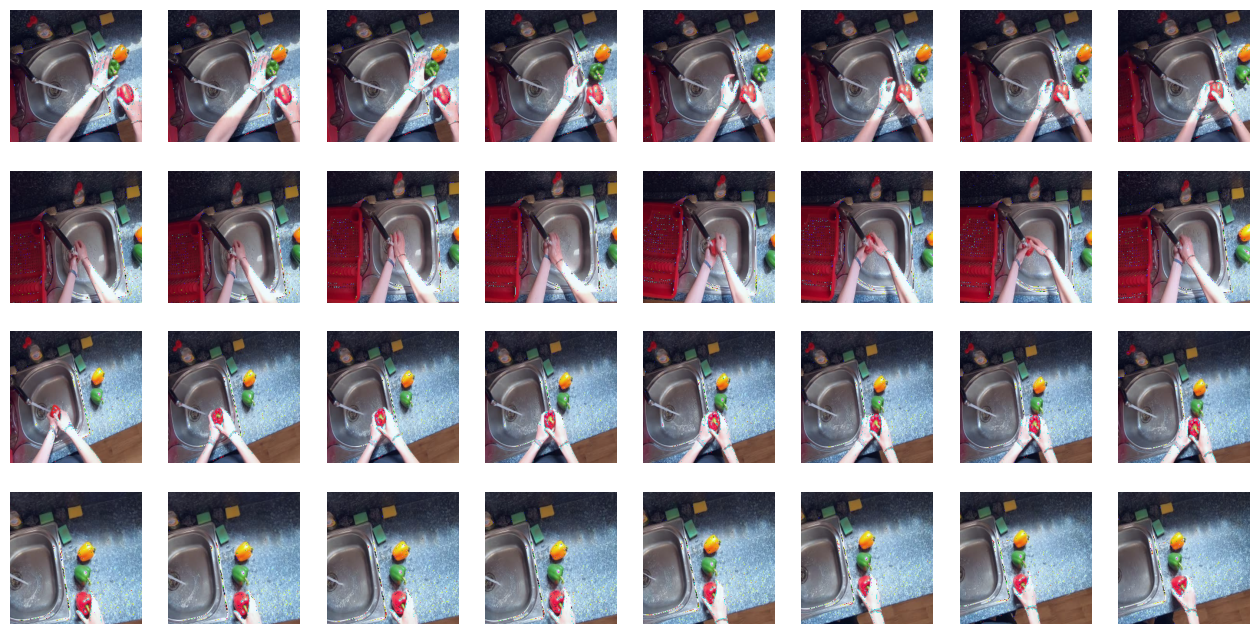

In [35]:
import matplotlib.pyplot as plt

# 이미지 출력 함수
def show_images_from_tensor(tensor):
    batch_size, channels, num_images, height, width = tensor.size()
    
    fig, axes = plt.subplots(batch_size, num_images, figsize=(num_images*2, batch_size*2))
    
    for i in range(batch_size):
        for j in range(num_images):
            image = tensor[i, :, j, :, :].permute(1, 2, 0).numpy()
            # 이미지를 [0, 1] 범위로 정규화
            image = (image - image.min()) / (image.max() - image.min())
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
    
    plt.show()

print(f'{datasets["egoplan_action_recognition"]["train"][0]["clips"].shape}')
show_images_from_tensor(datasets["egoplan_action_recognition"]["train"][0]["clips"])

##### - text_output

In [36]:
datasets["egoplan_action_recognition"]["train"].tokenizer.decode(datasets["egoplan_action_recognition"]["train"][0]["text_input"], skip_special_tokens=True).split('</Image> ')[1]

'What exact actions were depicted in the video? Please list them in order, describing each action with a brief verb-noun phrase. [/INST] take bell pepper, rinse bell pepper, put bell pepper, turn off tap. '

##### - image shape

In [37]:
datasets['egoplan_action_recognition']['train'][0]['image'].shape

"""
Image channel(RGB) * Height * Width
"""

'\nImage channel(RGB) * Height * Width\n'

##### - image visualize

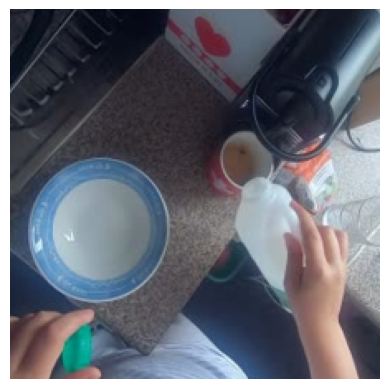

In [38]:
import matplotlib.pyplot as plt

def tensor_to_image(tensor):
    tensor = tensor.squeeze()  # 배치 차원 제거
    tensor = tensor.permute(1, 2, 0)  # 차원 순서 변경 (C, H, W) -> (H, W, C)
    tensor = tensor.numpy()  # 텐서를 NumPy 배열로 변환
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())  # 정규화 (0-1 사이)
    return tensor

image = tensor_to_image(datasets['egoplan_action_recognition']['train'][2]['image'])

# 이미지 시각화
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()

##### - data input

In [39]:
datasets['egoplan_action_recognition']['train'][0].keys()

dict_keys(['image', 'clips', 'clip_mask', 'text_input', 'labels', 'type'])

#### 9.4 scheduler optim

#### - 모델의 learning rate scheduler, optimizer 등의 학습 관련 하이퍼 파라미터를 설정합니다.

In [40]:
@registry.register_lr_scheduler("linear_warmup_step_lr")
class LinearWarmupStepLRScheduler:
    """
    LinearWarmupStepLRScheduler는 학습 초반에 선형으로 학습률을 증가시키는 웜업 단계와 이후 계단식으로 학습률을 감소시키는 두 단계를 포함
    """

    def __init__(
        self,
        optimizer,
        max_epoch,
        min_lr,
        init_lr,
        decay_rate=1,
        warmup_start_lr=-1,
        warmup_steps=0,
        **kwargs
    ):
        """
        스케줄러를 초기화
        Input:
            optimizer (Optimizer): 학습 중인 모델의 옵티마이저.
            max_epoch (int): 학습의 최대 에폭 수.
            min_lr (float): 학습률의 최솟값.
            init_lr (float): 초기 학습률.
            decay_rate (float, optional): 학습률 감소 비율. 기본값은 1.
            warmup_start_lr (float, optional): 웜업 시작 시 학습률. 기본값은 -1 (즉, init_lr과 동일).
            warmup_steps (int, optional): 웜업 단계의 스텝 수. 기본값은 0.
            **kwargs: 추가적인 매개변수.
        """

        self.optimizer = optimizer

        self.max_epoch = max_epoch
        self.min_lr = min_lr

        self.decay_rate = decay_rate

        self.init_lr = init_lr
        self.warmup_steps = warmup_steps
        self.warmup_start_lr = warmup_start_lr if warmup_start_lr >= 0 else init_lr

    def step(self, cur_epoch, cur_step):
        """
        현재 epoch와 step에 따라서 학습률을 업데이트
        웜업 단계에서는 warmup_lr_schedule 함수를 사용하여 학습률을 증가시킴
        웜업 후에는 step_lr_schedule 함수를 사용하여 학습률을 감소시킴
        """
        if cur_epoch == 0:
            warmup_lr_schedule(
                step=cur_step,
                optimizer=self.optimizer,
                max_step=self.warmup_steps,
                init_lr=self.warmup_start_lr,
                max_lr=self.init_lr,
            )
        else:
            step_lr_schedule(
                epoch=cur_epoch,
                optimizer=self.optimizer,
                init_lr=self.init_lr,
                min_lr=self.min_lr,
                decay_rate=self.decay_rate,
            )

@registry.register_lr_scheduler("linear_warmup_cosine_lr")
class LinearWarmupCosineLRScheduler:
    """
    이 스케줄러는 학습 초반에 선형으로 학습률을 증가시키는 웜업 단계와 이후 코사인 함수를 사용하여 학습률을 부드럽게 감소시키는 두 단계를 포함
    """
    def __init__(
        self,
        optimizer,
        max_epoch,
        iters_per_epoch,
        min_lr,
        init_lr,
        warmup_steps=0,
        warmup_start_lr=-1,
        **kwargs
    ):
        self.optimizer = optimizer

        self.max_epoch = max_epoch
        self.iters_per_epoch = iters_per_epoch
        self.min_lr = min_lr

        self.init_lr = init_lr
        self.warmup_steps = warmup_steps
        self.warmup_start_lr = warmup_start_lr if warmup_start_lr >= 0 else init_lr

    def step(self, cur_epoch, cur_step):
        total_cur_step = cur_epoch * self.iters_per_epoch + cur_step
        if total_cur_step < self.warmup_steps:
            warmup_lr_schedule(
                step=cur_step,
                optimizer=self.optimizer,
                max_step=self.warmup_steps,
                init_lr=self.warmup_start_lr,
                max_lr=self.init_lr,
            )
        else:
            cosine_lr_schedule(
                epoch=total_cur_step,
                optimizer=self.optimizer,
                max_epoch=self.max_epoch * self.iters_per_epoch,
                init_lr=self.init_lr,
                min_lr=self.min_lr,
            )

def cosine_lr_schedule(optimizer, epoch, max_epoch, init_lr, min_lr):
    """
    코사인 함수를 이용하여 학습률을 감소시키는 함수
    초기 학습률 init_lr과 최소 학습률 min_lr 사이에서 코사인 함수를 적용해서 학습률을 결정
    코사인 함수는 epoch에 따라서 학습률을 부드럽게 줄여나갈 수 있도록 기능
    lr 식은 epoch가 max_epoch에 가까워질수록 학습률이 min_lr에 수렴하도록 조정함
    이 함수는 학습이 진행됨에 따라서 학습률을 점진적으로 감소시켜, 초기에는 빠르게 학습하다가 후반에는 더 안정적으로 학습되도록 함
    Input:
        optimizer: 학습을 위한 옵티마이저
        epoch: 현재 에포크
        max_epoch: 최대 에포크 수
        init_lr: 초기 학습률
        min_lr: 최소 학습률
    """

    lr = (init_lr - min_lr) * 0.5 * (
        1.0 + math.cos(math.pi * epoch / max_epoch)
    ) + min_lr
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def warmup_lr_schedule(optimizer, step, max_step, init_lr, max_lr):
    """
    웜업 단계 동안 학습률을 증가시키는 함수
    학습 초반에 학습률을 선형적으로 증가시켜 모델이 안정적으로 학습되도록 도움
    max_lr과 init_lr 사이의 선형보간을 통해 현재 스텝에 해당하는 학습률을 결정
    lr 식은 step이 max_step에 가까워질수록 학습률이 max_lr에 수렴하도록 조정함
    Input:
        optimizer: 학습을 위한 옵티마이저
        step: 현재 스텝 (현재까지 수행된 학습 스텝 수)
        max_step: 웜업 단계의 최대 스텝 수 (웜업 단계가 종료될 스텝 수)
        init_lr: 초기 학습률 (웜업 시작 시의 학습률)
        max_lr: 최대 학습률 (웜업 종료 시의 학습률)
    """
    
    lr = min(max_lr, init_lr + (max_lr - init_lr) * step / max(max_step, 1))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def step_lr_schedule(optimizer, epoch, init_lr, min_lr, decay_rate):
    """
    스텝마다 학습률을 감소시키는 함수
    Input:
        optimizer (Optimizer): 학습 중인 모델의 옵티마이저.
        epoch (int): 현재 에폭.
        init_lr (float): 초기 학습률.
        min_lr (float): 학습률의 최솟값.
        decay_rate (float): 학습률 감소 비율.
    """
    lr = max(min_lr, init_lr * (decay_rate**epoch))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

#### 9.5 Runner base setting

 - 주어진 Task와 Dataset에 대해서 Train와 Evaluation을 수행합니다.
  - 그 과정에서 필요한 Learning Rate Scheduler, Optimizer 등을 적용합니다.
  <br/><br/>
  - RunnerBase는 EgoPlan에서 Train 과정에서만 사용됩니다.
  - 자세한 Train 과정은 아래와 같습니다.
  <br/><br/>
<img src="./Images/RunnerBase Overview.png" width="1000px" height="700px" title="RunnerBase Overview"/>

*  위 그림에서 1, 2, 3번 과정은 아래와 같습니다.  
  <br/>
  - Dataset 불러오기  
    * 전역변수로 존재하는 datasets를 구축하는 과정입니다.  
    * Task 객체로부터 build_datasets 호출하면 DatasetBuilder가 Dataset 클래스를 객체화하여 반환
    * 반환된 Dataset은 \__get_item\__ 과 같은 함수를 포함하는 형태  
  <br/>
  - Dataset, Task, Model, Config을 인자로 전달하여, RunnerBase 객체 생성  
    * RunnerBase는 전달받은 Dataset, Model.. 로 실질적인 학습을 수행하는 객체  
    * EgoPlan에서는 runner train() 을 통해서 모델 학습을 수행  
  <br/>
  - RunnerBase를 통한 모델 Train  
    * runner train() 호출
      * Task 객체 내의 train_epoch를 매 Epoch마다 실행
        * Task의 train_epoch는 Task의 \__train_inner_loop를 실행
        * \__train_inner_loop는 data_loader (RunnerBase로부터 전달받은) 에서 Batch 단위로 학습을 진행
        * 각 sample (batch_size 만큼의) 은 prepare_sample 함수를 통해 GPU Memory 위에 올라감
        * 이후 Task 내의 train_step에 모델과 sample을 전달하면, 순전파 수행 후 loss를 반환
        * 반환 받은 loss를 통해 backward 연산을 수행
      * 매 Epoch 학습이 끝난 이후 eval_epoch를 호출
        * EgoPlan는 Vaildation Dataset이 정의되지 않았으므로, eval_epoch는 아무 작동도 하지 않는다.

In [41]:
@registry.register_runner("runner_base")
class RunnerBase:
    """
    주어진 작업과 데이터셋을 기반으로 모델을 학습하고 평가하는 러너 클래스
    이 러너는 기본적으로 PyTorch의 분산 데이터 병렬 처리를 사용
    """

    def __init__(self, cfg, task, model, datasets, job_id):
        self.config = cfg
        self.job_id = job_id

        self.task = task
        self.datasets = datasets

        self._model = model

        self._wrapped_model = None
        self._device = None
        self._optimizer = None
        self._scaler = None
        self._dataloaders = None
        self._lr_sched = None

        self.start_epoch = 0

        # self.setup_seeds()
        self.setup_output_dir()

    @property
    def device(self):
        if self._device is None:
            self._device = torch.device(self.config.run_cfg.device)

        return self._device

    @property
    def use_distributed(self):
        return self.config.run_cfg.distributed

    @property
    def model(self):
        """
        디바이스에 DDP로 래핑된 모델을 가져오는 속성
        """
        # move model to device
        if self._model.device != self.device:
            self._model = self._model.to(self.device)

            # distributed training wrapper
            if self.use_distributed:
                if self._wrapped_model is None:
                    self._wrapped_model = DDP(
                        self._model, device_ids=[self.config.run_cfg.gpu]
                    )
            else:
                self._wrapped_model = self._model

        return self._wrapped_model

    @property
    def optimizer(self):
        # TODO make optimizer class and configurations
        if self._optimizer is None:
            num_parameters = 0
            p_wd, p_non_wd = [], []
            for n, p in self.model.named_parameters():
                if not p.requires_grad:
                    continue  # frozen weights
                # print(n)
                if p.ndim < 2 or "bias" in n or "ln" in n or "bn" in n:
                    p_non_wd.append(p)
                else:
                    p_wd.append(p)
                num_parameters += p.data.nelement()
            logging.info("number of trainable parameters: %d" % num_parameters)
            optim_params = [
                {
                    "params": p_wd,
                    "weight_decay": float(self.config.run_cfg.weight_decay),
                },
                {"params": p_non_wd, "weight_decay": 0},
            ]
            beta2 = self.config.run_cfg.get("beta2", 0.999)
            self._optimizer = torch.optim.AdamW(
                optim_params,
                lr=float(self.config.run_cfg.init_lr),
                weight_decay=float(self.config.run_cfg.weight_decay),
                betas=(0.9, beta2),
            )

        return self._optimizer

    @property
    def scaler(self):
        amp = self.config.run_cfg.get("amp", False)

        if amp:
            if self._scaler is None:
                self._scaler = torch.cuda.amp.GradScaler()

        return self._scaler

    @property
    def lr_scheduler(self):
        """
        lr_scheduler를 필요할 때마다 생성하고 가져오는 속성
        """
        if self._lr_sched is None:
            lr_sched_cls = registry.get_lr_scheduler_class(self.config.run_cfg.lr_sched)

            # max_epoch = self.config.run_cfg.max_epoch
            max_epoch = self.max_epoch
            # min_lr = self.config.run_cfg.min_lr
            min_lr = self.min_lr
            # init_lr = self.config.run_cfg.init_lr
            init_lr = self.init_lr

            # optional parameters
            decay_rate = self.config.run_cfg.get("lr_decay_rate", None)
            warmup_start_lr = self.config.run_cfg.get("warmup_lr", -1)
            warmup_steps = self.config.run_cfg.get("warmup_steps", 0)
            iters_per_epoch = self.config.run_cfg.get("iters_per_epoch", None)

            if iters_per_epoch is None:
                try:
                    iters_per_epoch = len(self.train_loader)
                    print(f"iters_per_epoch: {iters_per_epoch}")
                except (AttributeError, TypeError):
                    iters_per_epoch = 10000

            # exit()
            self._lr_sched = lr_sched_cls(
                optimizer=self.optimizer,
                max_epoch=max_epoch,
                iters_per_epoch=iters_per_epoch,
                min_lr=min_lr,
                init_lr=init_lr,
                decay_rate=decay_rate,
                warmup_start_lr=warmup_start_lr,
                warmup_steps=warmup_steps,
            )

        return self._lr_sched

    @property
    def dataloaders(self) -> dict:
        """
        필요할 때마다 데이터로더를 생성하고 가져오는 속성
        train_dataset_ratio가 제공되지 않은 경우, map-style 데이터셋을 연결하고 wds.DataPipe 데이터셋을 별도로 연결
        train_dataset은 (ConcatDataset, ChainDataset) 튜플로 구성되며, 둘 중 하나만 있어도 됨 
        생성된 ConcatDataset과 ChainDataset은 균등하게 샘플링됨
        train_dataset_ratio가 제공된 경우, 각 데이터셋을 비율에 따라 샘플링하는 MultiIterLoader를 생성
        Output:
            dict: {split_name: (tuples of) dataloader}
        """
        if self._dataloaders is None:

            # concatenate map-style datasets and chain wds.DataPipe datasets separately
            # training set becomes a tuple (ConcatDataset, ChainDataset), both are
            # optional but at least one of them is required. The resultant ConcatDataset
            # and ChainDataset will be sampled evenly.
            logging.info(
                "dataset_ratios not specified, datasets will be concatenated (map-style datasets) or chained (webdataset.DataPipeline)."
            )

            datasets = reorg_datasets_by_split(self.datasets)
            self.datasets = datasets
            # self.datasets = concat_datasets(datasets)

            # print dataset statistics after concatenation/chaining
            for split_name in self.datasets:
                if isinstance(self.datasets[split_name], tuple) or isinstance(
                    self.datasets[split_name], list
                ):
                    # mixed wds.DataPipeline and torch.utils.data.Dataset
                    num_records = sum(
                        [
                            len(d)
                            if not type(d) in [wds.DataPipeline, ChainDataset]
                            else 0
                            for d in self.datasets[split_name]
                        ]
                    )

                else:
                    if hasattr(self.datasets[split_name], "__len__"):
                        # a single map-style dataset
                        num_records = len(self.datasets[split_name])
                    else:
                        # a single wds.DataPipeline
                        num_records = -1
                        logging.info(
                            "Only a single wds.DataPipeline dataset, no __len__ attribute."
                        )

                if num_records >= 0:
                    logging.info(
                        "Loaded {} records for {} split from the dataset.".format(
                            num_records, split_name
                        )
                    )

            # create dataloaders
            split_names = sorted(self.datasets.keys())

            datasets = [self.datasets[split] for split in split_names]
            is_trains = [split in self.train_splits for split in split_names]

            batch_sizes = [
                self.config.run_cfg.batch_size_train
                if split == "train"
                else self.config.run_cfg.batch_size_eval
                for split in split_names
            ]

            collate_fns = []
            for dataset in datasets:
                if isinstance(dataset, tuple) or isinstance(dataset, list):
                    collate_fns.append([getattr(d, "collater", None) for d in dataset])
                else:
                    collate_fns.append(getattr(dataset, "collater", None))

            dataloaders = self.create_loaders(
                datasets=datasets,
                num_workers=self.config.run_cfg.num_workers,
                batch_sizes=batch_sizes,
                is_trains=is_trains,
                collate_fns=collate_fns,
            )

            self._dataloaders = {k: v for k, v in zip(split_names, dataloaders)}

        return self._dataloaders

    @property
    def cuda_enabled(self):
        return self.device.type == "cuda"

    @property
    def max_epoch(self):
        return int(self.config.run_cfg.max_epoch)

    @property
    def log_freq(self):
        log_freq = self.config.run_cfg.get("log_freq", 50)
        return int(log_freq)

    @property
    def init_lr(self):
        return float(self.config.run_cfg.init_lr)

    @property
    def min_lr(self):
        return float(self.config.run_cfg.min_lr)

    @property
    def accum_grad_iters(self):
        return int(self.config.run_cfg.get("accum_grad_iters", 1))

    @property
    def valid_splits(self):
        valid_splits = self.config.run_cfg.get("valid_splits", [])

        if len(valid_splits) == 0:
            logging.info("No validation splits found.")

        return valid_splits

    @property
    def test_splits(self):
        test_splits = self.config.run_cfg.get("test_splits", [])

        return test_splits

    @property
    def train_splits(self):
        train_splits = self.config.run_cfg.get("train_splits", [])

        if len(train_splits) == 0:
            logging.info("Empty train splits.")

        return train_splits

    @property
    def evaluate_only(self):
        """
        Set to True to skip training.
        """
        return self.config.run_cfg.evaluate

    @property
    def use_dist_eval_sampler(self):
        return self.config.run_cfg.get("use_dist_eval_sampler", True)

    @property
    def resume_ckpt_path(self):
        return self.config.run_cfg.get("resume_ckpt_path", None)

    @property
    def train_loader(self):
        train_dataloader = self.dataloaders["train"]
        return train_dataloader

    def setup_output_dir(self):
        lib_root = Path(registry.get_path("library_root"))

        output_dir = lib_root / self.config.run_cfg.output_dir / self.job_id
        result_dir = output_dir / "result"

        output_dir.mkdir(parents=True, exist_ok=True)
        result_dir.mkdir(parents=True, exist_ok=True)

        registry.register_path("result_dir", str(result_dir))
        registry.register_path("output_dir", str(output_dir))

        self.result_dir = result_dir
        self.output_dir = output_dir

    def train(self):
        start_time = time.time()
        best_agg_metric = 0
        best_epoch = 0

        self.log_config()

        # resume from checkpoint if specified < 현재 Null값이라 실행 안됨
        if not self.evaluate_only and self.resume_ckpt_path is not None:
            self._load_checkpoint(self.resume_ckpt_path)

        # Epoch 만큼 학습 진행
        for cur_epoch in range(self.start_epoch, self.max_epoch):

            # training phase ( 참고 : Config 상에서 evaluate_only 값은 False임 )
            if not self.evaluate_only:
                logging.info("Start training")
                train_stats = self.train_epoch(cur_epoch)
                self.log_stats(split_name="train", stats=train_stats)

            # evaluation phase < validation set이 존재하지 않으므로 ( config 상에 정의되지 않음 ) 실행되지 않됨.
            if len(self.valid_splits) > 0:
                for split_name in self.valid_splits:
                    logging.info("Evaluating on {}.".format(split_name))

                    val_log = self.eval_epoch(
                        split_name=split_name, cur_epoch=cur_epoch
                    )
                    if val_log is not None:
                        if is_main_process():
                            assert (
                                "agg_metrics" in val_log
                            ), "No agg_metrics found in validation log."

                            agg_metrics = val_log["agg_metrics"]
                            if agg_metrics > best_agg_metric and split_name == "val":
                                best_epoch, best_agg_metric = cur_epoch, agg_metrics

                                self._save_checkpoint(cur_epoch, is_best=True)

                            val_log.update({"best_epoch": best_epoch})
                            self.log_stats(val_log, split_name)

            else:
                # 각 Epoch 별로 모델의 checkpoint를 저장함
                # validation set가 없을경우, 맨 마지막 epoch의 checkpoint만 저장됨
                if not self.evaluate_only:
                    self._save_checkpoint(cur_epoch, is_best=False)

            if self.evaluate_only:
                break

            if self.config.run_cfg.distributed:
                dist.barrier()

        # testing phase
        # test set이 없으므로, test_log에는 아무것도 저장되지 않됨.
        test_epoch = "best" if len(self.valid_splits) > 0 else cur_epoch
        self.evaluate(cur_epoch=test_epoch, skip_reload=self.evaluate_only)

        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        logging.info("Training time {}".format(total_time_str))

    def evaluate(self, cur_epoch="best", skip_reload=False):
        test_logs = dict()

        if len(self.test_splits) > 0:
            for split_name in self.test_splits:
                test_logs[split_name] = self.eval_epoch(
                    split_name=split_name, cur_epoch=cur_epoch, skip_reload=skip_reload
                )

            return test_logs

    def train_epoch(self, epoch):
        # train
        self.model.train()

        return self.task.train_epoch(
            epoch=epoch,
            model=self.model,
            data_loader=self.train_loader,
            optimizer=self.optimizer,
            scaler=self.scaler,
            lr_scheduler=self.lr_scheduler,
            cuda_enabled=self.cuda_enabled,
            log_freq=self.log_freq,
            accum_grad_iters=self.accum_grad_iters,
        )

    @torch.no_grad()
    def eval_epoch(self, split_name, cur_epoch, skip_reload=False):
        """
        주어진 split에서 모델 평가
        Input:
            split_name (str): name of the split to evaluate on.
            cur_epoch (int): current epoch.
            skip_reload_best (bool): whether to skip reloading the best checkpoint.
                During training, we will reload the best checkpoint for validation.
                During testing, we will use provided weights and skip reloading the best checkpoint .
        """
        data_loader = self.dataloaders.get(split_name, None)
        assert data_loader, "data_loader for split {} is None.".format(split_name)

        # TODO In validation, you need to compute loss as well as metrics
        # TODO consider moving to model.before_evaluation()
        model = self.unwrap_dist_model(self.model)
        if not skip_reload and cur_epoch == "best":
            model = self._reload_best_model(model)
        model.eval()

        self.task.before_evaluation(
            model=model,
            dataset=self.datasets[split_name],
        )
        results = self.task.evaluation(model, data_loader)

        if results is not None:
            return self.task.after_evaluation(
                val_result=results,
                split_name=split_name,
                epoch=cur_epoch,
            )

    def unwrap_dist_model(self, model):
        if self.use_distributed:
            return model.module
        else:
            return model

    def create_loaders(
        self,
        datasets,
        num_workers,
        batch_sizes,
        is_trains,
        collate_fns,
        dataset_ratios=None,
    ):
        
        """
        Training과 validation을 위한 dataloader들을 생성
        """
        def _create_loader(dataset, num_workers, bsz, is_train, collate_fn):
            # create a single dataloader for each split
            if isinstance(dataset, ChainDataset) or isinstance(
                dataset, wds.DataPipeline
            ):
                # wds.WebdDataset instance are chained together
                # webdataset.DataPipeline has its own sampler and collate_fn
                loader = iter(
                    DataLoader(
                        dataset,
                        batch_size=bsz,
                        num_workers=num_workers,
                        pin_memory=True,
                    )
                )
            else:
                # map-style dataset are concatenated together
                # setup distributed sampler
                if self.use_distributed:
                    sampler = DistributedSampler(
                        dataset,
                        shuffle=is_train,
                        num_replicas=get_world_size(),
                        rank=get_rank(),
                    )
                    if not self.use_dist_eval_sampler:
                        # e.g. retrieval evaluation
                        sampler = sampler if is_train else None
                else:
                    sampler = None

                loader = DataLoader(
                    dataset,
                    batch_size=bsz,
                    num_workers=num_workers,
                    pin_memory=True,
                    sampler=sampler,
                    shuffle=sampler is None and is_train,
                    collate_fn=collate_fn,
                    drop_last=True if is_train else False,
                )
                loader = PrefetchLoader(loader)

                if is_train:
                    loader = IterLoader(loader, use_distributed=self.use_distributed)

            return loader

        loaders = []

        for dataset, bsz, is_train, collate_fn in zip(
            datasets, batch_sizes, is_trains, collate_fns
        ):
            if isinstance(dataset, list) or isinstance(dataset, tuple):
                if hasattr(dataset[0], 'sample_ratio') and dataset_ratios is None:
                    dataset_ratios = [d.sample_ratio for d in dataset]
                loader = MultiIterLoader(
                    loaders=[
                        _create_loader(d, num_workers, bsz, is_train, collate_fn[i])
                        for i, d in enumerate(dataset)
                    ],
                    ratios=dataset_ratios,
                )
            else:
                loader = _create_loader(dataset, num_workers, bsz, is_train, collate_fn)

            loaders.append(loader)

        return loaders

    @main_process
    def _save_checkpoint(self, cur_epoch, is_best=False):
        """
        현재 에포크에서의 checkpoint 저장
        """
        model_no_ddp = self.unwrap_dist_model(self.model)

        if hasattr(model_no_ddp, "llama_model") and isinstance(model_no_ddp.llama_model, PeftModel):
            logging.info(
                "Saving lora weights for llama_model ..."
            )
            model_no_ddp.llama_model.save_pretrained(
                os.path.join(self.output_dir, "lora_weights_{}".format("best" if is_best else cur_epoch))
            )

        param_grad_dic = {
            k: v.requires_grad for (k, v) in model_no_ddp.named_parameters()
        }

        state_dict = model_no_ddp.state_dict()
        for k in list(state_dict.keys()):
            if k in param_grad_dic.keys() and not param_grad_dic[k]:
                # delete parameters that do not require gradient
                del state_dict[k]
        save_obj = {
            "model": state_dict,
            "optimizer": self.optimizer.state_dict(),
            "config": self.config.to_dict(),
            "scaler": self.scaler.state_dict() if self.scaler else None,
            "epoch": cur_epoch,
        }
        save_to = os.path.join(
            self.output_dir,
            "checkpoint_{}.pth".format("best" if is_best else cur_epoch),
        )
        logging.info("Saving checkpoint at epoch {} to {}.".format(cur_epoch, save_to))
        torch.save(save_obj, save_to)

    def _reload_best_model(self, model):
        """
        평가를 위해 best checkpoint를 load
        """
        checkpoint_path = os.path.join(self.output_dir, "checkpoint_best.pth")

        logging.info("Loading checkpoint from {}.".format(checkpoint_path))
        checkpoint = torch.load(checkpoint_path, map_location="cpu")
        try:
            model.load_state_dict(checkpoint["model"])
        except RuntimeError as e:
            logging.warning(
                """
                Key mismatch when loading checkpoint. This is expected if only part of the model is saved.
                Trying to load the model with strict=False.
                """
            )
            model.load_state_dict(checkpoint["model"], strict=False)
        return model

    def _load_checkpoint(self, url_or_filename):
        """
        checkpoint에서 재개
        """
        if is_url(url_or_filename):
            cached_file = download_cached_file(
                url_or_filename, check_hash=False, progress=True
            )
            checkpoint = torch.load(cached_file, map_location=self.device, strict=False)
        elif os.path.isfile(url_or_filename):
            checkpoint = torch.load(url_or_filename, map_location=self.device, strict=False)
        else:
            raise RuntimeError("checkpoint url or path is invalid")

        state_dict = checkpoint["model"]
        self.unwrap_dist_model(self.model).load_state_dict(state_dict)

        self.optimizer.load_state_dict(checkpoint["optimizer"])
        if self.scaler and "scaler" in checkpoint:
            self.scaler.load_state_dict(checkpoint["scaler"])

        self.start_epoch = checkpoint["epoch"] + 1
        logging.info("Resume checkpoint from {}".format(url_or_filename))

    @main_process
    def log_stats(self, stats, split_name):
        if isinstance(stats, dict):
            log_stats = {**{f"{split_name}_{k}": v for k, v in stats.items()}}
            with open(os.path.join(self.output_dir, "log.txt"), "a") as f:
                f.write(json.dumps(log_stats) + "\n")
        elif isinstance(stats, list):
            pass

    @main_process
    def log_config(self):
        with open(os.path.join(self.output_dir, "log.txt"), "a") as f:
            f.write(json.dumps(self.config.to_dict(), indent=4) + "\n")

#### 9.6 Run model

In [42]:
def get_runner_class(cfg):
    """
    config에서 runner 클래스를 가져옴 
    기본값은 epoch 기반 runner
    """
    runner_cls = registry.get_runner_class(cfg.run_cfg.get("runner", "runner_base"))

    return runner_cls

job_id = now()

# if you need set model, Please untangle the comment below

# model = task.build_model(cfg)

# runner = get_runner_class(cfg)(
#     cfg=cfg, job_id=job_id, task=task, model=model, datasets=datasets
# )

In [43]:
# train model

# if you need train model, Please untangle the comment below

# runner.train()

---

# <h1><span id="evaluate" style="background-color: White; color: black; display: inline;">10. Evaluate</span></h1>

### [[Back to contents](#contents)]

#### 10.1 Set Evaluation seed

In [44]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### 10.2 video llama interface

- LLaMA 모델을 초기화하고 설정하는 과정 및 비디오 데이터를 처리해서 특정 프레임을 추출하고 전처리하는 함수들과, 주어진 질문과 선택지에 대해 모델이 가장 적합한 선택지를 예측하도록 하는 함수들을 정의.

#### 주요 구성 요소

##### - ego4d_video_process : 시작 frame으로부터 현재 frame까지 일정 간격으로 frame index를 생성하고, 해당 frame을 읽어 clip을 구성해 tensor 형태로 반환합니다 (기본 8개). 없는 경우 현재 관찰 frame을 반복해 8개의 frame을 만듭니다.

- Input : sample (video 샘플에 대한 정보를 담고 있는 dictionary), vis_processor (video preprocessing을 위한 processor 객체), n_frms (추출할 frame 수, 기본값 8)
- Output : 추출된 frame clip을 tensor로 반환

##### - epic_kitchens_cideo_process : Epic_kitchens 데이터셋을 대상으로 마찬가지로 주어진 video sample로부터 일정 간격으로 frame을 추출하고, tensor 형태로 변환하여 반환합니다.

- Input : sample (video 샘플에 대한 정보를 담고 있는 dictionary), vis_processor (video preprocessing을 위한 processor 객체), n_frms (추출할 frame 수, 기본값 8)
- Output : 추출된 frame clip을 tensor로 반환

##### - predict_choice : 위의 두 함수를 이용해 주어진 데이터셋에 따라 각각의 데이터 처리 함수를 호출하여 클립을 추출합니다. 그리고 주어진 비디오 샘플과 질문을 기반으로 모델을 통해 예측을 수행하고, 선택지별 손실 값을 계산합니다. 가장 낮은 손실 값을 갖는 선택지의 인덱스를 찾아 해당 선택지를 계산합니다.

##### - build_video_llama : 주어진 설정 파일을 바탕으로 video 처리 모델을 생성하고 초기화합니다. 이후 predict_choice 함수에 모델, preprocessor, return_loss 옵션등을 부분적으로 적용해 return 합니다.

In [45]:
NUM_VIDEO_QUERY_TOKEN = 32

class Arguments:
    def __init__(self, cfg_path, model_type):
        self.cfg_path = cfg_path
        self.model_type = model_type
        self.options = None

def ego4d_video_process(sample, vis_processor, n_frms=8):
    """
    Ego4d데이터셋의 비디오 프레임을 입력으로 받아 특정 프레임들을 추출하고 전처리하는 작업을 수행
    Input:
        sample : 비디오 파일 경로(video_path), 프레임 정보등을 포함하는 dictionary
        vis_processor : 비디오 프레임을 전처리하는 객체
        n_frms: 클립에 포함될 프레임의 수 (기본값은 8)
    Output:
        clip: 전처리된 비디오 클립(PyTorch 텐서)
    """
    video_path = sample["video_path"]
    video = cv2.VideoCapture(video_path)

    current_observation_frame_idx = sample["current_observation_frame"]
    video.set(cv2.CAP_PROP_POS_FRAMES, current_observation_frame_idx)
    ret, image = video.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image).convert("RGB")

    task_progress_metadata = sample["task_progress_metadata"]
    if len(task_progress_metadata) > 0:
        start_frame_idx = task_progress_metadata[0]["start_frame"]
        end_frame_idx = current_observation_frame_idx
        frame_indices = np.arange(start_frame_idx, end_frame_idx,
                                  (end_frame_idx - start_frame_idx) / (n_frms-1)).astype(int).tolist()

        clip = []
        for i in frame_indices:
            video.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = video.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame).convert("RGB")
                clip.append(frame)
        clip = clip[:n_frms-1]
        clip.append(image)
    else:
        clip = [image] * n_frms

    clip = np.stack(clip)  # T, H, W, C
    clip = torch.tensor(clip).float().permute(3, 0, 1, 2)  # C, T, H, W
    clip = vis_processor.transform_video(clip)
    return clip

def epic_kitchens_video_process(sample, vis_processor, n_frms=8):
    """
    위의 함수과 동일한 기능을 수행하지만, Epic Kitchens 데이터셋을 위한 함수
    Epic Kitchens 데이터셋의 비디오 프레임을 입력으로 받아 특정 프레임들을 추출하고 전처리하는 작업을 수행
    Input:
        sample : 비디오 파일 경로(video_path), 프레임 정보등을 포함하는 dictionary
        vis_processor : 비디오 프레임을 전처리하는 객체
        n_frms: 클립에 포함될 프레임의 수 (기본값은 8)
    Output:
        clip: 전처리된 비디오 클립(PyTorch 텐서)
    """
    current_observation_frame_idx = sample["current_observation_frame"]
    video_rgb_frame_dir = sample["video_rgb_frame_dir"]

    image_path = os.path.join(video_rgb_frame_dir, f"frame_{str(current_observation_frame_idx).zfill(10)}.jpg")
    image = Image.open(image_path).convert('RGB')  # H, W, C

    task_progress_metadata = sample["task_progress_metadata"]
    if len(task_progress_metadata) > 0:
        start_frame_idx = task_progress_metadata[0]["start_frame"]
        end_frame_idx = current_observation_frame_idx
        frame_indices = np.arange(start_frame_idx, end_frame_idx,
                                  (end_frame_idx - start_frame_idx) / (n_frms-1)).astype(int).tolist()

        clip = []
        for i in frame_indices:
            frame_path = os.path.join(video_rgb_frame_dir, f"frame_{str(i).zfill(10)}.jpg")
            if os.path.exists(frame_path):
                frame = Image.open(frame_path).convert('RGB')
                clip.append(frame)
            else:
                print(f"image_path doesn't exist!! {frame_path}")
                raise FileNotFoundError
        clip = clip[:n_frms - 1]
        clip.append(image)
    else:
        clip = [image] * n_frms

    clip = np.stack(clip)  # T, H, W, C
    clip = torch.tensor(clip).float().permute(3, 0, 1, 2)  # C, T, H, W
    clip = vis_processor.transform_video(clip)
    return clip

@torch.no_grad()
def predict_choice(model, vis_processor, model_type, sample, return_loss=True, subset_name="EpicKitchens"):
    """
    sample에 대해 여러 선택지 중에서 model이 가장 적합하다고 예측하는 선택지를 return함
    위의 method를 활용해 EpicKitchens나 Ego4D 데이터셋을 사용하여 video clip을 처리, 질문과 후보 답변을 기반으로 모델을 통해 가장 손실이 작은 선택지를 예측함
    Input: 
        model: 예측을 수행할 모델 객체.
	    vis_processor: 비디오 프레임을 전처리하는 객체
	    model_type: 모델의 유형 (ex. ‘vicuna’, ‘llama_v2’)
	    sample: 비디오 경로, 프레임 정보, 질문 및 후보 답변을 포함하는 
	    return_loss (기본값=True): 손실 값을 반환할지 여부를 결정하는 boolean 값
	    subset_name: 사용할 데이터셋의 이름 (예: ‘EpicKitchens’, ‘Ego4D’)
    Output:
        predicted_choice: 모델이 예측한 가장 적합한 선택지
        choice2loss (선택 사항): 각 선택지에 대한 손실 값을 포함하는 딕셔너리 (return_loss가 True일 때만)
    """
    llama_tokenizer = model.llama_tokenizer

    if subset_name == "EpicKitchens":
        clip = epic_kitchens_video_process(sample, vis_processor)
    elif subset_name == "Ego4D":
        clip = ego4d_video_process(sample, vis_processor)
    else:
        print('not support')
        raise 'not support'

    question = sample["question"]

    candidates = []
    for choice_idx in ["A", "B", "C", "D"]:
        candidates.append(sample[f"choice_{choice_idx.lower()}"])

    sources = []
    for candidate in candidates:
        conversation_list = [{'q': question,
                              'a': candidate}]
        sources.extend(preprocess_multimodal(
            copy.deepcopy(conversation_list),
            None,
            cur_token_len=NUM_VIDEO_QUERY_TOKEN,
            msg=''))

    new_sources = convert_source_vicuna_format(sources)
    # print(new_sources)
    if model_type == 'vicuna':
        data_dict = preprocess(
            new_sources,
            llama_tokenizer)
    elif model_type == 'llama_v2':
        data_dict = preprocess_for_llama_v2(
            new_sources,
            llama_tokenizer)
    else:
        print('not support')
        raise 'not support'

    data_dict["images"] = torch.repeat_interleave(clip.unsqueeze(0), len(candidates), dim=0)
    data_dict['attention_mask'] = data_dict['input_ids'].ne(llama_tokenizer.pad_token_id)
    for k, v in data_dict.items():
        data_dict[k] = v.cuda()

    data_dict['conv_type'] = 'multi'

    all_losses = model(samples=data_dict, reduction='none')["loss"]
    predicted_choice_idx = torch.argmin(all_losses, dim=-1).item()
    predicted_choice = candidates[predicted_choice_idx]

    if return_loss:
        choice2loss = {}
        for choice, loss in zip(candidates, all_losses.cpu().tolist()):
            choice2loss[choice] = loss
        choice2loss = dict(sorted(choice2loss.items(), key=lambda item: item[1]))
        return predicted_choice, choice2loss
    else:
        return predicted_choice

def build_video_llama(config_path = "./src/video_llama/eval_configs/video_llama_eval_only_vl.yaml"):
    args = Arguments(cfg_path=config_path,
                     model_type="llama_v2")
    cfg = Config(args)

    model_config = cfg.model_cfg
    model_config.device_8bit = 0
    model_cls = registry.get_model_class(model_config.arch)

    device = torch.device(f"cuda:{CUDA_NUMBER}") if torch.cuda.is_available() else "cpu"
    model = model_cls.from_config(model_config).to(device)
    model.eval()

    vis_processor_cfg = cfg.datasets_cfg.webvid.vis_processor.eval
    vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)


    return partial(predict_choice, model=model, vis_processor=vis_processor, model_type=args.model_type, return_loss=True)

#### 10.3 egoplan video llama interface

##### - ego4d_video_image_process: 기본적인 구성과 목적은 ego4d_video_process와 동일하지만, 하나의 video에 여러 action이 포함되어 있을 경우를 처리하기 위해 설계되었습니다. 각 action에 대해 8개의 frame을 추출하고, vis_processor를 사용해 각 이미지를 preprocessing하고 clip을 만들어 최종 clip tensor를 만들어냅니다.

- Input : sample (video 샘플에 대한 정보를 담고 있는 dictionary), vis_processor (video preprocessing을 위한 processor 객체), n_frms (추출할 frame 수, 기본값 8), n_actions (처리할 action의 수, 기본값 4)
- Output : image(현재 관찰 frame의 preprocessed된 image), 추출된 frame clip의 tensor(N, C, T, H, W), clip_mask(각 클립의 유효성)

##### - Egoplanpredict_choice : predict_choice 함수와 목적은 동일합니다. Egoplan과 관련된 설정과 데이터를 처리하는데 중점을 두며, create_question_for_egoplan_task_planning을 통해 task_goal에 따라 질문을 동적으로 생성합니다. 가장 낮은 손실 값을 갖는 선택지의 인덱스를 찾아 해당 답변을 반환합니다.

##### - build_egoplan_video_llama : 마찬가지로 주어진 설정 파일을 바탕으로 Egoplan video LLaMA 모델을 생성하고 초기화합니다. 이후 Egoplanpredict_choice 함수에 모델, preprocessor, return_loss 옵션등을 부분적으로 적용해 return 합니다.

In [46]:
class EgoplanArguments:
    """
    EgoplanArguments 클래스는 설정 파일 경로와 모델 타입을 초기화하는 역할을 함
    """
    def __init__(self, cfg_path: str, model_type: str):
        """
        Input:
            cfg_path: 설정 파일의 경로 (str)
            model_type: 사용할 모델의 타입 (str)
        """
        self.cfg_path = cfg_path
        self.model_type = model_type
        self.options = None


def ego4d_video_image_process(sample, vis_processor, n_frms=8, n_actions=4):
    """
    주어진 샘플과 비디오 경로를 사용하여 비디오 프레임을 처리하는 함수
    이 함수는 비디오 파일에서 특정 작업과 관련된 프레임을 추출하고, 현재 관찰 프레임을 포함하여 비디오 클립과 이미지를 처리 
    이러한 클립과 이미지는 추후 비디오 분석 모델에 입력으로 사용
    Input:
        sample: 비디오 경로와 작업 진행 메타데이터를 포함하는 샘플 딕셔너리
        vis_processor: 이미지 및 비디오 변환을 처리하는 비전 프로세서 객체
        n_frms: 각 클립에서 추출할 프레임 수 (기본값: 8)
        n_actions: 처리할 작업의 수 (기본값: 4)
    """
    # 비디오 경로를 가져오고, 비디오 캡처 객체를 생성
    video_path = sample["video_path"]
    video = cv2.VideoCapture(video_path)

    # 작업 진행 메타데이터를 가져옴
    task_progress_metadata = sample["task_progress_metadata"]
    clips = []

    """
    각 작업에 대해 시작 프레임과 종료 프레임 사이에서 n_frms 수만큼의 프레임을 추출
    추출한 프레임을 RGB로 변환하고, PIL 이미지로 변환한 후 리스트에 추가
    각 클립의 길이가 `n_frms`와 동일한지 확인한 후, 클립을 스택하여 텐서로 변환
    """
    for action_metadata in task_progress_metadata[-n_actions:]:
        clip = []
        start_frame_idx = action_metadata["start_frame"]
        end_frame_idx = action_metadata["stop_frame"]
        step_size = (end_frame_idx - start_frame_idx) // n_frms
        for i in range(start_frame_idx, end_frame_idx, step_size):
            video.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = video.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame).convert("RGB")
                clip.append(frame)
        clip = clip[:n_frms]
        assert len(clip) == n_frms
        clip = np.stack(clip)  # T, H, W, C
        clip = torch.tensor(clip).float().permute(3, 0, 1, 2)  # C, T, H, W
        clips.append(clip)

    # 현재 관찰 프레임을 RGB로 변환하고 PIL 이미지로 변환
    current_observation_frame_idx = sample["current_observation_frame"]
    video.set(cv2.CAP_PROP_POS_FRAMES, current_observation_frame_idx)
    ret, image = video.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image).convert("RGB")

    # 비디오 객체를 릴리스하고, OpenCV 창을 닫음
    video.release()
    cv2.destroyAllWindows()

    # 클립이 있는 경우 클립 마스크를 생성하고 부족한 클립 수만큼 마지막 클립을 복제하여 채움
    if len(clips) > 0:
        clip_mask = [1] * len(clips) + [0] * (n_actions - len(clips))
        clip_mask = torch.tensor(clip_mask)
        clips = clips + [clips[-1].clone()] * (n_actions - len(clips))
    else:
        # 클립이 없는 경우, 현재 관찰 프레임을 사용하여 패딩 클립을 생성하고 클립 리스트에 추가
        padding_clip = torch.stack([torch.tensor(np.array(image).copy())] * n_frms).float()  # T, H, W, C
        padding_clip = padding_clip.permute(3, 0, 1, 2)  # C, T, H, W
        clips = [padding_clip] * n_actions  # N, C, T, H, W
        clip_mask = [0] * n_actions
        clip_mask = torch.tensor(clip_mask)

    # 이미지 및 클립을 vis_processor를 사용하여 각 클립을 변환한 후, 스택하여 최종 클립 텐서 생성
    image = vis_processor.transform_image(image)
    transformed_clips = [vis_processor.transform_video(clip) for clip in clips]
    clips = torch.stack(transformed_clips)  # (N, C, T, size, size)

    clip_mask = clip_mask.bool()
    return image, clips, clip_mask

@torch.no_grad()
def Egoplanpredict_choice(model, vis_processor, model_type, sample, return_loss=True, subset_name="EpicKitchens"):
    """
    Egoplanpredict_choice 함수는 주어진 모델과 샘플 데이터를 사용하여 에고플랜 예측 작업을 수행
    이 함수는 비디오 클립과 이미지를 처리하여 모델에 입력하고, 주어진 질문에 대한 후보 답변 중 최적의 답변을 예측하고, 필요한 경우 손실 값을 제공하여 호출자에게 반환
    `@torch.no_grad()`: 이 decorator는 해당 함수 내에서 모든 텐서 연산을 기록하지 않도록 하여 메모리 사용을 줄이고 계산 속도를 높임
    Input:
        model: 예측에 사용할 모델 객체
        vis_processor: 이미지 및 비디오 변환을 처리하는 비전 프로세서 객체
        model_type: 사용할 모델의 타입 (예: 'vicuna', 'llama_v2')
        sample: 예측에 사용할 샘플 데이터 딕셔너리
        return_loss: 예측과 함께 손실 값 반환 여부 (기본값: True)
        subset_name: 사용할 데이터셋의 이름 (기본값: "EpicKitchens")
    """
    llama_tokenizer = model.llama_tokenizer

    # 데이터셋에 따라 비디오와 이미지를 처리
    if subset_name == "EpicKitchens":
        image, clips, clip_mask = vis_processor(sample)
    elif subset_name == "Ego4D":
        image, clips, clip_mask = ego4d_video_image_process(sample, vis_processor)
    else:
        print('not support')
        raise 'not support'
 
    # 작업 목표에 따른 질문 생성
    task_goal = sample["task_goal"]
    question = create_question_for_egoplan_task_planning(task_goal, mode='eval')
    sample["question"] = question

    # 샘플에서 후보 답변을 수집
    candidates = []
    for choice_idx in ["A", "B", "C", "D"]:
        candidates.append(sample[f"choice_{choice_idx.lower()}"])

    # 각 후보 답변에 대해 대화 리스트 생성하고 전처리
    sources = []
    for candidate in candidates:
        conversation_list = [{'q': question,
                              'a': candidate}]
        sources.extend(preprocess_multimodal2(
            conversation_list=copy.deepcopy(conversation_list),
            image_token_len=NUM_VIDEO_QUERY_TOKEN,
            n_actions=N_ACTIONS,
            msg=''))

    new_sources = convert_source_vicuna_format(sources)

    # 모델 타입에 따른 데이터 전처리
    if model_type == 'vicuna':
        data_dict = preprocess(
            new_sources,
            llama_tokenizer)
    elif model_type == 'llama_v2':
        data_dict = preprocess_for_llama_v2(
            new_sources,
            llama_tokenizer)
    else:
        print('not support')
        raise 'not support'

    # 데이터 딕셔너리에 추가 정보 설정하고 CUDA로 데이터를 이동
    data_dict['attention_mask'] = data_dict['input_ids'].ne(llama_tokenizer.pad_token_id)
    data_dict['image'] = torch.repeat_interleave(image.unsqueeze(0), len(candidates), dim=0)
    data_dict['clips'] = torch.repeat_interleave(clips.unsqueeze(0), len(candidates), dim=0)
    data_dict['clip_mask'] = torch.repeat_interleave(clip_mask.unsqueeze(0), len(candidates), dim=0)
    for k, v in data_dict.items():
        #data_dict[k] = v.cuda()
        data_dict[k] = v.to(device)

    data_dict['conv_type'] = 'egoplan'

    # 모델을 사용하여 예측 수행하고 loss 계산
    all_losses = model(samples=data_dict, reduction='none')["loss"]
    predicted_choice_idx = torch.argmin(all_losses, dim=-1).item()
    predicted_choice = candidates[predicted_choice_idx]
    
    """
    손실 값 반환 여부('return_loss')에 따라 결과 반환
    `return_loss=True`**인 경우: 예측된 최적의 선택과 각 후보 답변에 대한 손실 값들을 담은 딕셔너리를 반환
    `return_loss=False`**인 경우: 예측된 최적의 선택만 반환
    """
    if return_loss:
        choice2loss = {}
        for choice, loss in zip(candidates, all_losses.cpu().tolist()):
            choice2loss[choice] = loss
        choice2loss = dict(sorted(choice2loss.items(), key=lambda item: item[1]))
        return predicted_choice, choice2loss
    else:
        return predicted_choice

def build_egoplan_video_llama(config_path = "./src/video_llama/eval_configs/egoplan_video_llama_eval_only_vl.yaml"):
    """
    주어진 설정 파일 경로를 사용하여 Egoplan 비디오 LLaMA 모델을 빌드하는 함수
    이 함수는 모델을 초기화하고 평가 모드로 설정하며, 비전 프로세서를 초기화하여 예측 함수의 partial 객체를 반환
    Input:
        config_path: 설정 파일의 경로 (기본값: "./src/video_llama/eval_configs/egoplan_video_llama_eval_only_vl.yaml")
    """
    # EgoplanArguments 객체를 생성하여 설정 파일 경로와 모델 타입("llama_v2")을 초기화
    args = EgoplanArguments(cfg_path=config_path, model_type="llama_v2")
    cfg = Config(args)

    # `cfg.model_cfg`를 사용하여 모델 설정을 로드하고, 8비트 장치를 비활성화
    model_config = cfg.model_cfg
    model_config.device_8bit = 0
    # `registry.get_model_class`를 사용하여 모델 클래스를 레지스트리에서 가져옴
    model_cls = registry.get_model_class(model_config.arch)

    # 사용할 장치를 설정 (CUDA 또는 CPU)
    device = torch.device(f"cuda:{CUDA_NUMBER}") if torch.cuda.is_available() else "cpu"
    # 모델을 설정에서 로드하고 장치에 할당
    model = model_cls.from_config(model_config).to(device)
    model.eval()  # 모델을 평가 모드로 설정

    """ 
    비전 프로세서 설정을 로드하고 초기화
    `cfg.datasets_cfg.webvid.vis_processor.eval`를 사용하여 비전 프로세서 설정을 로드
    `registry.get_processor_class`를 사용하여 비전 프로세서 클래스를 레지스트리에서 가져와 초기화
    """
    vis_processor_cfg = cfg.datasets_cfg.webvid.vis_processor.eval
    vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

    """
    Egoplanpredict_choice 함수의 partial 객체를 반환
    모델, 비전 프로세서, 모델 타입 및 손실 반환 여부를 인수로 사용
    """
    return partial(Egoplanpredict_choice, model=model, vis_processor=vis_processor, model_type=args.model_type, return_loss=True)

#### 10.4 build init

In [47]:
def build(model_name):
    """
    일반 video_llama와 egoplan_video_llama에 따른 모델 빌드
    """
    if model_name == 'video_llama':
        return build_video_llama()
    elif model_name == 'egoplan_video_llama':
        return build_egoplan_video_llama()

    print(f"model {model_name} not exist")
    exit(0)

#### 10.5 Load Model & Evaluate

In [48]:
def eval_main():
    """
    학습 모델 평가
    """
    eval_predict_choice = build(args.model)
    subset_name = "EpicKitchens"
    
    with open(f"accuracy_for_{args.model}.txt", "w") as fo:
        total_correct_num = 0
        total_question_num = 0
        file_exception_cnt = 0
        
        """
        학습 모델 로드, 데이터 로드 후 평가 진행
        """
        with open(os.path.join("data", f"EgoPlan_validation_small.json")) as fi:
            samples = json.load(fi)
            correct_num = 0
            question_num = 0
            for i, sample in tqdm(enumerate(samples), desc="Processing questions", total=len(samples)):
                # print(f'{file_exception_cnt}')
                print("\n" + "-" * 50 + f" {subset_name}-sample-{sample['sample_id']} " + "-" * 50)
                video_source = sample["video_source"]

                # if video_source == "EpicKitchens":
                #     video_id = sample["video_id"]
                #     participant_id = video_id.split("_")[0]
                #     # video_rgb_frame_dir = os.path.join(args.epic_kitchens_rgb_frame_dir, participant_id, "rgb_frames", video_id)
                #     video_rgb_frame_dir = os.path.join(args.epic_kitchens_rgb_frame_dir, video_id)
                #     sample["video_rgb_frame_dir"] = video_rgb_frame_dir
                # else:
                #     video_id = sample["video_id"]
                #     video_path = os.path.join(args.ego4d_video_dir, f"{video_id}.mp4")
                #     sample["video_path"] = video_path
                """
                EpicKitchens 데이터와 Ego4D 데이터에 따른 데이터 경로와 평가 방식 조정
                """
                if video_source == "EpicKitchens":
                    video_id = sample["video_id"]
                    participant_id = video_id.split("_")[0]
                    # video_rgb_frame_dir = os.path.join(args.epic_kitchens_rgb_frame_dir, participant_id, "rgb_frames", video_id)
                    video_rgb_frame_dir = os.path.join(args.epic_kitchens_rgb_frame_dir, video_id)
                    sample["video_rgb_frame_dir"] = video_rgb_frame_dir
                else:
                    video_id = sample["video_id"]
                    participant_id = video_id.split("_")[0]
                    # video_rgb_frame_dir = os.path.join(args.epic_kitchens_rgb_frame_dir, participant_id, "rgb_frames", video_id)
                    video_rgb_frame_dir = os.path.join(args.ego4d_video_dir, video_id)
                    sample["video_rgb_frame_dir"] = video_rgb_frame_dir
                
                try : 
                    predicted_choice, choice2loss = eval_predict_choice(sample=sample, return_loss=True, subset_name=subset_name)
                except Exception as e:
                    print(f"exception : {e}")
                    file_exception_cnt += 1
                    print(f"video source : {video_source}")
                    continue
                
                """
                실제 질문과 정답, 예측답, loss 계산
                정답과 예측답을 바탕으로 정확도 계산
                """                
                print("***** question *****")
                print(sample["question"])

                print("***** golden choice *****")
                print(sample["answer"])

                print("***** predicted choice *****")
                print(predicted_choice)

                print("***** predicted choice2loss *****")
                print(choice2loss)

                if sample["answer"] == predicted_choice:
                    correct_num += 1
                question_num += 1

            total_correct_num += correct_num
            total_question_num += question_num
        fo.write("Overall accuracy of {} questions: {:.4f}\n".format(total_question_num, total_correct_num / total_question_num))
        fo.flush()

eval_main()

<class '__main__.WebvidBuilder'>, webvid
Loading VIT


Loading VIT Done
Loading Q-Former


Some weights of the model checkpoint at ./bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.embeddings.token_type_embeddings.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at ./bert-base-uncased and are newly initialized: ['bert.encoder.layer.4.crossattention.output.dense.bias', 'bert.encoder.layer.6.crossattention.self.key.bias', 'bert.encoder.layer.4.output_query.dense.bias', 'bert.encoder.layer.10.interm

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 0 || all params: 6,755,192,832 || trainable%: 0.0
Load first Checkpoint: ./src/video_llama/video_llama/outputs/stage3_finetuned_on_EgoPlan_IT/best/checkpoint.pth


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 44.53 GiB total capacity; 1.89 GiB already allocated; 8.31 MiB free; 2.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF